In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from catboost import CatBoostClassifier, Pool
from catboost.utils import eval_metric
import warnings
warnings.filterwarnings("ignore")

## Credits
### Override from Original Dataset.
Credit : @paddykb
https://www.kaggle.com/competitions/playground-series-s4e1/discussion/469859

Added ~0.0026 to LB score from data leakage. Best LB score without override for this notebook is 0.89347

## Parameters

In [2]:
USE_DATA_LEAK='Y' ## Set to Y to exploit data leak
##
RAND_VAL=42
num_folds=500 ## Number of folds
n_est=3500 ## Number of estimators

## Read Train and Test Files

In [3]:
df_train = pd.read_csv(r'data\train.csv')
print(df_train.columns)
df_train.head()

Index(['id', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender',
       'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')


,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [4]:
df_test = pd.read_csv(r'data\test.csv')
df_test_ov = df_test.copy()
df_test.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,165034,15773898,Lucchese,586,France,Female,23.0,2,0.00,2,0.0,1.0,160976.75
1,165035,15782418,Nott,683,France,Female,46.0,2,0.00,1,1.0,0.0,72549.27
2,165036,15807120,K?,656,France,Female,34.0,7,0.00,2,1.0,0.0,138882.09
3,165037,15808905,O'Donnell,681,France,Male,36.0,8,0.00,1,1.0,0.0,113931.57
4,165038,15607314,Higgins,752,Germany,Male,38.0,10,121263.62,1,1.0,0.0,139431.00


## Scaling

In [5]:
scale_cols = ['Age','CreditScore', 'Balance','EstimatedSalary']
###
for c in scale_cols:
    min_value = df_train[c].min()
    max_value = df_train[c].max()
    df_train[c+"_scaled"] = (df_train[c] - min_value) / (max_value - min_value)
    df_test[c+"_scaled"] = (df_test[c] - min_value) / (max_value - min_value)

## Feature Engineering

In [6]:
def getFeats(df):
    
    df['IsSenior'] = df['Age'].apply(lambda x: 1 if x >= 60 else 0)
    df['IsActive_by_CreditCard'] = df['HasCrCard'] * df['IsActiveMember']
    df['Products_Per_Tenure'] =  df['Tenure'] / df['NumOfProducts']
    df['AgeCat'] = np.round(df.Age/20).astype('int').astype('category')
    df['Sur_Geo_Gend_Sal'] = df['Surname']+df['Geography']+df['Gender']+np.round(df.EstimatedSalary).astype('str')
    
    return df

In [7]:
df_train = getFeats(df_train)
df_test = getFeats(df_test)
##
feat_cols=df_train.columns.drop(['id','Exited'])
feat_cols=feat_cols.drop(scale_cols)
print(feat_cols)
df_train.head()

Index(['CustomerId', 'Surname', 'Geography', 'Gender', 'Tenure',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Age_scaled',
       'CreditScore_scaled', 'Balance_scaled', 'EstimatedSalary_scaled',
       'IsSenior', 'IsActive_by_CreditCard', 'Products_Per_Tenure', 'AgeCat',
       'Sur_Geo_Gend_Sal'],
      dtype='object')


,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,...,Exited,Age_scaled,CreditScore_scaled,Balance_scaled,EstimatedSalary_scaled,IsSenior,IsActive_by_CreditCard,Products_Per_Tenure,AgeCat,Sur_Geo_Gend_Sal
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,...,0,0.202703,0.636,0.000000,0.907279,0,0.0,1.5,2,OkwudilichukwuFranceMale181450.0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,...,0,0.202703,0.554,0.000000,0.247483,0,1.0,0.5,2,OkwudiliolisaFranceMale49504.0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,...,0,0.297297,0.656,0.000000,0.924364,0,0.0,5.0,2,HsuehFranceMale184867.0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,...,0,0.216216,0.462,0.593398,0.422787,0,1.0,2.0,2,KaoFranceMale84561.0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,...,0,0.202703,0.732,0.000000,0.075293,0,1.0,2.5,2,ChiemenamSpainMale15069.0


In [8]:
X=df_train[feat_cols]
y=df_train['Exited']
##
cat_features = np.where(X.dtypes != np.float64)[0]
cat_features

array([ 0,  1,  2,  3,  4,  5, 12, 15, 16], dtype=int64)

## Training

In [9]:
folds = StratifiedKFold(n_splits=num_folds,random_state=RAND_VAL,shuffle=True)
test_preds = np.empty((num_folds, len(df_test)))
auc_vals=[]

for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X, y)):
    
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[valid_idx], y.iloc[valid_idx]
    
    train_pool = Pool(X_train, y_train,cat_features=cat_features)
    val_pool = Pool(X_val, y_val,cat_features=cat_features)
    
    clf = CatBoostClassifier(
    eval_metric='AUC',
    learning_rate=0.022,
    task_type='GPU',
    iterations=n_est)
    clf.fit(train_pool, eval_set=val_pool,verbose=300)
    
    y_pred_val = clf.predict_proba(X_val[feat_cols])[:,1]
    auc_val = roc_auc_score(y_val, y_pred_val)
    print("AUC for fold ",n_fold,": ",auc_val)
    auc_vals.append(auc_val)
    
    y_pred_test = clf.predict_proba(df_test[feat_cols])[:,1]
    test_preds[n_fold, :] = y_pred_test
    print("----------------")

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8774767	best: 0.8774767 (0)	total: 37.8ms	remaining: 2m 12s
300:	test: 0.9011495	best: 0.9018610 (250)	total: 9.66s	remaining: 1m 42s
600:	test: 0.9027914	best: 0.9031199 (550)	total: 19.4s	remaining: 1m 33s
900:	test: 0.9032841	best: 0.9039409 (750)	total: 29.7s	remaining: 1m 25s
1200:	test: 0.9035577	best: 0.9039409 (750)	total: 40s	remaining: 1m 16s
1500:	test: 0.9036672	best: 0.9039409 (750)	total: 50.7s	remaining: 1m 7s
1800:	test: 0.9029557	best: 0.9039409 (750)	total: 1m 1s	remaining: 57.9s
2100:	test: 0.9029009	best: 0.9039409 (750)	total: 1m 11s	remaining: 47.9s
2400:	test: 0.9031746	best: 0.9039409 (750)	total: 1m 22s	remaining: 37.9s
2700:	test: 0.9031746	best: 0.9039409 (750)	total: 1m 33s	remaining: 27.7s
3000:	test: 0.9027914	best: 0.9039409 (750)	total: 1m 44s	remaining: 17.4s
3300:	test: 0.9025178	best: 0.9039409 (750)	total: 1m 55s	remaining: 6.99s
3499:	test: 0.9030104	best: 0.9039409 (750)	total: 2m 3s	remaining: 0us
bestTest = 0.9039409161
bestIteration =

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8948002	best: 0.8948002 (0)	total: 28ms	remaining: 1m 38s
300:	test: 0.9185002	best: 0.9185002 (300)	total: 10.1s	remaining: 1m 47s
600:	test: 0.9211823	best: 0.9211823 (595)	total: 27.2s	remaining: 2m 11s
900:	test: 0.9235906	best: 0.9235906 (880)	total: 37.6s	remaining: 1m 48s
1200:	test: 0.9240832	best: 0.9245758 (1110)	total: 48.1s	remaining: 1m 32s
1500:	test: 0.9246305	best: 0.9247947 (1475)	total: 58.6s	remaining: 1m 18s
1800:	test: 0.9243569	best: 0.9247947 (1475)	total: 1m 8s	remaining: 1m 4s
2100:	test: 0.9247947	best: 0.9250137 (2055)	total: 1m 19s	remaining: 53.1s
2400:	test: 0.9247947	best: 0.9250137 (2055)	total: 1m 30s	remaining: 41.5s
2700:	test: 0.9255063	best: 0.9258347 (2635)	total: 1m 40s	remaining: 29.8s
3000:	test: 0.9254516	best: 0.9259989 (2840)	total: 1m 51s	remaining: 18.5s
3300:	test: 0.9256705	best: 0.9259989 (2840)	total: 2m 2s	remaining: 7.36s
3499:	test: 0.9253968	best: 0.9259989 (2840)	total: 2m 9s	remaining: 0us
bestTest = 0.9259989262
bestIt

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9059387	best: 0.9059387 (0)	total: 35.3ms	remaining: 2m 3s
300:	test: 0.8978106	best: 0.9074987 (5)	total: 10.1s	remaining: 1m 47s
600:	test: 0.8968254	best: 0.9074987 (5)	total: 20s	remaining: 1m 36s
900:	test: 0.8964422	best: 0.9074987 (5)	total: 30.2s	remaining: 1m 27s
1200:	test: 0.8962780	best: 0.9074987 (5)	total: 40.8s	remaining: 1m 18s
1500:	test: 0.8961139	best: 0.9074987 (5)	total: 51.6s	remaining: 1m 8s
1800:	test: 0.8956212	best: 0.9074987 (5)	total: 1m 1s	remaining: 58.1s
2100:	test: 0.8951834	best: 0.9074987 (5)	total: 1m 11s	remaining: 47.4s
2400:	test: 0.8953475	best: 0.9074987 (5)	total: 1m 21s	remaining: 37.2s
2700:	test: 0.8952381	best: 0.9074987 (5)	total: 1m 32s	remaining: 27.4s
3000:	test: 0.8950192	best: 0.9074987 (5)	total: 1m 43s	remaining: 17.3s
3300:	test: 0.8956212	best: 0.9074987 (5)	total: 1m 55s	remaining: 6.93s
3499:	test: 0.8950739	best: 0.9074987 (5)	total: 2m 2s	remaining: 0us
bestTest = 0.9074986577
bestIteration = 5
Shrink model to first 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8791461	best: 0.8791461 (0)	total: 38.2ms	remaining: 2m 13s
300:	test: 0.8914614	best: 0.8914614 (300)	total: 10.3s	remaining: 1m 48s
600:	test: 0.8951286	best: 0.8951286 (600)	total: 20.3s	remaining: 1m 37s
900:	test: 0.8960044	best: 0.8962233 (860)	total: 30.5s	remaining: 1m 28s
1200:	test: 0.8968801	best: 0.8969349 (1110)	total: 40.9s	remaining: 1m 18s
1500:	test: 0.8973180	best: 0.8976464 (1315)	total: 51.3s	remaining: 1m 8s
1800:	test: 0.8974822	best: 0.8980296 (1555)	total: 1m 2s	remaining: 58.5s
2100:	test: 0.8972633	best: 0.8980296 (1555)	total: 1m 12s	remaining: 48.4s
2400:	test: 0.8975917	best: 0.8980296 (1555)	total: 1m 23s	remaining: 38.1s
2700:	test: 0.8975917	best: 0.8980296 (1555)	total: 1m 34s	remaining: 27.8s
3000:	test: 0.8977011	best: 0.8980296 (1555)	total: 1m 44s	remaining: 17.4s
3300:	test: 0.8976464	best: 0.8980296 (1555)	total: 1m 55s	remaining: 6.98s
3499:	test: 0.8980843	best: 0.8981390 (3455)	total: 2m 3s	remaining: 0us
bestTest = 0.8981389999
best

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8781883	best: 0.8781883 (0)	total: 23.9ms	remaining: 1m 23s
300:	test: 0.9058018	best: 0.9059113 (290)	total: 10.2s	remaining: 1m 48s
600:	test: 0.9071155	best: 0.9071155 (600)	total: 20.5s	remaining: 1m 38s
900:	test: 0.9092501	best: 0.9094691 (895)	total: 30.7s	remaining: 1m 28s
1200:	test: 0.9103448	best: 0.9103448 (1200)	total: 40.9s	remaining: 1m 18s
1500:	test: 0.9108374	best: 0.9113300 (1395)	total: 51.3s	remaining: 1m 8s
1800:	test: 0.9113300	best: 0.9113848 (1760)	total: 1m 1s	remaining: 58.3s
2100:	test: 0.9118774	best: 0.9118774 (2100)	total: 1m 12s	remaining: 48.1s
2400:	test: 0.9114395	best: 0.9118774 (2100)	total: 1m 22s	remaining: 38s
2700:	test: 0.9111111	best: 0.9118774 (2100)	total: 1m 33s	remaining: 27.6s
3000:	test: 0.9115490	best: 0.9118774 (2100)	total: 1m 43s	remaining: 17.3s
3300:	test: 0.9124247	best: 0.9125342 (3210)	total: 1m 54s	remaining: 6.9s
3499:	test: 0.9123152	best: 0.9125342 (3210)	total: 2m 1s	remaining: 0us
bestTest = 0.9125342369
bestIte

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8963328	best: 0.8963328 (0)	total: 32.8ms	remaining: 1m 54s
300:	test: 0.9081007	best: 0.9082649 (280)	total: 10.2s	remaining: 1m 48s
600:	test: 0.9082102	best: 0.9088123 (335)	total: 20.7s	remaining: 1m 39s
900:	test: 0.9083197	best: 0.9088123 (335)	total: 31s	remaining: 1m 29s
1200:	test: 0.9084291	best: 0.9088123 (335)	total: 41.3s	remaining: 1m 19s
1500:	test: 0.9087575	best: 0.9090859 (1465)	total: 51.8s	remaining: 1m 9s
1800:	test: 0.9091406	best: 0.9095786 (1685)	total: 1m 2s	remaining: 58.7s
2100:	test: 0.9095238	best: 0.9095786 (1685)	total: 1m 12s	remaining: 48.3s
2400:	test: 0.9097428	best: 0.9099069 (2365)	total: 1m 23s	remaining: 38.1s
2700:	test: 0.9101806	best: 0.9103448 (2535)	total: 1m 33s	remaining: 27.7s
3000:	test: 0.9103448	best: 0.9106733 (2880)	total: 1m 44s	remaining: 17.3s
3300:	test: 0.9110016	best: 0.9110016 (3300)	total: 1m 55s	remaining: 6.93s
3499:	test: 0.9110564	best: 0.9112753 (3360)	total: 2m 2s	remaining: 0us
bestTest = 0.9112753272
bestIte

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8852490	best: 0.8852490 (0)	total: 24.6ms	remaining: 1m 26s
300:	test: 0.9041051	best: 0.9041051 (300)	total: 10.5s	remaining: 1m 51s
600:	test: 0.9072797	best: 0.9074987 (535)	total: 20.7s	remaining: 1m 39s
900:	test: 0.9075534	best: 0.9077176 (750)	total: 31s	remaining: 1m 29s
1200:	test: 0.9078818	best: 0.9081554 (1075)	total: 41.1s	remaining: 1m 18s
1500:	test: 0.9083744	best: 0.9084291 (1475)	total: 51.5s	remaining: 1m 8s
1800:	test: 0.9090312	best: 0.9091406 (1795)	total: 1m 1s	remaining: 58.4s
2100:	test: 0.9098522	best: 0.9098522 (2100)	total: 1m 12s	remaining: 48.3s
2400:	test: 0.9094144	best: 0.9098522 (2100)	total: 1m 22s	remaining: 38s
2700:	test: 0.9100164	best: 0.9102901 (2655)	total: 1m 33s	remaining: 27.6s
3000:	test: 0.9103448	best: 0.9106733 (2825)	total: 1m 44s	remaining: 17.3s
3300:	test: 0.9103448	best: 0.9106733 (2825)	total: 1m 54s	remaining: 6.93s
3499:	test: 0.9103448	best: 0.9106733 (2825)	total: 2m 2s	remaining: 0us
bestTest = 0.9106732607
bestIter

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8890257	best: 0.8890257 (0)	total: 33.4ms	remaining: 1m 56s
300:	test: 0.8899288	best: 0.8900930 (295)	total: 10.2s	remaining: 1m 48s
600:	test: 0.8914614	best: 0.8917351 (580)	total: 20.4s	remaining: 1m 38s
900:	test: 0.8917351	best: 0.8919540 (880)	total: 30.7s	remaining: 1m 28s
1200:	test: 0.8917898	best: 0.8925014 (995)	total: 41s	remaining: 1m 18s
1500:	test: 0.8915161	best: 0.8925014 (995)	total: 51.4s	remaining: 1m 8s
1800:	test: 0.8912972	best: 0.8925014 (995)	total: 1m 1s	remaining: 58.3s
2100:	test: 0.8917351	best: 0.8925014 (995)	total: 1m 12s	remaining: 48.3s
2400:	test: 0.8913519	best: 0.8925014 (995)	total: 1m 23s	remaining: 38.1s
2700:	test: 0.8909141	best: 0.8925014 (995)	total: 1m 33s	remaining: 27.8s
3000:	test: 0.8905857	best: 0.8925014 (995)	total: 1m 44s	remaining: 17.4s
3300:	test: 0.8909688	best: 0.8925014 (995)	total: 1m 54s	remaining: 6.93s
3499:	test: 0.8911330	best: 0.8925014 (995)	total: 2m 2s	remaining: 0us
bestTest = 0.8925013542
bestIteration =

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8863985	best: 0.8863985 (0)	total: 34.1ms	remaining: 1m 59s
300:	test: 0.8997263	best: 0.8997263 (280)	total: 10.2s	remaining: 1m 48s
600:	test: 0.9037219	best: 0.9041051 (575)	total: 20.4s	remaining: 1m 38s
900:	test: 0.9047072	best: 0.9047072 (865)	total: 30.9s	remaining: 1m 29s
1200:	test: 0.9047072	best: 0.9051998 (1095)	total: 41.2s	remaining: 1m 18s
1500:	test: 0.9043241	best: 0.9051998 (1095)	total: 51.6s	remaining: 1m 8s
1800:	test: 0.9043788	best: 0.9051998 (1095)	total: 1m 2s	remaining: 58.6s
2100:	test: 0.9047619	best: 0.9051998 (1095)	total: 1m 12s	remaining: 48.2s
2400:	test: 0.9050903	best: 0.9052545 (2350)	total: 1m 23s	remaining: 38s
2700:	test: 0.9045977	best: 0.9052545 (2350)	total: 1m 33s	remaining: 27.7s
3000:	test: 0.9049808	best: 0.9053093 (2950)	total: 1m 44s	remaining: 17.3s
3300:	test: 0.9050903	best: 0.9054735 (3120)	total: 1m 54s	remaining: 6.91s
3499:	test: 0.9054187	best: 0.9054735 (3120)	total: 2m 1s	remaining: 0us
bestTest = 0.9054734707
bestIt

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8766284	best: 0.8766284 (0)	total: 30.5ms	remaining: 1m 46s
300:	test: 0.8860974	best: 0.8864259 (270)	total: 10.1s	remaining: 1m 47s
600:	test: 0.8879584	best: 0.8882321 (545)	total: 20.4s	remaining: 1m 38s
900:	test: 0.8876847	best: 0.8882868 (675)	total: 30.9s	remaining: 1m 28s
1200:	test: 0.8877395	best: 0.8882868 (675)	total: 41.3s	remaining: 1m 18s
1500:	test: 0.8868637	best: 0.8882868 (675)	total: 51.7s	remaining: 1m 8s
1800:	test: 0.8860427	best: 0.8882868 (675)	total: 1m 2s	remaining: 58.6s
2100:	test: 0.8852217	best: 0.8882868 (675)	total: 1m 12s	remaining: 48s
2400:	test: 0.8852217	best: 0.8882868 (675)	total: 1m 19s	remaining: 36.3s
2700:	test: 0.8852764	best: 0.8882868 (675)	total: 1m 26s	remaining: 25.6s
3000:	test: 0.8846743	best: 0.8882868 (675)	total: 1m 33s	remaining: 15.6s
3300:	test: 0.8841270	best: 0.8882868 (675)	total: 1m 41s	remaining: 6.1s
3499:	test: 0.8844007	best: 0.8882868 (675)	total: 1m 46s	remaining: 0us
bestTest = 0.888286829
bestIteration = 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8755884	best: 0.8755884 (0)	total: 20.8ms	remaining: 1m 12s
300:	test: 0.9048166	best: 0.9051998 (260)	total: 7.18s	remaining: 1m 16s
600:	test: 0.9040504	best: 0.9056924 (385)	total: 14.2s	remaining: 1m 8s
900:	test: 0.9037219	best: 0.9056924 (385)	total: 21.3s	remaining: 1m 1s
1200:	test: 0.9033936	best: 0.9056924 (385)	total: 28.4s	remaining: 54.4s
1500:	test: 0.9027367	best: 0.9056924 (385)	total: 35.5s	remaining: 47.3s
1800:	test: 0.9018062	best: 0.9056924 (385)	total: 42.6s	remaining: 40.2s
2100:	test: 0.9022441	best: 0.9056924 (385)	total: 49.8s	remaining: 33.2s
2400:	test: 0.9024631	best: 0.9056924 (385)	total: 57s	remaining: 26.1s
2700:	test: 0.9016967	best: 0.9056924 (385)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.9017515	best: 0.9056924 (385)	total: 1m 11s	remaining: 11.9s
3300:	test: 0.9012042	best: 0.9056924 (385)	total: 1m 19s	remaining: 4.78s
3499:	test: 0.9009852	best: 0.9056924 (385)	total: 1m 24s	remaining: 0us
bestTest = 0.9056923985
bestIteration = 385


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8651888	best: 0.8651888 (0)	total: 21.4ms	remaining: 1m 14s
300:	test: 0.8752600	best: 0.8758347 (10)	total: 7.04s	remaining: 1m 14s
600:	test: 0.8756431	best: 0.8765736 (415)	total: 14.1s	remaining: 1m 8s
900:	test: 0.8754789	best: 0.8765736 (415)	total: 21.3s	remaining: 1m 1s
1200:	test: 0.8754789	best: 0.8765736 (415)	total: 28.4s	remaining: 54.4s
1500:	test: 0.8756431	best: 0.8765736 (415)	total: 35.6s	remaining: 47.4s
1800:	test: 0.8759168	best: 0.8765736 (415)	total: 42.7s	remaining: 40.3s
2100:	test: 0.8757526	best: 0.8765736 (415)	total: 49.9s	remaining: 33.2s
2400:	test: 0.8758621	best: 0.8765736 (415)	total: 57.2s	remaining: 26.2s
2700:	test: 0.8760263	best: 0.8765736 (415)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.8766283	best: 0.8766283 (3000)	total: 1m 11s	remaining: 11.9s
3300:	test: 0.8767378	best: 0.8773399 (3220)	total: 1m 19s	remaining: 4.77s
3499:	test: 0.8767926	best: 0.8773399 (3220)	total: 1m 24s	remaining: 0us
bestTest = 0.8773398995
bestIteration = 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8749042	best: 0.8749042 (0)	total: 22.6ms	remaining: 1m 18s
300:	test: 0.8911877	best: 0.8920635 (150)	total: 7.1s	remaining: 1m 15s
600:	test: 0.8887794	best: 0.8920635 (150)	total: 14.2s	remaining: 1m 8s
900:	test: 0.8882321	best: 0.8920635 (150)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.8885058	best: 0.8920635 (150)	total: 28.6s	remaining: 54.8s
1500:	test: 0.8890531	best: 0.8920635 (150)	total: 35.9s	remaining: 47.8s
1800:	test: 0.8891078	best: 0.8920635 (150)	total: 43.2s	remaining: 40.8s
2100:	test: 0.8889436	best: 0.8920635 (150)	total: 50.4s	remaining: 33.6s
2400:	test: 0.8889436	best: 0.8920635 (150)	total: 57.6s	remaining: 26.4s
2700:	test: 0.8898741	best: 0.8920635 (150)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.8897647	best: 0.8920635 (150)	total: 1m 12s	remaining: 12s
3300:	test: 0.8895457	best: 0.8920635 (150)	total: 1m 19s	remaining: 4.79s
3499:	test: 0.8905857	best: 0.8920635 (150)	total: 1m 24s	remaining: 0us
bestTest = 0.8920634985
bestIteration = 150
S

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8776683	best: 0.8776683 (0)	total: 19.8ms	remaining: 1m 9s
300:	test: 0.8972085	best: 0.8972085 (295)	total: 6.97s	remaining: 1m 14s
600:	test: 0.8998905	best: 0.9001095 (540)	total: 14.1s	remaining: 1m 7s
900:	test: 0.9007115	best: 0.9007115 (900)	total: 21.1s	remaining: 1m
1200:	test: 0.9006568	best: 0.9010400 (1130)	total: 28.2s	remaining: 54s
1500:	test: 0.9012042	best: 0.9012589 (1460)	total: 35.2s	remaining: 46.9s
1800:	test: 0.9015873	best: 0.9016967 (1625)	total: 42.6s	remaining: 40.2s
2100:	test: 0.9018062	best: 0.9019704 (1860)	total: 50s	remaining: 33.3s
2400:	test: 0.9017515	best: 0.9019704 (1860)	total: 57.2s	remaining: 26.2s
2700:	test: 0.9014778	best: 0.9019704 (1860)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.9010947	best: 0.9019704 (1860)	total: 1m 11s	remaining: 11.9s
3300:	test: 0.9006021	best: 0.9019704 (1860)	total: 1m 18s	remaining: 4.76s
3499:	test: 0.9010400	best: 0.9019704 (1860)	total: 1m 23s	remaining: 0us
bestTest = 0.9019704461
bestIteration = 1

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8866448	best: 0.8866448 (0)	total: 24.8ms	remaining: 1m 26s
300:	test: 0.8958949	best: 0.8996168 (65)	total: 7.02s	remaining: 1m 14s
600:	test: 0.8966064	best: 0.8996168 (65)	total: 14.1s	remaining: 1m 8s
900:	test: 0.8969896	best: 0.8996168 (65)	total: 21.3s	remaining: 1m 1s
1200:	test: 0.8974822	best: 0.8996168 (65)	total: 28.3s	remaining: 54.3s
1500:	test: 0.8969349	best: 0.8996168 (65)	total: 35.4s	remaining: 47.2s
1800:	test: 0.8962780	best: 0.8996168 (65)	total: 42.7s	remaining: 40.3s
2100:	test: 0.8961686	best: 0.8996168 (65)	total: 49.9s	remaining: 33.2s
2400:	test: 0.8954570	best: 0.8996168 (65)	total: 57.2s	remaining: 26.2s
2700:	test: 0.8946908	best: 0.8996168 (65)	total: 1m 4s	remaining: 19s
3000:	test: 0.8950192	best: 0.8996168 (65)	total: 1m 11s	remaining: 11.9s
3300:	test: 0.8942529	best: 0.8996168 (65)	total: 1m 19s	remaining: 4.76s
3499:	test: 0.8942529	best: 0.8996168 (65)	total: 1m 23s	remaining: 0us
bestTest = 0.8996168375
bestIteration = 65
Shrink model 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9151615	best: 0.9151615 (0)	total: 20.6ms	remaining: 1m 12s
300:	test: 0.9193213	best: 0.9196497 (295)	total: 7.08s	remaining: 1m 15s
600:	test: 0.9204707	best: 0.9206896 (400)	total: 14.1s	remaining: 1m 8s
900:	test: 0.9209633	best: 0.9210181 (800)	total: 21.2s	remaining: 1m 1s
1200:	test: 0.9210728	best: 0.9214559 (1130)	total: 28.3s	remaining: 54.3s
1500:	test: 0.9215107	best: 0.9217843 (1375)	total: 35.4s	remaining: 47.2s
1800:	test: 0.9216748	best: 0.9218938 (1755)	total: 42.5s	remaining: 40.1s
2100:	test: 0.9220033	best: 0.9224412 (2045)	total: 49.8s	remaining: 33.2s
2400:	test: 0.9216201	best: 0.9224412 (2045)	total: 57s	remaining: 26.1s
2700:	test: 0.9218391	best: 0.9224412 (2045)	total: 1m 4s	remaining: 19s
3000:	test: 0.9224412	best: 0.9224412 (2045)	total: 1m 11s	remaining: 11.9s
3300:	test: 0.9227695	best: 0.9228790 (3125)	total: 1m 18s	remaining: 4.76s
3499:	test: 0.9230980	best: 0.9232622 (3480)	total: 1m 23s	remaining: 0us
bestTest = 0.9232621789
bestIteration

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8408593	best: 0.8408593 (0)	total: 19.6ms	remaining: 1m 8s
300:	test: 0.8795840	best: 0.8796387 (275)	total: 6.97s	remaining: 1m 14s
600:	test: 0.8831418	best: 0.8831418 (600)	total: 14.1s	remaining: 1m 7s
900:	test: 0.8842912	best: 0.8847291 (890)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.8850574	best: 0.8851669 (1120)	total: 28.6s	remaining: 54.8s
1500:	test: 0.8856596	best: 0.8856596 (1485)	total: 35.9s	remaining: 47.7s
1800:	test: 0.8864259	best: 0.8865353 (1785)	total: 43.1s	remaining: 40.7s
2100:	test: 0.8868637	best: 0.8870279 (2060)	total: 50.4s	remaining: 33.6s
2400:	test: 0.8870279	best: 0.8874111 (2185)	total: 57.7s	remaining: 26.4s
2700:	test: 0.8863711	best: 0.8874111 (2185)	total: 1m 5s	remaining: 19.2s
3000:	test: 0.8866995	best: 0.8874111 (2185)	total: 1m 12s	remaining: 12s
3300:	test: 0.8862616	best: 0.8874111 (2185)	total: 1m 19s	remaining: 4.81s
3499:	test: 0.8864806	best: 0.8874111 (2185)	total: 1m 24s	remaining: 0us
bestTest = 0.8874110579
bestIteratio

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8525725	best: 0.8525725 (0)	total: 19.1ms	remaining: 1m 6s
300:	test: 0.8662835	best: 0.8674056 (40)	total: 7.1s	remaining: 1m 15s
600:	test: 0.8668309	best: 0.8674056 (40)	total: 14.2s	remaining: 1m 8s
900:	test: 0.8667214	best: 0.8674056 (40)	total: 21.3s	remaining: 1m 1s
1200:	test: 0.8669951	best: 0.8674056 (40)	total: 28.6s	remaining: 54.7s
1500:	test: 0.8666667	best: 0.8674056 (40)	total: 35.7s	remaining: 47.5s
1800:	test: 0.8668309	best: 0.8674056 (40)	total: 42.8s	remaining: 40.4s
2100:	test: 0.8667761	best: 0.8674056 (40)	total: 50.2s	remaining: 33.4s
2400:	test: 0.8667214	best: 0.8674056 (40)	total: 57.5s	remaining: 26.3s
2700:	test: 0.8666667	best: 0.8674056 (40)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.8669403	best: 0.8674056 (40)	total: 1m 11s	remaining: 12s
3300:	test: 0.8678161	best: 0.8678161 (3290)	total: 1m 19s	remaining: 4.78s
3499:	test: 0.8681992	best: 0.8683634 (3445)	total: 1m 24s	remaining: 0us
bestTest = 0.86836344
bestIteration = 3445
Shrink mode

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8914067	best: 0.8914067 (0)	total: 22ms	remaining: 1m 16s
300:	test: 0.9298850	best: 0.9299398 (290)	total: 7.12s	remaining: 1m 15s
600:	test: 0.9298303	best: 0.9300492 (445)	total: 14.2s	remaining: 1m 8s
900:	test: 0.9304324	best: 0.9307061 (850)	total: 21.6s	remaining: 1m 2s
1200:	test: 0.9298850	best: 0.9307061 (850)	total: 28.7s	remaining: 55s
1500:	test: 0.9293925	best: 0.9307061 (850)	total: 35.9s	remaining: 47.7s
1800:	test: 0.9292282	best: 0.9307061 (850)	total: 43s	remaining: 40.6s
2100:	test: 0.9282978	best: 0.9307061 (850)	total: 50.2s	remaining: 33.4s
2400:	test: 0.9284620	best: 0.9307061 (850)	total: 57.4s	remaining: 26.3s
2700:	test: 0.9281883	best: 0.9307061 (850)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.9268746	best: 0.9307061 (850)	total: 1m 12s	remaining: 12s
3300:	test: 0.9267652	best: 0.9307061 (850)	total: 1m 19s	remaining: 4.79s
3499:	test: 0.9272578	best: 0.9307061 (850)	total: 1m 24s	remaining: 0us
bestTest = 0.9307060838
bestIteration = 850
Shrink

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8863164	best: 0.8863164 (0)	total: 21.1ms	remaining: 1m 13s
300:	test: 0.9015326	best: 0.9017515 (290)	total: 7.02s	remaining: 1m 14s
600:	test: 0.9037219	best: 0.9041051 (415)	total: 14s	remaining: 1m 7s
900:	test: 0.9049808	best: 0.9053093 (845)	total: 21.2s	remaining: 1m 1s
1200:	test: 0.9061303	best: 0.9061303 (1175)	total: 28.4s	remaining: 54.4s
1500:	test: 0.9073892	best: 0.9073892 (1500)	total: 35.5s	remaining: 47.3s
1800:	test: 0.9075534	best: 0.9078270 (1595)	total: 42.7s	remaining: 40.3s
2100:	test: 0.9079365	best: 0.9082649 (2075)	total: 49.9s	remaining: 33.2s
2400:	test: 0.9082649	best: 0.9083744 (2320)	total: 57.4s	remaining: 26.3s
2700:	test: 0.9084291	best: 0.9085933 (2605)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.9083744	best: 0.9087575 (2815)	total: 1m 12s	remaining: 12s
3300:	test: 0.9088670	best: 0.9089764 (3295)	total: 1m 19s	remaining: 4.79s
3499:	test: 0.9090312	best: 0.9091954 (3340)	total: 1m 24s	remaining: 0us
bestTest = 0.9091954231
bestIteration

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8945266	best: 0.8945266 (0)	total: 26.8ms	remaining: 1m 33s
300:	test: 0.9063492	best: 0.9063492 (300)	total: 7.31s	remaining: 1m 17s
600:	test: 0.9081554	best: 0.9085933 (510)	total: 14.4s	remaining: 1m 9s
900:	test: 0.9084291	best: 0.9088670 (870)	total: 21.6s	remaining: 1m 2s
1200:	test: 0.9095786	best: 0.9095786 (1200)	total: 29.1s	remaining: 55.8s
1500:	test: 0.9105090	best: 0.9105638 (1495)	total: 36.4s	remaining: 48.5s
1800:	test: 0.9106185	best: 0.9109469 (1690)	total: 43.5s	remaining: 41.1s
2100:	test: 0.9110564	best: 0.9112753 (2080)	total: 50.8s	remaining: 33.8s
2400:	test: 0.9111111	best: 0.9113848 (2155)	total: 58.1s	remaining: 26.6s
2700:	test: 0.9111658	best: 0.9113848 (2155)	total: 1m 5s	remaining: 19.4s
3000:	test: 0.9106185	best: 0.9113848 (2155)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.9107280	best: 0.9113848 (2155)	total: 1m 20s	remaining: 4.84s
3499:	test: 0.9105638	best: 0.9113848 (2155)	total: 1m 25s	remaining: 0us
bestTest = 0.9113847613
bestItera

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8980296	best: 0.8980296 (0)	total: 21.7ms	remaining: 1m 16s
300:	test: 0.9178982	best: 0.9178982 (300)	total: 7.14s	remaining: 1m 15s
600:	test: 0.9189382	best: 0.9192118 (505)	total: 14.3s	remaining: 1m 8s
900:	test: 0.9177887	best: 0.9192118 (505)	total: 21.5s	remaining: 1m 2s
1200:	test: 0.9180624	best: 0.9192118 (505)	total: 28.6s	remaining: 54.8s
1500:	test: 0.9192666	best: 0.9193760 (1450)	total: 35.8s	remaining: 47.6s
1800:	test: 0.9188287	best: 0.9194307 (1505)	total: 42.9s	remaining: 40.5s
2100:	test: 0.9192118	best: 0.9194307 (1505)	total: 50.1s	remaining: 33.4s
2400:	test: 0.9192118	best: 0.9194307 (1505)	total: 57.4s	remaining: 26.3s
2700:	test: 0.9189382	best: 0.9194307 (1505)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.9190476	best: 0.9194307 (1505)	total: 1m 12s	remaining: 12s
3300:	test: 0.9185550	best: 0.9194307 (1505)	total: 1m 19s	remaining: 4.79s
3499:	test: 0.9185002	best: 0.9194307 (1505)	total: 1m 24s	remaining: 0us
bestTest = 0.9194307327
bestIteratio

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8515599	best: 0.8515599 (0)	total: 19.4ms	remaining: 1m 7s
300:	test: 0.8656267	best: 0.8660646 (290)	total: 7.29s	remaining: 1m 17s
600:	test: 0.8664477	best: 0.8668309 (535)	total: 14.4s	remaining: 1m 9s
900:	test: 0.8664477	best: 0.8669403 (660)	total: 21.6s	remaining: 1m 2s
1200:	test: 0.8660098	best: 0.8669403 (660)	total: 28.9s	remaining: 55.3s
1500:	test: 0.8662288	best: 0.8669403 (660)	total: 35.9s	remaining: 47.8s
1800:	test: 0.8657362	best: 0.8669403 (660)	total: 43.1s	remaining: 40.7s
2100:	test: 0.8652436	best: 0.8669403 (660)	total: 50.4s	remaining: 33.6s
2400:	test: 0.8647510	best: 0.8669403 (660)	total: 57.7s	remaining: 26.4s
2700:	test: 0.8645868	best: 0.8669403 (660)	total: 1m 5s	remaining: 19.2s
3000:	test: 0.8646962	best: 0.8669403 (660)	total: 1m 12s	remaining: 12s
3300:	test: 0.8645320	best: 0.8669403 (660)	total: 1m 19s	remaining: 4.8s
3499:	test: 0.8644773	best: 0.8669403 (660)	total: 1m 24s	remaining: 0us
bestTest = 0.8669403195
bestIteration = 660
Sh

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8862069	best: 0.8862069 (0)	total: 24.1ms	remaining: 1m 24s
300:	test: 0.9132457	best: 0.9132457 (300)	total: 7.3s	remaining: 1m 17s
600:	test: 0.9162014	best: 0.9162014 (600)	total: 14.3s	remaining: 1m 8s
900:	test: 0.9173508	best: 0.9174603 (885)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.9185550	best: 0.9185550 (1200)	total: 28.4s	remaining: 54.3s
1500:	test: 0.9194307	best: 0.9196497 (1370)	total: 35.5s	remaining: 47.2s
1800:	test: 0.9194307	best: 0.9197592 (1605)	total: 42.6s	remaining: 40.2s
2100:	test: 0.9193213	best: 0.9197592 (1605)	total: 49.7s	remaining: 33.1s
2400:	test: 0.9194855	best: 0.9197592 (1605)	total: 57s	remaining: 26.1s
2700:	test: 0.9191024	best: 0.9197592 (1605)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.9193213	best: 0.9197592 (1605)	total: 1m 11s	remaining: 12s
3300:	test: 0.9188834	best: 0.9197592 (1605)	total: 1m 19s	remaining: 4.78s
3499:	test: 0.9191571	best: 0.9197592 (1605)	total: 1m 24s	remaining: 0us
bestTest = 0.9197591543
bestIteration 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8572797	best: 0.8572797 (0)	total: 19.6ms	remaining: 1m 8s
300:	test: 0.8716475	best: 0.8716475 (300)	total: 7.06s	remaining: 1m 15s
600:	test: 0.8735085	best: 0.8738369 (570)	total: 14.2s	remaining: 1m 8s
900:	test: 0.8750958	best: 0.8750958 (885)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.8756431	best: 0.8759716 (1095)	total: 28.6s	remaining: 54.8s
1500:	test: 0.8753147	best: 0.8759716 (1095)	total: 36.1s	remaining: 48s
1800:	test: 0.8758073	best: 0.8759716 (1095)	total: 43.3s	remaining: 40.9s
2100:	test: 0.8763547	best: 0.8765736 (2070)	total: 50.6s	remaining: 33.7s
2400:	test: 0.8770663	best: 0.8774494 (2365)	total: 57.8s	remaining: 26.5s
2700:	test: 0.8772304	best: 0.8774494 (2365)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.8769020	best: 0.8774494 (2365)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.8774494	best: 0.8775041 (3160)	total: 1m 19s	remaining: 4.81s
3499:	test: 0.8779967	best: 0.8781609 (3360)	total: 1m 24s	remaining: 0us
bestTest = 0.8781608939
bestIteratio

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8676519	best: 0.8676519 (0)	total: 19.8ms	remaining: 1m 9s
300:	test: 0.8991243	best: 0.8991790 (295)	total: 7.15s	remaining: 1m 15s
600:	test: 0.9002190	best: 0.9002190 (600)	total: 14.3s	remaining: 1m 8s
900:	test: 0.9002737	best: 0.9002737 (900)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.9006021	best: 0.9007663 (1005)	total: 28.6s	remaining: 54.8s
1500:	test: 0.9003284	best: 0.9007663 (1005)	total: 35.6s	remaining: 47.5s
1800:	test: 0.9003284	best: 0.9008210 (1730)	total: 42.7s	remaining: 40.3s
2100:	test: 0.9001095	best: 0.9008210 (1730)	total: 49.9s	remaining: 33.2s
2400:	test: 0.9001095	best: 0.9008210 (1730)	total: 57.1s	remaining: 26.1s
2700:	test: 0.8999453	best: 0.9008210 (1730)	total: 1m 4s	remaining: 19s
3000:	test: 0.9001642	best: 0.9008210 (1730)	total: 1m 11s	remaining: 11.9s
3300:	test: 0.9000548	best: 0.9008210 (1730)	total: 1m 19s	remaining: 4.77s
3499:	test: 0.9004379	best: 0.9008210 (1730)	total: 1m 24s	remaining: 0us
bestTest = 0.9008210301
bestIteratio

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8619321	best: 0.8619321 (0)	total: 21ms	remaining: 1m 13s
300:	test: 0.8891078	best: 0.8891625 (275)	total: 7.1s	remaining: 1m 15s
600:	test: 0.8912424	best: 0.8914067 (560)	total: 14.1s	remaining: 1m 8s
900:	test: 0.8917351	best: 0.8921182 (855)	total: 21.3s	remaining: 1m 1s
1200:	test: 0.8927203	best: 0.8929940 (1105)	total: 28.4s	remaining: 54.4s
1500:	test: 0.8944718	best: 0.8945265 (1490)	total: 35.6s	remaining: 47.5s
1800:	test: 0.8948550	best: 0.8949644 (1570)	total: 42.9s	remaining: 40.5s
2100:	test: 0.8952928	best: 0.8953475 (2065)	total: 50.2s	remaining: 33.4s
2400:	test: 0.8954023	best: 0.8957855 (2335)	total: 57.4s	remaining: 26.3s
2700:	test: 0.8956760	best: 0.8957855 (2335)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.8960044	best: 0.8961139 (2970)	total: 1m 12s	remaining: 12s
3300:	test: 0.8958402	best: 0.8963328 (3155)	total: 1m 19s	remaining: 4.8s
3499:	test: 0.8958402	best: 0.8963328 (3155)	total: 1m 24s	remaining: 0us
bestTest = 0.8963328004
bestIteration =

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9041051	best: 0.9041051 (0)	total: 19.7ms	remaining: 1m 9s
300:	test: 0.9097975	best: 0.9108374 (80)	total: 7.02s	remaining: 1m 14s
600:	test: 0.9089764	best: 0.9108374 (80)	total: 14.3s	remaining: 1m 8s
900:	test: 0.9089764	best: 0.9108374 (80)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.9085933	best: 0.9108374 (80)	total: 28.5s	remaining: 54.6s
1500:	test: 0.9078270	best: 0.9108374 (80)	total: 35.7s	remaining: 47.5s
1800:	test: 0.9074987	best: 0.9108374 (80)	total: 42.9s	remaining: 40.5s
2100:	test: 0.9073892	best: 0.9108374 (80)	total: 50.1s	remaining: 33.3s
2400:	test: 0.9071155	best: 0.9108374 (80)	total: 57.4s	remaining: 26.3s
2700:	test: 0.9071155	best: 0.9108374 (80)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.9068418	best: 0.9108374 (80)	total: 1m 12s	remaining: 12s
3300:	test: 0.9066229	best: 0.9108374 (80)	total: 1m 19s	remaining: 4.8s
3499:	test: 0.9063492	best: 0.9108374 (80)	total: 1m 24s	remaining: 0us
bestTest = 0.9108374417
bestIteration = 80
Shrink model to

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9083196	best: 0.9083196 (0)	total: 20.5ms	remaining: 1m 11s
300:	test: 0.9186097	best: 0.9187739 (295)	total: 7.03s	remaining: 1m 14s
600:	test: 0.9199234	best: 0.9204160 (510)	total: 14.1s	remaining: 1m 7s
900:	test: 0.9206349	best: 0.9206896 (885)	total: 21.2s	remaining: 1m 1s
1200:	test: 0.9203612	best: 0.9207444 (1005)	total: 28.4s	remaining: 54.3s
1500:	test: 0.9193760	best: 0.9207444 (1005)	total: 35.4s	remaining: 47.2s
1800:	test: 0.9190476	best: 0.9207444 (1005)	total: 42.7s	remaining: 40.3s
2100:	test: 0.9194307	best: 0.9207444 (1005)	total: 49.9s	remaining: 33.3s
2400:	test: 0.9191571	best: 0.9207444 (1005)	total: 57.2s	remaining: 26.2s
2700:	test: 0.9193213	best: 0.9207444 (1005)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.9188287	best: 0.9207444 (1005)	total: 1m 11s	remaining: 11.9s
3300:	test: 0.9193760	best: 0.9207444 (1005)	total: 1m 19s	remaining: 4.78s
3499:	test: 0.9191024	best: 0.9207444 (1005)	total: 1m 24s	remaining: 0us
bestTest = 0.9207444191
bestItera

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8787082	best: 0.8787082 (0)	total: 21.3ms	remaining: 1m 14s
300:	test: 0.9058018	best: 0.9058566 (295)	total: 7.2s	remaining: 1m 16s
600:	test: 0.9053093	best: 0.9058566 (295)	total: 14.3s	remaining: 1m 8s
900:	test: 0.9056377	best: 0.9060208 (855)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.9059113	best: 0.9060208 (855)	total: 28.6s	remaining: 54.7s
1500:	test: 0.9060208	best: 0.9061850 (1415)	total: 35.8s	remaining: 47.7s
1800:	test: 0.9060755	best: 0.9062945 (1550)	total: 43s	remaining: 40.6s
2100:	test: 0.9062945	best: 0.9066776 (2055)	total: 50.2s	remaining: 33.4s
2400:	test: 0.9062397	best: 0.9066776 (2055)	total: 57.4s	remaining: 26.3s
2700:	test: 0.9057471	best: 0.9066776 (2055)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.9064040	best: 0.9066776 (2055)	total: 1m 11s	remaining: 12s
3300:	test: 0.9067871	best: 0.9068418 (3290)	total: 1m 19s	remaining: 4.79s
3499:	test: 0.9063492	best: 0.9068418 (3290)	total: 1m 24s	remaining: 0us
bestTest = 0.9068418145
bestIteration =

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8693760	best: 0.8693760 (0)	total: 21.6ms	remaining: 1m 15s
300:	test: 0.8945813	best: 0.8945813 (300)	total: 7.19s	remaining: 1m 16s
600:	test: 0.8987958	best: 0.8988506 (595)	total: 14.2s	remaining: 1m 8s
900:	test: 0.9000000	best: 0.9000000 (850)	total: 21.3s	remaining: 1m 1s
1200:	test: 0.9008757	best: 0.9010947 (1145)	total: 28.5s	remaining: 54.5s
1500:	test: 0.9014231	best: 0.9015326 (1420)	total: 35.7s	remaining: 47.5s
1800:	test: 0.9016420	best: 0.9021347 (1715)	total: 42.7s	remaining: 40.3s
2100:	test: 0.9016420	best: 0.9021347 (1715)	total: 50s	remaining: 33.3s
2400:	test: 0.9013684	best: 0.9021347 (1715)	total: 57.5s	remaining: 26.3s
2700:	test: 0.9013136	best: 0.9021347 (1715)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.9016420	best: 0.9021347 (1715)	total: 1m 12s	remaining: 12s
3300:	test: 0.9015326	best: 0.9021347 (1715)	total: 1m 19s	remaining: 4.79s
3499:	test: 0.9016420	best: 0.9021347 (1715)	total: 1m 24s	remaining: 0us
bestTest = 0.9021346569
bestIteration

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8131637	best: 0.8131637 (0)	total: 20.1ms	remaining: 1m 10s
300:	test: 0.8503558	best: 0.8508484 (280)	total: 7.04s	remaining: 1m 14s
600:	test: 0.8529831	best: 0.8529831 (595)	total: 14s	remaining: 1m 7s
900:	test: 0.8530925	best: 0.8535304 (705)	total: 21.2s	remaining: 1m 1s
1200:	test: 0.8523262	best: 0.8535304 (705)	total: 28.4s	remaining: 54.3s
1500:	test: 0.8523262	best: 0.8535304 (705)	total: 35.5s	remaining: 47.3s
1800:	test: 0.8521073	best: 0.8535304 (705)	total: 42.7s	remaining: 40.3s
2100:	test: 0.8525999	best: 0.8535304 (705)	total: 49.9s	remaining: 33.2s
2400:	test: 0.8527094	best: 0.8535304 (705)	total: 57.1s	remaining: 26.1s
2700:	test: 0.8529831	best: 0.8535304 (705)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.8533114	best: 0.8535304 (705)	total: 1m 11s	remaining: 11.9s
3300:	test: 0.8525451	best: 0.8535304 (705)	total: 1m 19s	remaining: 4.78s
3499:	test: 0.8523809	best: 0.8535304 (705)	total: 1m 24s	remaining: 0us
bestTest = 0.853530407
bestIteration = 705
S

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8711002	best: 0.8711002 (0)	total: 23.2ms	remaining: 1m 21s
300:	test: 0.9000000	best: 0.9000000 (285)	total: 7.13s	remaining: 1m 15s
600:	test: 0.9011495	best: 0.9011495 (595)	total: 14.2s	remaining: 1m 8s
900:	test: 0.9020252	best: 0.9021347 (895)	total: 21.2s	remaining: 1m 1s
1200:	test: 0.9015873	best: 0.9023536 (930)	total: 28.4s	remaining: 54.3s
1500:	test: 0.9019704	best: 0.9023536 (930)	total: 35.5s	remaining: 47.2s
1800:	test: 0.9020252	best: 0.9023536 (930)	total: 42.6s	remaining: 40.2s
2100:	test: 0.9020799	best: 0.9023536 (930)	total: 49.8s	remaining: 33.2s
2400:	test: 0.9022989	best: 0.9023536 (930)	total: 57.1s	remaining: 26.2s
2700:	test: 0.9022441	best: 0.9025178 (2675)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.9022989	best: 0.9025725 (2860)	total: 1m 11s	remaining: 11.9s
3300:	test: 0.9020799	best: 0.9025725 (2860)	total: 1m 19s	remaining: 4.77s
3499:	test: 0.9023536	best: 0.9025725 (2860)	total: 1m 24s	remaining: 0us
bestTest = 0.9025725126
bestIteration 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8661193	best: 0.8661193 (0)	total: 22.6ms	remaining: 1m 19s
300:	test: 0.9009305	best: 0.9009852 (295)	total: 7.22s	remaining: 1m 16s
600:	test: 0.9066776	best: 0.9067323 (595)	total: 14.2s	remaining: 1m 8s
900:	test: 0.9089217	best: 0.9089217 (830)	total: 21.3s	remaining: 1m 1s
1200:	test: 0.9095238	best: 0.9095786 (1100)	total: 28.6s	remaining: 54.7s
1500:	test: 0.9100164	best: 0.9101259 (1495)	total: 35.7s	remaining: 47.6s
1800:	test: 0.9108922	best: 0.9110016 (1795)	total: 42.8s	remaining: 40.4s
2100:	test: 0.9108374	best: 0.9110564 (2060)	total: 50s	remaining: 33.3s
2400:	test: 0.9111658	best: 0.9112206 (2335)	total: 57.1s	remaining: 26.1s
2700:	test: 0.9114395	best: 0.9116585 (2680)	total: 1m 4s	remaining: 19s
3000:	test: 0.9112206	best: 0.9117132 (2915)	total: 1m 11s	remaining: 11.9s
3300:	test: 0.9111111	best: 0.9117132 (2915)	total: 1m 19s	remaining: 4.77s
3499:	test: 0.9114395	best: 0.9117132 (2915)	total: 1m 24s	remaining: 0us
bestTest = 0.9117131829
bestIteration

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8570437	best: 0.8570437 (0)	total: 23.3ms	remaining: 1m 21s
300:	test: 0.8848909	best: 0.8851130 (265)	total: 7.28s	remaining: 1m 17s
600:	test: 0.8847798	best: 0.8859459 (435)	total: 14.2s	remaining: 1m 8s
900:	test: 0.8847243	best: 0.8859459 (435)	total: 21.3s	remaining: 1m 1s
1200:	test: 0.8850574	best: 0.8859459 (435)	total: 28.4s	remaining: 54.3s
1500:	test: 0.8850020	best: 0.8859459 (435)	total: 35.4s	remaining: 47.1s
1800:	test: 0.8843356	best: 0.8859459 (435)	total: 42.5s	remaining: 40.1s
2100:	test: 0.8841135	best: 0.8859459 (435)	total: 49.7s	remaining: 33.1s
2400:	test: 0.8841690	best: 0.8859459 (435)	total: 57.1s	remaining: 26.1s
2700:	test: 0.8843356	best: 0.8859459 (435)	total: 1m 4s	remaining: 19s
3000:	test: 0.8851130	best: 0.8859459 (435)	total: 1m 11s	remaining: 11.9s
3300:	test: 0.8847243	best: 0.8859459 (435)	total: 1m 18s	remaining: 4.75s
3499:	test: 0.8852240	best: 0.8859459 (435)	total: 1m 23s	remaining: 0us
bestTest = 0.8859459162
bestIteration = 435


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8543784	best: 0.8543784 (0)	total: 19.1ms	remaining: 1m 6s
300:	test: 0.8695097	best: 0.8695652 (285)	total: 7.09s	remaining: 1m 15s
600:	test: 0.8716753	best: 0.8717308 (570)	total: 14.2s	remaining: 1m 8s
900:	test: 0.8731745	best: 0.8732856 (890)	total: 21.3s	remaining: 1m 1s
1200:	test: 0.8743406	best: 0.8745072 (1185)	total: 28.3s	remaining: 54.2s
1500:	test: 0.8750069	best: 0.8753957 (1465)	total: 35.5s	remaining: 47.3s
1800:	test: 0.8751735	best: 0.8756733 (1655)	total: 42.6s	remaining: 40.2s
2100:	test: 0.8758398	best: 0.8760064 (1930)	total: 49.8s	remaining: 33.2s
2400:	test: 0.8761730	best: 0.8762286 (2365)	total: 56.9s	remaining: 26.1s
2700:	test: 0.8763951	best: 0.8764507 (2470)	total: 1m 4s	remaining: 19s
3000:	test: 0.8768949	best: 0.8768949 (2890)	total: 1m 11s	remaining: 11.9s
3300:	test: 0.8772281	best: 0.8772836 (3255)	total: 1m 18s	remaining: 4.74s
3499:	test: 0.8773946	best: 0.8776168 (3460)	total: 1m 23s	remaining: 0us
bestTest = 0.8776167631
bestIteratio

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9096285	best: 0.9096285 (0)	total: 20.2ms	remaining: 1m 10s
300:	test: 0.9383086	best: 0.9385307 (275)	total: 7.2s	remaining: 1m 16s
600:	test: 0.9398079	best: 0.9400300 (575)	total: 14.3s	remaining: 1m 8s
900:	test: 0.9397523	best: 0.9400300 (575)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.9398079	best: 0.9402521 (1125)	total: 28.6s	remaining: 54.7s
1500:	test: 0.9398634	best: 0.9403632 (1340)	total: 35.7s	remaining: 47.6s
1800:	test: 0.9393081	best: 0.9403632 (1340)	total: 42.9s	remaining: 40.5s
2100:	test: 0.9394192	best: 0.9403632 (1340)	total: 50s	remaining: 33.3s
2400:	test: 0.9389194	best: 0.9403632 (1340)	total: 57.3s	remaining: 26.2s
2700:	test: 0.9384752	best: 0.9403632 (1340)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.9381421	best: 0.9403632 (1340)	total: 1m 12s	remaining: 12s
3300:	test: 0.9376423	best: 0.9403632 (1340)	total: 1m 19s	remaining: 4.78s
3499:	test: 0.9376423	best: 0.9403632 (1340)	total: 1m 24s	remaining: 0us
bestTest = 0.9403631687
bestIteration 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8529069	best: 0.8529069 (0)	total: 27.2ms	remaining: 1m 35s
300:	test: 0.8848909	best: 0.8848909 (295)	total: 7.26s	remaining: 1m 17s
600:	test: 0.8878894	best: 0.8882781 (555)	total: 14.2s	remaining: 1m 8s
900:	test: 0.8886667	best: 0.8887223 (810)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.8889444	best: 0.8896108 (1000)	total: 28.5s	remaining: 54.5s
1500:	test: 0.8887223	best: 0.8896108 (1000)	total: 35.7s	remaining: 47.6s
1800:	test: 0.8889999	best: 0.8896108 (1000)	total: 43s	remaining: 40.6s
2100:	test: 0.8895552	best: 0.8898329 (2000)	total: 50.1s	remaining: 33.4s
2400:	test: 0.8898884	best: 0.8899439 (2180)	total: 57.2s	remaining: 26.2s
2700:	test: 0.8894997	best: 0.8899439 (2180)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.8901660	best: 0.8901660 (2980)	total: 1m 11s	remaining: 12s
3300:	test: 0.8902215	best: 0.8904992 (3165)	total: 1m 19s	remaining: 4.78s
3499:	test: 0.8901105	best: 0.8904992 (3165)	total: 1m 24s	remaining: 0us
bestTest = 0.8904991746
bestIteration

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8415515	best: 0.8415515 (0)	total: 19.8ms	remaining: 1m 9s
300:	test: 0.8545172	best: 0.8545172 (295)	total: 7.13s	remaining: 1m 15s
600:	test: 0.8566828	best: 0.8569604 (550)	total: 14.1s	remaining: 1m 8s
900:	test: 0.8559609	best: 0.8569604 (550)	total: 21.2s	remaining: 1m 1s
1200:	test: 0.8552390	best: 0.8569604 (550)	total: 28.1s	remaining: 53.9s
1500:	test: 0.8554612	best: 0.8569604 (550)	total: 35.3s	remaining: 47s
1800:	test: 0.8564606	best: 0.8569604 (550)	total: 42.5s	remaining: 40.1s
2100:	test: 0.8561275	best: 0.8569604 (550)	total: 49.8s	remaining: 33.2s
2400:	test: 0.8560719	best: 0.8569604 (550)	total: 57.1s	remaining: 26.1s
2700:	test: 0.8559609	best: 0.8569604 (550)	total: 1m 4s	remaining: 19s
3000:	test: 0.8557943	best: 0.8569604 (550)	total: 1m 11s	remaining: 11.9s
3300:	test: 0.8559609	best: 0.8569604 (550)	total: 1m 19s	remaining: 4.76s
3499:	test: 0.8560165	best: 0.8569604 (550)	total: 1m 24s	remaining: 0us
bestTest = 0.8569604158
bestIteration = 550
Shr

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9088789	best: 0.9088789 (0)	total: 20.8ms	remaining: 1m 12s
300:	test: 0.9228164	best: 0.9228164 (300)	total: 7.04s	remaining: 1m 14s
600:	test: 0.9241490	best: 0.9244822 (560)	total: 14.1s	remaining: 1m 7s
900:	test: 0.9238158	best: 0.9246488 (655)	total: 21.2s	remaining: 1m 1s
1200:	test: 0.9239824	best: 0.9246488 (655)	total: 28.3s	remaining: 54.1s
1500:	test: 0.9236493	best: 0.9246488 (655)	total: 35.4s	remaining: 47.2s
1800:	test: 0.9240380	best: 0.9246488 (655)	total: 42.8s	remaining: 40.3s
2100:	test: 0.9235382	best: 0.9246488 (655)	total: 50.1s	remaining: 33.3s
2400:	test: 0.9231495	best: 0.9246488 (655)	total: 57.4s	remaining: 26.3s
2700:	test: 0.9239269	best: 0.9246488 (655)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.9240935	best: 0.9246488 (655)	total: 1m 12s	remaining: 12s
3300:	test: 0.9235938	best: 0.9246488 (655)	total: 1m 19s	remaining: 4.79s
3499:	test: 0.9232606	best: 0.9246488 (655)	total: 1m 24s	remaining: 0us
bestTest = 0.9246487617
bestIteration = 655


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8617358	best: 0.8617358 (0)	total: 21.3ms	remaining: 1m 14s
300:	test: 0.8901105	best: 0.8906103 (270)	total: 7.09s	remaining: 1m 15s
600:	test: 0.8911656	best: 0.8915542 (590)	total: 14.2s	remaining: 1m 8s
900:	test: 0.8914987	best: 0.8917763 (785)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.8914987	best: 0.8918319 (995)	total: 28.6s	remaining: 54.7s
1500:	test: 0.8916653	best: 0.8918319 (995)	total: 35.6s	remaining: 47.4s
1800:	test: 0.8907213	best: 0.8918319 (995)	total: 42.8s	remaining: 40.4s
2100:	test: 0.8909990	best: 0.8918319 (995)	total: 50s	remaining: 33.3s
2400:	test: 0.8908324	best: 0.8918319 (995)	total: 57.2s	remaining: 26.2s
2700:	test: 0.8909990	best: 0.8918319 (995)	total: 1m 4s	remaining: 19s
3000:	test: 0.8907768	best: 0.8918319 (995)	total: 1m 11s	remaining: 11.9s
3300:	test: 0.8912766	best: 0.8918319 (995)	total: 1m 19s	remaining: 4.77s
3499:	test: 0.8910545	best: 0.8918319 (995)	total: 1m 24s	remaining: 0us
bestTest = 0.8918318748
bestIteration = 995
Sh

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8807541	best: 0.8807541 (0)	total: 24.2ms	remaining: 1m 24s
300:	test: 0.8974402	best: 0.8986062 (275)	total: 7.16s	remaining: 1m 16s
600:	test: 0.8992726	best: 0.8995502 (580)	total: 14.2s	remaining: 1m 8s
900:	test: 0.9004942	best: 0.9008273 (855)	total: 21.2s	remaining: 1m 1s
1200:	test: 0.9006608	best: 0.9009384 (1095)	total: 28.2s	remaining: 54.1s
1500:	test: 0.9007719	best: 0.9009384 (1095)	total: 35.3s	remaining: 47s
1800:	test: 0.9008829	best: 0.9010495 (1740)	total: 42.4s	remaining: 40s
2100:	test: 0.9012160	best: 0.9012160 (2085)	total: 49.7s	remaining: 33.1s
2400:	test: 0.9016603	best: 0.9017158 (2375)	total: 57s	remaining: 26.1s
2700:	test: 0.9020490	best: 0.9020490 (2615)	total: 1m 4s	remaining: 19s
3000:	test: 0.9022155	best: 0.9023266 (2930)	total: 1m 11s	remaining: 11.9s
3300:	test: 0.9018824	best: 0.9024377 (3105)	total: 1m 18s	remaining: 4.76s
3499:	test: 0.9023821	best: 0.9027708 (3375)	total: 1m 23s	remaining: 0us
bestTest = 0.9027708173
bestIteration = 3

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8799211	best: 0.8799211 (0)	total: 19.5ms	remaining: 1m 8s
300:	test: 0.9042146	best: 0.9043812 (290)	total: 7.16s	remaining: 1m 16s
600:	test: 0.9043812	best: 0.9043812 (290)	total: 14.4s	remaining: 1m 9s
900:	test: 0.9046032	best: 0.9048254 (820)	total: 21.8s	remaining: 1m 2s
1200:	test: 0.9042701	best: 0.9048254 (820)	total: 28.9s	remaining: 55.3s
1500:	test: 0.9044366	best: 0.9048254 (820)	total: 36.1s	remaining: 48.1s
1800:	test: 0.9043256	best: 0.9048254 (820)	total: 43.2s	remaining: 40.8s
2100:	test: 0.9036593	best: 0.9048254 (820)	total: 50.5s	remaining: 33.6s
2400:	test: 0.9028264	best: 0.9048254 (820)	total: 57.8s	remaining: 26.4s
2700:	test: 0.9028819	best: 0.9048254 (820)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.9027708	best: 0.9048254 (820)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.9029374	best: 0.9048254 (820)	total: 1m 20s	remaining: 4.83s
3499:	test: 0.9025487	best: 0.9048254 (820)	total: 1m 25s	remaining: 0us
bestTest = 0.9048253894
bestIteration = 820

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9062136	best: 0.9062136 (0)	total: 26.2ms	remaining: 1m 31s
300:	test: 0.9320340	best: 0.9322561 (280)	total: 7.02s	remaining: 1m 14s
600:	test: 0.9344217	best: 0.9344217 (600)	total: 14s	remaining: 1m 7s
900:	test: 0.9352546	best: 0.9355878 (835)	total: 20.9s	remaining: 1m
1200:	test: 0.9345883	best: 0.9355878 (835)	total: 28.1s	remaining: 53.8s
1500:	test: 0.9349769	best: 0.9355878 (835)	total: 35.3s	remaining: 47s
1800:	test: 0.9344772	best: 0.9355878 (835)	total: 42.7s	remaining: 40.2s
2100:	test: 0.9343662	best: 0.9355878 (835)	total: 50s	remaining: 33.3s
2400:	test: 0.9344217	best: 0.9355878 (835)	total: 57.3s	remaining: 26.2s
2700:	test: 0.9346438	best: 0.9355878 (835)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.9348659	best: 0.9355878 (835)	total: 1m 11s	remaining: 12s
3300:	test: 0.9349214	best: 0.9355878 (835)	total: 1m 19s	remaining: 4.78s
3499:	test: 0.9350325	best: 0.9355878 (835)	total: 1m 24s	remaining: 0us
bestTest = 0.9355877638
bestIteration = 835
Shrink mo

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8850019	best: 0.8850019 (0)	total: 21.3ms	remaining: 1m 14s
300:	test: 0.8931645	best: 0.8934977 (295)	total: 7.22s	remaining: 1m 16s
600:	test: 0.8954967	best: 0.8954967 (600)	total: 14.2s	remaining: 1m 8s
900:	test: 0.8962185	best: 0.8963296 (850)	total: 21.5s	remaining: 1m 2s
1200:	test: 0.8966073	best: 0.8966073 (1200)	total: 28.9s	remaining: 55.2s
1500:	test: 0.8963851	best: 0.8966073 (1200)	total: 36s	remaining: 47.9s
1800:	test: 0.8969960	best: 0.8971626 (1750)	total: 43.2s	remaining: 40.7s
2100:	test: 0.8983842	best: 0.8983842 (2100)	total: 50.3s	remaining: 33.5s
2400:	test: 0.8982731	best: 0.8986618 (2245)	total: 57.4s	remaining: 26.3s
2700:	test: 0.8981620	best: 0.8986618 (2245)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.8981620	best: 0.8986618 (2245)	total: 1m 12s	remaining: 12s
3300:	test: 0.8983286	best: 0.8989394 (3230)	total: 1m 19s	remaining: 4.79s
3499:	test: 0.8986618	best: 0.8989394 (3230)	total: 1m 24s	remaining: 0us
bestTest = 0.8989394307
bestIteration

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8810872	best: 0.8810872 (0)	total: 20.6ms	remaining: 1m 12s
300:	test: 0.9076018	best: 0.9076018 (300)	total: 7.09s	remaining: 1m 15s
600:	test: 0.9086568	best: 0.9088234 (430)	total: 14.1s	remaining: 1m 8s
900:	test: 0.9084902	best: 0.9091010 (650)	total: 21.2s	remaining: 1m 1s
1200:	test: 0.9086013	best: 0.9091010 (650)	total: 28.4s	remaining: 54.4s
1500:	test: 0.9089900	best: 0.9091010 (650)	total: 35.5s	remaining: 47.3s
1800:	test: 0.9084347	best: 0.9091010 (650)	total: 42.7s	remaining: 40.3s
2100:	test: 0.9080459	best: 0.9091010 (650)	total: 50s	remaining: 33.3s
2400:	test: 0.9086568	best: 0.9091010 (650)	total: 57.2s	remaining: 26.2s
2700:	test: 0.9083236	best: 0.9091010 (650)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.9081571	best: 0.9091010 (650)	total: 1m 11s	remaining: 11.9s
3300:	test: 0.9074907	best: 0.9091010 (650)	total: 1m 19s	remaining: 4.77s
3499:	test: 0.9077128	best: 0.9091010 (650)	total: 1m 24s	remaining: 0us
bestTest = 0.9091010094
bestIteration = 650


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8689266	best: 0.8689266 (0)	total: 21.1ms	remaining: 1m 13s
300:	test: 0.8866122	best: 0.8867233 (280)	total: 6.99s	remaining: 1m 14s
600:	test: 0.8873341	best: 0.8875562 (520)	total: 13.8s	remaining: 1m 6s
900:	test: 0.8875007	best: 0.8878894 (655)	total: 21s	remaining: 1m
1200:	test: 0.8873897	best: 0.8878894 (655)	total: 28.2s	remaining: 53.9s
1500:	test: 0.8866678	best: 0.8878894 (655)	total: 35.3s	remaining: 47s
1800:	test: 0.8867233	best: 0.8878894 (655)	total: 42.5s	remaining: 40s
2100:	test: 0.8868344	best: 0.8878894 (655)	total: 49.7s	remaining: 33.1s
2400:	test: 0.8866678	best: 0.8878894 (655)	total: 57s	remaining: 26.1s
2700:	test: 0.8863901	best: 0.8878894 (655)	total: 1m 4s	remaining: 19s
3000:	test: 0.8861125	best: 0.8878894 (655)	total: 1m 11s	remaining: 11.9s
3300:	test: 0.8865567	best: 0.8878894 (655)	total: 1m 18s	remaining: 4.76s
3499:	test: 0.8864456	best: 0.8878894 (655)	total: 1m 23s	remaining: 0us
bestTest = 0.8878893852
bestIteration = 655
Shrink mode

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8534622	best: 0.8534622 (0)	total: 20.5ms	remaining: 1m 11s
300:	test: 0.8826697	best: 0.8826697 (300)	total: 7.17s	remaining: 1m 16s
600:	test: 0.8828363	best: 0.8831695 (530)	total: 14.1s	remaining: 1m 8s
900:	test: 0.8832806	best: 0.8833916 (885)	total: 21.1s	remaining: 1m
1200:	test: 0.8833361	best: 0.8835582 (1020)	total: 28.3s	remaining: 54.2s
1500:	test: 0.8830029	best: 0.8835582 (1020)	total: 35.5s	remaining: 47.3s
1800:	test: 0.8832251	best: 0.8835582 (1020)	total: 42.6s	remaining: 40.2s
2100:	test: 0.8832806	best: 0.8835582 (1020)	total: 49.8s	remaining: 33.2s
2400:	test: 0.8833916	best: 0.8836138 (2360)	total: 57.1s	remaining: 26.1s
2700:	test: 0.8826143	best: 0.8836138 (2360)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.8830029	best: 0.8836138 (2360)	total: 1m 12s	remaining: 12s
3300:	test: 0.8833361	best: 0.8836138 (2360)	total: 1m 19s	remaining: 4.79s
3499:	test: 0.8836693	best: 0.8837804 (3495)	total: 1m 24s	remaining: 0us
bestTest = 0.8837803602
bestIteration 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9133211	best: 0.9133211 (0)	total: 25ms	remaining: 1m 27s
300:	test: 0.9334221	best: 0.9343662 (170)	total: 7.24s	remaining: 1m 16s
600:	test: 0.9327003	best: 0.9343662 (170)	total: 14.3s	remaining: 1m 9s
900:	test: 0.9330335	best: 0.9343662 (170)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.9334221	best: 0.9343662 (170)	total: 28.6s	remaining: 54.7s
1500:	test: 0.9328669	best: 0.9343662 (170)	total: 35.7s	remaining: 47.5s
1800:	test: 0.9331445	best: 0.9343662 (170)	total: 42.8s	remaining: 40.4s
2100:	test: 0.9330890	best: 0.9343662 (170)	total: 50s	remaining: 33.3s
2400:	test: 0.9331445	best: 0.9343662 (170)	total: 57.1s	remaining: 26.1s
2700:	test: 0.9328669	best: 0.9343662 (170)	total: 1m 4s	remaining: 19s
3000:	test: 0.9329224	best: 0.9343662 (170)	total: 1m 11s	remaining: 11.9s
3300:	test: 0.9332556	best: 0.9343662 (170)	total: 1m 18s	remaining: 4.75s
3499:	test: 0.9334221	best: 0.9343662 (170)	total: 1m 23s	remaining: 0us
bestTest = 0.9343661666
bestIteration = 170
Shri

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8577378	best: 0.8577378 (0)	total: 19.8ms	remaining: 1m 9s
300:	test: 0.8976067	best: 0.8976067 (300)	total: 7.11s	remaining: 1m 15s
600:	test: 0.9001610	best: 0.9006608 (585)	total: 14.2s	remaining: 1m 8s
900:	test: 0.9015492	best: 0.9016048 (890)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.9019935	best: 0.9021045 (1105)	total: 28.4s	remaining: 54.4s
1500:	test: 0.9020490	best: 0.9023821 (1475)	total: 35.5s	remaining: 47.3s
1800:	test: 0.9030485	best: 0.9031596 (1730)	total: 42.7s	remaining: 40.3s
2100:	test: 0.9036593	best: 0.9038259 (2090)	total: 49.8s	remaining: 33.2s
2400:	test: 0.9029930	best: 0.9038259 (2090)	total: 57s	remaining: 26.1s
2700:	test: 0.9029374	best: 0.9038259 (2090)	total: 1m 4s	remaining: 19s
3000:	test: 0.9026043	best: 0.9038259 (2090)	total: 1m 11s	remaining: 11.9s
3300:	test: 0.9024932	best: 0.9038259 (2090)	total: 1m 19s	remaining: 4.77s
3499:	test: 0.9031040	best: 0.9038259 (2090)	total: 1m 24s	remaining: 0us
bestTest = 0.9038258791
bestIteration 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8295574	best: 0.8295574 (0)	total: 19.7ms	remaining: 1m 8s
300:	test: 0.8326392	best: 0.8329724 (225)	total: 7.23s	remaining: 1m 16s
600:	test: 0.8331390	best: 0.8335832 (430)	total: 14.2s	remaining: 1m 8s
900:	test: 0.8340830	best: 0.8342496 (895)	total: 21.3s	remaining: 1m 1s
1200:	test: 0.8338609	best: 0.8342496 (895)	total: 28.5s	remaining: 54.5s
1500:	test: 0.8353046	best: 0.8353046 (1500)	total: 35.7s	remaining: 47.5s
1800:	test: 0.8353601	best: 0.8354156 (1780)	total: 43s	remaining: 40.6s
2100:	test: 0.8349159	best: 0.8354712 (2005)	total: 50.3s	remaining: 33.5s
2400:	test: 0.8351380	best: 0.8354712 (2005)	total: 57.8s	remaining: 26.4s
2700:	test: 0.8346382	best: 0.8354712 (2005)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.8353601	best: 0.8355267 (2945)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.8349714	best: 0.8355267 (2945)	total: 1m 19s	remaining: 4.81s
3499:	test: 0.8351380	best: 0.8355267 (2945)	total: 1m 24s	remaining: 0us
bestTest = 0.8355267048
bestIteration

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8793936	best: 0.8793936 (0)	total: 23.1ms	remaining: 1m 20s
300:	test: 0.8921095	best: 0.8921095 (300)	total: 7.13s	remaining: 1m 15s
600:	test: 0.8972736	best: 0.8972736 (600)	total: 14.2s	remaining: 1m 8s
900:	test: 0.8982176	best: 0.8982176 (900)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.8995502	best: 0.8996058 (1195)	total: 28.5s	remaining: 54.6s
1500:	test: 0.8997723	best: 0.9000500 (1330)	total: 35.7s	remaining: 47.5s
1800:	test: 0.9005497	best: 0.9005497 (1795)	total: 42.9s	remaining: 40.5s
2100:	test: 0.9003831	best: 0.9006053 (1805)	total: 50.1s	remaining: 33.3s
2400:	test: 0.9001610	best: 0.9006053 (1805)	total: 57.3s	remaining: 26.2s
2700:	test: 0.9000500	best: 0.9006053 (1805)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.8999389	best: 0.9006053 (1805)	total: 1m 11s	remaining: 11.9s
3300:	test: 0.8995502	best: 0.9006053 (1805)	total: 1m 19s	remaining: 4.77s
3499:	test: 0.8997723	best: 0.9006053 (1805)	total: 1m 24s	remaining: 0us
bestTest = 0.9006052613
bestItera

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8822811	best: 0.8822811 (0)	total: 30.1ms	remaining: 1m 45s
300:	test: 0.9110445	best: 0.9110445 (300)	total: 7.17s	remaining: 1m 16s
600:	test: 0.9155977	best: 0.9156533 (550)	total: 14.2s	remaining: 1m 8s
900:	test: 0.9169859	best: 0.9170415 (850)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.9179854	best: 0.9179854 (1200)	total: 28.5s	remaining: 54.5s
1500:	test: 0.9185963	best: 0.9187629 (1475)	total: 35.6s	remaining: 47.4s
1800:	test: 0.9184852	best: 0.9188739 (1715)	total: 42.7s	remaining: 40.3s
2100:	test: 0.9184297	best: 0.9188739 (1715)	total: 49.9s	remaining: 33.2s
2400:	test: 0.9191515	best: 0.9192070 (2355)	total: 57.1s	remaining: 26.1s
2700:	test: 0.9191515	best: 0.9193181 (2495)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.9194292	best: 0.9195402 (2995)	total: 1m 11s	remaining: 12s
3300:	test: 0.9192070	best: 0.9195402 (2995)	total: 1m 19s	remaining: 4.78s
3499:	test: 0.9194847	best: 0.9195402 (2995)	total: 1m 24s	remaining: 0us
bestTest = 0.9195402265
bestIterati

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8682603	best: 0.8682603 (0)	total: 28.2ms	remaining: 1m 38s
300:	test: 0.8885002	best: 0.8885002 (300)	total: 7.17s	remaining: 1m 16s
600:	test: 0.8885002	best: 0.8893331 (340)	total: 14.3s	remaining: 1m 8s
900:	test: 0.8886113	best: 0.8893331 (340)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.8889999	best: 0.8893886 (1120)	total: 28.5s	remaining: 54.5s
1500:	test: 0.8888889	best: 0.8893886 (1120)	total: 35.6s	remaining: 47.4s
1800:	test: 0.8888333	best: 0.8893886 (1120)	total: 42.7s	remaining: 40.3s
2100:	test: 0.8888333	best: 0.8893886 (1120)	total: 49.9s	remaining: 33.2s
2400:	test: 0.8884447	best: 0.8893886 (1120)	total: 57s	remaining: 26.1s
2700:	test: 0.8882781	best: 0.8893886 (1120)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.8875007	best: 0.8893886 (1120)	total: 1m 11s	remaining: 11.9s
3300:	test: 0.8868899	best: 0.8893886 (1120)	total: 1m 19s	remaining: 4.79s
3499:	test: 0.8862236	best: 0.8893886 (1120)	total: 1m 24s	remaining: 0us
bestTest = 0.8893886209
bestIterati

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8850297	best: 0.8850297 (0)	total: 24.2ms	remaining: 1m 24s
300:	test: 0.8952746	best: 0.8954412 (280)	total: 7.13s	remaining: 1m 15s
600:	test: 0.8994947	best: 0.8994947 (600)	total: 14.2s	remaining: 1m 8s
900:	test: 0.9006053	best: 0.9014382 (780)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.9020490	best: 0.9021600 (1190)	total: 28.6s	remaining: 54.7s
1500:	test: 0.9026043	best: 0.9028264 (1460)	total: 35.7s	remaining: 47.6s
1800:	test: 0.9026043	best: 0.9028264 (1460)	total: 43s	remaining: 40.6s
2100:	test: 0.9017158	best: 0.9028264 (1460)	total: 50.6s	remaining: 33.7s
2400:	test: 0.9017713	best: 0.9028264 (1460)	total: 58s	remaining: 26.6s
2700:	test: 0.9014937	best: 0.9028264 (1460)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.9016603	best: 0.9028264 (1460)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.9017713	best: 0.9028264 (1460)	total: 1m 20s	remaining: 4.82s
3499:	test: 0.9017158	best: 0.9028264 (1460)	total: 1m 24s	remaining: 0us
bestTest = 0.9028263688
bestIteration

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8329724	best: 0.8329724 (0)	total: 20ms	remaining: 1m 9s
300:	test: 0.8439113	best: 0.8439113 (300)	total: 7.04s	remaining: 1m 14s
600:	test: 0.8511300	best: 0.8511855 (590)	total: 14s	remaining: 1m 7s
900:	test: 0.8519629	best: 0.8524072 (855)	total: 21.2s	remaining: 1m 1s
1200:	test: 0.8526292	best: 0.8526292 (1200)	total: 28.2s	remaining: 54.1s
1500:	test: 0.8526848	best: 0.8529624 (1475)	total: 35.4s	remaining: 47.1s
1800:	test: 0.8529069	best: 0.8529624 (1475)	total: 42.6s	remaining: 40.2s
2100:	test: 0.8527403	best: 0.8529624 (1475)	total: 49.8s	remaining: 33.2s
2400:	test: 0.8525182	best: 0.8529624 (1475)	total: 57.1s	remaining: 26.1s
2700:	test: 0.8523516	best: 0.8529624 (1475)	total: 1m 4s	remaining: 19s
3000:	test: 0.8520740	best: 0.8529624 (1475)	total: 1m 11s	remaining: 11.9s
3300:	test: 0.8522406	best: 0.8530179 (3120)	total: 1m 19s	remaining: 4.76s
3499:	test: 0.8519074	best: 0.8530179 (3120)	total: 1m 24s	remaining: 0us
bestTest = 0.8530179262
bestIteration = 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8553223	best: 0.8553223 (0)	total: 21.3ms	remaining: 1m 14s
300:	test: 0.8734522	best: 0.8734522 (300)	total: 7.04s	remaining: 1m 14s
600:	test: 0.8750625	best: 0.8752846 (595)	total: 14s	remaining: 1m 7s
900:	test: 0.8762841	best: 0.8764507 (850)	total: 21.1s	remaining: 1m
1200:	test: 0.8766728	best: 0.8767283 (955)	total: 28.2s	remaining: 54s
1500:	test: 0.8768949	best: 0.8771725 (1355)	total: 35.4s	remaining: 47.1s
1800:	test: 0.8772281	best: 0.8773391 (1785)	total: 42.5s	remaining: 40.1s
2100:	test: 0.8766173	best: 0.8777278 (1920)	total: 49.6s	remaining: 33.1s
2400:	test: 0.8775057	best: 0.8777278 (1920)	total: 57s	remaining: 26.1s
2700:	test: 0.8772281	best: 0.8777278 (1920)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.8768949	best: 0.8777278 (1920)	total: 1m 11s	remaining: 11.9s
3300:	test: 0.8768393	best: 0.8777278 (1920)	total: 1m 19s	remaining: 4.78s
3499:	test: 0.8766173	best: 0.8777278 (1920)	total: 1m 24s	remaining: 0us
bestTest = 0.8777278066
bestIteration = 192

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8766450	best: 0.8766450 (0)	total: 19.7ms	remaining: 1m 8s
300:	test: 0.8949414	best: 0.8951635 (265)	total: 7.07s	remaining: 1m 15s
600:	test: 0.8971070	best: 0.8971070 (600)	total: 14.1s	remaining: 1m 7s
900:	test: 0.8983286	best: 0.8985507 (870)	total: 21.1s	remaining: 1m
1200:	test: 0.8986618	best: 0.8988839 (1155)	total: 28.4s	remaining: 54.3s
1500:	test: 0.8990505	best: 0.8992726 (1360)	total: 35.5s	remaining: 47.2s
1800:	test: 0.8999944	best: 0.9001610 (1775)	total: 42.6s	remaining: 40.2s
2100:	test: 0.8999389	best: 0.9001610 (1775)	total: 49.7s	remaining: 33.1s
2400:	test: 0.9002721	best: 0.9004387 (2310)	total: 57s	remaining: 26.1s
2700:	test: 0.9010495	best: 0.9010495 (2690)	total: 1m 4s	remaining: 19s
3000:	test: 0.9008829	best: 0.9011050 (2730)	total: 1m 11s	remaining: 11.9s
3300:	test: 0.9012160	best: 0.9012160 (3300)	total: 1m 19s	remaining: 4.77s
3499:	test: 0.9002721	best: 0.9012160 (3300)	total: 1m 24s	remaining: 0us
bestTest = 0.9012160301
bestIteration = 3

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9033539	best: 0.9033539 (0)	total: 21.1ms	remaining: 1m 13s
300:	test: 0.9229829	best: 0.9230385 (295)	total: 7.13s	remaining: 1m 15s
600:	test: 0.9252596	best: 0.9252596 (600)	total: 14.1s	remaining: 1m 7s
900:	test: 0.9260370	best: 0.9263146 (880)	total: 21.2s	remaining: 1m 1s
1200:	test: 0.9267588	best: 0.9268699 (1095)	total: 28.3s	remaining: 54.1s
1500:	test: 0.9275917	best: 0.9281470 (1445)	total: 35.3s	remaining: 47.1s
1800:	test: 0.9284247	best: 0.9285358 (1650)	total: 42.5s	remaining: 40.1s
2100:	test: 0.9283692	best: 0.9290910 (1885)	total: 49.7s	remaining: 33.1s
2400:	test: 0.9283136	best: 0.9290910 (1885)	total: 57s	remaining: 26.1s
2700:	test: 0.9284247	best: 0.9290910 (1885)	total: 1m 4s	remaining: 19s
3000:	test: 0.9281470	best: 0.9290910 (1885)	total: 1m 11s	remaining: 11.9s
3300:	test: 0.9282026	best: 0.9290910 (1885)	total: 1m 18s	remaining: 4.75s
3499:	test: 0.9285913	best: 0.9290910 (1885)	total: 1m 23s	remaining: 0us
bestTest = 0.9290910363
bestIteration

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8904715	best: 0.8904715 (0)	total: 19.7ms	remaining: 1m 8s
300:	test: 0.9058804	best: 0.9062136 (245)	total: 7.02s	remaining: 1m 14s
600:	test: 0.9060470	best: 0.9064357 (500)	total: 14.1s	remaining: 1m 8s
900:	test: 0.9053807	best: 0.9064357 (500)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.9062691	best: 0.9064357 (500)	total: 28.7s	remaining: 55s
1500:	test: 0.9063246	best: 0.9067689 (1465)	total: 36.1s	remaining: 48.1s
1800:	test: 0.9063801	best: 0.9067689 (1465)	total: 43.3s	remaining: 40.8s
2100:	test: 0.9068244	best: 0.9069354 (2055)	total: 50.4s	remaining: 33.6s
2400:	test: 0.9068799	best: 0.9069354 (2055)	total: 57.7s	remaining: 26.4s
2700:	test: 0.9069909	best: 0.9072130 (2680)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.9076018	best: 0.9076018 (2990)	total: 1m 12s	remaining: 12s
3300:	test: 0.9071020	best: 0.9077128 (3015)	total: 1m 19s	remaining: 4.81s
3499:	test: 0.9072130	best: 0.9077128 (3015)	total: 1m 24s	remaining: 0us
bestTest = 0.9077128172
bestIteration =

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8607363	best: 0.8607363 (0)	total: 20.3ms	remaining: 1m 10s
300:	test: 0.8887223	best: 0.8887223 (300)	total: 7.16s	remaining: 1m 16s
600:	test: 0.8922206	best: 0.8923872 (585)	total: 14.1s	remaining: 1m 8s
900:	test: 0.8944972	best: 0.8944972 (900)	total: 21.1s	remaining: 1m
1200:	test: 0.8946083	best: 0.8948859 (975)	total: 28.1s	remaining: 53.8s
1500:	test: 0.8951635	best: 0.8951635 (1495)	total: 35.2s	remaining: 46.8s
1800:	test: 0.8956078	best: 0.8958299 (1735)	total: 42.3s	remaining: 39.9s
2100:	test: 0.8956633	best: 0.8960520 (1955)	total: 49.5s	remaining: 33s
2400:	test: 0.8963851	best: 0.8963851 (2335)	total: 56.8s	remaining: 26s
2700:	test: 0.8964407	best: 0.8966073 (2695)	total: 1m 4s	remaining: 19s
3000:	test: 0.8968294	best: 0.8969960 (2765)	total: 1m 11s	remaining: 11.9s
3300:	test: 0.8970515	best: 0.8972180 (3265)	total: 1m 19s	remaining: 4.77s
3499:	test: 0.8968849	best: 0.8972736 (3360)	total: 1m 24s	remaining: 0us
bestTest = 0.8972736001
bestIteration = 336

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8877506	best: 0.8877506 (0)	total: 20.3ms	remaining: 1m 11s
300:	test: 0.9132100	best: 0.9132100 (300)	total: 7.06s	remaining: 1m 15s
600:	test: 0.9168194	best: 0.9168194 (595)	total: 14.1s	remaining: 1m 7s
900:	test: 0.9178188	best: 0.9178188 (825)	total: 21.1s	remaining: 1m
1200:	test: 0.9187629	best: 0.9187629 (1200)	total: 28.1s	remaining: 53.8s
1500:	test: 0.9186518	best: 0.9189849 (1245)	total: 35.3s	remaining: 47.1s
1800:	test: 0.9185407	best: 0.9189849 (1245)	total: 42.4s	remaining: 40s
2100:	test: 0.9193181	best: 0.9193181 (2100)	total: 49.6s	remaining: 33s
2400:	test: 0.9193181	best: 0.9196513 (2120)	total: 56.8s	remaining: 26s
2700:	test: 0.9188184	best: 0.9197068 (2535)	total: 1m 4s	remaining: 18.9s
3000:	test: 0.9189294	best: 0.9197068 (2535)	total: 1m 11s	remaining: 11.9s
3300:	test: 0.9188184	best: 0.9197068 (2535)	total: 1m 18s	remaining: 4.75s
3499:	test: 0.9179299	best: 0.9197068 (2535)	total: 1m 23s	remaining: 0us
bestTest = 0.9197068214
bestIteration = 25

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8369982	best: 0.8369982 (0)	total: 19.7ms	remaining: 1m 8s
300:	test: 0.8745072	best: 0.8745072 (300)	total: 7.2s	remaining: 1m 16s
600:	test: 0.8795602	best: 0.8795602 (600)	total: 14.2s	remaining: 1m 8s
900:	test: 0.8801155	best: 0.8804486 (845)	total: 21.3s	remaining: 1m 1s
1200:	test: 0.8814481	best: 0.8814481 (1190)	total: 28.5s	remaining: 54.5s
1500:	test: 0.8819479	best: 0.8822256 (1480)	total: 35.6s	remaining: 47.4s
1800:	test: 0.8828363	best: 0.8829474 (1760)	total: 42.9s	remaining: 40.5s
2100:	test: 0.8833916	best: 0.8833916 (2085)	total: 50.1s	remaining: 33.3s
2400:	test: 0.8831695	best: 0.8836138 (2200)	total: 57.2s	remaining: 26.2s
2700:	test: 0.8833916	best: 0.8836138 (2200)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.8835027	best: 0.8838914 (2885)	total: 1m 11s	remaining: 12s
3300:	test: 0.8837804	best: 0.8841135 (3240)	total: 1m 19s	remaining: 4.79s
3499:	test: 0.8839469	best: 0.8841690 (3395)	total: 1m 24s	remaining: 0us
bestTest = 0.8841690421
bestIteration

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8689544	best: 0.8689544 (0)	total: 19.9ms	remaining: 1m 9s
300:	test: 0.9047698	best: 0.9047698 (300)	total: 7.05s	remaining: 1m 14s
600:	test: 0.9056583	best: 0.9060470 (550)	total: 14s	remaining: 1m 7s
900:	test: 0.9065467	best: 0.9067133 (895)	total: 21.2s	remaining: 1m 1s
1200:	test: 0.9079349	best: 0.9081015 (1110)	total: 28.5s	remaining: 54.6s
1500:	test: 0.9081571	best: 0.9085457 (1410)	total: 36.1s	remaining: 48s
1800:	test: 0.9078239	best: 0.9085457 (1410)	total: 43.3s	remaining: 40.9s
2100:	test: 0.9068799	best: 0.9085457 (1410)	total: 50.4s	remaining: 33.6s
2400:	test: 0.9072686	best: 0.9085457 (1410)	total: 57.7s	remaining: 26.4s
2700:	test: 0.9070465	best: 0.9085457 (1410)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.9067133	best: 0.9085457 (1410)	total: 1m 12s	remaining: 12s
3300:	test: 0.9064912	best: 0.9085457 (1410)	total: 1m 19s	remaining: 4.81s
3499:	test: 0.9060470	best: 0.9085457 (1410)	total: 1m 24s	remaining: 0us
bestTest = 0.9085457325
bestIteration = 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8762563	best: 0.8762563 (0)	total: 20.1ms	remaining: 1m 10s
300:	test: 0.8940530	best: 0.8943861 (200)	total: 7.05s	remaining: 1m 14s
600:	test: 0.8948859	best: 0.8948859 (585)	total: 14.1s	remaining: 1m 8s
900:	test: 0.8954967	best: 0.8955522 (895)	total: 21.3s	remaining: 1m 1s
1200:	test: 0.8957744	best: 0.8958299 (1195)	total: 28.4s	remaining: 54.4s
1500:	test: 0.8962741	best: 0.8964407 (1405)	total: 35.7s	remaining: 47.6s
1800:	test: 0.8961075	best: 0.8964962 (1685)	total: 42.9s	remaining: 40.5s
2100:	test: 0.8961630	best: 0.8964962 (1685)	total: 50.2s	remaining: 33.4s
2400:	test: 0.8964407	best: 0.8967183 (2340)	total: 57.5s	remaining: 26.3s
2700:	test: 0.8967738	best: 0.8971626 (2530)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.8967738	best: 0.8971626 (2530)	total: 1m 12s	remaining: 12s
3300:	test: 0.8962741	best: 0.8971626 (2530)	total: 1m 19s	remaining: 4.81s
3499:	test: 0.8962741	best: 0.8971626 (2530)	total: 1m 24s	remaining: 0us
bestTest = 0.8971625566
bestIterati

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8403853	best: 0.8403853 (0)	total: 29.2ms	remaining: 1m 42s
300:	test: 0.8604587	best: 0.8614582 (255)	total: 7.1s	remaining: 1m 15s
600:	test: 0.8613471	best: 0.8617913 (590)	total: 14s	remaining: 1m 7s
900:	test: 0.8614582	best: 0.8618469 (795)	total: 21s	remaining: 1m
1200:	test: 0.8600144	best: 0.8618469 (795)	total: 28.1s	remaining: 53.8s
1500:	test: 0.8599589	best: 0.8618469 (795)	total: 35.2s	remaining: 46.8s
1800:	test: 0.8598478	best: 0.8618469 (795)	total: 42.5s	remaining: 40.1s
2100:	test: 0.8602921	best: 0.8618469 (795)	total: 49.7s	remaining: 33.1s
2400:	test: 0.8609584	best: 0.8618469 (795)	total: 57s	remaining: 26.1s
2700:	test: 0.8604587	best: 0.8618469 (795)	total: 1m 4s	remaining: 19s
3000:	test: 0.8610694	best: 0.8618469 (795)	total: 1m 11s	remaining: 11.9s
3300:	test: 0.8614026	best: 0.8618469 (795)	total: 1m 19s	remaining: 4.77s
3499:	test: 0.8608474	best: 0.8618469 (795)	total: 1m 23s	remaining: 0us
bestTest = 0.8618468642
bestIteration = 795
Shrink mod

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8853073	best: 0.8853073 (0)	total: 20ms	remaining: 1m 9s
300:	test: 0.9076573	best: 0.9076573 (300)	total: 7.1s	remaining: 1m 15s
600:	test: 0.9068799	best: 0.9077128 (305)	total: 14.3s	remaining: 1m 8s
900:	test: 0.9074352	best: 0.9077128 (305)	total: 21.5s	remaining: 1m 2s
1200:	test: 0.9082681	best: 0.9083236 (1190)	total: 28.7s	remaining: 55s
1500:	test: 0.9076018	best: 0.9083236 (1190)	total: 35.8s	remaining: 47.7s
1800:	test: 0.9079905	best: 0.9083236 (1190)	total: 43.1s	remaining: 40.6s
2100:	test: 0.9076018	best: 0.9083236 (1190)	total: 50.2s	remaining: 33.4s
2400:	test: 0.9073241	best: 0.9083236 (1190)	total: 57.4s	remaining: 26.3s
2700:	test: 0.9074352	best: 0.9083236 (1190)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.9076573	best: 0.9083236 (1190)	total: 1m 12s	remaining: 12s
3300:	test: 0.9077128	best: 0.9083236 (1190)	total: 1m 19s	remaining: 4.8s
3499:	test: 0.9078239	best: 0.9083236 (1190)	total: 1m 24s	remaining: 0us
bestTest = 0.9083236456
bestIteration = 11

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8962185	best: 0.8962185 (0)	total: 19.8ms	remaining: 1m 9s
300:	test: 0.9159865	best: 0.9160420 (295)	total: 7.22s	remaining: 1m 16s
600:	test: 0.9175968	best: 0.9175968 (600)	total: 14.4s	remaining: 1m 9s
900:	test: 0.9182631	best: 0.9185963 (845)	total: 21.6s	remaining: 1m 2s
1200:	test: 0.9185407	best: 0.9186518 (930)	total: 28.7s	remaining: 55s
1500:	test: 0.9183741	best: 0.9187629 (1220)	total: 35.9s	remaining: 47.8s
1800:	test: 0.9185963	best: 0.9188739 (1580)	total: 43.1s	remaining: 40.7s
2100:	test: 0.9191515	best: 0.9194847 (1950)	total: 50.4s	remaining: 33.6s
2400:	test: 0.9189849	best: 0.9194847 (1950)	total: 57.6s	remaining: 26.4s
2700:	test: 0.9193736	best: 0.9194847 (1950)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.9184297	best: 0.9194847 (1950)	total: 1m 12s	remaining: 12s
3300:	test: 0.9178744	best: 0.9194847 (1950)	total: 1m 19s	remaining: 4.81s
3499:	test: 0.9180410	best: 0.9194847 (1950)	total: 1m 24s	remaining: 0us
bestTest = 0.9194846749
bestIteration =

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8675662	best: 0.8675662 (0)	total: 23.9ms	remaining: 1m 23s
300:	test: 0.8759509	best: 0.8759509 (300)	total: 7.14s	remaining: 1m 15s
600:	test: 0.8779499	best: 0.8781165 (560)	total: 14.2s	remaining: 1m 8s
900:	test: 0.8782831	best: 0.8790050 (840)	total: 21.5s	remaining: 1m 1s
1200:	test: 0.8782275	best: 0.8790050 (840)	total: 28.6s	remaining: 54.8s
1500:	test: 0.8785607	best: 0.8790050 (840)	total: 35.7s	remaining: 47.6s
1800:	test: 0.8787273	best: 0.8790050 (840)	total: 42.8s	remaining: 40.4s
2100:	test: 0.8791160	best: 0.8793381 (2060)	total: 49.9s	remaining: 33.2s
2400:	test: 0.8796157	best: 0.8797268 (2395)	total: 57.1s	remaining: 26.2s
2700:	test: 0.8795047	best: 0.8798934 (2670)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.8797268	best: 0.8798934 (2670)	total: 1m 12s	remaining: 12s
3300:	test: 0.8798934	best: 0.8801710 (3220)	total: 1m 19s	remaining: 4.78s
3499:	test: 0.8805042	best: 0.8806708 (3375)	total: 1m 24s	remaining: 0us
bestTest = 0.8806707859
bestIteration 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8681493	best: 0.8681493 (0)	total: 23.3ms	remaining: 1m 21s
300:	test: 0.8999389	best: 0.9003831 (275)	total: 7.11s	remaining: 1m 15s
600:	test: 0.8998278	best: 0.9004387 (365)	total: 14.1s	remaining: 1m 8s
900:	test: 0.8991615	best: 0.9004387 (365)	total: 21.2s	remaining: 1m 1s
1200:	test: 0.8996058	best: 0.9004387 (365)	total: 28.3s	remaining: 54.2s
1500:	test: 0.8999389	best: 0.9004387 (365)	total: 35.5s	remaining: 47.3s
1800:	test: 0.9001055	best: 0.9004387 (365)	total: 42.7s	remaining: 40.3s
2100:	test: 0.9006053	best: 0.9009939 (2030)	total: 50s	remaining: 33.3s
2400:	test: 0.9010495	best: 0.9014937 (2315)	total: 57.3s	remaining: 26.2s
2700:	test: 0.9011605	best: 0.9014937 (2315)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.9002166	best: 0.9014937 (2315)	total: 1m 11s	remaining: 12s
3300:	test: 0.9004387	best: 0.9014937 (2315)	total: 1m 19s	remaining: 4.78s
3499:	test: 0.9003831	best: 0.9014937 (2315)	total: 1m 24s	remaining: 0us
bestTest = 0.9014936686
bestIteration = 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8590427	best: 0.8590427 (0)	total: 26.6ms	remaining: 1m 32s
300:	test: 0.8767838	best: 0.8767838 (300)	total: 6.96s	remaining: 1m 14s
600:	test: 0.8776723	best: 0.8778944 (495)	total: 13.9s	remaining: 1m 7s
900:	test: 0.8799489	best: 0.8799489 (900)	total: 21.2s	remaining: 1m 1s
1200:	test: 0.8809484	best: 0.8809484 (1200)	total: 28.4s	remaining: 54.4s
1500:	test: 0.8812261	best: 0.8815037 (1275)	total: 35.6s	remaining: 47.4s
1800:	test: 0.8813371	best: 0.8815037 (1275)	total: 42.8s	remaining: 40.4s
2100:	test: 0.8809484	best: 0.8815037 (1275)	total: 50.2s	remaining: 33.5s
2400:	test: 0.8809484	best: 0.8815037 (1275)	total: 57.6s	remaining: 26.4s
2700:	test: 0.8811150	best: 0.8815037 (1275)	total: 1m 5s	remaining: 19.2s
3000:	test: 0.8810595	best: 0.8815037 (1275)	total: 1m 12s	remaining: 12s
3300:	test: 0.8810039	best: 0.8815037 (1275)	total: 1m 19s	remaining: 4.81s
3499:	test: 0.8809484	best: 0.8815592 (3415)	total: 1m 24s	remaining: 0us
bestTest = 0.8815591931
bestIterati

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8582931	best: 0.8582931 (0)	total: 23.7ms	remaining: 1m 22s
300:	test: 0.8738409	best: 0.8773391 (115)	total: 7.05s	remaining: 1m 14s
600:	test: 0.8696763	best: 0.8773391 (115)	total: 14.1s	remaining: 1m 8s
900:	test: 0.8670664	best: 0.8773391 (115)	total: 21.3s	remaining: 1m 1s
1200:	test: 0.8656783	best: 0.8773391 (115)	total: 28.4s	remaining: 54.3s
1500:	test: 0.8636793	best: 0.8773391 (115)	total: 35.5s	remaining: 47.3s
1800:	test: 0.8626798	best: 0.8773391 (115)	total: 42.7s	remaining: 40.3s
2100:	test: 0.8622911	best: 0.8773391 (115)	total: 50.1s	remaining: 33.3s
2400:	test: 0.8615692	best: 0.8773391 (115)	total: 57.5s	remaining: 26.3s
2700:	test: 0.8610694	best: 0.8773391 (115)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.8605697	best: 0.8773391 (115)	total: 1m 12s	remaining: 12s
3300:	test: 0.8595702	best: 0.8773391 (115)	total: 1m 19s	remaining: 4.81s
3499:	test: 0.8594592	best: 0.8773391 (115)	total: 1m 24s	remaining: 0us
bestTest = 0.8773391247
bestIteration = 115


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8775612	best: 0.8775612 (0)	total: 19.3ms	remaining: 1m 7s
300:	test: 0.9004942	best: 0.9004942 (300)	total: 7.09s	remaining: 1m 15s
600:	test: 0.9007163	best: 0.9016603 (415)	total: 14.1s	remaining: 1m 7s
900:	test: 0.9004942	best: 0.9016603 (415)	total: 21.2s	remaining: 1m 1s
1200:	test: 0.8998834	best: 0.9016603 (415)	total: 28.4s	remaining: 54.3s
1500:	test: 0.8997168	best: 0.9016603 (415)	total: 35.4s	remaining: 47.1s
1800:	test: 0.8990505	best: 0.9016603 (415)	total: 42.5s	remaining: 40.1s
2100:	test: 0.8988284	best: 0.9016603 (415)	total: 49.7s	remaining: 33.1s
2400:	test: 0.8986618	best: 0.9016603 (415)	total: 57s	remaining: 26.1s
2700:	test: 0.8985507	best: 0.9016603 (415)	total: 1m 4s	remaining: 19s
3000:	test: 0.8977733	best: 0.9016603 (415)	total: 1m 11s	remaining: 11.9s
3300:	test: 0.8972736	best: 0.9016603 (415)	total: 1m 19s	remaining: 4.76s
3499:	test: 0.8971070	best: 0.9016603 (415)	total: 1m 24s	remaining: 0us
bestTest = 0.9016602635
bestIteration = 415
Shr

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9079349	best: 0.9079349 (0)	total: 23.1ms	remaining: 1m 20s
300:	test: 0.9292021	best: 0.9300350 (240)	total: 7.01s	remaining: 1m 14s
600:	test: 0.9310345	best: 0.9312010 (485)	total: 14s	remaining: 1m 7s
900:	test: 0.9330335	best: 0.9330335 (890)	total: 21.1s	remaining: 1m
1200:	test: 0.9339219	best: 0.9341996 (1180)	total: 28.2s	remaining: 54s
1500:	test: 0.9343662	best: 0.9343662 (1490)	total: 35.4s	remaining: 47.2s
1800:	test: 0.9350880	best: 0.9351991 (1795)	total: 42.6s	remaining: 40.2s
2100:	test: 0.9356988	best: 0.9357544 (2095)	total: 49.9s	remaining: 33.2s
2400:	test: 0.9362541	best: 0.9363096 (2355)	total: 57.3s	remaining: 26.2s
2700:	test: 0.9363096	best: 0.9363651 (2695)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.9360320	best: 0.9363651 (2695)	total: 1m 12s	remaining: 12s
3300:	test: 0.9363096	best: 0.9365317 (3170)	total: 1m 19s	remaining: 4.79s
3499:	test: 0.9364762	best: 0.9365317 (3170)	total: 1m 24s	remaining: 0us
bestTest = 0.9365317225
bestIteration = 31

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8989950	best: 0.8989950 (0)	total: 25.1ms	remaining: 1m 28s
300:	test: 0.9340885	best: 0.9342551 (210)	total: 7.16s	remaining: 1m 16s
600:	test: 0.9340885	best: 0.9342551 (210)	total: 14.2s	remaining: 1m 8s
900:	test: 0.9336443	best: 0.9342551 (210)	total: 21.3s	remaining: 1m 1s
1200:	test: 0.9335333	best: 0.9342551 (210)	total: 28.5s	remaining: 54.6s
1500:	test: 0.9339219	best: 0.9342551 (210)	total: 35.6s	remaining: 47.4s
1800:	test: 0.9336998	best: 0.9342551 (210)	total: 42.8s	remaining: 40.4s
2100:	test: 0.9338664	best: 0.9343106 (1865)	total: 49.9s	remaining: 33.2s
2400:	test: 0.9340330	best: 0.9343106 (1865)	total: 57.2s	remaining: 26.2s
2700:	test: 0.9334777	best: 0.9343106 (1865)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.9335333	best: 0.9343106 (1865)	total: 1m 11s	remaining: 11.9s
3300:	test: 0.9333667	best: 0.9343106 (1865)	total: 1m 19s	remaining: 4.77s
3499:	test: 0.9331445	best: 0.9343106 (1865)	total: 1m 24s	remaining: 0us
bestTest = 0.9343106151
bestIteratio

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8494919	best: 0.8494919 (0)	total: 27.6ms	remaining: 1m 36s
300:	test: 0.8802266	best: 0.8802266 (300)	total: 7.34s	remaining: 1m 18s
600:	test: 0.8830029	best: 0.8830585 (590)	total: 14.3s	remaining: 1m 9s
900:	test: 0.8851130	best: 0.8851130 (900)	total: 21.5s	remaining: 1m 1s
1200:	test: 0.8847243	best: 0.8855017 (930)	total: 28.6s	remaining: 54.7s
1500:	test: 0.8841690	best: 0.8855017 (930)	total: 35.6s	remaining: 47.4s
1800:	test: 0.8847798	best: 0.8855017 (930)	total: 42.8s	remaining: 40.3s
2100:	test: 0.8847798	best: 0.8855017 (930)	total: 50s	remaining: 33.3s
2400:	test: 0.8852240	best: 0.8855017 (930)	total: 57.2s	remaining: 26.2s
2700:	test: 0.8854462	best: 0.8856127 (2670)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.8860015	best: 0.8861125 (2970)	total: 1m 12s	remaining: 12s
3300:	test: 0.8861680	best: 0.8865012 (3045)	total: 1m 19s	remaining: 4.8s
3499:	test: 0.8865012	best: 0.8865567 (3470)	total: 1m 24s	remaining: 0us
bestTest = 0.8865567446
bestIteration = 347

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8529346	best: 0.8529346 (0)	total: 22.8ms	remaining: 1m 19s
300:	test: 0.8614582	best: 0.8616247 (295)	total: 7.11s	remaining: 1m 15s
600:	test: 0.8627353	best: 0.8629019 (395)	total: 14.2s	remaining: 1m 8s
900:	test: 0.8624021	best: 0.8630129 (700)	total: 21.3s	remaining: 1m 1s
1200:	test: 0.8616803	best: 0.8630129 (700)	total: 28.4s	remaining: 54.4s
1500:	test: 0.8611805	best: 0.8630129 (700)	total: 35.7s	remaining: 47.5s
1800:	test: 0.8614026	best: 0.8630129 (700)	total: 42.9s	remaining: 40.5s
2100:	test: 0.8617358	best: 0.8630129 (700)	total: 50.2s	remaining: 33.5s
2400:	test: 0.8609584	best: 0.8630129 (700)	total: 57.7s	remaining: 26.4s
2700:	test: 0.8613471	best: 0.8630129 (700)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.8611805	best: 0.8630129 (700)	total: 1m 12s	remaining: 12s
3300:	test: 0.8611805	best: 0.8630129 (700)	total: 1m 19s	remaining: 4.82s
3499:	test: 0.8607363	best: 0.8630129 (700)	total: 1m 24s	remaining: 0us
bestTest = 0.8630129099
bestIteration = 700


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8471042	best: 0.8471042 (0)	total: 20.8ms	remaining: 1m 12s
300:	test: 0.8640680	best: 0.8640680 (290)	total: 7.09s	remaining: 1m 15s
600:	test: 0.8677328	best: 0.8677328 (600)	total: 14s	remaining: 1m 7s
900:	test: 0.8682881	best: 0.8687878 (800)	total: 21.1s	remaining: 1m
1200:	test: 0.8703426	best: 0.8703426 (1200)	total: 28.3s	remaining: 54.1s
1500:	test: 0.8708423	best: 0.8708423 (1485)	total: 35.5s	remaining: 47.3s
1800:	test: 0.8718418	best: 0.8721195 (1675)	total: 42.8s	remaining: 40.4s
2100:	test: 0.8730634	best: 0.8731190 (2085)	total: 50.1s	remaining: 33.4s
2400:	test: 0.8728414	best: 0.8733966 (2125)	total: 57.5s	remaining: 26.3s
2700:	test: 0.8727858	best: 0.8734522 (2485)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.8730080	best: 0.8734522 (2485)	total: 1m 12s	remaining: 12s
3300:	test: 0.8726193	best: 0.8734522 (2485)	total: 1m 19s	remaining: 4.8s
3499:	test: 0.8720640	best: 0.8734522 (2485)	total: 1m 24s	remaining: 0us
bestTest = 0.8734521866
bestIteration = 2

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8227275	best: 0.8227275 (0)	total: 20.2ms	remaining: 1m 10s
300:	test: 0.8728414	best: 0.8730080 (295)	total: 7.15s	remaining: 1m 16s
600:	test: 0.8746738	best: 0.8751180 (565)	total: 14.2s	remaining: 1m 8s
900:	test: 0.8756733	best: 0.8757288 (810)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.8765617	best: 0.8767283 (1145)	total: 28.6s	remaining: 54.7s
1500:	test: 0.8772836	best: 0.8772836 (1500)	total: 35.8s	remaining: 47.7s
1800:	test: 0.8768393	best: 0.8772836 (1500)	total: 43.3s	remaining: 40.8s
2100:	test: 0.8769504	best: 0.8774502 (1985)	total: 50.5s	remaining: 33.6s
2400:	test: 0.8773946	best: 0.8775612 (2235)	total: 57.9s	remaining: 26.5s
2700:	test: 0.8772836	best: 0.8777834 (2480)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.8779499	best: 0.8779499 (2970)	total: 1m 12s	remaining: 12s
3300:	test: 0.8780610	best: 0.8781165 (3285)	total: 1m 20s	remaining: 4.83s
3499:	test: 0.8784497	best: 0.8785052 (3450)	total: 1m 24s	remaining: 0us
bestTest = 0.8785051703
bestIterati

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9277583	best: 0.9277583 (0)	total: 20.3ms	remaining: 1m 11s
300:	test: 0.9395857	best: 0.9398079 (230)	total: 7.18s	remaining: 1m 16s
600:	test: 0.9387528	best: 0.9401966 (405)	total: 14.3s	remaining: 1m 8s
900:	test: 0.9383641	best: 0.9401966 (405)	total: 21.5s	remaining: 1m 2s
1200:	test: 0.9373646	best: 0.9401966 (405)	total: 28.7s	remaining: 55s
1500:	test: 0.9369204	best: 0.9401966 (405)	total: 36.1s	remaining: 48.1s
1800:	test: 0.9365873	best: 0.9401966 (405)	total: 43.4s	remaining: 41s
2100:	test: 0.9364207	best: 0.9401966 (405)	total: 50.8s	remaining: 33.8s
2400:	test: 0.9363651	best: 0.9401966 (405)	total: 58.3s	remaining: 26.7s
2700:	test: 0.9358099	best: 0.9401966 (405)	total: 1m 5s	remaining: 19.4s
3000:	test: 0.9357544	best: 0.9401966 (405)	total: 1m 13s	remaining: 12.2s
3300:	test: 0.9359210	best: 0.9401966 (405)	total: 1m 20s	remaining: 4.86s
3499:	test: 0.9360320	best: 0.9401966 (405)	total: 1m 25s	remaining: 0us
bestTest = 0.9401965737
bestIteration = 405
Sh

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8494641	best: 0.8494641 (0)	total: 20ms	remaining: 1m 10s
300:	test: 0.8762286	best: 0.8764507 (280)	total: 7.11s	remaining: 1m 15s
600:	test: 0.8796157	best: 0.8799489 (565)	total: 14.1s	remaining: 1m 7s
900:	test: 0.8810595	best: 0.8811150 (855)	total: 21.2s	remaining: 1m 1s
1200:	test: 0.8822256	best: 0.8823366 (1175)	total: 28.2s	remaining: 54s
1500:	test: 0.8832806	best: 0.8838359 (1470)	total: 35.3s	remaining: 47s
1800:	test: 0.8838359	best: 0.8840024 (1770)	total: 42.6s	remaining: 40.2s
2100:	test: 0.8845577	best: 0.8847798 (2075)	total: 49.8s	remaining: 33.2s
2400:	test: 0.8849464	best: 0.8850574 (2195)	total: 57.1s	remaining: 26.1s
2700:	test: 0.8851686	best: 0.8853906 (2570)	total: 1m 4s	remaining: 19s
3000:	test: 0.8854462	best: 0.8857793 (2890)	total: 1m 11s	remaining: 11.9s
3300:	test: 0.8854462	best: 0.8857793 (2890)	total: 1m 19s	remaining: 4.78s
3499:	test: 0.8857793	best: 0.8858349 (3485)	total: 1m 24s	remaining: 0us
bestTest = 0.8858348727
bestIteration = 3

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8848631	best: 0.8848631 (0)	total: 20.3ms	remaining: 1m 10s
300:	test: 0.9155977	best: 0.9155977 (300)	total: 7.16s	remaining: 1m 16s
600:	test: 0.9172636	best: 0.9172636 (510)	total: 14.3s	remaining: 1m 8s
900:	test: 0.9190405	best: 0.9190405 (900)	total: 21.6s	remaining: 1m 2s
1200:	test: 0.9198179	best: 0.9200400 (1190)	total: 28.7s	remaining: 55s
1500:	test: 0.9200955	best: 0.9201511 (1490)	total: 36s	remaining: 47.9s
1800:	test: 0.9209284	best: 0.9209284 (1800)	total: 43.2s	remaining: 40.7s
2100:	test: 0.9207063	best: 0.9212616 (1865)	total: 50.3s	remaining: 33.5s
2400:	test: 0.9206508	best: 0.9213171 (2245)	total: 57.4s	remaining: 26.3s
2700:	test: 0.9207063	best: 0.9213171 (2245)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.9203176	best: 0.9213171 (2245)	total: 1m 11s	remaining: 12s
3300:	test: 0.9202621	best: 0.9213171 (2245)	total: 1m 19s	remaining: 4.79s
3499:	test: 0.9200400	best: 0.9213171 (2245)	total: 1m 24s	remaining: 0us
bestTest = 0.9213171005
bestIteration =

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8854184	best: 0.8854184 (0)	total: 19.7ms	remaining: 1m 8s
300:	test: 0.8959965	best: 0.8960520 (290)	total: 7.11s	remaining: 1m 15s
600:	test: 0.8978844	best: 0.8979399 (580)	total: 14.1s	remaining: 1m 7s
900:	test: 0.8978844	best: 0.8979955 (725)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.8975512	best: 0.8980510 (995)	total: 28.5s	remaining: 54.6s
1500:	test: 0.8980510	best: 0.8981065 (1475)	total: 35.7s	remaining: 47.6s
1800:	test: 0.8974957	best: 0.8981620 (1505)	total: 43.1s	remaining: 40.7s
2100:	test: 0.8974957	best: 0.8981620 (1505)	total: 50.3s	remaining: 33.5s
2400:	test: 0.8976067	best: 0.8981620 (1505)	total: 57.6s	remaining: 26.4s
2700:	test: 0.8969404	best: 0.8981620 (1505)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.8966628	best: 0.8981620 (1505)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.8967183	best: 0.8981620 (1505)	total: 1m 20s	remaining: 4.83s
3499:	test: 0.8967183	best: 0.8981620 (1505)	total: 1m 25s	remaining: 0us
bestTest = 0.8981620073
bestIterati

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8833639	best: 0.8833639 (0)	total: 25.7ms	remaining: 1m 29s
300:	test: 0.8988839	best: 0.9001610 (185)	total: 6.92s	remaining: 1m 13s
600:	test: 0.8982731	best: 0.9001610 (185)	total: 14s	remaining: 1m 7s
900:	test: 0.8982176	best: 0.9001610 (185)	total: 21.1s	remaining: 1m
1200:	test: 0.8985507	best: 0.9001610 (185)	total: 28.3s	remaining: 54.3s
1500:	test: 0.8988284	best: 0.9001610 (185)	total: 35.6s	remaining: 47.4s
1800:	test: 0.8988284	best: 0.9001610 (185)	total: 42.8s	remaining: 40.4s
2100:	test: 0.8983842	best: 0.9001610 (185)	total: 50.1s	remaining: 33.4s
2400:	test: 0.8981065	best: 0.9001610 (185)	total: 57.3s	remaining: 26.2s
2700:	test: 0.8981065	best: 0.9001610 (185)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.8973291	best: 0.9001610 (185)	total: 1m 11s	remaining: 12s
3300:	test: 0.8968849	best: 0.9001610 (185)	total: 1m 19s	remaining: 4.81s
3499:	test: 0.8971626	best: 0.9001610 (185)	total: 1m 24s	remaining: 0us
bestTest = 0.9001610279
bestIteration = 185
Shrin

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8372758	best: 0.8372758 (0)	total: 19.1ms	remaining: 1m 6s
300:	test: 0.8746738	best: 0.8746738 (300)	total: 6.99s	remaining: 1m 14s
600:	test: 0.8795047	best: 0.8797823 (590)	total: 13.8s	remaining: 1m 6s
900:	test: 0.8817258	best: 0.8820034 (845)	total: 20.8s	remaining: 1m
1200:	test: 0.8823366	best: 0.8825587 (1160)	total: 27.8s	remaining: 53.3s
1500:	test: 0.8826697	best: 0.8827253 (1420)	total: 34.9s	remaining: 46.5s
1800:	test: 0.8830585	best: 0.8833361 (1715)	total: 42.3s	remaining: 39.9s
2100:	test: 0.8835582	best: 0.8837804 (2065)	total: 49.6s	remaining: 33s
2400:	test: 0.8838359	best: 0.8841690 (2335)	total: 56.9s	remaining: 26s
2700:	test: 0.8837248	best: 0.8841690 (2335)	total: 1m 4s	remaining: 19s
3000:	test: 0.8842245	best: 0.8842245 (3000)	total: 1m 11s	remaining: 11.9s
3300:	test: 0.8837804	best: 0.8842245 (3000)	total: 1m 18s	remaining: 4.75s
3499:	test: 0.8837804	best: 0.8842245 (3000)	total: 1m 23s	remaining: 0us
bestTest = 0.884224534
bestIteration = 3000

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8664279	best: 0.8664279 (0)	total: 19.6ms	remaining: 1m 8s
300:	test: 0.8883336	best: 0.8883336 (300)	total: 7.16s	remaining: 1m 16s
600:	test: 0.8931645	best: 0.8934422 (585)	total: 14.2s	remaining: 1m 8s
900:	test: 0.8958854	best: 0.8958854 (900)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.8959965	best: 0.8962185 (1170)	total: 28.6s	remaining: 54.8s
1500:	test: 0.8963851	best: 0.8963851 (1300)	total: 35.8s	remaining: 47.7s
1800:	test: 0.8970515	best: 0.8970515 (1800)	total: 43.1s	remaining: 40.6s
2100:	test: 0.8967738	best: 0.8970515 (1800)	total: 50.3s	remaining: 33.5s
2400:	test: 0.8973291	best: 0.8976067 (2360)	total: 57.5s	remaining: 26.3s
2700:	test: 0.8974957	best: 0.8977733 (2615)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.8977178	best: 0.8980510 (2905)	total: 1m 12s	remaining: 12s
3300:	test: 0.8981620	best: 0.8982176 (3275)	total: 1m 19s	remaining: 4.79s
3499:	test: 0.8983286	best: 0.8984952 (3450)	total: 1m 24s	remaining: 0us
bestTest = 0.8984951973
bestIteratio

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8603198	best: 0.8603198 (0)	total: 26.4ms	remaining: 1m 32s
300:	test: 0.8825032	best: 0.8825032 (300)	total: 7.29s	remaining: 1m 17s
600:	test: 0.8862791	best: 0.8865012 (585)	total: 14.2s	remaining: 1m 8s
900:	test: 0.8880004	best: 0.8882226 (890)	total: 21.5s	remaining: 1m 1s
1200:	test: 0.8882226	best: 0.8885557 (1150)	total: 28.7s	remaining: 55s
1500:	test: 0.8892220	best: 0.8893886 (1495)	total: 35.9s	remaining: 47.8s
1800:	test: 0.8888889	best: 0.8895552 (1545)	total: 43.1s	remaining: 40.6s
2100:	test: 0.8886113	best: 0.8895552 (1545)	total: 50.4s	remaining: 33.6s
2400:	test: 0.8883336	best: 0.8895552 (1545)	total: 57.7s	remaining: 26.4s
2700:	test: 0.8879449	best: 0.8895552 (1545)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.8883336	best: 0.8895552 (1545)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.8881115	best: 0.8895552 (1545)	total: 1m 19s	remaining: 4.81s
3499:	test: 0.8885002	best: 0.8895552 (1545)	total: 1m 24s	remaining: 0us
bestTest = 0.8895552158
bestIterati

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8880560	best: 0.8880560 (0)	total: 21.1ms	remaining: 1m 13s
300:	test: 0.9208729	best: 0.9208729 (300)	total: 7.05s	remaining: 1m 14s
600:	test: 0.9268699	best: 0.9270920 (590)	total: 14.2s	remaining: 1m 8s
900:	test: 0.9285913	best: 0.9287023 (870)	total: 21.2s	remaining: 1m 1s
1200:	test: 0.9305903	best: 0.9305903 (1195)	total: 28.6s	remaining: 54.7s
1500:	test: 0.9322561	best: 0.9322561 (1430)	total: 35.8s	remaining: 47.7s
1800:	test: 0.9334777	best: 0.9334777 (1800)	total: 43.1s	remaining: 40.7s
2100:	test: 0.9336443	best: 0.9337553 (2070)	total: 50.4s	remaining: 33.6s
2400:	test: 0.9341440	best: 0.9341996 (2305)	total: 57.8s	remaining: 26.5s
2700:	test: 0.9343662	best: 0.9345883 (2485)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.9346438	best: 0.9347548 (2975)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.9349214	best: 0.9349214 (3290)	total: 1m 20s	remaining: 4.83s
3499:	test: 0.9350880	best: 0.9351991 (3495)	total: 1m 25s	remaining: 0us
bestTest = 0.9351990819
bestItera

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9197068	best: 0.9197068 (0)	total: 20.5ms	remaining: 1m 11s
300:	test: 0.9364207	best: 0.9364207 (300)	total: 7.02s	remaining: 1m 14s
600:	test: 0.9392526	best: 0.9393081 (595)	total: 14.1s	remaining: 1m 8s
900:	test: 0.9402521	best: 0.9402521 (865)	total: 21.3s	remaining: 1m 1s
1200:	test: 0.9400855	best: 0.9405298 (1095)	total: 28.7s	remaining: 54.9s
1500:	test: 0.9400855	best: 0.9405298 (1095)	total: 35.9s	remaining: 47.9s
1800:	test: 0.9392526	best: 0.9405298 (1095)	total: 43.2s	remaining: 40.8s
2100:	test: 0.9394192	best: 0.9405298 (1095)	total: 50.5s	remaining: 33.6s
2400:	test: 0.9389750	best: 0.9405298 (1095)	total: 58s	remaining: 26.5s
2700:	test: 0.9389194	best: 0.9405298 (1095)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.9382531	best: 0.9405298 (1095)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.9384197	best: 0.9405298 (1095)	total: 1m 19s	remaining: 4.81s
3499:	test: 0.9381421	best: 0.9405298 (1095)	total: 1m 24s	remaining: 0us
bestTest = 0.9405297637
bestIterati

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8679827	best: 0.8679827 (0)	total: 23.4ms	remaining: 1m 21s
300:	test: 0.8947193	best: 0.8947193 (300)	total: 7.18s	remaining: 1m 16s
600:	test: 0.8988284	best: 0.8988284 (595)	total: 14.2s	remaining: 1m 8s
900:	test: 0.9002721	best: 0.9004387 (890)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.9009384	best: 0.9013271 (1070)	total: 28.8s	remaining: 55.1s
1500:	test: 0.9021600	best: 0.9022711 (1430)	total: 36s	remaining: 47.9s
1800:	test: 0.9036037	best: 0.9036593 (1785)	total: 43.1s	remaining: 40.6s
2100:	test: 0.9042146	best: 0.9043256 (1980)	total: 50.4s	remaining: 33.5s
2400:	test: 0.9043812	best: 0.9048254 (2250)	total: 57.6s	remaining: 26.4s
2700:	test: 0.9042701	best: 0.9048254 (2250)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.9039925	best: 0.9048254 (2250)	total: 1m 12s	remaining: 12s
3300:	test: 0.9039369	best: 0.9048254 (2250)	total: 1m 19s	remaining: 4.81s
3499:	test: 0.9036593	best: 0.9048254 (2250)	total: 1m 24s	remaining: 0us
bestTest = 0.9048253894
bestIteration

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9090732	best: 0.9090732 (0)	total: 20ms	remaining: 1m 9s
300:	test: 0.9329780	best: 0.9330890 (290)	total: 6.97s	remaining: 1m 14s
600:	test: 0.9319785	best: 0.9330890 (290)	total: 14s	remaining: 1m 7s
900:	test: 0.9323116	best: 0.9330890 (290)	total: 21.1s	remaining: 1m
1200:	test: 0.9322006	best: 0.9330890 (290)	total: 28.4s	remaining: 54.3s
1500:	test: 0.9325892	best: 0.9330890 (290)	total: 35.6s	remaining: 47.4s
1800:	test: 0.9321451	best: 0.9330890 (290)	total: 42.8s	remaining: 40.4s
2100:	test: 0.9313676	best: 0.9330890 (290)	total: 50s	remaining: 33.3s
2400:	test: 0.9321451	best: 0.9330890 (290)	total: 57.3s	remaining: 26.2s
2700:	test: 0.9313121	best: 0.9330890 (290)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.9315898	best: 0.9330890 (290)	total: 1m 12s	remaining: 12s
3300:	test: 0.9318119	best: 0.9330890 (290)	total: 1m 19s	remaining: 4.78s
3499:	test: 0.9320895	best: 0.9330890 (290)	total: 1m 24s	remaining: 0us
bestTest = 0.9330890179
bestIteration = 290
Shrink mod

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8893053	best: 0.8893053 (0)	total: 20.1ms	remaining: 1m 10s
300:	test: 0.8954412	best: 0.8956633 (235)	total: 7.03s	remaining: 1m 14s
600:	test: 0.8967183	best: 0.8968294 (520)	total: 14s	remaining: 1m 7s
900:	test: 0.8969960	best: 0.8974402 (775)	total: 20.9s	remaining: 1m
1200:	test: 0.8965517	best: 0.8974402 (775)	total: 28s	remaining: 53.7s
1500:	test: 0.8958854	best: 0.8974402 (775)	total: 35.2s	remaining: 46.9s
1800:	test: 0.8963851	best: 0.8974402 (775)	total: 42.5s	remaining: 40.1s
2100:	test: 0.8969404	best: 0.8974402 (775)	total: 49.7s	remaining: 33.1s
2400:	test: 0.8971626	best: 0.8974402 (775)	total: 56.9s	remaining: 26s
2700:	test: 0.8971626	best: 0.8974402 (775)	total: 1m 4s	remaining: 19s
3000:	test: 0.8974957	best: 0.8975512 (2975)	total: 1m 11s	remaining: 11.9s
3300:	test: 0.8972736	best: 0.8975512 (2975)	total: 1m 18s	remaining: 4.75s
3499:	test: 0.8976623	best: 0.8976623 (3499)	total: 1m 23s	remaining: 0us
bestTest = 0.897662282
bestIteration = 3499
AUC fo

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8287523	best: 0.8287523 (0)	total: 21.3ms	remaining: 1m 14s
300:	test: 0.8419679	best: 0.8419679 (290)	total: 7.08s	remaining: 1m 15s
600:	test: 0.8440225	best: 0.8444111 (495)	total: 14.2s	remaining: 1m 8s
900:	test: 0.8445777	best: 0.8449109 (830)	total: 21.3s	remaining: 1m 1s
1200:	test: 0.8439669	best: 0.8449109 (830)	total: 28.5s	remaining: 54.6s
1500:	test: 0.8436893	best: 0.8449109 (830)	total: 35.7s	remaining: 47.6s
1800:	test: 0.8433561	best: 0.8449109 (830)	total: 42.9s	remaining: 40.5s
2100:	test: 0.8426898	best: 0.8449109 (830)	total: 50s	remaining: 33.3s
2400:	test: 0.8432450	best: 0.8449109 (830)	total: 57.2s	remaining: 26.2s
2700:	test: 0.8431895	best: 0.8449109 (830)	total: 1m 4s	remaining: 19s
3000:	test: 0.8438003	best: 0.8449109 (830)	total: 1m 11s	remaining: 11.9s
3300:	test: 0.8439113	best: 0.8449109 (830)	total: 1m 18s	remaining: 4.76s
3499:	test: 0.8437448	best: 0.8449109 (830)	total: 1m 23s	remaining: 0us
bestTest = 0.8449108601
bestIteration = 830
Sh

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8879727	best: 0.8879727 (0)	total: 20ms	remaining: 1m 9s
300:	test: 0.9091010	best: 0.9092121 (295)	total: 7.07s	remaining: 1m 15s
600:	test: 0.9120440	best: 0.9120440 (600)	total: 13.9s	remaining: 1m 7s
900:	test: 0.9138209	best: 0.9138764 (850)	total: 21s	remaining: 1m
1200:	test: 0.9143206	best: 0.9143761 (1145)	total: 28.1s	remaining: 53.9s
1500:	test: 0.9151536	best: 0.9153201 (1480)	total: 35.4s	remaining: 47.2s
1800:	test: 0.9149314	best: 0.9157088 (1720)	total: 42.7s	remaining: 40.3s
2100:	test: 0.9155422	best: 0.9157088 (1720)	total: 49.9s	remaining: 33.3s
2400:	test: 0.9155977	best: 0.9157088 (1720)	total: 57.2s	remaining: 26.2s
2700:	test: 0.9157088	best: 0.9158754 (2465)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.9154867	best: 0.9158754 (2465)	total: 1m 11s	remaining: 11.9s
3300:	test: 0.9157088	best: 0.9158754 (2465)	total: 1m 19s	remaining: 4.78s
3499:	test: 0.9155977	best: 0.9158754 (2465)	total: 1m 24s	remaining: 0us
bestTest = 0.9158753753
bestIteration = 2

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8991060	best: 0.8991060 (0)	total: 22.1ms	remaining: 1m 17s
300:	test: 0.9009384	best: 0.9027986 (5)	total: 7.16s	remaining: 1m 16s
600:	test: 0.9030485	best: 0.9033261 (510)	total: 14.1s	remaining: 1m 8s
900:	test: 0.9042701	best: 0.9042701 (885)	total: 21.3s	remaining: 1m 1s
1200:	test: 0.9038259	best: 0.9044922 (1070)	total: 28.5s	remaining: 54.6s
1500:	test: 0.9050475	best: 0.9050475 (1500)	total: 35.6s	remaining: 47.4s
1800:	test: 0.9051030	best: 0.9052141 (1535)	total: 42.7s	remaining: 40.3s
2100:	test: 0.9053251	best: 0.9053251 (2100)	total: 50s	remaining: 33.3s
2400:	test: 0.9056028	best: 0.9057138 (2255)	total: 57.3s	remaining: 26.2s
2700:	test: 0.9062691	best: 0.9064912 (2550)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.9061580	best: 0.9064912 (2550)	total: 1m 12s	remaining: 12s
3300:	test: 0.9060470	best: 0.9064912 (2550)	total: 1m 19s	remaining: 4.79s
3499:	test: 0.9064912	best: 0.9064912 (2550)	total: 1m 24s	remaining: 0us
bestTest = 0.90649122
bestIteration = 2

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8572936	best: 0.8572936 (0)	total: 28.1ms	remaining: 1m 38s
300:	test: 0.9034372	best: 0.9037703 (285)	total: 7.19s	remaining: 1m 16s
600:	test: 0.9059359	best: 0.9059914 (545)	total: 14.3s	remaining: 1m 8s
900:	test: 0.9077683	best: 0.9079349 (870)	total: 21.5s	remaining: 1m 1s
1200:	test: 0.9088234	best: 0.9089344 (1080)	total: 28.7s	remaining: 54.9s
1500:	test: 0.9089900	best: 0.9089900 (1480)	total: 35.8s	remaining: 47.7s
1800:	test: 0.9091566	best: 0.9093231 (1605)	total: 43.3s	remaining: 40.8s
2100:	test: 0.9101005	best: 0.9101005 (2070)	total: 50.8s	remaining: 33.8s
2400:	test: 0.9098229	best: 0.9103782 (2120)	total: 57.9s	remaining: 26.5s
2700:	test: 0.9100450	best: 0.9103782 (2120)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.9110445	best: 0.9111555 (2990)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.9109334	best: 0.9113221 (3040)	total: 1m 20s	remaining: 4.83s
3499:	test: 0.9111000	best: 0.9113221 (3040)	total: 1m 25s	remaining: 0us
bestTest = 0.9113221169
bestItera

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8377200	best: 0.8377200 (0)	total: 20.4ms	remaining: 1m 11s
300:	test: 0.8767283	best: 0.8767283 (300)	total: 7.16s	remaining: 1m 16s
600:	test: 0.8781165	best: 0.8781165 (580)	total: 14.4s	remaining: 1m 9s
900:	test: 0.8776723	best: 0.8783386 (700)	total: 21.6s	remaining: 1m 2s
1200:	test: 0.8771725	best: 0.8783386 (700)	total: 28.7s	remaining: 54.9s
1500:	test: 0.8768949	best: 0.8783386 (700)	total: 35.8s	remaining: 47.7s
1800:	test: 0.8766173	best: 0.8783386 (700)	total: 42.7s	remaining: 40.3s
2100:	test: 0.8762841	best: 0.8783386 (700)	total: 49.7s	remaining: 33.1s
2400:	test: 0.8762286	best: 0.8783386 (700)	total: 56.9s	remaining: 26s
2700:	test: 0.8757843	best: 0.8783386 (700)	total: 1m 4s	remaining: 18.9s
3000:	test: 0.8758398	best: 0.8783386 (700)	total: 1m 11s	remaining: 11.9s
3300:	test: 0.8754511	best: 0.8783386 (700)	total: 1m 18s	remaining: 4.74s
3499:	test: 0.8754511	best: 0.8783386 (700)	total: 1m 23s	remaining: 0us
bestTest = 0.878338635
bestIteration = 700
S

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8744517	best: 0.8744517 (0)	total: 30.9ms	remaining: 1m 48s
300:	test: 0.8889444	best: 0.8889444 (300)	total: 7.07s	remaining: 1m 15s
600:	test: 0.8932201	best: 0.8932201 (600)	total: 14s	remaining: 1m 7s
900:	test: 0.8939974	best: 0.8939974 (845)	total: 21.2s	remaining: 1m 1s
1200:	test: 0.8934422	best: 0.8942196 (925)	total: 28.4s	remaining: 54.4s
1500:	test: 0.8934422	best: 0.8942196 (925)	total: 35.6s	remaining: 47.4s
1800:	test: 0.8931645	best: 0.8942196 (925)	total: 42.8s	remaining: 40.4s
2100:	test: 0.8936643	best: 0.8942196 (925)	total: 50.1s	remaining: 33.3s
2400:	test: 0.8945527	best: 0.8947749 (2325)	total: 57.3s	remaining: 26.2s
2700:	test: 0.8948303	best: 0.8949969 (2620)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.8948303	best: 0.8950525 (2710)	total: 1m 11s	remaining: 12s
3300:	test: 0.8947749	best: 0.8951080 (3025)	total: 1m 19s	remaining: 4.78s
3499:	test: 0.8948303	best: 0.8951080 (3025)	total: 1m 24s	remaining: 0us
bestTest = 0.8951079845
bestIteration = 3

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8682603	best: 0.8682603 (0)	total: 20.9ms	remaining: 1m 13s
300:	test: 0.8837248	best: 0.8837248 (300)	total: 7.22s	remaining: 1m 16s
600:	test: 0.8848354	best: 0.8855572 (550)	total: 14.3s	remaining: 1m 8s
900:	test: 0.8833916	best: 0.8855572 (550)	total: 21.5s	remaining: 1m 2s
1200:	test: 0.8826697	best: 0.8855572 (550)	total: 28.6s	remaining: 54.7s
1500:	test: 0.8813927	best: 0.8855572 (550)	total: 35.6s	remaining: 47.5s
1800:	test: 0.8805042	best: 0.8855572 (550)	total: 42.8s	remaining: 40.4s
2100:	test: 0.8805042	best: 0.8855572 (550)	total: 50.1s	remaining: 33.3s
2400:	test: 0.8800600	best: 0.8855572 (550)	total: 57.4s	remaining: 26.3s
2700:	test: 0.8791716	best: 0.8855572 (550)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.8790050	best: 0.8855572 (550)	total: 1m 12s	remaining: 12s
3300:	test: 0.8789494	best: 0.8855572 (550)	total: 1m 19s	remaining: 4.79s
3499:	test: 0.8784497	best: 0.8855572 (550)	total: 1m 24s	remaining: 0us
bestTest = 0.8855572343
bestIteration = 550


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8629574	best: 0.8629574 (0)	total: 20.3ms	remaining: 1m 10s
300:	test: 0.8875007	best: 0.8876673 (285)	total: 7.06s	remaining: 1m 15s
600:	test: 0.8912210	best: 0.8912766 (585)	total: 14s	remaining: 1m 7s
900:	test: 0.8927203	best: 0.8930535 (815)	total: 21s	remaining: 1m
1200:	test: 0.8937753	best: 0.8937753 (1160)	total: 28.2s	remaining: 53.9s
1500:	test: 0.8938308	best: 0.8938864 (1360)	total: 35.3s	remaining: 47s
1800:	test: 0.8945527	best: 0.8946638 (1795)	total: 42.5s	remaining: 40s
2100:	test: 0.8942751	best: 0.8947193 (1820)	total: 49.6s	remaining: 33.1s
2400:	test: 0.8940530	best: 0.8947193 (1820)	total: 56.9s	remaining: 26.1s
2700:	test: 0.8940530	best: 0.8947193 (1820)	total: 1m 4s	remaining: 19s
3000:	test: 0.8946638	best: 0.8947193 (1820)	total: 1m 11s	remaining: 11.9s
3300:	test: 0.8943861	best: 0.8949414 (3070)	total: 1m 19s	remaining: 4.76s
3499:	test: 0.8943306	best: 0.8949414 (3070)	total: 1m 23s	remaining: 0us
bestTest = 0.8949413896
bestIteration = 3070
S

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8634849	best: 0.8634849 (0)	total: 20.6ms	remaining: 1m 12s
300:	test: 0.8792826	best: 0.8795047 (260)	total: 7.26s	remaining: 1m 17s
600:	test: 0.8812816	best: 0.8814481 (460)	total: 14.3s	remaining: 1m 9s
900:	test: 0.8819479	best: 0.8820034 (895)	total: 21.6s	remaining: 1m 2s
1200:	test: 0.8825587	best: 0.8826143 (1190)	total: 28.8s	remaining: 55.2s
1500:	test: 0.8828919	best: 0.8830585 (1385)	total: 36s	remaining: 47.9s
1800:	test: 0.8836138	best: 0.8836138 (1800)	total: 43.2s	remaining: 40.8s
2100:	test: 0.8833361	best: 0.8840024 (1965)	total: 50.6s	remaining: 33.7s
2400:	test: 0.8836693	best: 0.8841690 (2335)	total: 57.8s	remaining: 26.4s
2700:	test: 0.8839469	best: 0.8841690 (2335)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.8839469	best: 0.8843356 (2950)	total: 1m 12s	remaining: 12s
3300:	test: 0.8842801	best: 0.8846688 (3225)	total: 1m 19s	remaining: 4.81s
3499:	test: 0.8841135	best: 0.8846688 (3225)	total: 1m 24s	remaining: 0us
bestTest = 0.8846687675
bestIteration

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8492976	best: 0.8492976 (0)	total: 24.4ms	remaining: 1m 25s
300:	test: 0.8661225	best: 0.8666778 (240)	total: 7.06s	remaining: 1m 15s
600:	test: 0.8654006	best: 0.8666778 (240)	total: 14.1s	remaining: 1m 8s
900:	test: 0.8660114	best: 0.8666778 (240)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.8656228	best: 0.8666778 (240)	total: 28.5s	remaining: 54.5s
1500:	test: 0.8657338	best: 0.8666778 (240)	total: 35.6s	remaining: 47.3s
1800:	test: 0.8660114	best: 0.8666778 (240)	total: 42.7s	remaining: 40.3s
2100:	test: 0.8663446	best: 0.8666778 (240)	total: 49.8s	remaining: 33.2s
2400:	test: 0.8663446	best: 0.8666778 (240)	total: 57.1s	remaining: 26.2s
2700:	test: 0.8659004	best: 0.8666778 (240)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.8664557	best: 0.8666778 (240)	total: 1m 11s	remaining: 11.9s
3300:	test: 0.8658448	best: 0.8668444 (3050)	total: 1m 19s	remaining: 4.77s
3499:	test: 0.8657894	best: 0.8668444 (3050)	total: 1m 23s	remaining: 0us
bestTest = 0.8668443561
bestIteration = 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8875840	best: 0.8875840 (0)	total: 19.2ms	remaining: 1m 7s
300:	test: 0.8919429	best: 0.8919985 (190)	total: 7.03s	remaining: 1m 14s
600:	test: 0.8920540	best: 0.8925537 (330)	total: 14s	remaining: 1m 7s
900:	test: 0.8927203	best: 0.8929979 (855)	total: 21.1s	remaining: 1m
1200:	test: 0.8931645	best: 0.8934422 (1110)	total: 28.5s	remaining: 54.5s
1500:	test: 0.8927758	best: 0.8934422 (1110)	total: 35.7s	remaining: 47.5s
1800:	test: 0.8928869	best: 0.8934422 (1110)	total: 42.8s	remaining: 40.4s
2100:	test: 0.8921095	best: 0.8934422 (1110)	total: 50.1s	remaining: 33.4s
2400:	test: 0.8916653	best: 0.8934422 (1110)	total: 57.2s	remaining: 26.2s
2700:	test: 0.8917763	best: 0.8934422 (1110)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.8924426	best: 0.8934422 (1110)	total: 1m 11s	remaining: 11.9s
3300:	test: 0.8933311	best: 0.8934977 (3170)	total: 1m 19s	remaining: 4.78s
3499:	test: 0.8933311	best: 0.8936643 (3350)	total: 1m 24s	remaining: 0us
bestTest = 0.8936643004
bestIteration =

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8901938	best: 0.8901938 (0)	total: 21.7ms	remaining: 1m 15s
300:	test: 0.9093231	best: 0.9094897 (290)	total: 7.07s	remaining: 1m 15s
600:	test: 0.9114332	best: 0.9114332 (590)	total: 14.1s	remaining: 1m 7s
900:	test: 0.9126548	best: 0.9127103 (855)	total: 21.3s	remaining: 1m 1s
1200:	test: 0.9131545	best: 0.9135988 (1135)	total: 28.4s	remaining: 54.3s
1500:	test: 0.9133766	best: 0.9135988 (1135)	total: 35.4s	remaining: 47.2s
1800:	test: 0.9137653	best: 0.9140985 (1710)	total: 42.6s	remaining: 40.2s
2100:	test: 0.9144872	best: 0.9146538 (1965)	total: 49.8s	remaining: 33.1s
2400:	test: 0.9149870	best: 0.9151536 (2300)	total: 57s	remaining: 26.1s
2700:	test: 0.9145983	best: 0.9151536 (2300)	total: 1m 4s	remaining: 19s
3000:	test: 0.9147648	best: 0.9151536 (2300)	total: 1m 11s	remaining: 11.9s
3300:	test: 0.9144317	best: 0.9151536 (2300)	total: 1m 18s	remaining: 4.76s
3499:	test: 0.9146538	best: 0.9151536 (2300)	total: 1m 23s	remaining: 0us
bestTest = 0.915153563
bestIteration 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8405797	best: 0.8405797 (0)	total: 25.6ms	remaining: 1m 29s
300:	test: 0.8649564	best: 0.8650119 (285)	total: 7.14s	remaining: 1m 15s
600:	test: 0.8657894	best: 0.8659559 (590)	total: 14.1s	remaining: 1m 7s
900:	test: 0.8666223	best: 0.8666778 (845)	total: 21.1s	remaining: 1m
1200:	test: 0.8667888	best: 0.8670110 (995)	total: 28.2s	remaining: 54s
1500:	test: 0.8668444	best: 0.8672330 (1420)	total: 35.4s	remaining: 47.2s
1800:	test: 0.8664001	best: 0.8672330 (1420)	total: 42.9s	remaining: 40.5s
2100:	test: 0.8670110	best: 0.8672330 (1420)	total: 50.1s	remaining: 33.3s
2400:	test: 0.8662335	best: 0.8672330 (1420)	total: 57.4s	remaining: 26.3s
2700:	test: 0.8661780	best: 0.8672330 (1420)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.8662891	best: 0.8672330 (1420)	total: 1m 12s	remaining: 12s
3300:	test: 0.8653451	best: 0.8672330 (1420)	total: 1m 19s	remaining: 4.79s
3499:	test: 0.8653451	best: 0.8672330 (1420)	total: 1m 24s	remaining: 0us
bestTest = 0.8672330379
bestIteration = 1

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9147093	best: 0.9147093 (0)	total: 22ms	remaining: 1m 17s
300:	test: 0.9298128	best: 0.9303126 (270)	total: 7.15s	remaining: 1m 16s
600:	test: 0.9293131	best: 0.9303126 (270)	total: 14.3s	remaining: 1m 8s
900:	test: 0.9290355	best: 0.9303126 (270)	total: 21.5s	remaining: 1m 1s
1200:	test: 0.9292021	best: 0.9303126 (270)	total: 28.6s	remaining: 54.7s
1500:	test: 0.9290910	best: 0.9303126 (270)	total: 35.7s	remaining: 47.5s
1800:	test: 0.9283692	best: 0.9303126 (270)	total: 42.9s	remaining: 40.5s
2100:	test: 0.9288689	best: 0.9303126 (270)	total: 50.2s	remaining: 33.4s
2400:	test: 0.9282026	best: 0.9303126 (270)	total: 57.5s	remaining: 26.3s
2700:	test: 0.9281470	best: 0.9303126 (270)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.9280360	best: 0.9303126 (270)	total: 1m 12s	remaining: 12s
3300:	test: 0.9279249	best: 0.9303126 (270)	total: 1m 19s	remaining: 4.81s
3499:	test: 0.9274807	best: 0.9303126 (270)	total: 1m 24s	remaining: 0us
bestTest = 0.9303126335
bestIteration = 270
Sh

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8464379	best: 0.8464379 (0)	total: 20.8ms	remaining: 1m 12s
300:	test: 0.8711755	best: 0.8711755 (300)	total: 7.05s	remaining: 1m 14s
600:	test: 0.8746182	best: 0.8748404 (595)	total: 14s	remaining: 1m 7s
900:	test: 0.8760064	best: 0.8762841 (875)	total: 21.2s	remaining: 1m 1s
1200:	test: 0.8765062	best: 0.8769504 (990)	total: 28.3s	remaining: 54.1s
1500:	test: 0.8776723	best: 0.8777278 (1470)	total: 35.5s	remaining: 47.3s
1800:	test: 0.8783386	best: 0.8783941 (1795)	total: 42.8s	remaining: 40.3s
2100:	test: 0.8782275	best: 0.8785052 (2095)	total: 49.9s	remaining: 33.3s
2400:	test: 0.8784497	best: 0.8787828 (2240)	total: 57.1s	remaining: 26.2s
2700:	test: 0.8788939	best: 0.8793936 (2620)	total: 1m 4s	remaining: 19s
3000:	test: 0.8791160	best: 0.8793936 (2620)	total: 1m 11s	remaining: 11.9s
3300:	test: 0.8793381	best: 0.8794492 (3240)	total: 1m 19s	remaining: 4.78s
3499:	test: 0.8795602	best: 0.8798934 (3445)	total: 1m 24s	remaining: 0us
bestTest = 0.8798933625
bestIteration 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8624577	best: 0.8624577 (0)	total: 30.5ms	remaining: 1m 46s
300:	test: 0.8939974	best: 0.8939974 (300)	total: 7.21s	remaining: 1m 16s
600:	test: 0.8977733	best: 0.8978289 (595)	total: 14.2s	remaining: 1m 8s
900:	test: 0.8991060	best: 0.8991615 (885)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.9002721	best: 0.9003831 (1180)	total: 28.5s	remaining: 54.6s
1500:	test: 0.9006608	best: 0.9009384 (1445)	total: 35.6s	remaining: 47.4s
1800:	test: 0.9016603	best: 0.9020490 (1750)	total: 42.7s	remaining: 40.3s
2100:	test: 0.9028819	best: 0.9032151 (2090)	total: 49.8s	remaining: 33.1s
2400:	test: 0.9034372	best: 0.9034372 (2400)	total: 57s	remaining: 26.1s
2700:	test: 0.9036593	best: 0.9041035 (2670)	total: 1m 4s	remaining: 19s
3000:	test: 0.9039925	best: 0.9042701 (2820)	total: 1m 11s	remaining: 11.9s
3300:	test: 0.9037703	best: 0.9043812 (3040)	total: 1m 18s	remaining: 4.76s
3499:	test: 0.9038814	best: 0.9043812 (3040)	total: 1m 23s	remaining: 0us
bestTest = 0.904381156
bestIteration 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8914154	best: 0.8914154 (0)	total: 21.4ms	remaining: 1m 14s
300:	test: 0.9108779	best: 0.9111555 (285)	total: 7.14s	remaining: 1m 15s
600:	test: 0.9105448	best: 0.9113777 (420)	total: 14.2s	remaining: 1m 8s
900:	test: 0.9102116	best: 0.9113777 (420)	total: 21.3s	remaining: 1m 1s
1200:	test: 0.9103782	best: 0.9113777 (420)	total: 28.4s	remaining: 54.4s
1500:	test: 0.9103226	best: 0.9113777 (420)	total: 35.6s	remaining: 47.4s
1800:	test: 0.9104337	best: 0.9113777 (420)	total: 43s	remaining: 40.5s
2100:	test: 0.9107668	best: 0.9113777 (420)	total: 50.1s	remaining: 33.4s
2400:	test: 0.9103226	best: 0.9113777 (420)	total: 57.5s	remaining: 26.3s
2700:	test: 0.9103226	best: 0.9113777 (420)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.9104892	best: 0.9113777 (420)	total: 1m 12s	remaining: 12s
3300:	test: 0.9103782	best: 0.9113777 (420)	total: 1m 19s	remaining: 4.8s
3499:	test: 0.9100450	best: 0.9113777 (420)	total: 1m 24s	remaining: 0us
bestTest = 0.9113776684
bestIteration = 420
Shr

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8623188	best: 0.8623188 (0)	total: 20ms	remaining: 1m 10s
300:	test: 0.8905547	best: 0.8905547 (300)	total: 7.11s	remaining: 1m 15s
600:	test: 0.8934977	best: 0.8937753 (580)	total: 14.2s	remaining: 1m 8s
900:	test: 0.8934977	best: 0.8942196 (660)	total: 21.3s	remaining: 1m 1s
1200:	test: 0.8936087	best: 0.8942196 (660)	total: 28.5s	remaining: 54.5s
1500:	test: 0.8932201	best: 0.8942196 (660)	total: 35.5s	remaining: 47.3s
1800:	test: 0.8931645	best: 0.8942196 (660)	total: 42.6s	remaining: 40.2s
2100:	test: 0.8936087	best: 0.8942196 (660)	total: 49.9s	remaining: 33.2s
2400:	test: 0.8936643	best: 0.8942196 (660)	total: 57.1s	remaining: 26.1s
2700:	test: 0.8933867	best: 0.8942196 (660)	total: 1m 4s	remaining: 19s
3000:	test: 0.8936643	best: 0.8942196 (660)	total: 1m 11s	remaining: 11.9s
3300:	test: 0.8933311	best: 0.8942196 (660)	total: 1m 19s	remaining: 4.79s
3499:	test: 0.8931090	best: 0.8942196 (660)	total: 1m 24s	remaining: 0us
bestTest = 0.8942195773
bestIteration = 660
Sh

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8717586	best: 0.8717586 (0)	total: 20.1ms	remaining: 1m 10s
300:	test: 0.8918319	best: 0.8918319 (300)	total: 7.18s	remaining: 1m 16s
600:	test: 0.8938864	best: 0.8940530 (590)	total: 14.1s	remaining: 1m 8s
900:	test: 0.8946638	best: 0.8946638 (900)	total: 21.3s	remaining: 1m 1s
1200:	test: 0.8948859	best: 0.8949414 (1015)	total: 28.4s	remaining: 54.3s
1500:	test: 0.8944972	best: 0.8951635 (1245)	total: 35.5s	remaining: 47.3s
1800:	test: 0.8937753	best: 0.8951635 (1245)	total: 42.7s	remaining: 40.3s
2100:	test: 0.8944972	best: 0.8951635 (1245)	total: 50.1s	remaining: 33.3s
2400:	test: 0.8944972	best: 0.8951635 (1245)	total: 57.3s	remaining: 26.2s
2700:	test: 0.8943861	best: 0.8951635 (1245)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.8946638	best: 0.8951635 (1245)	total: 1m 12s	remaining: 12s
3300:	test: 0.8945527	best: 0.8952190 (3100)	total: 1m 19s	remaining: 4.79s
3499:	test: 0.8939974	best: 0.8952190 (3100)	total: 1m 24s	remaining: 0us
bestTest = 0.895219028
bestIteratio

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8968571	best: 0.8968571 (0)	total: 24.2ms	remaining: 1m 24s
300:	test: 0.9223722	best: 0.9223722 (300)	total: 7.16s	remaining: 1m 16s
600:	test: 0.9254817	best: 0.9255372 (530)	total: 14.4s	remaining: 1m 9s
900:	test: 0.9260370	best: 0.9264812 (760)	total: 21.7s	remaining: 1m 2s
1200:	test: 0.9260925	best: 0.9264812 (760)	total: 28.8s	remaining: 55.1s
1500:	test: 0.9263146	best: 0.9264812 (760)	total: 36s	remaining: 48s
1800:	test: 0.9257038	best: 0.9264812 (760)	total: 43.2s	remaining: 40.8s
2100:	test: 0.9258149	best: 0.9264812 (760)	total: 50.5s	remaining: 33.6s
2400:	test: 0.9255928	best: 0.9264812 (760)	total: 57.8s	remaining: 26.4s
2700:	test: 0.9254817	best: 0.9264812 (760)	total: 1m 5s	remaining: 19.2s
3000:	test: 0.9255372	best: 0.9264812 (760)	total: 1m 12s	remaining: 12s
3300:	test: 0.9253706	best: 0.9264812 (760)	total: 1m 19s	remaining: 4.82s
3499:	test: 0.9253706	best: 0.9264812 (760)	total: 1m 24s	remaining: 0us
bestTest = 0.9264811873
bestIteration = 760
Shri

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8587095	best: 0.8587095 (0)	total: 19.3ms	remaining: 1m 7s
300:	test: 0.8855572	best: 0.8855572 (300)	total: 7.03s	remaining: 1m 14s
600:	test: 0.8894442	best: 0.8896663 (535)	total: 14s	remaining: 1m 7s
900:	test: 0.8915542	best: 0.8915542 (895)	total: 21.1s	remaining: 1m
1200:	test: 0.8927758	best: 0.8927758 (1200)	total: 28.2s	remaining: 53.9s
1500:	test: 0.8930535	best: 0.8937198 (1435)	total: 35.4s	remaining: 47.1s
1800:	test: 0.8939419	best: 0.8940530 (1720)	total: 42.6s	remaining: 40.2s
2100:	test: 0.8945527	best: 0.8945527 (2100)	total: 49.9s	remaining: 33.2s
2400:	test: 0.8946638	best: 0.8947193 (2115)	total: 57.4s	remaining: 26.3s
2700:	test: 0.8949969	best: 0.8951635 (2515)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.8952190	best: 0.8954412 (2855)	total: 1m 12s	remaining: 12s
3300:	test: 0.8950525	best: 0.8954412 (2855)	total: 1m 19s	remaining: 4.8s
3499:	test: 0.8948303	best: 0.8954412 (2855)	total: 1m 24s	remaining: 0us
bestTest = 0.8954411745
bestIteration = 28

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8875000	best: 0.8875000 (0)	total: 27.9ms	remaining: 1m 37s
300:	test: 0.8914286	best: 0.8914286 (300)	total: 7.07s	remaining: 1m 15s
600:	test: 0.8922527	best: 0.8925824 (450)	total: 14.1s	remaining: 1m 8s
900:	test: 0.8925275	best: 0.8926923 (890)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.8922527	best: 0.8929121 (1000)	total: 28.4s	remaining: 54.4s
1500:	test: 0.8917583	best: 0.8929121 (1000)	total: 35.5s	remaining: 47.2s
1800:	test: 0.8907692	best: 0.8929121 (1000)	total: 42.5s	remaining: 40.1s
2100:	test: 0.8908791	best: 0.8929121 (1000)	total: 49.8s	remaining: 33.2s
2400:	test: 0.8908791	best: 0.8929121 (1000)	total: 57.1s	remaining: 26.1s
2700:	test: 0.8913736	best: 0.8929121 (1000)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.8913187	best: 0.8929121 (1000)	total: 1m 11s	remaining: 11.9s
3300:	test: 0.8914835	best: 0.8929121 (1000)	total: 1m 19s	remaining: 4.78s
3499:	test: 0.8913736	best: 0.8929121 (1000)	total: 1m 24s	remaining: 0us
bestTest = 0.8929120898
bestItera

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9147802	best: 0.9147802 (0)	total: 25ms	remaining: 1m 27s
300:	test: 0.9289560	best: 0.9298901 (220)	total: 7.18s	remaining: 1m 16s
600:	test: 0.9295604	best: 0.9298901 (220)	total: 14.2s	remaining: 1m 8s
900:	test: 0.9301099	best: 0.9301648 (860)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.9313187	best: 0.9313737 (1070)	total: 28.7s	remaining: 54.9s
1500:	test: 0.9319780	best: 0.9321978 (1455)	total: 35.9s	remaining: 47.8s
1800:	test: 0.9321429	best: 0.9324176 (1755)	total: 43.1s	remaining: 40.7s
2100:	test: 0.9322528	best: 0.9325275 (2035)	total: 50.3s	remaining: 33.5s
2400:	test: 0.9325275	best: 0.9326373 (2390)	total: 57.7s	remaining: 26.4s
2700:	test: 0.9329121	best: 0.9331868 (2685)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.9330220	best: 0.9334615 (2735)	total: 1m 12s	remaining: 12s
3300:	test: 0.9324725	best: 0.9334615 (2735)	total: 1m 19s	remaining: 4.81s
3499:	test: 0.9321978	best: 0.9334615 (2735)	total: 1m 24s	remaining: 0us
bestTest = 0.9334615469
bestIteration

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8627198	best: 0.8627198 (0)	total: 20.2ms	remaining: 1m 10s
300:	test: 0.8785715	best: 0.8797253 (240)	total: 7.11s	remaining: 1m 15s
600:	test: 0.8773626	best: 0.8797253 (240)	total: 14.2s	remaining: 1m 8s
900:	test: 0.8784615	best: 0.8797253 (240)	total: 21.3s	remaining: 1m 1s
1200:	test: 0.8784066	best: 0.8797253 (240)	total: 28.5s	remaining: 54.5s
1500:	test: 0.8785715	best: 0.8797253 (240)	total: 35.6s	remaining: 47.5s
1800:	test: 0.8781868	best: 0.8797253 (240)	total: 42.9s	remaining: 40.4s
2100:	test: 0.8778022	best: 0.8797253 (240)	total: 50.1s	remaining: 33.4s
2400:	test: 0.8783516	best: 0.8797253 (240)	total: 57.3s	remaining: 26.2s
2700:	test: 0.8788462	best: 0.8797253 (240)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.8788462	best: 0.8797253 (240)	total: 1m 11s	remaining: 11.9s
3300:	test: 0.8781868	best: 0.8797253 (240)	total: 1m 19s	remaining: 4.77s
3499:	test: 0.8779121	best: 0.8797253 (240)	total: 1m 24s	remaining: 0us
bestTest = 0.8797252774
bestIteration = 24

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8843406	best: 0.8843406 (0)	total: 21ms	remaining: 1m 13s
300:	test: 0.9056044	best: 0.9059890 (210)	total: 7.1s	remaining: 1m 15s
600:	test: 0.9055495	best: 0.9060989 (425)	total: 14.1s	remaining: 1m 7s
900:	test: 0.9053846	best: 0.9060989 (425)	total: 21.1s	remaining: 1m
1200:	test: 0.9054945	best: 0.9060989 (425)	total: 28.2s	remaining: 54s
1500:	test: 0.9047802	best: 0.9060989 (425)	total: 35.4s	remaining: 47.1s
1800:	test: 0.9041758	best: 0.9060989 (425)	total: 42.5s	remaining: 40.1s
2100:	test: 0.9047802	best: 0.9060989 (425)	total: 49.7s	remaining: 33.1s
2400:	test: 0.9051099	best: 0.9060989 (425)	total: 57s	remaining: 26.1s
2700:	test: 0.9053296	best: 0.9060989 (425)	total: 1m 4s	remaining: 19s
3000:	test: 0.9049451	best: 0.9060989 (425)	total: 1m 11s	remaining: 11.9s
3300:	test: 0.9048352	best: 0.9060989 (425)	total: 1m 19s	remaining: 4.76s
3499:	test: 0.9051648	best: 0.9060989 (425)	total: 1m 23s	remaining: 0us
bestTest = 0.9060989022
bestIteration = 425
Shrink mod

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8722802	best: 0.8722802 (0)	total: 20ms	remaining: 1m 10s
300:	test: 0.8874725	best: 0.8874725 (290)	total: 7.08s	remaining: 1m 15s
600:	test: 0.8903297	best: 0.8904396 (550)	total: 14.1s	remaining: 1m 7s
900:	test: 0.8902747	best: 0.8908242 (690)	total: 21.2s	remaining: 1m 1s
1200:	test: 0.8904396	best: 0.8908791 (1045)	total: 28.2s	remaining: 54.1s
1500:	test: 0.8897802	best: 0.8908791 (1045)	total: 35.5s	remaining: 47.3s
1800:	test: 0.8896154	best: 0.8908791 (1045)	total: 42.6s	remaining: 40.2s
2100:	test: 0.8900000	best: 0.8908791 (1045)	total: 49.9s	remaining: 33.2s
2400:	test: 0.8903297	best: 0.8908791 (1045)	total: 57.2s	remaining: 26.2s
2700:	test: 0.8905494	best: 0.8908791 (1045)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.8902198	best: 0.8908791 (1045)	total: 1m 11s	remaining: 12s
3300:	test: 0.8907692	best: 0.8908791 (1045)	total: 1m 19s	remaining: 4.78s
3499:	test: 0.8903297	best: 0.8908791 (1045)	total: 1m 24s	remaining: 0us
bestTest = 0.8908790946
bestIteration

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9117857	best: 0.9117857 (0)	total: 23.4ms	remaining: 1m 21s
300:	test: 0.9337912	best: 0.9339011 (290)	total: 7.29s	remaining: 1m 17s
600:	test: 0.9354945	best: 0.9356044 (580)	total: 14.4s	remaining: 1m 9s
900:	test: 0.9360440	best: 0.9362088 (670)	total: 21.6s	remaining: 1m 2s
1200:	test: 0.9360440	best: 0.9362088 (670)	total: 28.9s	remaining: 55.4s
1500:	test: 0.9361538	best: 0.9364835 (1245)	total: 36.3s	remaining: 48.3s
1800:	test: 0.9356044	best: 0.9364835 (1245)	total: 43.7s	remaining: 41.2s
2100:	test: 0.9354396	best: 0.9364835 (1245)	total: 51s	remaining: 34s
2400:	test: 0.9356044	best: 0.9364835 (1245)	total: 58.2s	remaining: 26.6s
2700:	test: 0.9345604	best: 0.9364835 (1245)	total: 1m 5s	remaining: 19.4s
3000:	test: 0.9343407	best: 0.9364835 (1245)	total: 1m 13s	remaining: 12.2s
3300:	test: 0.9339560	best: 0.9364835 (1245)	total: 1m 20s	remaining: 4.85s
3499:	test: 0.9336813	best: 0.9364835 (1245)	total: 1m 25s	remaining: 0us
bestTest = 0.9364835024
bestIteration 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8919780	best: 0.8919780 (0)	total: 23.2ms	remaining: 1m 21s
300:	test: 0.8998901	best: 0.8998901 (300)	total: 7.12s	remaining: 1m 15s
600:	test: 0.9004396	best: 0.9006044 (595)	total: 14.2s	remaining: 1m 8s
900:	test: 0.9007692	best: 0.9012088 (715)	total: 21.2s	remaining: 1m 1s
1200:	test: 0.9004396	best: 0.9012088 (715)	total: 28.4s	remaining: 54.3s
1500:	test: 0.9002198	best: 0.9012088 (715)	total: 35.5s	remaining: 47.3s
1800:	test: 0.8999451	best: 0.9012088 (715)	total: 42.8s	remaining: 40.4s
2100:	test: 0.8997802	best: 0.9012088 (715)	total: 50.1s	remaining: 33.4s
2400:	test: 0.8999451	best: 0.9012088 (715)	total: 57.3s	remaining: 26.2s
2700:	test: 0.8998901	best: 0.9012088 (715)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.9001099	best: 0.9012088 (715)	total: 1m 11s	remaining: 12s
3300:	test: 0.8996703	best: 0.9012088 (715)	total: 1m 19s	remaining: 4.78s
3499:	test: 0.8995055	best: 0.9012088 (715)	total: 1m 24s	remaining: 0us
bestTest = 0.901208818
bestIteration = 715
S

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8753297	best: 0.8753297 (0)	total: 23.6ms	remaining: 1m 22s
300:	test: 0.9044505	best: 0.9045604 (280)	total: 7.03s	remaining: 1m 14s
600:	test: 0.9034066	best: 0.9047802 (420)	total: 14.2s	remaining: 1m 8s
900:	test: 0.9042857	best: 0.9047802 (420)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.9045604	best: 0.9049451 (1170)	total: 28.5s	remaining: 54.6s
1500:	test: 0.9048352	best: 0.9052747 (1345)	total: 35.6s	remaining: 47.4s
1800:	test: 0.9050000	best: 0.9054396 (1745)	total: 42.7s	remaining: 40.3s
2100:	test: 0.9053296	best: 0.9054396 (1745)	total: 50s	remaining: 33.3s
2400:	test: 0.9056593	best: 0.9056593 (2375)	total: 57.2s	remaining: 26.2s
2700:	test: 0.9053846	best: 0.9058242 (2425)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.9057692	best: 0.9059890 (2950)	total: 1m 11s	remaining: 12s
3300:	test: 0.9057692	best: 0.9059890 (2950)	total: 1m 19s	remaining: 4.79s
3499:	test: 0.9056593	best: 0.9059890 (2950)	total: 1m 24s	remaining: 0us
bestTest = 0.9059889913
bestIteration

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8227473	best: 0.8227473 (0)	total: 26ms	remaining: 1m 30s
300:	test: 0.8613736	best: 0.8613736 (300)	total: 7.13s	remaining: 1m 15s
600:	test: 0.8646703	best: 0.8646703 (600)	total: 14s	remaining: 1m 7s
900:	test: 0.8659890	best: 0.8662637 (880)	total: 21.1s	remaining: 1m
1200:	test: 0.8665934	best: 0.8667582 (1180)	total: 28.2s	remaining: 54.1s
1500:	test: 0.8675275	best: 0.8675275 (1455)	total: 35.5s	remaining: 47.2s
1800:	test: 0.8675275	best: 0.8676923 (1770)	total: 42.7s	remaining: 40.3s
2100:	test: 0.8683516	best: 0.8683516 (2065)	total: 50.1s	remaining: 33.4s
2400:	test: 0.8684615	best: 0.8685165 (2240)	total: 57.4s	remaining: 26.3s
2700:	test: 0.8690659	best: 0.8690659 (2695)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.8687912	best: 0.8692307 (2875)	total: 1m 12s	remaining: 12s
3300:	test: 0.8690659	best: 0.8694506 (3235)	total: 1m 19s	remaining: 4.79s
3499:	test: 0.8689011	best: 0.8694506 (3235)	total: 1m 24s	remaining: 0us
bestTest = 0.8694505692
bestIteration = 32

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8662362	best: 0.8662362 (0)	total: 20.8ms	remaining: 1m 12s
300:	test: 0.8876923	best: 0.8879121 (275)	total: 7s	remaining: 1m 14s
600:	test: 0.8898901	best: 0.8901099 (590)	total: 14.1s	remaining: 1m 7s
900:	test: 0.8917033	best: 0.8917033 (860)	total: 21.3s	remaining: 1m 1s
1200:	test: 0.8921978	best: 0.8924725 (1180)	total: 28.4s	remaining: 54.4s
1500:	test: 0.8934066	best: 0.8937912 (1455)	total: 35.6s	remaining: 47.5s
1800:	test: 0.8931868	best: 0.8937912 (1455)	total: 43s	remaining: 40.6s
2100:	test: 0.8925824	best: 0.8937912 (1455)	total: 50.5s	remaining: 33.6s
2400:	test: 0.8934066	best: 0.8937912 (1455)	total: 57.8s	remaining: 26.5s
2700:	test: 0.8934066	best: 0.8937912 (1455)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.8939011	best: 0.8939011 (3000)	total: 1m 12s	remaining: 12s
3300:	test: 0.8942308	best: 0.8943406 (3210)	total: 1m 19s	remaining: 4.82s
3499:	test: 0.8939011	best: 0.8944505 (3325)	total: 1m 24s	remaining: 0us
bestTest = 0.8944505453
bestIteration = 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8383516	best: 0.8383516 (0)	total: 22.3ms	remaining: 1m 17s
300:	test: 0.8703297	best: 0.8703297 (300)	total: 7.09s	remaining: 1m 15s
600:	test: 0.8706044	best: 0.8708791 (385)	total: 14.1s	remaining: 1m 8s
900:	test: 0.8707692	best: 0.8715385 (690)	total: 21.2s	remaining: 1m 1s
1200:	test: 0.8709890	best: 0.8715385 (690)	total: 28.4s	remaining: 54.3s
1500:	test: 0.8709890	best: 0.8717033 (1310)	total: 35.5s	remaining: 47.3s
1800:	test: 0.8711538	best: 0.8717033 (1310)	total: 42.8s	remaining: 40.4s
2100:	test: 0.8713737	best: 0.8717033 (1310)	total: 50.1s	remaining: 33.3s
2400:	test: 0.8713187	best: 0.8717033 (1310)	total: 57.3s	remaining: 26.2s
2700:	test: 0.8712088	best: 0.8717033 (1310)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.8712088	best: 0.8717033 (1310)	total: 1m 12s	remaining: 12s
3300:	test: 0.8713187	best: 0.8717033 (1310)	total: 1m 19s	remaining: 4.79s
3499:	test: 0.8709341	best: 0.8717033 (1310)	total: 1m 24s	remaining: 0us
bestTest = 0.8717032671
bestIteratio

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8721154	best: 0.8721154 (0)	total: 23.3ms	remaining: 1m 21s
300:	test: 0.9028022	best: 0.9028022 (295)	total: 7.04s	remaining: 1m 14s
600:	test: 0.9052198	best: 0.9053846 (590)	total: 14s	remaining: 1m 7s
900:	test: 0.9063187	best: 0.9065385 (880)	total: 21.3s	remaining: 1m 1s
1200:	test: 0.9065385	best: 0.9065934 (1100)	total: 28.4s	remaining: 54.3s
1500:	test: 0.9063736	best: 0.9067582 (1300)	total: 35.5s	remaining: 47.2s
1800:	test: 0.9062637	best: 0.9067582 (1300)	total: 42.7s	remaining: 40.3s
2100:	test: 0.9059890	best: 0.9067582 (1300)	total: 49.9s	remaining: 33.2s
2400:	test: 0.9052747	best: 0.9067582 (1300)	total: 57s	remaining: 26.1s
2700:	test: 0.9059341	best: 0.9067582 (1300)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.9059341	best: 0.9067582 (1300)	total: 1m 11s	remaining: 12s
3300:	test: 0.9064286	best: 0.9067582 (1300)	total: 1m 19s	remaining: 4.79s
3499:	test: 0.9057692	best: 0.9067582 (1300)	total: 1m 24s	remaining: 0us
bestTest = 0.9067582488
bestIteration =

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8666209	best: 0.8666209 (0)	total: 22.6ms	remaining: 1m 19s
300:	test: 0.8980220	best: 0.8980220 (300)	total: 7.28s	remaining: 1m 17s
600:	test: 0.9005495	best: 0.9006593 (585)	total: 14.3s	remaining: 1m 8s
900:	test: 0.9010989	best: 0.9013187 (765)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.9014286	best: 0.9014286 (1200)	total: 28.5s	remaining: 54.6s
1500:	test: 0.9019231	best: 0.9021429 (1290)	total: 35.7s	remaining: 47.6s
1800:	test: 0.9021429	best: 0.9023626 (1785)	total: 42.9s	remaining: 40.5s
2100:	test: 0.9029670	best: 0.9033517 (2005)	total: 50.2s	remaining: 33.4s
2400:	test: 0.9029670	best: 0.9033517 (2005)	total: 57.6s	remaining: 26.4s
2700:	test: 0.9027473	best: 0.9033517 (2005)	total: 1m 5s	remaining: 19.2s
3000:	test: 0.9026923	best: 0.9033517 (2005)	total: 1m 12s	remaining: 12s
3300:	test: 0.9029670	best: 0.9033517 (2005)	total: 1m 19s	remaining: 4.82s
3499:	test: 0.9034066	best: 0.9035714 (3490)	total: 1m 24s	remaining: 0us
bestTest = 0.9035714269
bestIterati

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8779945	best: 0.8779945 (0)	total: 23.1ms	remaining: 1m 20s
300:	test: 0.9135714	best: 0.9137363 (295)	total: 7.23s	remaining: 1m 16s
600:	test: 0.9141758	best: 0.9145604 (395)	total: 14.3s	remaining: 1m 8s
900:	test: 0.9148901	best: 0.9152198 (890)	total: 21.5s	remaining: 1m 2s
1200:	test: 0.9150000	best: 0.9152198 (890)	total: 28.8s	remaining: 55.1s
1500:	test: 0.9146703	best: 0.9152747 (1235)	total: 36s	remaining: 48s
1800:	test: 0.9149451	best: 0.9152747 (1235)	total: 43.1s	remaining: 40.6s
2100:	test: 0.9147802	best: 0.9152747 (1235)	total: 50.2s	remaining: 33.4s
2400:	test: 0.9153846	best: 0.9156044 (2360)	total: 57.5s	remaining: 26.3s
2700:	test: 0.9152747	best: 0.9156044 (2360)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.9150000	best: 0.9156044 (2360)	total: 1m 12s	remaining: 12s
3300:	test: 0.9153846	best: 0.9156044 (2360)	total: 1m 19s	remaining: 4.8s
3499:	test: 0.9154945	best: 0.9156044 (2360)	total: 1m 24s	remaining: 0us
bestTest = 0.9156044126
bestIteration = 2

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8435714	best: 0.8435714 (0)	total: 21.6ms	remaining: 1m 15s
300:	test: 0.8608791	best: 0.8612088 (245)	total: 7.1s	remaining: 1m 15s
600:	test: 0.8624176	best: 0.8625824 (520)	total: 14.3s	remaining: 1m 8s
900:	test: 0.8628022	best: 0.8630220 (645)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.8625824	best: 0.8630220 (645)	total: 28.6s	remaining: 54.8s
1500:	test: 0.8628572	best: 0.8631868 (1440)	total: 35.9s	remaining: 47.8s
1800:	test: 0.8628572	best: 0.8631868 (1440)	total: 43.2s	remaining: 40.7s
2100:	test: 0.8636813	best: 0.8637363 (2065)	total: 50.6s	remaining: 33.7s
2400:	test: 0.8639560	best: 0.8641209 (2335)	total: 58.1s	remaining: 26.6s
2700:	test: 0.8637912	best: 0.8642857 (2600)	total: 1m 5s	remaining: 19.4s
3000:	test: 0.8634616	best: 0.8645604 (2900)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.8640659	best: 0.8645604 (2900)	total: 1m 20s	remaining: 4.84s
3499:	test: 0.8646154	best: 0.8646154 (3499)	total: 1m 25s	remaining: 0us
bestTest = 0.8646153808
bestIterati

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8844506	best: 0.8844506 (0)	total: 19.4ms	remaining: 1m 7s
300:	test: 0.9057143	best: 0.9057143 (300)	total: 7.02s	remaining: 1m 14s
600:	test: 0.9080220	best: 0.9082417 (570)	total: 14s	remaining: 1m 7s
900:	test: 0.9089561	best: 0.9089561 (900)	total: 21.1s	remaining: 1m
1200:	test: 0.9098901	best: 0.9098901 (1175)	total: 28.3s	remaining: 54.1s
1500:	test: 0.9101099	best: 0.9105495 (1440)	total: 35.5s	remaining: 47.3s
1800:	test: 0.9103297	best: 0.9107692 (1645)	total: 42.6s	remaining: 40.2s
2100:	test: 0.9110989	best: 0.9113187 (2085)	total: 49.8s	remaining: 33.2s
2400:	test: 0.9113187	best: 0.9113736 (2260)	total: 57.1s	remaining: 26.2s
2700:	test: 0.9115934	best: 0.9116483 (2685)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.9115385	best: 0.9117033 (2975)	total: 1m 11s	remaining: 11.9s
3300:	test: 0.9110989	best: 0.9117033 (2975)	total: 1m 19s	remaining: 4.78s
3499:	test: 0.9109341	best: 0.9117033 (2975)	total: 1m 24s	remaining: 0us
bestTest = 0.9117032886
bestIteration =

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9060714	best: 0.9060714 (0)	total: 21.2ms	remaining: 1m 14s
300:	test: 0.9254945	best: 0.9254945 (300)	total: 7.12s	remaining: 1m 15s
600:	test: 0.9285165	best: 0.9285165 (600)	total: 14s	remaining: 1m 7s
900:	test: 0.9292857	best: 0.9293956 (875)	total: 21.2s	remaining: 1m 1s
1200:	test: 0.9296154	best: 0.9299451 (1080)	total: 28.3s	remaining: 54.1s
1500:	test: 0.9296154	best: 0.9299451 (1080)	total: 35.4s	remaining: 47.2s
1800:	test: 0.9304395	best: 0.9306594 (1740)	total: 42.8s	remaining: 40.4s
2100:	test: 0.9308242	best: 0.9309341 (2080)	total: 50.1s	remaining: 33.4s
2400:	test: 0.9309341	best: 0.9312088 (2250)	total: 57.5s	remaining: 26.3s
2700:	test: 0.9314286	best: 0.9314835 (2660)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.9319231	best: 0.9319231 (3000)	total: 1m 12s	remaining: 12s
3300:	test: 0.9319780	best: 0.9323077 (3170)	total: 1m 19s	remaining: 4.81s
3499:	test: 0.9323626	best: 0.9323626 (3499)	total: 1m 24s	remaining: 0us
bestTest = 0.9323626161
bestIteration

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8426099	best: 0.8426099 (0)	total: 22.6ms	remaining: 1m 19s
300:	test: 0.8651648	best: 0.8657692 (200)	total: 7.2s	remaining: 1m 16s
600:	test: 0.8676923	best: 0.8677472 (575)	total: 14.3s	remaining: 1m 8s
900:	test: 0.8670329	best: 0.8677472 (575)	total: 21.5s	remaining: 1m 2s
1200:	test: 0.8673077	best: 0.8677472 (575)	total: 28.8s	remaining: 55s
1500:	test: 0.8676373	best: 0.8678022 (1395)	total: 36s	remaining: 47.9s
1800:	test: 0.8675824	best: 0.8680769 (1690)	total: 43.1s	remaining: 40.7s
2100:	test: 0.8671429	best: 0.8680769 (1690)	total: 50.3s	remaining: 33.5s
2400:	test: 0.8671978	best: 0.8680769 (1690)	total: 57.6s	remaining: 26.4s
2700:	test: 0.8670879	best: 0.8680769 (1690)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.8669780	best: 0.8680769 (1690)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.8670879	best: 0.8680769 (1690)	total: 1m 19s	remaining: 4.82s
3499:	test: 0.8670879	best: 0.8680769 (1690)	total: 1m 25s	remaining: 0us
bestTest = 0.8680769205
bestIteration =

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9207418	best: 0.9207418 (0)	total: 24.6ms	remaining: 1m 26s
300:	test: 0.9351099	best: 0.9353846 (240)	total: 7.14s	remaining: 1m 15s
600:	test: 0.9335165	best: 0.9353846 (240)	total: 14.2s	remaining: 1m 8s
900:	test: 0.9335715	best: 0.9353846 (240)	total: 21.5s	remaining: 1m 1s
1200:	test: 0.9330769	best: 0.9353846 (240)	total: 28.6s	remaining: 54.7s
1500:	test: 0.9323077	best: 0.9353846 (240)	total: 35.8s	remaining: 47.7s
1800:	test: 0.9321429	best: 0.9353846 (240)	total: 43.1s	remaining: 40.6s
2100:	test: 0.9312088	best: 0.9353846 (240)	total: 50.4s	remaining: 33.5s
2400:	test: 0.9313187	best: 0.9353846 (240)	total: 57.9s	remaining: 26.5s
2700:	test: 0.9314835	best: 0.9353846 (240)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.9314286	best: 0.9353846 (240)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.9312088	best: 0.9353846 (240)	total: 1m 20s	remaining: 4.84s
3499:	test: 0.9313187	best: 0.9353846 (240)	total: 1m 25s	remaining: 0us
bestTest = 0.9353846312
bestIteration = 24

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8627473	best: 0.8627473 (0)	total: 20ms	remaining: 1m 10s
300:	test: 0.8787363	best: 0.8789011 (235)	total: 7.08s	remaining: 1m 15s
600:	test: 0.8800000	best: 0.8800550 (565)	total: 14.1s	remaining: 1m 7s
900:	test: 0.8806044	best: 0.8807143 (855)	total: 21.2s	remaining: 1m 1s
1200:	test: 0.8807143	best: 0.8808241 (1080)	total: 28.3s	remaining: 54.2s
1500:	test: 0.8808791	best: 0.8809890 (1480)	total: 35.6s	remaining: 47.5s
1800:	test: 0.8807143	best: 0.8809890 (1480)	total: 42.8s	remaining: 40.3s
2100:	test: 0.8804945	best: 0.8809890 (1480)	total: 50s	remaining: 33.3s
2400:	test: 0.8801649	best: 0.8809890 (1480)	total: 57.4s	remaining: 26.3s
2700:	test: 0.8802198	best: 0.8809890 (1480)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.8802747	best: 0.8809890 (1480)	total: 1m 12s	remaining: 12s
3300:	test: 0.8801649	best: 0.8809890 (1480)	total: 1m 19s	remaining: 4.8s
3499:	test: 0.8803297	best: 0.8809890 (1480)	total: 1m 24s	remaining: 0us
bestTest = 0.8809890151
bestIteration = 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8823626	best: 0.8823626 (0)	total: 26.5ms	remaining: 1m 32s
300:	test: 0.9037363	best: 0.9037363 (300)	total: 7.32s	remaining: 1m 17s
600:	test: 0.9061539	best: 0.9064286 (580)	total: 14.3s	remaining: 1m 8s
900:	test: 0.9069780	best: 0.9069780 (790)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.9069231	best: 0.9071978 (1110)	total: 28.5s	remaining: 54.6s
1500:	test: 0.9076923	best: 0.9076923 (1500)	total: 35.7s	remaining: 47.6s
1800:	test: 0.9080220	best: 0.9082417 (1780)	total: 42.9s	remaining: 40.5s
2100:	test: 0.9084066	best: 0.9084066 (2080)	total: 50.2s	remaining: 33.4s
2400:	test: 0.9089011	best: 0.9090110 (2305)	total: 57.4s	remaining: 26.3s
2700:	test: 0.9089011	best: 0.9091209 (2605)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.9093407	best: 0.9094505 (2995)	total: 1m 12s	remaining: 12s
3300:	test: 0.9095055	best: 0.9095604 (3125)	total: 1m 19s	remaining: 4.81s
3499:	test: 0.9095055	best: 0.9098352 (3475)	total: 1m 24s	remaining: 0us
bestTest = 0.9098351598
bestIterati

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8776099	best: 0.8776099 (0)	total: 23.3ms	remaining: 1m 21s
300:	test: 0.9053846	best: 0.9057143 (280)	total: 7.13s	remaining: 1m 15s
600:	test: 0.9073626	best: 0.9073626 (595)	total: 14.3s	remaining: 1m 8s
900:	test: 0.9090110	best: 0.9093407 (865)	total: 21.5s	remaining: 1m 1s
1200:	test: 0.9101099	best: 0.9101099 (1170)	total: 28.6s	remaining: 54.8s
1500:	test: 0.9107143	best: 0.9107143 (1500)	total: 35.9s	remaining: 47.7s
1800:	test: 0.9110439	best: 0.9110439 (1730)	total: 43s	remaining: 40.6s
2100:	test: 0.9109341	best: 0.9112088 (1805)	total: 50.3s	remaining: 33.5s
2400:	test: 0.9108242	best: 0.9112638 (2320)	total: 57.5s	remaining: 26.3s
2700:	test: 0.9110439	best: 0.9112638 (2320)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.9106593	best: 0.9112638 (2320)	total: 1m 12s	remaining: 12s
3300:	test: 0.9108242	best: 0.9112638 (2320)	total: 1m 19s	remaining: 4.81s
3499:	test: 0.9111539	best: 0.9113187 (3470)	total: 1m 24s	remaining: 0us
bestTest = 0.9113186598
bestIteration

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8518956	best: 0.8518956 (0)	total: 20.7ms	remaining: 1m 12s
300:	test: 0.8873077	best: 0.8873627 (285)	total: 7.16s	remaining: 1m 16s
600:	test: 0.8920879	best: 0.8920879 (600)	total: 14.1s	remaining: 1m 7s
900:	test: 0.8924176	best: 0.8931319 (685)	total: 21.2s	remaining: 1m 1s
1200:	test: 0.8929121	best: 0.8931868 (1145)	total: 28.5s	remaining: 54.5s
1500:	test: 0.8930769	best: 0.8932967 (1480)	total: 35.7s	remaining: 47.5s
1800:	test: 0.8931868	best: 0.8935165 (1755)	total: 42.9s	remaining: 40.5s
2100:	test: 0.8933517	best: 0.8935165 (1755)	total: 50.1s	remaining: 33.4s
2400:	test: 0.8940659	best: 0.8941209 (2325)	total: 57.6s	remaining: 26.4s
2700:	test: 0.8946154	best: 0.8946154 (2700)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.8944505	best: 0.8947253 (2705)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.8945605	best: 0.8948352 (3115)	total: 1m 20s	remaining: 4.83s
3499:	test: 0.8948352	best: 0.8950549 (3490)	total: 1m 24s	remaining: 0us
bestTest = 0.8950549364
bestItera

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8597802	best: 0.8597802 (0)	total: 19.4ms	remaining: 1m 7s
300:	test: 0.9019780	best: 0.9019780 (300)	total: 7.15s	remaining: 1m 15s
600:	test: 0.9050000	best: 0.9050000 (590)	total: 14.1s	remaining: 1m 8s
900:	test: 0.9064835	best: 0.9067582 (845)	total: 21.2s	remaining: 1m 1s
1200:	test: 0.9073626	best: 0.9073626 (1200)	total: 28.3s	remaining: 54.2s
1500:	test: 0.9065385	best: 0.9073626 (1200)	total: 35.8s	remaining: 47.6s
1800:	test: 0.9069780	best: 0.9073626 (1200)	total: 43.3s	remaining: 40.9s
2100:	test: 0.9067033	best: 0.9073626 (1200)	total: 50.8s	remaining: 33.8s
2400:	test: 0.9072527	best: 0.9073626 (1200)	total: 58s	remaining: 26.6s
2700:	test: 0.9074176	best: 0.9076374 (2455)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.9078022	best: 0.9078022 (2995)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.9074176	best: 0.9080769 (3035)	total: 1m 20s	remaining: 4.83s
3499:	test: 0.9072527	best: 0.9080769 (3035)	total: 1m 25s	remaining: 0us
bestTest = 0.908076942
bestIteration

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8041758	best: 0.8041758 (0)	total: 20.4ms	remaining: 1m 11s
300:	test: 0.8383517	best: 0.8393956 (210)	total: 7.27s	remaining: 1m 17s
600:	test: 0.8361539	best: 0.8393956 (210)	total: 14.4s	remaining: 1m 9s
900:	test: 0.8371978	best: 0.8393956 (210)	total: 21.5s	remaining: 1m 2s
1200:	test: 0.8382418	best: 0.8393956 (210)	total: 28.7s	remaining: 54.9s
1500:	test: 0.8390110	best: 0.8393956 (210)	total: 35.8s	remaining: 47.6s
1800:	test: 0.8397253	best: 0.8398352 (1785)	total: 42.9s	remaining: 40.5s
2100:	test: 0.8391209	best: 0.8398901 (1805)	total: 50.2s	remaining: 33.4s
2400:	test: 0.8390659	best: 0.8398901 (1805)	total: 57.4s	remaining: 26.3s
2700:	test: 0.8390659	best: 0.8398901 (1805)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.8389011	best: 0.8398901 (1805)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.8394505	best: 0.8398901 (1805)	total: 1m 19s	remaining: 4.81s
3499:	test: 0.8400000	best: 0.8401648 (3460)	total: 1m 24s	remaining: 0us
bestTest = 0.8401648402
bestIterati

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8702472	best: 0.8702472 (0)	total: 19.4ms	remaining: 1m 7s
300:	test: 0.8962088	best: 0.8962088 (275)	total: 7.05s	remaining: 1m 14s
600:	test: 0.8957143	best: 0.8965384 (355)	total: 14s	remaining: 1m 7s
900:	test: 0.8956593	best: 0.8965384 (355)	total: 21.1s	remaining: 1m
1200:	test: 0.8963187	best: 0.8965384 (355)	total: 28.1s	remaining: 53.9s
1500:	test: 0.8960989	best: 0.8965384 (355)	total: 35.4s	remaining: 47.2s
1800:	test: 0.8965934	best: 0.8966483 (1765)	total: 42.6s	remaining: 40.2s
2100:	test: 0.8971428	best: 0.8971428 (2100)	total: 49.9s	remaining: 33.2s
2400:	test: 0.8969231	best: 0.8973077 (2110)	total: 57.1s	remaining: 26.1s
2700:	test: 0.8971428	best: 0.8973077 (2110)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.8968681	best: 0.8973077 (2110)	total: 1m 11s	remaining: 12s
3300:	test: 0.8974176	best: 0.8975824 (3255)	total: 1m 19s	remaining: 4.79s
3499:	test: 0.8975824	best: 0.8978022 (3455)	total: 1m 24s	remaining: 0us
bestTest = 0.8978021741
bestIteration = 345

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8822528	best: 0.8822528 (0)	total: 19.5ms	remaining: 1m 8s
300:	test: 0.9124176	best: 0.9124176 (300)	total: 7.24s	remaining: 1m 16s
600:	test: 0.9157692	best: 0.9158791 (595)	total: 14.2s	remaining: 1m 8s
900:	test: 0.9163736	best: 0.9164835 (895)	total: 21.3s	remaining: 1m 1s
1200:	test: 0.9185165	best: 0.9186813 (1190)	total: 28.5s	remaining: 54.5s
1500:	test: 0.9192308	best: 0.9193407 (1425)	total: 35.7s	remaining: 47.5s
1800:	test: 0.9192857	best: 0.9198901 (1665)	total: 43s	remaining: 40.6s
2100:	test: 0.9191209	best: 0.9198901 (1665)	total: 50.3s	remaining: 33.5s
2400:	test: 0.9192308	best: 0.9198901 (1665)	total: 57.5s	remaining: 26.3s
2700:	test: 0.9191209	best: 0.9198901 (1665)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.9205495	best: 0.9205495 (2980)	total: 1m 12s	remaining: 12s
3300:	test: 0.9198901	best: 0.9205495 (2980)	total: 1m 19s	remaining: 4.81s
3499:	test: 0.9201648	best: 0.9205495 (2980)	total: 1m 24s	remaining: 0us
bestTest = 0.9205494523
bestIteration 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8743956	best: 0.8743956 (0)	total: 19.8ms	remaining: 1m 9s
300:	test: 0.9025275	best: 0.9029121 (260)	total: 7.07s	remaining: 1m 15s
600:	test: 0.9051099	best: 0.9051099 (575)	total: 14.1s	remaining: 1m 8s
900:	test: 0.9067582	best: 0.9069780 (875)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.9064835	best: 0.9073077 (1030)	total: 28.6s	remaining: 54.8s
1500:	test: 0.9073077	best: 0.9073077 (1030)	total: 35.9s	remaining: 47.8s
1800:	test: 0.9074726	best: 0.9075824 (1695)	total: 43.3s	remaining: 40.9s
2100:	test: 0.9071429	best: 0.9075824 (1695)	total: 50.7s	remaining: 33.7s
2400:	test: 0.9070879	best: 0.9075824 (1695)	total: 57.9s	remaining: 26.5s
2700:	test: 0.9074726	best: 0.9075824 (1695)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.9077473	best: 0.9077473 (2990)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.9074176	best: 0.9078571 (3255)	total: 1m 20s	remaining: 4.83s
3499:	test: 0.9073077	best: 0.9078571 (3255)	total: 1m 25s	remaining: 0us
bestTest = 0.90785712
bestIteratio

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8934890	best: 0.8934890 (0)	total: 21.5ms	remaining: 1m 15s
300:	test: 0.9187363	best: 0.9187363 (300)	total: 7.16s	remaining: 1m 16s
600:	test: 0.9195604	best: 0.9198352 (520)	total: 14.2s	remaining: 1m 8s
900:	test: 0.9190660	best: 0.9198352 (520)	total: 21.3s	remaining: 1m 1s
1200:	test: 0.9185165	best: 0.9198352 (520)	total: 28.4s	remaining: 54.4s
1500:	test: 0.9174176	best: 0.9198352 (520)	total: 35.9s	remaining: 47.9s
1800:	test: 0.9174176	best: 0.9198352 (520)	total: 43.1s	remaining: 40.7s
2100:	test: 0.9176373	best: 0.9198352 (520)	total: 50.5s	remaining: 33.6s
2400:	test: 0.9178022	best: 0.9198352 (520)	total: 57.8s	remaining: 26.4s
2700:	test: 0.9168682	best: 0.9198352 (520)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.9167033	best: 0.9198352 (520)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.9160439	best: 0.9198352 (520)	total: 1m 19s	remaining: 4.82s
3499:	test: 0.9166483	best: 0.9198352 (520)	total: 1m 24s	remaining: 0us
bestTest = 0.9198351502
bestIteration = 52

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8961813	best: 0.8961813 (0)	total: 19.3ms	remaining: 1m 7s
300:	test: 0.9118682	best: 0.9118682 (300)	total: 7.16s	remaining: 1m 16s
600:	test: 0.9136813	best: 0.9136813 (600)	total: 14.1s	remaining: 1m 8s
900:	test: 0.9138461	best: 0.9141209 (805)	total: 21.3s	remaining: 1m 1s
1200:	test: 0.9146154	best: 0.9146703 (1175)	total: 28.5s	remaining: 54.5s
1500:	test: 0.9148901	best: 0.9151648 (1460)	total: 35.6s	remaining: 47.5s
1800:	test: 0.9146154	best: 0.9153297 (1680)	total: 43s	remaining: 40.6s
2100:	test: 0.9138461	best: 0.9153297 (1680)	total: 50.2s	remaining: 33.4s
2400:	test: 0.9139011	best: 0.9153297 (1680)	total: 57.6s	remaining: 26.3s
2700:	test: 0.9138461	best: 0.9153297 (1680)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.9137912	best: 0.9153297 (1680)	total: 1m 12s	remaining: 12s
3300:	test: 0.9139011	best: 0.9153297 (1680)	total: 1m 19s	remaining: 4.79s
3499:	test: 0.9143407	best: 0.9153297 (1680)	total: 1m 24s	remaining: 0us
bestTest = 0.9153296947
bestIteration 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8929945	best: 0.8929945 (0)	total: 24.4ms	remaining: 1m 25s
300:	test: 0.9052198	best: 0.9053846 (295)	total: 7.05s	remaining: 1m 14s
600:	test: 0.9069231	best: 0.9070330 (520)	total: 14.1s	remaining: 1m 8s
900:	test: 0.9068132	best: 0.9070330 (520)	total: 21.2s	remaining: 1m 1s
1200:	test: 0.9064835	best: 0.9074176 (1145)	total: 28.4s	remaining: 54.4s
1500:	test: 0.9061539	best: 0.9074176 (1145)	total: 35.6s	remaining: 47.4s
1800:	test: 0.9054396	best: 0.9074176 (1145)	total: 42.8s	remaining: 40.4s
2100:	test: 0.9051099	best: 0.9074176 (1145)	total: 50s	remaining: 33.3s
2400:	test: 0.9050000	best: 0.9074176 (1145)	total: 57.2s	remaining: 26.2s
2700:	test: 0.9049451	best: 0.9074176 (1145)	total: 1m 4s	remaining: 19s
3000:	test: 0.9047253	best: 0.9074176 (1145)	total: 1m 11s	remaining: 11.9s
3300:	test: 0.9045604	best: 0.9074176 (1145)	total: 1m 19s	remaining: 4.77s
3499:	test: 0.9043956	best: 0.9074176 (1145)	total: 1m 24s	remaining: 0us
bestTest = 0.9074175954
bestIteration

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8871428	best: 0.8871428 (0)	total: 27.2ms	remaining: 1m 35s
300:	test: 0.9046154	best: 0.9050000 (145)	total: 7.28s	remaining: 1m 17s
600:	test: 0.9068132	best: 0.9070879 (545)	total: 14.4s	remaining: 1m 9s
900:	test: 0.9070330	best: 0.9074176 (730)	total: 21.5s	remaining: 1m 1s
1200:	test: 0.9062637	best: 0.9074176 (730)	total: 28.7s	remaining: 54.9s
1500:	test: 0.9067582	best: 0.9074176 (730)	total: 35.7s	remaining: 47.6s
1800:	test: 0.9070330	best: 0.9074176 (730)	total: 43s	remaining: 40.6s
2100:	test: 0.9069231	best: 0.9074176 (730)	total: 50.3s	remaining: 33.5s
2400:	test: 0.9074726	best: 0.9074726 (2395)	total: 57.6s	remaining: 26.4s
2700:	test: 0.9070330	best: 0.9074726 (2395)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.9074176	best: 0.9075274 (2995)	total: 1m 12s	remaining: 12s
3300:	test: 0.9068682	best: 0.9075274 (2995)	total: 1m 19s	remaining: 4.79s
3499:	test: 0.9067582	best: 0.9075274 (2995)	total: 1m 24s	remaining: 0us
bestTest = 0.9075274467
bestIteration = 2

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8856319	best: 0.8856319 (0)	total: 27.9ms	remaining: 1m 37s
300:	test: 0.8958791	best: 0.8958791 (295)	total: 7.11s	remaining: 1m 15s
600:	test: 0.9000549	best: 0.9000549 (600)	total: 14.1s	remaining: 1m 8s
900:	test: 0.9012088	best: 0.9012088 (815)	total: 21.3s	remaining: 1m 1s
1200:	test: 0.9023077	best: 0.9027473 (1175)	total: 28.4s	remaining: 54.4s
1500:	test: 0.9031868	best: 0.9034615 (1485)	total: 35.6s	remaining: 47.4s
1800:	test: 0.9043407	best: 0.9043407 (1785)	total: 43.2s	remaining: 40.7s
2100:	test: 0.9039011	best: 0.9043956 (1910)	total: 50.3s	remaining: 33.5s
2400:	test: 0.9046704	best: 0.9047253 (2225)	total: 57.5s	remaining: 26.3s
2700:	test: 0.9051099	best: 0.9051099 (2700)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.9049451	best: 0.9052198 (2755)	total: 1m 12s	remaining: 12s
3300:	test: 0.9051648	best: 0.9052198 (2755)	total: 1m 19s	remaining: 4.79s
3499:	test: 0.9058791	best: 0.9058791 (3499)	total: 1m 24s	remaining: 0us
bestTest = 0.9058791399
bestIterati

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8828297	best: 0.8828297 (0)	total: 19.6ms	remaining: 1m 8s
300:	test: 0.9151099	best: 0.9152198 (295)	total: 7.12s	remaining: 1m 15s
600:	test: 0.9170330	best: 0.9170330 (595)	total: 14.1s	remaining: 1m 7s
900:	test: 0.9175275	best: 0.9178022 (830)	total: 21.2s	remaining: 1m 1s
1200:	test: 0.9178572	best: 0.9181319 (1080)	total: 28.3s	remaining: 54.2s
1500:	test: 0.9177473	best: 0.9181319 (1080)	total: 35.6s	remaining: 47.4s
1800:	test: 0.9182967	best: 0.9186264 (1745)	total: 42.8s	remaining: 40.4s
2100:	test: 0.9175824	best: 0.9186264 (1745)	total: 50.2s	remaining: 33.5s
2400:	test: 0.9183517	best: 0.9186264 (1745)	total: 57.4s	remaining: 26.3s
2700:	test: 0.9180769	best: 0.9186264 (1745)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.9173077	best: 0.9186264 (1745)	total: 1m 12s	remaining: 12s
3300:	test: 0.9176373	best: 0.9186264 (1745)	total: 1m 19s	remaining: 4.78s
3499:	test: 0.9180220	best: 0.9186264 (1745)	total: 1m 24s	remaining: 0us
bestTest = 0.918626368
bestIteration

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8529670	best: 0.8529670 (0)	total: 29.1ms	remaining: 1m 41s
300:	test: 0.8847802	best: 0.8847802 (300)	total: 7.01s	remaining: 1m 14s
600:	test: 0.8863187	best: 0.8863736 (560)	total: 14s	remaining: 1m 7s
900:	test: 0.8870330	best: 0.8870330 (900)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.8872527	best: 0.8874176 (1090)	total: 28.6s	remaining: 54.8s
1500:	test: 0.8874725	best: 0.8878022 (1310)	total: 35.8s	remaining: 47.7s
1800:	test: 0.8879121	best: 0.8880220 (1775)	total: 43s	remaining: 40.5s
2100:	test: 0.8877472	best: 0.8880220 (1775)	total: 50.2s	remaining: 33.4s
2400:	test: 0.8878022	best: 0.8880220 (1775)	total: 57.4s	remaining: 26.3s
2700:	test: 0.8886264	best: 0.8888462 (2670)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.8891758	best: 0.8891758 (3000)	total: 1m 12s	remaining: 12s
3300:	test: 0.8891758	best: 0.8893956 (3270)	total: 1m 19s	remaining: 4.8s
3499:	test: 0.8892308	best: 0.8894506 (3380)	total: 1m 24s	remaining: 0us
bestTest = 0.8894505501
bestIteration = 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8938462	best: 0.8938462 (0)	total: 20ms	remaining: 1m 10s
300:	test: 0.8998901	best: 0.8998901 (300)	total: 7.18s	remaining: 1m 16s
600:	test: 0.9043407	best: 0.9044505 (590)	total: 14.2s	remaining: 1m 8s
900:	test: 0.9055495	best: 0.9058242 (795)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.9069231	best: 0.9069231 (1200)	total: 28.3s	remaining: 54.2s
1500:	test: 0.9069780	best: 0.9074176 (1450)	total: 35.4s	remaining: 47.1s
1800:	test: 0.9072527	best: 0.9074176 (1450)	total: 42.5s	remaining: 40.1s
2100:	test: 0.9075824	best: 0.9078022 (2050)	total: 49.8s	remaining: 33.2s
2400:	test: 0.9079670	best: 0.9080220 (2380)	total: 57.1s	remaining: 26.1s
2700:	test: 0.9081319	best: 0.9084066 (2510)	total: 1m 4s	remaining: 19s
3000:	test: 0.9082967	best: 0.9084066 (2510)	total: 1m 11s	remaining: 11.9s
3300:	test: 0.9076923	best: 0.9084066 (2510)	total: 1m 19s	remaining: 4.76s
3499:	test: 0.9078571	best: 0.9084066 (2510)	total: 1m 23s	remaining: 0us
bestTest = 0.9084066153
bestIteration

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9009066	best: 0.9009066 (0)	total: 23ms	remaining: 1m 20s
300:	test: 0.9181319	best: 0.9181319 (300)	total: 7.11s	remaining: 1m 15s
600:	test: 0.9228022	best: 0.9228022 (600)	total: 14.2s	remaining: 1m 8s
900:	test: 0.9235165	best: 0.9241209 (860)	total: 21.3s	remaining: 1m 1s
1200:	test: 0.9242857	best: 0.9245055 (1045)	total: 28.5s	remaining: 54.5s
1500:	test: 0.9250000	best: 0.9250000 (1500)	total: 35.7s	remaining: 47.6s
1800:	test: 0.9255494	best: 0.9256044 (1755)	total: 42.9s	remaining: 40.5s
2100:	test: 0.9260439	best: 0.9260989 (2095)	total: 50.3s	remaining: 33.5s
2400:	test: 0.9258242	best: 0.9263187 (2320)	total: 57.5s	remaining: 26.3s
2700:	test: 0.9257692	best: 0.9263187 (2320)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.9263736	best: 0.9264286 (2995)	total: 1m 12s	remaining: 12s
3300:	test: 0.9265934	best: 0.9268132 (3155)	total: 1m 19s	remaining: 4.79s
3499:	test: 0.9264286	best: 0.9268681 (3425)	total: 1m 24s	remaining: 0us
bestTest = 0.9268681407
bestIteration

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8815934	best: 0.8815934 (0)	total: 25.4ms	remaining: 1m 28s
300:	test: 0.9034615	best: 0.9034615 (300)	total: 7.11s	remaining: 1m 15s
600:	test: 0.9041209	best: 0.9041209 (600)	total: 14.1s	remaining: 1m 8s
900:	test: 0.9052747	best: 0.9053296 (890)	total: 21.2s	remaining: 1m 1s
1200:	test: 0.9053846	best: 0.9055495 (1010)	total: 28.3s	remaining: 54.1s
1500:	test: 0.9056044	best: 0.9058242 (1235)	total: 35.4s	remaining: 47.2s
1800:	test: 0.9067582	best: 0.9068132 (1785)	total: 42.6s	remaining: 40.2s
2100:	test: 0.9067582	best: 0.9069231 (1890)	total: 49.8s	remaining: 33.1s
2400:	test: 0.9071978	best: 0.9075274 (2295)	total: 57s	remaining: 26.1s
2700:	test: 0.9076923	best: 0.9079670 (2520)	total: 1m 4s	remaining: 19s
3000:	test: 0.9076923	best: 0.9079670 (2520)	total: 1m 11s	remaining: 11.9s
3300:	test: 0.9081868	best: 0.9083517 (3280)	total: 1m 19s	remaining: 4.77s
3499:	test: 0.9083517	best: 0.9085165 (3480)	total: 1m 24s	remaining: 0us
bestTest = 0.9085164666
bestIteration

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8228571	best: 0.8228571 (0)	total: 33.6ms	remaining: 1m 57s
300:	test: 0.8517033	best: 0.8517033 (300)	total: 7.22s	remaining: 1m 16s
600:	test: 0.8542308	best: 0.8545604 (575)	total: 14.3s	remaining: 1m 8s
900:	test: 0.8551648	best: 0.8552198 (795)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.8570879	best: 0.8571978 (1150)	total: 28.7s	remaining: 54.9s
1500:	test: 0.8585165	best: 0.8587363 (1475)	total: 35.8s	remaining: 47.6s
1800:	test: 0.8597802	best: 0.8598351 (1705)	total: 43s	remaining: 40.5s
2100:	test: 0.8593407	best: 0.8601648 (1875)	total: 50s	remaining: 33.3s
2400:	test: 0.8600000	best: 0.8603297 (2215)	total: 57.3s	remaining: 26.2s
2700:	test: 0.8603297	best: 0.8604945 (2635)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.8605494	best: 0.8612088 (2890)	total: 1m 12s	remaining: 12s
3300:	test: 0.8609341	best: 0.8612088 (2890)	total: 1m 19s	remaining: 4.8s
3499:	test: 0.8614835	best: 0.8615385 (3495)	total: 1m 24s	remaining: 0us
bestTest = 0.8615384698
bestIteration = 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9053572	best: 0.9053572 (0)	total: 23.3ms	remaining: 1m 21s
300:	test: 0.9282967	best: 0.9286264 (295)	total: 7.01s	remaining: 1m 14s
600:	test: 0.9293407	best: 0.9296154 (510)	total: 13.9s	remaining: 1m 7s
900:	test: 0.9299451	best: 0.9301648 (750)	total: 21.1s	remaining: 1m
1200:	test: 0.9306044	best: 0.9306594 (1180)	total: 28.2s	remaining: 54s
1500:	test: 0.9308791	best: 0.9312088 (1470)	total: 35.3s	remaining: 47s
1800:	test: 0.9304945	best: 0.9312088 (1470)	total: 42.4s	remaining: 40s
2100:	test: 0.9305494	best: 0.9312088 (1470)	total: 49.7s	remaining: 33.1s
2400:	test: 0.9308242	best: 0.9312088 (1470)	total: 57.1s	remaining: 26.1s
2700:	test: 0.9308242	best: 0.9312637 (2515)	total: 1m 4s	remaining: 19s
3000:	test: 0.9309890	best: 0.9312637 (2515)	total: 1m 11s	remaining: 11.9s
3300:	test: 0.9309341	best: 0.9312637 (2515)	total: 1m 19s	remaining: 4.77s
3499:	test: 0.9307143	best: 0.9312637 (2515)	total: 1m 24s	remaining: 0us
bestTest = 0.9312637448
bestIteration = 2515

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8869506	best: 0.8869506 (0)	total: 20.1ms	remaining: 1m 10s
300:	test: 0.9055495	best: 0.9056044 (290)	total: 7.09s	remaining: 1m 15s
600:	test: 0.9068682	best: 0.9071429 (515)	total: 14.2s	remaining: 1m 8s
900:	test: 0.9076374	best: 0.9077473 (860)	total: 21.2s	remaining: 1m 1s
1200:	test: 0.9085714	best: 0.9087912 (1185)	total: 28.5s	remaining: 54.5s
1500:	test: 0.9090110	best: 0.9090660 (1230)	total: 35.8s	remaining: 47.7s
1800:	test: 0.9090110	best: 0.9092857 (1655)	total: 43.1s	remaining: 40.7s
2100:	test: 0.9091209	best: 0.9096704 (1905)	total: 50.4s	remaining: 33.5s
2400:	test: 0.9095055	best: 0.9097252 (2345)	total: 57.6s	remaining: 26.4s
2700:	test: 0.9092308	best: 0.9097252 (2345)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.9095055	best: 0.9097252 (2345)	total: 1m 12s	remaining: 12s
3300:	test: 0.9095604	best: 0.9097252 (2345)	total: 1m 19s	remaining: 4.79s
3499:	test: 0.9095604	best: 0.9098352 (3350)	total: 1m 24s	remaining: 0us
bestTest = 0.9098351598
bestIterati

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9169780	best: 0.9169780 (0)	total: 26.6ms	remaining: 1m 33s
300:	test: 0.9276923	best: 0.9278572 (230)	total: 7.15s	remaining: 1m 15s
600:	test: 0.9286264	best: 0.9287363 (455)	total: 14.2s	remaining: 1m 8s
900:	test: 0.9290110	best: 0.9290110 (870)	total: 21.3s	remaining: 1m 1s
1200:	test: 0.9287912	best: 0.9292307 (945)	total: 28.4s	remaining: 54.4s
1500:	test: 0.9287912	best: 0.9292307 (945)	total: 35.6s	remaining: 47.5s
1800:	test: 0.9287363	best: 0.9292307 (945)	total: 42.7s	remaining: 40.3s
2100:	test: 0.9284616	best: 0.9292307 (945)	total: 50s	remaining: 33.3s
2400:	test: 0.9281868	best: 0.9292307 (945)	total: 57.3s	remaining: 26.2s
2700:	test: 0.9275275	best: 0.9292307 (945)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.9276923	best: 0.9292307 (945)	total: 1m 11s	remaining: 12s
3300:	test: 0.9274176	best: 0.9292307 (945)	total: 1m 19s	remaining: 4.79s
3499:	test: 0.9271429	best: 0.9292307 (945)	total: 1m 24s	remaining: 0us
bestTest = 0.9292307496
bestIteration = 945
Sh

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8514835	best: 0.8514835 (0)	total: 22.1ms	remaining: 1m 17s
300:	test: 0.8870330	best: 0.8870330 (300)	total: 7.04s	remaining: 1m 14s
600:	test: 0.8885714	best: 0.8885714 (545)	total: 14.1s	remaining: 1m 8s
900:	test: 0.8897802	best: 0.8898352 (850)	total: 21.2s	remaining: 1m 1s
1200:	test: 0.8908791	best: 0.8910440 (1185)	total: 28.3s	remaining: 54.2s
1500:	test: 0.8912088	best: 0.8913736 (1445)	total: 35.6s	remaining: 47.4s
1800:	test: 0.8919780	best: 0.8919780 (1800)	total: 42.7s	remaining: 40.2s
2100:	test: 0.8914286	best: 0.8919780 (1800)	total: 49.8s	remaining: 33.2s
2400:	test: 0.8924176	best: 0.8925275 (2390)	total: 57.1s	remaining: 26.1s
2700:	test: 0.8929121	best: 0.8931319 (2655)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.8931319	best: 0.8935714 (2825)	total: 1m 11s	remaining: 12s
3300:	test: 0.8932418	best: 0.8935714 (2825)	total: 1m 19s	remaining: 4.78s
3499:	test: 0.8932418	best: 0.8935714 (2825)	total: 1m 24s	remaining: 0us
bestTest = 0.8935714364
bestIterati

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8287912	best: 0.8287912 (0)	total: 23.2ms	remaining: 1m 21s
300:	test: 0.8540110	best: 0.8541758 (285)	total: 7.2s	remaining: 1m 16s
600:	test: 0.8564835	best: 0.8564835 (600)	total: 14.2s	remaining: 1m 8s
900:	test: 0.8569231	best: 0.8573077 (790)	total: 21.3s	remaining: 1m 1s
1200:	test: 0.8589011	best: 0.8589011 (1200)	total: 28.3s	remaining: 54.3s
1500:	test: 0.8590110	best: 0.8594506 (1420)	total: 35.5s	remaining: 47.3s
1800:	test: 0.8596154	best: 0.8598351 (1775)	total: 42.7s	remaining: 40.3s
2100:	test: 0.8603297	best: 0.8604395 (2010)	total: 49.9s	remaining: 33.2s
2400:	test: 0.8604945	best: 0.8609341 (2355)	total: 57.3s	remaining: 26.2s
2700:	test: 0.8612088	best: 0.8614835 (2600)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.8620329	best: 0.8620329 (3000)	total: 1m 12s	remaining: 12s
3300:	test: 0.8631319	best: 0.8631868 (3280)	total: 1m 19s	remaining: 4.81s
3499:	test: 0.8636264	best: 0.8636813 (3490)	total: 1m 24s	remaining: 0us
bestTest = 0.8636813164
bestIteratio

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9022528	best: 0.9022528 (0)	total: 19.9ms	remaining: 1m 9s
300:	test: 0.9226923	best: 0.9227473 (295)	total: 7s	remaining: 1m 14s
600:	test: 0.9252747	best: 0.9255494 (560)	total: 14.1s	remaining: 1m 7s
900:	test: 0.9261538	best: 0.9262088 (895)	total: 21.2s	remaining: 1m 1s
1200:	test: 0.9267033	best: 0.9268681 (1125)	total: 28.4s	remaining: 54.4s
1500:	test: 0.9267033	best: 0.9268681 (1125)	total: 35.8s	remaining: 47.7s
1800:	test: 0.9269231	best: 0.9272528 (1740)	total: 43.1s	remaining: 40.7s
2100:	test: 0.9272528	best: 0.9274176 (2080)	total: 50.3s	remaining: 33.5s
2400:	test: 0.9275824	best: 0.9276373 (2380)	total: 57.4s	remaining: 26.3s
2700:	test: 0.9278572	best: 0.9280220 (2550)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.9272528	best: 0.9280220 (2550)	total: 1m 12s	remaining: 12s
3300:	test: 0.9275275	best: 0.9280220 (2550)	total: 1m 19s	remaining: 4.79s
3499:	test: 0.9274725	best: 0.9280220 (2550)	total: 1m 24s	remaining: 0us
bestTest = 0.9280219674
bestIteration =

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8762637	best: 0.8762637 (0)	total: 21.9ms	remaining: 1m 16s
300:	test: 0.8997253	best: 0.8997253 (300)	total: 7.24s	remaining: 1m 16s
600:	test: 0.9002748	best: 0.9006044 (410)	total: 14.3s	remaining: 1m 8s
900:	test: 0.9018132	best: 0.9018681 (875)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.9020330	best: 0.9021429 (1055)	total: 28.4s	remaining: 54.4s
1500:	test: 0.9023626	best: 0.9027473 (1470)	total: 35.5s	remaining: 47.3s
1800:	test: 0.9029670	best: 0.9030220 (1775)	total: 42.6s	remaining: 40.2s
2100:	test: 0.9036813	best: 0.9036813 (2100)	total: 49.8s	remaining: 33.1s
2400:	test: 0.9032967	best: 0.9036813 (2100)	total: 57.1s	remaining: 26.1s
2700:	test: 0.9039011	best: 0.9041209 (2650)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.9037912	best: 0.9042308 (2755)	total: 1m 11s	remaining: 12s
3300:	test: 0.9046154	best: 0.9046704 (3145)	total: 1m 19s	remaining: 4.78s
3499:	test: 0.9043956	best: 0.9048352 (3380)	total: 1m 24s	remaining: 0us
bestTest = 0.9048351645
bestIterati

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8677198	best: 0.8677198 (0)	total: 19.5ms	remaining: 1m 8s
300:	test: 0.8903297	best: 0.8909341 (265)	total: 7.04s	remaining: 1m 14s
600:	test: 0.8918132	best: 0.8920879 (580)	total: 14.1s	remaining: 1m 7s
900:	test: 0.8920330	best: 0.8920879 (580)	total: 21.2s	remaining: 1m 1s
1200:	test: 0.8938462	best: 0.8939011 (1190)	total: 28.3s	remaining: 54.1s
1500:	test: 0.8932967	best: 0.8939011 (1190)	total: 35.4s	remaining: 47.1s
1800:	test: 0.8931319	best: 0.8939011 (1190)	total: 42.7s	remaining: 40.3s
2100:	test: 0.8928022	best: 0.8939011 (1190)	total: 50s	remaining: 33.3s
2400:	test: 0.8925275	best: 0.8939011 (1190)	total: 57.2s	remaining: 26.2s
2700:	test: 0.8931319	best: 0.8939011 (1190)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.8935165	best: 0.8939011 (1190)	total: 1m 11s	remaining: 11.9s
3300:	test: 0.8933517	best: 0.8939011 (1190)	total: 1m 19s	remaining: 4.77s
3499:	test: 0.8932967	best: 0.8939011 (1190)	total: 1m 23s	remaining: 0us
bestTest = 0.8939011097
bestIteratio

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8718681	best: 0.8718681 (0)	total: 24.9ms	remaining: 1m 27s
300:	test: 0.8889011	best: 0.8890110 (280)	total: 7.18s	remaining: 1m 16s
600:	test: 0.8906593	best: 0.8909341 (540)	total: 14.2s	remaining: 1m 8s
900:	test: 0.8910440	best: 0.8915934 (820)	total: 21.2s	remaining: 1m 1s
1200:	test: 0.8920330	best: 0.8925275 (1120)	total: 28.3s	remaining: 54.2s
1500:	test: 0.8921428	best: 0.8925275 (1120)	total: 35.4s	remaining: 47.2s
1800:	test: 0.8922527	best: 0.8926374 (1645)	total: 42.6s	remaining: 40.2s
2100:	test: 0.8924176	best: 0.8927472 (1850)	total: 49.8s	remaining: 33.2s
2400:	test: 0.8920879	best: 0.8927472 (1850)	total: 57.1s	remaining: 26.1s
2700:	test: 0.8920330	best: 0.8927472 (1850)	total: 1m 4s	remaining: 19s
3000:	test: 0.8924176	best: 0.8928022 (2915)	total: 1m 11s	remaining: 11.9s
3300:	test: 0.8924176	best: 0.8928022 (2915)	total: 1m 19s	remaining: 4.76s
3499:	test: 0.8917583	best: 0.8928022 (2915)	total: 1m 23s	remaining: 0us
bestTest = 0.8928021789
bestIterati

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8559615	best: 0.8559615 (0)	total: 25.1ms	remaining: 1m 27s
300:	test: 0.8724725	best: 0.8724725 (300)	total: 7.06s	remaining: 1m 15s
600:	test: 0.8728572	best: 0.8729670 (585)	total: 14.1s	remaining: 1m 8s
900:	test: 0.8735715	best: 0.8735715 (875)	total: 21.2s	remaining: 1m 1s
1200:	test: 0.8741209	best: 0.8742857 (1180)	total: 28.3s	remaining: 54.2s
1500:	test: 0.8742307	best: 0.8743956 (1380)	total: 35.4s	remaining: 47.2s
1800:	test: 0.8750000	best: 0.8751099 (1795)	total: 42.7s	remaining: 40.3s
2100:	test: 0.8749450	best: 0.8751648 (1920)	total: 49.9s	remaining: 33.2s
2400:	test: 0.8745055	best: 0.8751648 (1920)	total: 57.2s	remaining: 26.2s
2700:	test: 0.8742857	best: 0.8751648 (1920)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.8737912	best: 0.8751648 (1920)	total: 1m 11s	remaining: 12s
3300:	test: 0.8739011	best: 0.8751648 (1920)	total: 1m 19s	remaining: 4.78s
3499:	test: 0.8737363	best: 0.8751648 (1920)	total: 1m 24s	remaining: 0us
bestTest = 0.8751648068
bestIterati

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8554945	best: 0.8554945 (0)	total: 28.8ms	remaining: 1m 40s
300:	test: 0.8900000	best: 0.8901099 (285)	total: 7.18s	remaining: 1m 16s
600:	test: 0.8922527	best: 0.8924725 (530)	total: 14.3s	remaining: 1m 8s
900:	test: 0.8925275	best: 0.8927472 (895)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.8932418	best: 0.8932967 (1160)	total: 28.5s	remaining: 54.6s
1500:	test: 0.8932967	best: 0.8937362 (1335)	total: 35.6s	remaining: 47.4s
1800:	test: 0.8937912	best: 0.8939011 (1790)	total: 42.8s	remaining: 40.4s
2100:	test: 0.8940110	best: 0.8940110 (2085)	total: 49.9s	remaining: 33.2s
2400:	test: 0.8940659	best: 0.8942308 (2350)	total: 57.3s	remaining: 26.2s
2700:	test: 0.8937912	best: 0.8942308 (2350)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.8943406	best: 0.8944505 (2985)	total: 1m 11s	remaining: 12s
3300:	test: 0.8941209	best: 0.8944505 (2985)	total: 1m 19s	remaining: 4.78s
3499:	test: 0.8938462	best: 0.8944505 (2985)	total: 1m 24s	remaining: 0us
bestTest = 0.8944505453
bestIterati

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8956318	best: 0.8956318 (0)	total: 19.5ms	remaining: 1m 8s
300:	test: 0.9225275	best: 0.9228572 (275)	total: 7.24s	remaining: 1m 16s
600:	test: 0.9260989	best: 0.9262088 (595)	total: 14.3s	remaining: 1m 8s
900:	test: 0.9275275	best: 0.9275824 (850)	total: 21.5s	remaining: 1m 2s
1200:	test: 0.9281868	best: 0.9283516 (1135)	total: 28.7s	remaining: 55s
1500:	test: 0.9282417	best: 0.9284066 (1400)	total: 35.9s	remaining: 47.8s
1800:	test: 0.9284616	best: 0.9289011 (1650)	total: 43.2s	remaining: 40.8s
2100:	test: 0.9287363	best: 0.9289011 (1650)	total: 50.8s	remaining: 33.8s
2400:	test: 0.9281319	best: 0.9289011 (1650)	total: 58s	remaining: 26.5s
2700:	test: 0.9283516	best: 0.9289011 (1650)	total: 1m 5s	remaining: 19.4s
3000:	test: 0.9278572	best: 0.9289011 (1650)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.9285165	best: 0.9289011 (1650)	total: 1m 20s	remaining: 4.84s
3499:	test: 0.9290659	best: 0.9290659 (3499)	total: 1m 25s	remaining: 0us
bestTest = 0.9290659428
bestIteration 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9095879	best: 0.9095879 (0)	total: 24ms	remaining: 1m 23s
300:	test: 0.9210439	best: 0.9211538 (295)	total: 7.15s	remaining: 1m 16s
600:	test: 0.9206594	best: 0.9212088 (325)	total: 14.2s	remaining: 1m 8s
900:	test: 0.9207692	best: 0.9212088 (325)	total: 21.5s	remaining: 1m 1s
1200:	test: 0.9206044	best: 0.9214286 (995)	total: 28.6s	remaining: 54.8s
1500:	test: 0.9202747	best: 0.9214286 (995)	total: 35.8s	remaining: 47.7s
1800:	test: 0.9203846	best: 0.9214286 (995)	total: 43s	remaining: 40.6s
2100:	test: 0.9209341	best: 0.9214286 (995)	total: 50.3s	remaining: 33.5s
2400:	test: 0.9212638	best: 0.9214286 (995)	total: 57.6s	remaining: 26.4s
2700:	test: 0.9208791	best: 0.9214286 (995)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.9204945	best: 0.9214286 (995)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.9208791	best: 0.9214286 (995)	total: 1m 20s	remaining: 4.83s
3499:	test: 0.9207143	best: 0.9214286 (995)	total: 1m 25s	remaining: 0us
bestTest = 0.9214285612
bestIteration = 995
Sh

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8531319	best: 0.8531319 (0)	total: 19.1ms	remaining: 1m 6s
300:	test: 0.8736813	best: 0.8742857 (270)	total: 7.12s	remaining: 1m 15s
600:	test: 0.8773626	best: 0.8774725 (545)	total: 14.2s	remaining: 1m 8s
900:	test: 0.8778022	best: 0.8778022 (865)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.8775824	best: 0.8783516 (1040)	total: 28.5s	remaining: 54.6s
1500:	test: 0.8775275	best: 0.8783516 (1040)	total: 35.7s	remaining: 47.5s
1800:	test: 0.8771428	best: 0.8783516 (1040)	total: 42.8s	remaining: 40.3s
2100:	test: 0.8775824	best: 0.8783516 (1040)	total: 50.2s	remaining: 33.4s
2400:	test: 0.8781868	best: 0.8783516 (1040)	total: 57.5s	remaining: 26.3s
2700:	test: 0.8785715	best: 0.8786813 (2690)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.8789560	best: 0.8791209 (2895)	total: 1m 12s	remaining: 12s
3300:	test: 0.8792308	best: 0.8793956 (3285)	total: 1m 19s	remaining: 4.82s
3499:	test: 0.8785715	best: 0.8793956 (3285)	total: 1m 24s	remaining: 0us
bestTest = 0.8793956041
bestIteratio

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8676923	best: 0.8676923 (0)	total: 25.2ms	remaining: 1m 28s
300:	test: 0.9013187	best: 0.9013187 (300)	total: 7.13s	remaining: 1m 15s
600:	test: 0.9011539	best: 0.9017583 (555)	total: 14.2s	remaining: 1m 8s
900:	test: 0.9020879	best: 0.9020879 (895)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.9021978	best: 0.9025824 (1110)	total: 28.3s	remaining: 54.3s
1500:	test: 0.9011539	best: 0.9025824 (1110)	total: 35.4s	remaining: 47.2s
1800:	test: 0.9019231	best: 0.9025824 (1110)	total: 42.7s	remaining: 40.3s
2100:	test: 0.9019780	best: 0.9025824 (1110)	total: 50s	remaining: 33.3s
2400:	test: 0.9020330	best: 0.9025824 (1110)	total: 57.4s	remaining: 26.3s
2700:	test: 0.9021429	best: 0.9025824 (1110)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.9015385	best: 0.9025824 (1110)	total: 1m 12s	remaining: 12s
3300:	test: 0.9014286	best: 0.9025824 (1110)	total: 1m 20s	remaining: 4.82s
3499:	test: 0.9010989	best: 0.9025824 (1110)	total: 1m 24s	remaining: 0us
bestTest = 0.902582407
bestIteration 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8594505	best: 0.8594505 (0)	total: 23.5ms	remaining: 1m 22s
300:	test: 0.8869231	best: 0.8869231 (295)	total: 7.08s	remaining: 1m 15s
600:	test: 0.8897253	best: 0.8897802 (595)	total: 14s	remaining: 1m 7s
900:	test: 0.8906044	best: 0.8908791 (760)	total: 21.1s	remaining: 1m
1200:	test: 0.8916484	best: 0.8917583 (1140)	total: 28.3s	remaining: 54.1s
1500:	test: 0.8923077	best: 0.8923077 (1500)	total: 35.5s	remaining: 47.3s
1800:	test: 0.8919231	best: 0.8925275 (1640)	total: 42.8s	remaining: 40.4s
2100:	test: 0.8930220	best: 0.8930220 (2090)	total: 50.2s	remaining: 33.4s
2400:	test: 0.8936264	best: 0.8937912 (2330)	total: 57.4s	remaining: 26.3s
2700:	test: 0.8939561	best: 0.8940659 (2570)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.8938462	best: 0.8942857 (2745)	total: 1m 12s	remaining: 12s
3300:	test: 0.8933517	best: 0.8942857 (2745)	total: 1m 19s	remaining: 4.79s
3499:	test: 0.8934615	best: 0.8942857 (2745)	total: 1m 24s	remaining: 0us
bestTest = 0.8942857385
bestIteration = 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8656319	best: 0.8656319 (0)	total: 20.5ms	remaining: 1m 11s
300:	test: 0.8807143	best: 0.8808791 (230)	total: 7.08s	remaining: 1m 15s
600:	test: 0.8804945	best: 0.8818132 (470)	total: 14s	remaining: 1m 7s
900:	test: 0.8806044	best: 0.8818132 (470)	total: 21.2s	remaining: 1m 1s
1200:	test: 0.8811538	best: 0.8818132 (470)	total: 28.4s	remaining: 54.4s
1500:	test: 0.8814835	best: 0.8818132 (470)	total: 35.5s	remaining: 47.3s
1800:	test: 0.8814835	best: 0.8818681 (1620)	total: 42.7s	remaining: 40.3s
2100:	test: 0.8822528	best: 0.8824176 (2075)	total: 49.9s	remaining: 33.3s
2400:	test: 0.8821428	best: 0.8824176 (2075)	total: 57.2s	remaining: 26.2s
2700:	test: 0.8821428	best: 0.8824176 (2075)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.8818681	best: 0.8824725 (2715)	total: 1m 11s	remaining: 11.9s
3300:	test: 0.8817582	best: 0.8824725 (2715)	total: 1m 19s	remaining: 4.77s
3499:	test: 0.8819231	best: 0.8824725 (2715)	total: 1m 24s	remaining: 0us
bestTest = 0.8824725151
bestIteration

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8773352	best: 0.8773352 (0)	total: 20.4ms	remaining: 1m 11s
300:	test: 0.8902747	best: 0.8972527 (85)	total: 7.02s	remaining: 1m 14s
600:	test: 0.8863187	best: 0.8972527 (85)	total: 14s	remaining: 1m 7s
900:	test: 0.8847253	best: 0.8972527 (85)	total: 21.2s	remaining: 1m 1s
1200:	test: 0.8843406	best: 0.8972527 (85)	total: 28.3s	remaining: 54.2s
1500:	test: 0.8842857	best: 0.8972527 (85)	total: 35.5s	remaining: 47.3s
1800:	test: 0.8840110	best: 0.8972527 (85)	total: 42.8s	remaining: 40.4s
2100:	test: 0.8840659	best: 0.8972527 (85)	total: 50.2s	remaining: 33.4s
2400:	test: 0.8838462	best: 0.8972527 (85)	total: 57.6s	remaining: 26.4s
2700:	test: 0.8839011	best: 0.8972527 (85)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.8845055	best: 0.8972527 (85)	total: 1m 12s	remaining: 12s
3300:	test: 0.8842308	best: 0.8972527 (85)	total: 1m 19s	remaining: 4.8s
3499:	test: 0.8836813	best: 0.8972527 (85)	total: 1m 24s	remaining: 0us
bestTest = 0.8972527385
bestIteration = 85
Shrink model to 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8674451	best: 0.8674451 (0)	total: 19.4ms	remaining: 1m 7s
300:	test: 0.8871978	best: 0.8885165 (95)	total: 7.07s	remaining: 1m 15s
600:	test: 0.8887362	best: 0.8890659 (580)	total: 14.1s	remaining: 1m 7s
900:	test: 0.8887362	best: 0.8894506 (720)	total: 21s	remaining: 1m
1200:	test: 0.8882967	best: 0.8894506 (720)	total: 28.3s	remaining: 54.1s
1500:	test: 0.8878571	best: 0.8894506 (720)	total: 35.5s	remaining: 47.3s
1800:	test: 0.8870879	best: 0.8894506 (720)	total: 42.7s	remaining: 40.3s
2100:	test: 0.8864286	best: 0.8894506 (720)	total: 50s	remaining: 33.3s
2400:	test: 0.8864286	best: 0.8894506 (720)	total: 57.4s	remaining: 26.3s
2700:	test: 0.8859341	best: 0.8894506 (720)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.8857143	best: 0.8894506 (720)	total: 1m 12s	remaining: 12s
3300:	test: 0.8852747	best: 0.8894506 (720)	total: 1m 19s	remaining: 4.79s
3499:	test: 0.8853297	best: 0.8894506 (720)	total: 1m 24s	remaining: 0us
bestTest = 0.8894505501
bestIteration = 720
Shrink mo

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8832692	best: 0.8832692 (0)	total: 19.8ms	remaining: 1m 9s
300:	test: 0.9202747	best: 0.9202747 (300)	total: 7.02s	remaining: 1m 14s
600:	test: 0.9258791	best: 0.9258791 (590)	total: 13.9s	remaining: 1m 7s
900:	test: 0.9277472	best: 0.9277472 (900)	total: 21s	remaining: 1m
1200:	test: 0.9283516	best: 0.9286813 (1150)	total: 28.1s	remaining: 53.9s
1500:	test: 0.9287363	best: 0.9291759 (1360)	total: 35.2s	remaining: 46.9s
1800:	test: 0.9284616	best: 0.9291759 (1360)	total: 42.4s	remaining: 40s
2100:	test: 0.9282417	best: 0.9291759 (1360)	total: 49.7s	remaining: 33.1s
2400:	test: 0.9285714	best: 0.9291759 (1360)	total: 57s	remaining: 26.1s
2700:	test: 0.9291209	best: 0.9291759 (1360)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.9293956	best: 0.9293956 (3000)	total: 1m 11s	remaining: 11.9s
3300:	test: 0.9300000	best: 0.9301099 (3110)	total: 1m 19s	remaining: 4.77s
3499:	test: 0.9298901	best: 0.9303297 (3330)	total: 1m 23s	remaining: 0us
bestTest = 0.9303296804
bestIteration = 333

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8976923	best: 0.8976923 (0)	total: 20ms	remaining: 1m 9s
300:	test: 0.9056044	best: 0.9056044 (300)	total: 7.15s	remaining: 1m 16s
600:	test: 0.9069231	best: 0.9071978 (580)	total: 14.2s	remaining: 1m 8s
900:	test: 0.9075274	best: 0.9075274 (885)	total: 21.3s	remaining: 1m 1s
1200:	test: 0.9070879	best: 0.9076374 (905)	total: 28.4s	remaining: 54.3s
1500:	test: 0.9078022	best: 0.9079121 (1420)	total: 35.6s	remaining: 47.4s
1800:	test: 0.9075274	best: 0.9079670 (1515)	total: 42.7s	remaining: 40.3s
2100:	test: 0.9075824	best: 0.9080220 (1865)	total: 50s	remaining: 33.3s
2400:	test: 0.9081319	best: 0.9083517 (2380)	total: 57.2s	remaining: 26.2s
2700:	test: 0.9086264	best: 0.9086264 (2685)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.9087363	best: 0.9089561 (2810)	total: 1m 11s	remaining: 11.9s
3300:	test: 0.9090110	best: 0.9090660 (3160)	total: 1m 18s	remaining: 4.76s
3499:	test: 0.9094505	best: 0.9094505 (3495)	total: 1m 23s	remaining: 0us
bestTest = 0.909450531
bestIteration = 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9015385	best: 0.9015385 (0)	total: 25.7ms	remaining: 1m 29s
300:	test: 0.9126923	best: 0.9131868 (255)	total: 7.12s	remaining: 1m 15s
600:	test: 0.9134066	best: 0.9134066 (595)	total: 14.1s	remaining: 1m 8s
900:	test: 0.9140660	best: 0.9146703 (760)	total: 21.2s	remaining: 1m 1s
1200:	test: 0.9146703	best: 0.9150549 (1035)	total: 28.4s	remaining: 54.3s
1500:	test: 0.9146154	best: 0.9150549 (1035)	total: 35.6s	remaining: 47.4s
1800:	test: 0.9146703	best: 0.9150549 (1035)	total: 42.8s	remaining: 40.4s
2100:	test: 0.9152198	best: 0.9152198 (2070)	total: 50.1s	remaining: 33.4s
2400:	test: 0.9143956	best: 0.9152747 (2135)	total: 57.3s	remaining: 26.2s
2700:	test: 0.9138461	best: 0.9152747 (2135)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.9140660	best: 0.9152747 (2135)	total: 1m 12s	remaining: 12s
3300:	test: 0.9141758	best: 0.9152747 (2135)	total: 1m 19s	remaining: 4.8s
3499:	test: 0.9142857	best: 0.9152747 (2135)	total: 1m 24s	remaining: 0us
bestTest = 0.9152747393
bestIteratio

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9291483	best: 0.9291483 (0)	total: 19.4ms	remaining: 1m 7s
300:	test: 0.9286813	best: 0.9304395 (135)	total: 6.99s	remaining: 1m 14s
600:	test: 0.9268681	best: 0.9304395 (135)	total: 13.8s	remaining: 1m 6s
900:	test: 0.9267033	best: 0.9304395 (135)	total: 20.9s	remaining: 1m
1200:	test: 0.9253297	best: 0.9304395 (135)	total: 28.1s	remaining: 53.8s
1500:	test: 0.9250000	best: 0.9304395 (135)	total: 35.3s	remaining: 47s
1800:	test: 0.9247253	best: 0.9304395 (135)	total: 42.4s	remaining: 40s
2100:	test: 0.9246703	best: 0.9304395 (135)	total: 49.7s	remaining: 33.1s
2400:	test: 0.9248901	best: 0.9304395 (135)	total: 56.9s	remaining: 26.1s
2700:	test: 0.9244506	best: 0.9304395 (135)	total: 1m 4s	remaining: 19s
3000:	test: 0.9243407	best: 0.9304395 (135)	total: 1m 11s	remaining: 11.9s
3300:	test: 0.9242857	best: 0.9304395 (135)	total: 1m 18s	remaining: 4.74s
3499:	test: 0.9241209	best: 0.9304395 (135)	total: 1m 23s	remaining: 0us
bestTest = 0.9304395318
bestIteration = 135
Shrink m

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8678572	best: 0.8678572 (0)	total: 19.8ms	remaining: 1m 9s
300:	test: 0.8734615	best: 0.8735165 (290)	total: 7.16s	remaining: 1m 16s
600:	test: 0.8764835	best: 0.8767033 (590)	total: 14.2s	remaining: 1m 8s
900:	test: 0.8768681	best: 0.8774176 (795)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.8767582	best: 0.8776374 (965)	total: 28.5s	remaining: 54.6s
1500:	test: 0.8774176	best: 0.8776374 (965)	total: 35.7s	remaining: 47.5s
1800:	test: 0.8769780	best: 0.8776374 (965)	total: 43s	remaining: 40.5s
2100:	test: 0.8768681	best: 0.8776374 (965)	total: 50.2s	remaining: 33.4s
2400:	test: 0.8762637	best: 0.8776374 (965)	total: 57.6s	remaining: 26.4s
2700:	test: 0.8761538	best: 0.8776374 (965)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.8763187	best: 0.8776374 (965)	total: 1m 12s	remaining: 12s
3300:	test: 0.8765385	best: 0.8776374 (965)	total: 1m 19s	remaining: 4.81s
3499:	test: 0.8765385	best: 0.8776374 (965)	total: 1m 24s	remaining: 0us
bestTest = 0.8776373863
bestIteration = 965
Shr

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8738736	best: 0.8738736 (0)	total: 24.3ms	remaining: 1m 24s
300:	test: 0.8863187	best: 0.8863187 (295)	total: 7.16s	remaining: 1m 16s
600:	test: 0.8887912	best: 0.8887912 (600)	total: 14.2s	remaining: 1m 8s
900:	test: 0.8902198	best: 0.8902198 (900)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.8917033	best: 0.8917033 (1200)	total: 28.5s	remaining: 54.6s
1500:	test: 0.8917583	best: 0.8923627 (1360)	total: 35.8s	remaining: 47.6s
1800:	test: 0.8929670	best: 0.8931319 (1705)	total: 43.2s	remaining: 40.7s
2100:	test: 0.8931319	best: 0.8931319 (1705)	total: 50.4s	remaining: 33.6s
2400:	test: 0.8932418	best: 0.8935165 (2165)	total: 57.7s	remaining: 26.4s
2700:	test: 0.8942308	best: 0.8942857 (2655)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.8946703	best: 0.8947253 (2975)	total: 1m 12s	remaining: 12s
3300:	test: 0.8942308	best: 0.8947253 (2975)	total: 1m 19s	remaining: 4.81s
3499:	test: 0.8946703	best: 0.8948352 (3415)	total: 1m 24s	remaining: 0us
bestTest = 0.8948351741
bestIterati

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8343407	best: 0.8343407 (0)	total: 21.4ms	remaining: 1m 14s
300:	test: 0.8559890	best: 0.8559890 (300)	total: 7s	remaining: 1m 14s
600:	test: 0.8572528	best: 0.8573077 (590)	total: 14.2s	remaining: 1m 8s
900:	test: 0.8589560	best: 0.8590110 (890)	total: 21.5s	remaining: 1m 1s
1200:	test: 0.8590110	best: 0.8592857 (1105)	total: 28.6s	remaining: 54.8s
1500:	test: 0.8597253	best: 0.8598351 (1470)	total: 35.9s	remaining: 47.9s
1800:	test: 0.8608242	best: 0.8608242 (1750)	total: 43.2s	remaining: 40.7s
2100:	test: 0.8622528	best: 0.8623077 (2015)	total: 50.5s	remaining: 33.6s
2400:	test: 0.8623626	best: 0.8626373 (2380)	total: 57.8s	remaining: 26.5s
2700:	test: 0.8632417	best: 0.8632417 (2700)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.8633516	best: 0.8639011 (2825)	total: 1m 12s	remaining: 12s
3300:	test: 0.8638462	best: 0.8640659 (3210)	total: 1m 19s	remaining: 4.81s
3499:	test: 0.8641758	best: 0.8642857 (3355)	total: 1m 24s	remaining: 0us
bestTest = 0.8642857075
bestIteration 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8669780	best: 0.8669780 (0)	total: 27.1ms	remaining: 1m 34s
300:	test: 0.8796154	best: 0.8796154 (300)	total: 7.06s	remaining: 1m 15s
600:	test: 0.8814835	best: 0.8817033 (550)	total: 14s	remaining: 1m 7s
900:	test: 0.8828571	best: 0.8831319 (875)	total: 21.1s	remaining: 1m
1200:	test: 0.8831319	best: 0.8831319 (875)	total: 28.4s	remaining: 54.3s
1500:	test: 0.8832967	best: 0.8836264 (1405)	total: 35.6s	remaining: 47.5s
1800:	test: 0.8836813	best: 0.8840110 (1635)	total: 43s	remaining: 40.6s
2100:	test: 0.8831319	best: 0.8840110 (1635)	total: 50.3s	remaining: 33.5s
2400:	test: 0.8831319	best: 0.8840110 (1635)	total: 57.6s	remaining: 26.4s
2700:	test: 0.8830220	best: 0.8840110 (1635)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.8826923	best: 0.8840110 (1635)	total: 1m 12s	remaining: 12s
3300:	test: 0.8829121	best: 0.8840110 (1635)	total: 1m 19s	remaining: 4.79s
3499:	test: 0.8833516	best: 0.8840110 (1635)	total: 1m 24s	remaining: 0us
bestTest = 0.8840109706
bestIteration = 163

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8663462	best: 0.8663462 (0)	total: 28.9ms	remaining: 1m 41s
300:	test: 0.8804396	best: 0.8804396 (290)	total: 7.12s	remaining: 1m 15s
600:	test: 0.8823627	best: 0.8824176 (590)	total: 14.2s	remaining: 1m 8s
900:	test: 0.8829671	best: 0.8830220 (775)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.8832418	best: 0.8836813 (1050)	total: 28.5s	remaining: 54.5s
1500:	test: 0.8835165	best: 0.8837363 (1360)	total: 35.6s	remaining: 47.4s
1800:	test: 0.8834066	best: 0.8837363 (1360)	total: 42.8s	remaining: 40.4s
2100:	test: 0.8831319	best: 0.8837363 (1360)	total: 50s	remaining: 33.3s
2400:	test: 0.8820330	best: 0.8837363 (1360)	total: 57.3s	remaining: 26.2s
2700:	test: 0.8817033	best: 0.8837363 (1360)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.8816484	best: 0.8837363 (1360)	total: 1m 11s	remaining: 11.9s
3300:	test: 0.8814835	best: 0.8837363 (1360)	total: 1m 19s	remaining: 4.78s
3499:	test: 0.8817033	best: 0.8837363 (1360)	total: 1m 24s	remaining: 0us
bestTest = 0.8837362528
bestIterati

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8305220	best: 0.8305220 (0)	total: 31.4ms	remaining: 1m 49s
300:	test: 0.8403846	best: 0.8412637 (245)	total: 7.08s	remaining: 1m 15s
600:	test: 0.8396154	best: 0.8415385 (380)	total: 14.1s	remaining: 1m 7s
900:	test: 0.8406044	best: 0.8415385 (380)	total: 21.2s	remaining: 1m 1s
1200:	test: 0.8404945	best: 0.8415385 (380)	total: 28.4s	remaining: 54.5s
1500:	test: 0.8404396	best: 0.8415385 (380)	total: 35.6s	remaining: 47.4s
1800:	test: 0.8401099	best: 0.8415385 (380)	total: 42.9s	remaining: 40.5s
2100:	test: 0.8393407	best: 0.8415385 (380)	total: 50.3s	remaining: 33.5s
2400:	test: 0.8400000	best: 0.8415385 (380)	total: 57.8s	remaining: 26.4s
2700:	test: 0.8398901	best: 0.8415385 (380)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.8401648	best: 0.8415385 (380)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.8400000	best: 0.8415385 (380)	total: 1m 19s	remaining: 4.81s
3499:	test: 0.8406593	best: 0.8415385 (380)	total: 1m 24s	remaining: 0us
bestTest = 0.8415384889
bestIteration = 38

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8457417	best: 0.8457417 (0)	total: 19ms	remaining: 1m 6s
300:	test: 0.8883516	best: 0.8884066 (290)	total: 7.07s	remaining: 1m 15s
600:	test: 0.8913187	best: 0.8915384 (570)	total: 14.1s	remaining: 1m 7s
900:	test: 0.8916484	best: 0.8921978 (710)	total: 21.3s	remaining: 1m 1s
1200:	test: 0.8919231	best: 0.8921978 (710)	total: 28.6s	remaining: 54.7s
1500:	test: 0.8919231	best: 0.8923627 (1360)	total: 35.8s	remaining: 47.7s
1800:	test: 0.8930769	best: 0.8931319 (1785)	total: 42.9s	remaining: 40.4s
2100:	test: 0.8929121	best: 0.8933517 (1885)	total: 50.2s	remaining: 33.4s
2400:	test: 0.8929121	best: 0.8933517 (1885)	total: 57.6s	remaining: 26.3s
2700:	test: 0.8931868	best: 0.8934615 (2525)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.8929121	best: 0.8934615 (2525)	total: 1m 12s	remaining: 12s
3300:	test: 0.8930769	best: 0.8934615 (2525)	total: 1m 19s	remaining: 4.79s
3499:	test: 0.8936813	best: 0.8937912 (3485)	total: 1m 24s	remaining: 0us
bestTest = 0.8937911987
bestIteration =

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8882692	best: 0.8882692 (0)	total: 20.3ms	remaining: 1m 11s
300:	test: 0.9059341	best: 0.9059341 (295)	total: 7.06s	remaining: 1m 15s
600:	test: 0.9100549	best: 0.9100549 (600)	total: 14.1s	remaining: 1m 7s
900:	test: 0.9113187	best: 0.9113736 (805)	total: 21.2s	remaining: 1m 1s
1200:	test: 0.9121978	best: 0.9123626 (1145)	total: 28.4s	remaining: 54.5s
1500:	test: 0.9129121	best: 0.9131868 (1435)	total: 35.7s	remaining: 47.5s
1800:	test: 0.9129121	best: 0.9131868 (1435)	total: 42.9s	remaining: 40.5s
2100:	test: 0.9128022	best: 0.9131868 (1435)	total: 50.3s	remaining: 33.5s
2400:	test: 0.9128571	best: 0.9131868 (1435)	total: 57.5s	remaining: 26.3s
2700:	test: 0.9133517	best: 0.9134616 (2695)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.9132417	best: 0.9136813 (2785)	total: 1m 12s	remaining: 12s
3300:	test: 0.9131868	best: 0.9136813 (2785)	total: 1m 19s	remaining: 4.8s
3499:	test: 0.9132417	best: 0.9136813 (2785)	total: 1m 24s	remaining: 0us
bestTest = 0.9136813283
bestIteratio

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8640934	best: 0.8640934 (0)	total: 20.5ms	remaining: 1m 11s
300:	test: 0.8806044	best: 0.8808791 (280)	total: 7.14s	remaining: 1m 15s
600:	test: 0.8837363	best: 0.8837363 (600)	total: 14.2s	remaining: 1m 8s
900:	test: 0.8841209	best: 0.8844506 (680)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.8843406	best: 0.8847253 (975)	total: 28.7s	remaining: 55s
1500:	test: 0.8846703	best: 0.8848901 (1485)	total: 36s	remaining: 47.9s
1800:	test: 0.8853297	best: 0.8853297 (1795)	total: 43.3s	remaining: 40.9s
2100:	test: 0.8854945	best: 0.8854945 (2100)	total: 50.5s	remaining: 33.6s
2400:	test: 0.8853297	best: 0.8856044 (2160)	total: 57.7s	remaining: 26.4s
2700:	test: 0.8851649	best: 0.8856044 (2160)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.8846154	best: 0.8856044 (2160)	total: 1m 12s	remaining: 12s
3300:	test: 0.8854396	best: 0.8856044 (2160)	total: 1m 19s	remaining: 4.8s
3499:	test: 0.8857692	best: 0.8858242 (3335)	total: 1m 24s	remaining: 0us
bestTest = 0.8858242035
bestIteration = 3

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8596978	best: 0.8596978 (0)	total: 33.7ms	remaining: 1m 57s
300:	test: 0.8779671	best: 0.8780769 (295)	total: 7.08s	remaining: 1m 15s
600:	test: 0.8787912	best: 0.8793956 (510)	total: 14.1s	remaining: 1m 7s
900:	test: 0.8796154	best: 0.8798901 (765)	total: 21.1s	remaining: 1m 1s
1200:	test: 0.8798352	best: 0.8804945 (1060)	total: 28.3s	remaining: 54.1s
1500:	test: 0.8802198	best: 0.8804945 (1060)	total: 35.4s	remaining: 47.1s
1800:	test: 0.8806044	best: 0.8808241 (1720)	total: 42.5s	remaining: 40.1s
2100:	test: 0.8808241	best: 0.8809341 (1960)	total: 49.8s	remaining: 33.1s
2400:	test: 0.8806044	best: 0.8809890 (2250)	total: 57.2s	remaining: 26.2s
2700:	test: 0.8807693	best: 0.8809890 (2250)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.8804945	best: 0.8809890 (2250)	total: 1m 11s	remaining: 11.9s
3300:	test: 0.8802198	best: 0.8809890 (2250)	total: 1m 19s	remaining: 4.77s
3499:	test: 0.8802198	best: 0.8809890 (2250)	total: 1m 24s	remaining: 0us
bestTest = 0.8809890151
bestItera

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8536538	best: 0.8536538 (0)	total: 20.8ms	remaining: 1m 12s
300:	test: 0.8836264	best: 0.8838462 (245)	total: 7.09s	remaining: 1m 15s
600:	test: 0.8834615	best: 0.8839011 (315)	total: 14.2s	remaining: 1m 8s
900:	test: 0.8836813	best: 0.8839011 (315)	total: 21.2s	remaining: 1m 1s
1200:	test: 0.8842308	best: 0.8847253 (1150)	total: 28.6s	remaining: 54.8s
1500:	test: 0.8842308	best: 0.8847253 (1150)	total: 35.9s	remaining: 47.8s
1800:	test: 0.8846154	best: 0.8850000 (1730)	total: 43.1s	remaining: 40.7s
2100:	test: 0.8852747	best: 0.8854396 (1935)	total: 50.3s	remaining: 33.5s
2400:	test: 0.8854945	best: 0.8856044 (2215)	total: 57.6s	remaining: 26.4s
2700:	test: 0.8854945	best: 0.8858791 (2470)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.8856593	best: 0.8858791 (2470)	total: 1m 12s	remaining: 12s
3300:	test: 0.8853297	best: 0.8858791 (2470)	total: 1m 19s	remaining: 4.81s
3499:	test: 0.8852747	best: 0.8858791 (2470)	total: 1m 24s	remaining: 0us
bestTest = 0.8858790994
bestIterati

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8923627	best: 0.8923627 (0)	total: 20.5ms	remaining: 1m 11s
300:	test: 0.9188187	best: 0.9188187 (300)	total: 7.16s	remaining: 1m 16s
600:	test: 0.9210989	best: 0.9210989 (600)	total: 14.3s	remaining: 1m 8s
900:	test: 0.9213736	best: 0.9214835 (770)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.9215934	best: 0.9218681 (1080)	total: 28.6s	remaining: 54.8s
1500:	test: 0.9230769	best: 0.9231319 (1470)	total: 35.9s	remaining: 47.9s
1800:	test: 0.9230220	best: 0.9231868 (1790)	total: 43.3s	remaining: 40.9s
2100:	test: 0.9235165	best: 0.9239560 (1995)	total: 50.4s	remaining: 33.6s
2400:	test: 0.9241209	best: 0.9241758 (2370)	total: 57.8s	remaining: 26.4s
2700:	test: 0.9242308	best: 0.9244506 (2475)	total: 1m 5s	remaining: 19.2s
3000:	test: 0.9248901	best: 0.9251099 (2860)	total: 1m 12s	remaining: 12s
3300:	test: 0.9256594	best: 0.9257143 (3150)	total: 1m 19s	remaining: 4.81s
3499:	test: 0.9255494	best: 0.9257143 (3150)	total: 1m 24s	remaining: 0us
bestTest = 0.925714314
bestIteratio

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9005220	best: 0.9005220 (0)	total: 21.2ms	remaining: 1m 14s
300:	test: 0.9219231	best: 0.9219780 (295)	total: 7.22s	remaining: 1m 16s
600:	test: 0.9243956	best: 0.9245055 (575)	total: 14.2s	remaining: 1m 8s
900:	test: 0.9257692	best: 0.9257692 (895)	total: 21.3s	remaining: 1m 1s
1200:	test: 0.9266484	best: 0.9268132 (1150)	total: 28.5s	remaining: 54.6s
1500:	test: 0.9277472	best: 0.9278572 (1475)	total: 35.9s	remaining: 47.8s
1800:	test: 0.9282967	best: 0.9283516 (1675)	total: 43.1s	remaining: 40.6s
2100:	test: 0.9283516	best: 0.9288462 (1980)	total: 50.2s	remaining: 33.4s
2400:	test: 0.9287912	best: 0.9288462 (1980)	total: 57.4s	remaining: 26.3s
2700:	test: 0.9289011	best: 0.9289560 (2435)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.9281319	best: 0.9289560 (2435)	total: 1m 12s	remaining: 12s
3300:	test: 0.9284616	best: 0.9289560 (2435)	total: 1m 19s	remaining: 4.81s
3499:	test: 0.9282967	best: 0.9289560 (2435)	total: 1m 24s	remaining: 0us
bestTest = 0.9289560318
bestIterati

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8629121	best: 0.8629121 (0)	total: 24.1ms	remaining: 1m 24s
300:	test: 0.8851649	best: 0.8860440 (265)	total: 7.13s	remaining: 1m 15s
600:	test: 0.8865384	best: 0.8865384 (600)	total: 14.2s	remaining: 1m 8s
900:	test: 0.8869231	best: 0.8873077 (805)	total: 21.3s	remaining: 1m 1s
1200:	test: 0.8876923	best: 0.8878022 (1145)	total: 28.5s	remaining: 54.6s
1500:	test: 0.8889561	best: 0.8889561 (1500)	total: 35.8s	remaining: 47.6s
1800:	test: 0.8883516	best: 0.8890110 (1515)	total: 43.1s	remaining: 40.7s
2100:	test: 0.8890659	best: 0.8890659 (1870)	total: 50.5s	remaining: 33.6s
2400:	test: 0.8887362	best: 0.8891209 (2365)	total: 57.8s	remaining: 26.5s
2700:	test: 0.8891758	best: 0.8895055 (2630)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.8895605	best: 0.8897253 (2905)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.8896154	best: 0.8898352 (3125)	total: 1m 19s	remaining: 4.82s
3499:	test: 0.8898901	best: 0.8900000 (3490)	total: 1m 24s	remaining: 0us
bestTest = 0.8899999857
bestItera

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9149176	best: 0.9149176 (0)	total: 20.8ms	remaining: 1m 12s
300:	test: 0.9391209	best: 0.9393956 (290)	total: 7.17s	remaining: 1m 16s
600:	test: 0.9395879	best: 0.9404945 (515)	total: 14.3s	remaining: 1m 8s
900:	test: 0.9405494	best: 0.9406593 (855)	total: 21.5s	remaining: 1m 2s
1200:	test: 0.9404945	best: 0.9412088 (1055)	total: 28.8s	remaining: 55.1s
1500:	test: 0.9400550	best: 0.9412088 (1055)	total: 36s	remaining: 48s
1800:	test: 0.9399450	best: 0.9412088 (1055)	total: 43.2s	remaining: 40.8s
2100:	test: 0.9403846	best: 0.9412088 (1055)	total: 50.4s	remaining: 33.6s
2400:	test: 0.9402747	best: 0.9412088 (1055)	total: 57.8s	remaining: 26.5s
2700:	test: 0.9403297	best: 0.9412088 (1055)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.9395055	best: 0.9412088 (1055)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.9402747	best: 0.9412088 (1055)	total: 1m 20s	remaining: 4.84s
3499:	test: 0.9398901	best: 0.9412088 (1055)	total: 1m 25s	remaining: 0us
bestTest = 0.9412087798
bestIteration

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8584890	best: 0.8584890 (0)	total: 22ms	remaining: 1m 16s
300:	test: 0.8775824	best: 0.8775824 (300)	total: 7.22s	remaining: 1m 16s
600:	test: 0.8792857	best: 0.8793956 (590)	total: 14.4s	remaining: 1m 9s
900:	test: 0.8797253	best: 0.8797253 (895)	total: 21.6s	remaining: 1m 2s
1200:	test: 0.8806044	best: 0.8807693 (1165)	total: 28.7s	remaining: 55s
1500:	test: 0.8808791	best: 0.8810440 (1450)	total: 35.9s	remaining: 47.8s
1800:	test: 0.8808791	best: 0.8812088 (1715)	total: 43s	remaining: 40.6s
2100:	test: 0.8809890	best: 0.8812088 (1715)	total: 50.3s	remaining: 33.5s
2400:	test: 0.8802747	best: 0.8812088 (1715)	total: 57.5s	remaining: 26.3s
2700:	test: 0.8808241	best: 0.8812088 (1715)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.8808791	best: 0.8812088 (1715)	total: 1m 12s	remaining: 12s
3300:	test: 0.8814286	best: 0.8814835 (3140)	total: 1m 19s	remaining: 4.81s
3499:	test: 0.8811538	best: 0.8817033 (3360)	total: 1m 24s	remaining: 0us
bestTest = 0.8817033172
bestIteration = 3

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9111813	best: 0.9111813 (0)	total: 25.5ms	remaining: 1m 29s
300:	test: 0.9341758	best: 0.9342307 (290)	total: 7.12s	remaining: 1m 15s
600:	test: 0.9357693	best: 0.9357693 (585)	total: 14.2s	remaining: 1m 8s
900:	test: 0.9357143	best: 0.9359341 (795)	total: 21.3s	remaining: 1m 1s
1200:	test: 0.9364835	best: 0.9364835 (1200)	total: 28.5s	remaining: 54.6s
1500:	test: 0.9364285	best: 0.9365385 (1220)	total: 35.8s	remaining: 47.7s
1800:	test: 0.9361538	best: 0.9365385 (1220)	total: 43s	remaining: 40.6s
2100:	test: 0.9358791	best: 0.9365385 (1220)	total: 50.3s	remaining: 33.5s
2400:	test: 0.9355494	best: 0.9365385 (1220)	total: 57.6s	remaining: 26.4s
2700:	test: 0.9355494	best: 0.9365385 (1220)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.9352198	best: 0.9365385 (1220)	total: 1m 12s	remaining: 12s
3300:	test: 0.9351099	best: 0.9365385 (1220)	total: 1m 19s	remaining: 4.8s
3499:	test: 0.9351648	best: 0.9365385 (1220)	total: 1m 24s	remaining: 0us
bestTest = 0.9365384579
bestIteration 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8522253	best: 0.8522253 (0)	total: 21.1ms	remaining: 1m 13s
300:	test: 0.8699450	best: 0.8702747 (250)	total: 7.26s	remaining: 1m 17s
600:	test: 0.8685165	best: 0.8702747 (250)	total: 14.3s	remaining: 1m 9s
900:	test: 0.8684066	best: 0.8702747 (250)	total: 21.5s	remaining: 1m 2s
1200:	test: 0.8693407	best: 0.8702747 (250)	total: 28.6s	remaining: 54.8s
1500:	test: 0.8692857	best: 0.8702747 (250)	total: 35.9s	remaining: 47.8s
1800:	test: 0.8691209	best: 0.8702747 (250)	total: 43.1s	remaining: 40.7s
2100:	test: 0.8692857	best: 0.8702747 (250)	total: 50.4s	remaining: 33.5s
2400:	test: 0.8697802	best: 0.8702747 (250)	total: 57.7s	remaining: 26.4s
2700:	test: 0.8700550	best: 0.8702747 (250)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.8691209	best: 0.8702747 (250)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.8697253	best: 0.8702747 (250)	total: 1m 19s	remaining: 4.82s
3499:	test: 0.8695604	best: 0.8702747 (250)	total: 1m 24s	remaining: 0us
bestTest = 0.8702747226
bestIteration = 25

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8673077	best: 0.8673077 (0)	total: 23.5ms	remaining: 1m 22s
300:	test: 0.8962088	best: 0.8962088 (300)	total: 7.08s	remaining: 1m 15s
600:	test: 0.8981868	best: 0.8981868 (600)	total: 14.1s	remaining: 1m 8s
900:	test: 0.8981868	best: 0.8985165 (760)	total: 21.3s	remaining: 1m 1s
1200:	test: 0.8976374	best: 0.8985165 (760)	total: 28.3s	remaining: 54.2s
1500:	test: 0.8972527	best: 0.8985165 (760)	total: 35.5s	remaining: 47.3s
1800:	test: 0.8978571	best: 0.8985165 (760)	total: 42.7s	remaining: 40.3s
2100:	test: 0.8980220	best: 0.8985165 (760)	total: 50.1s	remaining: 33.3s
2400:	test: 0.8981318	best: 0.8985165 (760)	total: 57.3s	remaining: 26.2s
2700:	test: 0.8980770	best: 0.8985165 (760)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.8979121	best: 0.8985165 (760)	total: 1m 12s	remaining: 12s
3300:	test: 0.8986264	best: 0.8987362 (3230)	total: 1m 19s	remaining: 4.79s
3499:	test: 0.8987912	best: 0.8989011 (3455)	total: 1m 24s	remaining: 0us
bestTest = 0.8989011049
bestIteration = 34

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8472527	best: 0.8472527 (0)	total: 19.9ms	remaining: 1m 9s
300:	test: 0.8647253	best: 0.8651099 (270)	total: 7.29s	remaining: 1m 17s
600:	test: 0.8668132	best: 0.8668132 (595)	total: 14.6s	remaining: 1m 10s
900:	test: 0.8667033	best: 0.8671978 (645)	total: 21.6s	remaining: 1m 2s
1200:	test: 0.8666484	best: 0.8671978 (645)	total: 28.7s	remaining: 54.9s
1500:	test: 0.8667033	best: 0.8671978 (645)	total: 35.9s	remaining: 47.8s
1800:	test: 0.8658242	best: 0.8671978 (645)	total: 43.1s	remaining: 40.7s
2100:	test: 0.8657692	best: 0.8671978 (645)	total: 50.3s	remaining: 33.5s
2400:	test: 0.8656594	best: 0.8671978 (645)	total: 57.7s	remaining: 26.4s
2700:	test: 0.8653297	best: 0.8671978 (645)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.8647253	best: 0.8671978 (645)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.8653846	best: 0.8671978 (645)	total: 1m 20s	remaining: 4.83s
3499:	test: 0.8650550	best: 0.8671978 (645)	total: 1m 25s	remaining: 0us
bestTest = 0.8671978116
bestIteration = 64

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9059615	best: 0.9059615 (0)	total: 27.5ms	remaining: 1m 36s
300:	test: 0.9212088	best: 0.9229121 (115)	total: 7.15s	remaining: 1m 16s
600:	test: 0.9207143	best: 0.9229121 (115)	total: 14.2s	remaining: 1m 8s
900:	test: 0.9206594	best: 0.9229121 (115)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.9197253	best: 0.9229121 (115)	total: 28.6s	remaining: 54.8s
1500:	test: 0.9197253	best: 0.9229121 (115)	total: 35.7s	remaining: 47.6s
1800:	test: 0.9191209	best: 0.9229121 (115)	total: 43.1s	remaining: 40.7s
2100:	test: 0.9184066	best: 0.9229121 (115)	total: 50.4s	remaining: 33.5s
2400:	test: 0.9179121	best: 0.9229121 (115)	total: 57.7s	remaining: 26.4s
2700:	test: 0.9179121	best: 0.9229121 (115)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.9179670	best: 0.9229121 (115)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.9170330	best: 0.9229121 (115)	total: 1m 20s	remaining: 4.82s
3499:	test: 0.9171429	best: 0.9229121 (115)	total: 1m 24s	remaining: 0us
bestTest = 0.9229120612
bestIteration = 11

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8955769	best: 0.8955769 (0)	total: 20.9ms	remaining: 1m 13s
300:	test: 0.8997253	best: 0.9009066 (85)	total: 7.18s	remaining: 1m 16s
600:	test: 0.8984615	best: 0.9009066 (85)	total: 14.3s	remaining: 1m 8s
900:	test: 0.8983517	best: 0.9009066 (85)	total: 21.5s	remaining: 1m 2s
1200:	test: 0.8978571	best: 0.9009066 (85)	total: 28.7s	remaining: 54.9s
1500:	test: 0.8984066	best: 0.9009066 (85)	total: 35.8s	remaining: 47.7s
1800:	test: 0.8984066	best: 0.9009066 (85)	total: 42.9s	remaining: 40.5s
2100:	test: 0.8976923	best: 0.9009066 (85)	total: 50.2s	remaining: 33.4s
2400:	test: 0.8987912	best: 0.9009066 (85)	total: 57.5s	remaining: 26.3s
2700:	test: 0.8985714	best: 0.9009066 (85)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.8981318	best: 0.9009066 (85)	total: 1m 12s	remaining: 12s
3300:	test: 0.8980770	best: 0.9009066 (85)	total: 1m 19s	remaining: 4.8s
3499:	test: 0.8979121	best: 0.9009066 (85)	total: 1m 24s	remaining: 0us
bestTest = 0.9009065926
bestIteration = 85
Shrink model t

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8303022	best: 0.8303022 (0)	total: 20.7ms	remaining: 1m 12s
300:	test: 0.8597253	best: 0.8597253 (300)	total: 7.14s	remaining: 1m 15s
600:	test: 0.8618681	best: 0.8618681 (580)	total: 14.1s	remaining: 1m 8s
900:	test: 0.8609890	best: 0.8619780 (640)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.8611538	best: 0.8619780 (640)	total: 28.5s	remaining: 54.6s
1500:	test: 0.8609890	best: 0.8619780 (640)	total: 35.8s	remaining: 47.7s
1800:	test: 0.8610439	best: 0.8619780 (640)	total: 43.1s	remaining: 40.7s
2100:	test: 0.8612088	best: 0.8619780 (640)	total: 50.5s	remaining: 33.6s
2400:	test: 0.8621429	best: 0.8621429 (2400)	total: 57.8s	remaining: 26.5s
2700:	test: 0.8623077	best: 0.8625275 (2675)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.8623077	best: 0.8626373 (2745)	total: 1m 12s	remaining: 12s
3300:	test: 0.8625275	best: 0.8626373 (2745)	total: 1m 19s	remaining: 4.82s
3499:	test: 0.8629121	best: 0.8631319 (3435)	total: 1m 24s	remaining: 0us
bestTest = 0.8631318808
bestIteration =

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8785989	best: 0.8785989 (0)	total: 25.4ms	remaining: 1m 28s
300:	test: 0.8862088	best: 0.8862088 (300)	total: 7.21s	remaining: 1m 16s
600:	test: 0.8863187	best: 0.8865934 (495)	total: 14.2s	remaining: 1m 8s
900:	test: 0.8867033	best: 0.8868132 (895)	total: 21.5s	remaining: 1m 1s
1200:	test: 0.8876923	best: 0.8876923 (1170)	total: 28.6s	remaining: 54.7s
1500:	test: 0.8879671	best: 0.8879671 (1500)	total: 35.7s	remaining: 47.5s
1800:	test: 0.8886813	best: 0.8886813 (1800)	total: 43s	remaining: 40.5s
2100:	test: 0.8888462	best: 0.8889561 (2085)	total: 50.3s	remaining: 33.5s
2400:	test: 0.8889561	best: 0.8892857 (2215)	total: 57.6s	remaining: 26.4s
2700:	test: 0.8886813	best: 0.8892857 (2215)	total: 1m 5s	remaining: 19.2s
3000:	test: 0.8895055	best: 0.8895605 (2950)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.8885714	best: 0.8895605 (2950)	total: 1m 19s	remaining: 4.82s
3499:	test: 0.8890110	best: 0.8895605 (2950)	total: 1m 24s	remaining: 0us
bestTest = 0.889560461
bestIteratio

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8771154	best: 0.8771154 (0)	total: 21.6ms	remaining: 1m 15s
300:	test: 0.8791758	best: 0.8799176 (10)	total: 7.15s	remaining: 1m 16s
600:	test: 0.8775275	best: 0.8799176 (10)	total: 14.1s	remaining: 1m 8s
900:	test: 0.8780769	best: 0.8799176 (10)	total: 21.3s	remaining: 1m 1s
1200:	test: 0.8788462	best: 0.8799176 (10)	total: 28.4s	remaining: 54.4s
1500:	test: 0.8792308	best: 0.8799176 (10)	total: 35.5s	remaining: 47.3s
1800:	test: 0.8790110	best: 0.8799176 (10)	total: 42.8s	remaining: 40.4s
2100:	test: 0.8792857	best: 0.8799176 (10)	total: 50.1s	remaining: 33.3s
2400:	test: 0.8793406	best: 0.8799176 (10)	total: 57.4s	remaining: 26.3s
2700:	test: 0.8798901	best: 0.8799176 (10)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.8798901	best: 0.8800550 (2740)	total: 1m 12s	remaining: 12s
3300:	test: 0.8803297	best: 0.8805494 (3265)	total: 1m 19s	remaining: 4.81s
3499:	test: 0.8808241	best: 0.8810440 (3465)	total: 1m 24s	remaining: 0us
bestTest = 0.8810439706
bestIteration = 3465
Shrin

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8569780	best: 0.8569780 (0)	total: 21.5ms	remaining: 1m 15s
300:	test: 0.8946703	best: 0.8947253 (295)	total: 7.24s	remaining: 1m 16s
600:	test: 0.8999451	best: 0.9000000 (575)	total: 14.3s	remaining: 1m 8s
900:	test: 0.9004396	best: 0.9007143 (765)	total: 21.5s	remaining: 1m 1s
1200:	test: 0.9008791	best: 0.9008791 (1200)	total: 28.7s	remaining: 54.9s
1500:	test: 0.9019231	best: 0.9019231 (1500)	total: 36s	remaining: 47.9s
1800:	test: 0.9018681	best: 0.9020330 (1565)	total: 43.2s	remaining: 40.7s
2100:	test: 0.9013736	best: 0.9021978 (1810)	total: 50.4s	remaining: 33.6s
2400:	test: 0.9010989	best: 0.9021978 (1810)	total: 57.6s	remaining: 26.4s
2700:	test: 0.9018681	best: 0.9021978 (1810)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.9011539	best: 0.9021978 (1810)	total: 1m 12s	remaining: 12s
3300:	test: 0.9009340	best: 0.9021978 (1810)	total: 1m 19s	remaining: 4.81s
3499:	test: 0.9008242	best: 0.9021978 (1810)	total: 1m 24s	remaining: 0us
bestTest = 0.9021977782
bestIteration

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8535440	best: 0.8535440 (0)	total: 25.9ms	remaining: 1m 30s
300:	test: 0.8839560	best: 0.8841209 (290)	total: 7.13s	remaining: 1m 15s
600:	test: 0.8860440	best: 0.8863187 (560)	total: 14.3s	remaining: 1m 9s
900:	test: 0.8870879	best: 0.8875275 (815)	total: 21.6s	remaining: 1m 2s
1200:	test: 0.8870330	best: 0.8875275 (815)	total: 28.7s	remaining: 54.8s
1500:	test: 0.8865384	best: 0.8875275 (815)	total: 35.8s	remaining: 47.7s
1800:	test: 0.8864286	best: 0.8875275 (815)	total: 43s	remaining: 40.6s
2100:	test: 0.8865934	best: 0.8875275 (815)	total: 50.3s	remaining: 33.5s
2400:	test: 0.8863187	best: 0.8875275 (815)	total: 57.6s	remaining: 26.4s
2700:	test: 0.8863736	best: 0.8875275 (815)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.8871978	best: 0.8875275 (815)	total: 1m 12s	remaining: 12s
3300:	test: 0.8873627	best: 0.8875275 (815)	total: 1m 19s	remaining: 4.8s
3499:	test: 0.8867583	best: 0.8875275 (815)	total: 1m 24s	remaining: 0us
bestTest = 0.8875274658
bestIteration = 815
Shr

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8733242	best: 0.8733242 (0)	total: 20.9ms	remaining: 1m 13s
300:	test: 0.8958791	best: 0.8958791 (300)	total: 7.28s	remaining: 1m 17s
600:	test: 0.8984066	best: 0.8989011 (525)	total: 14.4s	remaining: 1m 9s
900:	test: 0.8989561	best: 0.8989561 (900)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.8997802	best: 0.8997802 (1200)	total: 28.5s	remaining: 54.6s
1500:	test: 0.8996154	best: 0.8998352 (1345)	total: 35.6s	remaining: 47.4s
1800:	test: 0.8994505	best: 0.8998352 (1345)	total: 42.8s	remaining: 40.4s
2100:	test: 0.8991209	best: 0.8998352 (1345)	total: 50s	remaining: 33.3s
2400:	test: 0.8991209	best: 0.8998352 (1345)	total: 57.3s	remaining: 26.2s
2700:	test: 0.8991758	best: 0.8998352 (1345)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.8989011	best: 0.8998352 (1345)	total: 1m 11s	remaining: 12s
3300:	test: 0.8991209	best: 0.8998352 (1345)	total: 1m 19s	remaining: 4.78s
3499:	test: 0.8992308	best: 0.8998352 (1345)	total: 1m 24s	remaining: 0us
bestTest = 0.8998351693
bestIteration

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8899725	best: 0.8899725 (0)	total: 26.9ms	remaining: 1m 34s
300:	test: 0.9173077	best: 0.9176373 (285)	total: 7.15s	remaining: 1m 16s
600:	test: 0.9217582	best: 0.9218681 (590)	total: 14.2s	remaining: 1m 8s
900:	test: 0.9238461	best: 0.9238461 (900)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.9246703	best: 0.9246703 (1200)	total: 28.5s	remaining: 54.5s
1500:	test: 0.9244506	best: 0.9248901 (1225)	total: 35.8s	remaining: 47.7s
1800:	test: 0.9237912	best: 0.9248901 (1225)	total: 43.2s	remaining: 40.8s
2100:	test: 0.9236264	best: 0.9248901 (1225)	total: 50.4s	remaining: 33.6s
2400:	test: 0.9240659	best: 0.9248901 (1225)	total: 57.9s	remaining: 26.5s
2700:	test: 0.9236264	best: 0.9248901 (1225)	total: 1m 5s	remaining: 19.4s
3000:	test: 0.9236813	best: 0.9248901 (1225)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.9237363	best: 0.9248901 (1225)	total: 1m 20s	remaining: 4.84s
3499:	test: 0.9232417	best: 0.9248901 (1225)	total: 1m 25s	remaining: 0us
bestTest = 0.924890101
bestIterat

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8634615	best: 0.8634615 (0)	total: 19.8ms	remaining: 1m 9s
300:	test: 0.8797802	best: 0.8797802 (300)	total: 7.15s	remaining: 1m 15s
600:	test: 0.8830220	best: 0.8830220 (560)	total: 14.2s	remaining: 1m 8s
900:	test: 0.8851099	best: 0.8852198 (895)	total: 21.3s	remaining: 1m 1s
1200:	test: 0.8856044	best: 0.8858791 (1110)	total: 28.5s	remaining: 54.5s
1500:	test: 0.8857692	best: 0.8862088 (1375)	total: 35.7s	remaining: 47.6s
1800:	test: 0.8868681	best: 0.8869780 (1750)	total: 43s	remaining: 40.6s
2100:	test: 0.8871428	best: 0.8874176 (1910)	total: 50.3s	remaining: 33.5s
2400:	test: 0.8875824	best: 0.8876374 (2350)	total: 57.5s	remaining: 26.3s
2700:	test: 0.8874725	best: 0.8876923 (2455)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.8874176	best: 0.8876923 (2455)	total: 1m 12s	remaining: 12s
3300:	test: 0.8877472	best: 0.8878022 (3075)	total: 1m 19s	remaining: 4.79s
3499:	test: 0.8884066	best: 0.8884066 (3460)	total: 1m 24s	remaining: 0us
bestTest = 0.8884065747
bestIteration 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8287912	best: 0.8287912 (0)	total: 20.2ms	remaining: 1m 10s
300:	test: 0.8654395	best: 0.8654945 (295)	total: 7.12s	remaining: 1m 15s
600:	test: 0.8695604	best: 0.8695604 (600)	total: 14.1s	remaining: 1m 8s
900:	test: 0.8707143	best: 0.8709341 (840)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.8715385	best: 0.8715934 (1185)	total: 28.5s	remaining: 54.6s
1500:	test: 0.8725824	best: 0.8725824 (1455)	total: 35.6s	remaining: 47.4s
1800:	test: 0.8733516	best: 0.8736813 (1730)	total: 42.8s	remaining: 40.4s
2100:	test: 0.8743407	best: 0.8744506 (2080)	total: 50.1s	remaining: 33.4s
2400:	test: 0.8743956	best: 0.8746703 (2320)	total: 57.4s	remaining: 26.3s
2700:	test: 0.8748901	best: 0.8751648 (2550)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.8750000	best: 0.8753297 (2965)	total: 1m 12s	remaining: 12s
3300:	test: 0.8748901	best: 0.8753297 (2965)	total: 1m 19s	remaining: 4.8s
3499:	test: 0.8753297	best: 0.8754945 (3420)	total: 1m 24s	remaining: 0us
bestTest = 0.8754944801
bestIteratio

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8543406	best: 0.8543406 (0)	total: 19.7ms	remaining: 1m 8s
300:	test: 0.8762088	best: 0.8779121 (165)	total: 7.03s	remaining: 1m 14s
600:	test: 0.8746703	best: 0.8779121 (165)	total: 14.1s	remaining: 1m 8s
900:	test: 0.8741758	best: 0.8779121 (165)	total: 21.3s	remaining: 1m 1s
1200:	test: 0.8738462	best: 0.8779121 (165)	total: 28.6s	remaining: 54.8s
1500:	test: 0.8733516	best: 0.8779121 (165)	total: 35.9s	remaining: 47.8s
1800:	test: 0.8745604	best: 0.8779121 (165)	total: 43.2s	remaining: 40.8s
2100:	test: 0.8743407	best: 0.8779121 (165)	total: 50.6s	remaining: 33.7s
2400:	test: 0.8754396	best: 0.8779121 (165)	total: 57.9s	remaining: 26.5s
2700:	test: 0.8747802	best: 0.8779121 (165)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.8745604	best: 0.8779121 (165)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.8746703	best: 0.8779121 (165)	total: 1m 20s	remaining: 4.86s
3499:	test: 0.8749450	best: 0.8779121 (165)	total: 1m 25s	remaining: 0us
bestTest = 0.8779121041
bestIteration = 165

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8642857	best: 0.8642857 (0)	total: 20.2ms	remaining: 1m 10s
300:	test: 0.8897253	best: 0.8897253 (300)	total: 7.11s	remaining: 1m 15s
600:	test: 0.8912088	best: 0.8915384 (565)	total: 14.1s	remaining: 1m 7s
900:	test: 0.8926923	best: 0.8930769 (795)	total: 21.1s	remaining: 1m
1200:	test: 0.8937912	best: 0.8937912 (1200)	total: 28.3s	remaining: 54.1s
1500:	test: 0.8934066	best: 0.8938462 (1260)	total: 35.5s	remaining: 47.2s
1800:	test: 0.8931868	best: 0.8938462 (1260)	total: 42.7s	remaining: 40.3s
2100:	test: 0.8932418	best: 0.8938462 (1260)	total: 50.1s	remaining: 33.4s
2400:	test: 0.8920879	best: 0.8938462 (1260)	total: 57.5s	remaining: 26.3s
2700:	test: 0.8921978	best: 0.8938462 (1260)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.8918681	best: 0.8938462 (1260)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.8915384	best: 0.8938462 (1260)	total: 1m 19s	remaining: 4.82s
3499:	test: 0.8913187	best: 0.8938462 (1260)	total: 1m 24s	remaining: 0us
bestTest = 0.8938461542
bestIteratio

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8419780	best: 0.8419780 (0)	total: 19.4ms	remaining: 1m 7s
300:	test: 0.8684615	best: 0.8686264 (245)	total: 7.08s	remaining: 1m 15s
600:	test: 0.8700000	best: 0.8701648 (575)	total: 14.2s	remaining: 1m 8s
900:	test: 0.8709341	best: 0.8709890 (780)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.8715385	best: 0.8718681 (1010)	total: 28.5s	remaining: 54.6s
1500:	test: 0.8708242	best: 0.8718681 (1010)	total: 35.8s	remaining: 47.7s
1800:	test: 0.8706044	best: 0.8718681 (1010)	total: 43s	remaining: 40.5s
2100:	test: 0.8705494	best: 0.8718681 (1010)	total: 50.2s	remaining: 33.4s
2400:	test: 0.8697802	best: 0.8718681 (1010)	total: 57.6s	remaining: 26.4s
2700:	test: 0.8695055	best: 0.8718681 (1010)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.8692307	best: 0.8718681 (1010)	total: 1m 12s	remaining: 12s
3300:	test: 0.8692307	best: 0.8718681 (1010)	total: 1m 19s	remaining: 4.81s
3499:	test: 0.8684615	best: 0.8718681 (1010)	total: 1m 24s	remaining: 0us
bestTest = 0.8718681335
bestIteration 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8720879	best: 0.8720879 (0)	total: 19.7ms	remaining: 1m 9s
300:	test: 0.9013187	best: 0.9013187 (300)	total: 7.27s	remaining: 1m 17s
600:	test: 0.9039011	best: 0.9039561 (570)	total: 14.3s	remaining: 1m 8s
900:	test: 0.9050549	best: 0.9051099 (890)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.9061539	best: 0.9062088 (1120)	total: 28.4s	remaining: 54.5s
1500:	test: 0.9060989	best: 0.9065934 (1350)	total: 35.5s	remaining: 47.3s
1800:	test: 0.9067033	best: 0.9069231 (1755)	total: 42.7s	remaining: 40.2s
2100:	test: 0.9068132	best: 0.9069231 (1755)	total: 49.9s	remaining: 33.2s
2400:	test: 0.9079121	best: 0.9079670 (2350)	total: 57s	remaining: 26.1s
2700:	test: 0.9074726	best: 0.9081868 (2445)	total: 1m 4s	remaining: 19s
3000:	test: 0.9076374	best: 0.9081868 (2445)	total: 1m 11s	remaining: 11.9s
3300:	test: 0.9079121	best: 0.9081868 (2445)	total: 1m 18s	remaining: 4.76s
3499:	test: 0.9074176	best: 0.9081868 (2445)	total: 1m 23s	remaining: 0us
bestTest = 0.9081867933
bestIteration 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8862912	best: 0.8862912 (0)	total: 19.7ms	remaining: 1m 9s
300:	test: 0.9124176	best: 0.9124176 (300)	total: 7.19s	remaining: 1m 16s
600:	test: 0.9156044	best: 0.9156044 (575)	total: 14.1s	remaining: 1m 7s
900:	test: 0.9171978	best: 0.9174176 (875)	total: 21.3s	remaining: 1m 1s
1200:	test: 0.9178022	best: 0.9180220 (1010)	total: 28.3s	remaining: 54.2s
1500:	test: 0.9179670	best: 0.9180769 (1485)	total: 35.5s	remaining: 47.3s
1800:	test: 0.9185165	best: 0.9185165 (1800)	total: 42.8s	remaining: 40.4s
2100:	test: 0.9182417	best: 0.9185714 (1825)	total: 50.1s	remaining: 33.3s
2400:	test: 0.9185714	best: 0.9186813 (2370)	total: 57.3s	remaining: 26.2s
2700:	test: 0.9185714	best: 0.9187363 (2650)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.9181319	best: 0.9187363 (2650)	total: 1m 12s	remaining: 12s
3300:	test: 0.9181319	best: 0.9187363 (2650)	total: 1m 19s	remaining: 4.8s
3499:	test: 0.9181319	best: 0.9187363 (2650)	total: 1m 24s	remaining: 0us
bestTest = 0.918736279
bestIteration 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8630220	best: 0.8630220 (0)	total: 20ms	remaining: 1m 9s
300:	test: 0.8739011	best: 0.8739011 (300)	total: 7.17s	remaining: 1m 16s
600:	test: 0.8753846	best: 0.8756044 (545)	total: 14.5s	remaining: 1m 9s
900:	test: 0.8764285	best: 0.8767033 (755)	total: 21.6s	remaining: 1m 2s
1200:	test: 0.8774176	best: 0.8775275 (1155)	total: 28.7s	remaining: 55s
1500:	test: 0.8779671	best: 0.8781868 (1445)	total: 35.9s	remaining: 47.8s
1800:	test: 0.8780220	best: 0.8781868 (1445)	total: 43.1s	remaining: 40.7s
2100:	test: 0.8782418	best: 0.8784066 (2095)	total: 50.4s	remaining: 33.6s
2400:	test: 0.8782418	best: 0.8784615 (2125)	total: 57.7s	remaining: 26.4s
2700:	test: 0.8782967	best: 0.8784615 (2125)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.8790659	best: 0.8790659 (2985)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.8790659	best: 0.8793406 (3230)	total: 1m 19s	remaining: 4.82s
3499:	test: 0.8794506	best: 0.8795604 (3465)	total: 1m 24s	remaining: 0us
bestTest = 0.879560411
bestIteration =

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8326923	best: 0.8326923 (0)	total: 26.4ms	remaining: 1m 32s
300:	test: 0.8557692	best: 0.8559341 (245)	total: 7.14s	remaining: 1m 15s
600:	test: 0.8546154	best: 0.8565934 (355)	total: 14.2s	remaining: 1m 8s
900:	test: 0.8530220	best: 0.8565934 (355)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.8527473	best: 0.8565934 (355)	total: 28.6s	remaining: 54.8s
1500:	test: 0.8521978	best: 0.8565934 (355)	total: 35.9s	remaining: 47.9s
1800:	test: 0.8519230	best: 0.8565934 (355)	total: 43.3s	remaining: 40.8s
2100:	test: 0.8517033	best: 0.8565934 (355)	total: 50.7s	remaining: 33.8s
2400:	test: 0.8512638	best: 0.8565934 (355)	total: 58.1s	remaining: 26.6s
2700:	test: 0.8507692	best: 0.8565934 (355)	total: 1m 5s	remaining: 19.4s
3000:	test: 0.8502747	best: 0.8565934 (355)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.8507143	best: 0.8565934 (355)	total: 1m 20s	remaining: 4.84s
3499:	test: 0.8502198	best: 0.8565934 (355)	total: 1m 25s	remaining: 0us
bestTest = 0.85659343
bestIteration = 355


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9058517	best: 0.9058517 (0)	total: 19.9ms	remaining: 1m 9s
300:	test: 0.9223626	best: 0.9224725 (275)	total: 7.07s	remaining: 1m 15s
600:	test: 0.9234616	best: 0.9234616 (600)	total: 14.3s	remaining: 1m 9s
900:	test: 0.9241758	best: 0.9241758 (880)	total: 21.5s	remaining: 1m 1s
1200:	test: 0.9243956	best: 0.9246154 (1185)	total: 28.6s	remaining: 54.8s
1500:	test: 0.9245055	best: 0.9249451 (1415)	total: 35.9s	remaining: 47.8s
1800:	test: 0.9251099	best: 0.9251648 (1745)	total: 43.1s	remaining: 40.7s
2100:	test: 0.9248901	best: 0.9251648 (1745)	total: 50.3s	remaining: 33.5s
2400:	test: 0.9254395	best: 0.9254945 (2395)	total: 57.4s	remaining: 26.3s
2700:	test: 0.9256044	best: 0.9258242 (2435)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.9257143	best: 0.9258791 (2815)	total: 1m 12s	remaining: 12s
3300:	test: 0.9257692	best: 0.9260439 (3275)	total: 1m 19s	remaining: 4.81s
3499:	test: 0.9257143	best: 0.9260439 (3275)	total: 1m 24s	remaining: 0us
bestTest = 0.9260439277
bestIteratio

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8614011	best: 0.8614011 (0)	total: 19.1ms	remaining: 1m 6s
300:	test: 0.8786263	best: 0.8787363 (285)	total: 7.13s	remaining: 1m 15s
600:	test: 0.8789011	best: 0.8791758 (365)	total: 14.1s	remaining: 1m 8s
900:	test: 0.8778022	best: 0.8791758 (365)	total: 21.3s	remaining: 1m 1s
1200:	test: 0.8776923	best: 0.8791758 (365)	total: 28.4s	remaining: 54.3s
1500:	test: 0.8784066	best: 0.8791758 (365)	total: 35.5s	remaining: 47.2s
1800:	test: 0.8786813	best: 0.8791758 (365)	total: 42.8s	remaining: 40.3s
2100:	test: 0.8780220	best: 0.8791758 (365)	total: 50.1s	remaining: 33.4s
2400:	test: 0.8776374	best: 0.8791758 (365)	total: 57.5s	remaining: 26.3s
2700:	test: 0.8778571	best: 0.8791758 (365)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.8776923	best: 0.8791758 (365)	total: 1m 12s	remaining: 12s
3300:	test: 0.8773626	best: 0.8791758 (365)	total: 1m 19s	remaining: 4.8s
3499:	test: 0.8776374	best: 0.8791758 (365)	total: 1m 24s	remaining: 0us
bestTest = 0.8791758418
bestIteration = 365
Sh

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8358791	best: 0.8358791 (0)	total: 22.1ms	remaining: 1m 17s
300:	test: 0.8527473	best: 0.8528022 (290)	total: 7.12s	remaining: 1m 15s
600:	test: 0.8557692	best: 0.8557692 (600)	total: 14.3s	remaining: 1m 8s
900:	test: 0.8566483	best: 0.8566483 (900)	total: 21.7s	remaining: 1m 2s
1200:	test: 0.8570879	best: 0.8570879 (1200)	total: 28.8s	remaining: 55.1s
1500:	test: 0.8574725	best: 0.8576923 (1395)	total: 36s	remaining: 47.9s
1800:	test: 0.8573626	best: 0.8582417 (1625)	total: 43.2s	remaining: 40.8s
2100:	test: 0.8571978	best: 0.8582417 (1625)	total: 50.5s	remaining: 33.6s
2400:	test: 0.8575824	best: 0.8582417 (1625)	total: 57.8s	remaining: 26.4s
2700:	test: 0.8573077	best: 0.8582417 (1625)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.8576373	best: 0.8582417 (1625)	total: 1m 12s	remaining: 12s
3300:	test: 0.8577473	best: 0.8582417 (1625)	total: 1m 19s	remaining: 4.81s
3499:	test: 0.8576373	best: 0.8582417 (1625)	total: 1m 24s	remaining: 0us
bestTest = 0.8582417369
bestIteration

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8765934	best: 0.8765934 (0)	total: 22.3ms	remaining: 1m 17s
300:	test: 0.8837912	best: 0.8838462 (295)	total: 7.07s	remaining: 1m 15s
600:	test: 0.8830769	best: 0.8840659 (480)	total: 14.1s	remaining: 1m 8s
900:	test: 0.8841209	best: 0.8841209 (900)	total: 21.3s	remaining: 1m 1s
1200:	test: 0.8830769	best: 0.8841209 (900)	total: 28.6s	remaining: 54.8s
1500:	test: 0.8826923	best: 0.8841209 (900)	total: 35.9s	remaining: 47.9s
1800:	test: 0.8827472	best: 0.8841209 (900)	total: 43.2s	remaining: 40.8s
2100:	test: 0.8823077	best: 0.8841209 (900)	total: 50.6s	remaining: 33.7s
2400:	test: 0.8819231	best: 0.8841209 (900)	total: 57.8s	remaining: 26.4s
2700:	test: 0.8827472	best: 0.8841209 (900)	total: 1m 5s	remaining: 19.2s
3000:	test: 0.8818681	best: 0.8841209 (900)	total: 1m 12s	remaining: 12s
3300:	test: 0.8820879	best: 0.8841209 (900)	total: 1m 19s	remaining: 4.81s
3499:	test: 0.8819780	best: 0.8841209 (900)	total: 1m 24s	remaining: 0us
bestTest = 0.8841208816
bestIteration = 900


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8592583	best: 0.8592583 (0)	total: 22.5ms	remaining: 1m 18s
300:	test: 0.8743407	best: 0.8743407 (295)	total: 7.21s	remaining: 1m 16s
600:	test: 0.8744506	best: 0.8759341 (460)	total: 14.3s	remaining: 1m 8s
900:	test: 0.8734066	best: 0.8759341 (460)	total: 21.6s	remaining: 1m 2s
1200:	test: 0.8731319	best: 0.8759341 (460)	total: 28.7s	remaining: 54.9s
1500:	test: 0.8729670	best: 0.8759341 (460)	total: 35.8s	remaining: 47.6s
1800:	test: 0.8735715	best: 0.8759341 (460)	total: 42.9s	remaining: 40.4s
2100:	test: 0.8723626	best: 0.8759341 (460)	total: 50.1s	remaining: 33.4s
2400:	test: 0.8719780	best: 0.8759341 (460)	total: 57.5s	remaining: 26.3s
2700:	test: 0.8717033	best: 0.8759341 (460)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.8721429	best: 0.8759341 (460)	total: 1m 12s	remaining: 12s
3300:	test: 0.8717582	best: 0.8759341 (460)	total: 1m 19s	remaining: 4.81s
3499:	test: 0.8721978	best: 0.8759341 (460)	total: 1m 25s	remaining: 0us
bestTest = 0.8759340644
bestIteration = 460


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8925550	best: 0.8925550 (0)	total: 18.8ms	remaining: 1m 5s
300:	test: 0.9033517	best: 0.9048901 (200)	total: 7.07s	remaining: 1m 15s
600:	test: 0.9043407	best: 0.9048901 (200)	total: 14s	remaining: 1m 7s
900:	test: 0.9051099	best: 0.9053846 (875)	total: 21.1s	remaining: 1m
1200:	test: 0.9059890	best: 0.9059890 (1145)	total: 28.3s	remaining: 54.1s
1500:	test: 0.9062088	best: 0.9062637 (1285)	total: 35.4s	remaining: 47.1s
1800:	test: 0.9060989	best: 0.9064286 (1690)	total: 42.6s	remaining: 40.2s
2100:	test: 0.9062637	best: 0.9065385 (2005)	total: 49.9s	remaining: 33.2s
2400:	test: 0.9059890	best: 0.9069780 (2285)	total: 57.2s	remaining: 26.2s
2700:	test: 0.9057692	best: 0.9069780 (2285)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.9053296	best: 0.9069780 (2285)	total: 1m 12s	remaining: 12s
3300:	test: 0.9054396	best: 0.9069780 (2285)	total: 1m 19s	remaining: 4.8s
3499:	test: 0.9051099	best: 0.9069780 (2285)	total: 1m 24s	remaining: 0us
bestTest = 0.9069780111
bestIteration = 22

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8559615	best: 0.8559615 (0)	total: 22.4ms	remaining: 1m 18s
300:	test: 0.8860989	best: 0.8860989 (300)	total: 7.1s	remaining: 1m 15s
600:	test: 0.8919780	best: 0.8920879 (590)	total: 14.2s	remaining: 1m 8s
900:	test: 0.8937362	best: 0.8940110 (890)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.8952747	best: 0.8953297 (1190)	total: 28.7s	remaining: 55s
1500:	test: 0.8962088	best: 0.8964286 (1435)	total: 35.9s	remaining: 47.8s
1800:	test: 0.8969780	best: 0.8970330 (1700)	total: 43s	remaining: 40.6s
2100:	test: 0.8973077	best: 0.8975275 (1870)	total: 50.2s	remaining: 33.5s
2400:	test: 0.8978022	best: 0.8978571 (2285)	total: 57.5s	remaining: 26.3s
2700:	test: 0.8980220	best: 0.8983517 (2635)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.8983517	best: 0.8985714 (2960)	total: 1m 11s	remaining: 12s
3300:	test: 0.8983517	best: 0.8989011 (3150)	total: 1m 19s	remaining: 4.78s
3499:	test: 0.8985165	best: 0.8989011 (3150)	total: 1m 24s	remaining: 0us
bestTest = 0.8989011049
bestIteration = 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8518132	best: 0.8518132 (0)	total: 24ms	remaining: 1m 24s
300:	test: 0.8828022	best: 0.8829121 (295)	total: 7.17s	remaining: 1m 16s
600:	test: 0.8857692	best: 0.8857692 (600)	total: 14.2s	remaining: 1m 8s
900:	test: 0.8863187	best: 0.8864286 (730)	total: 21.3s	remaining: 1m 1s
1200:	test: 0.8860989	best: 0.8864835 (925)	total: 28.6s	remaining: 54.8s
1500:	test: 0.8869231	best: 0.8869231 (1500)	total: 35.9s	remaining: 47.8s
1800:	test: 0.8875824	best: 0.8877472 (1745)	total: 43s	remaining: 40.5s
2100:	test: 0.8876923	best: 0.8878571 (2035)	total: 50.2s	remaining: 33.4s
2400:	test: 0.8884615	best: 0.8884615 (2380)	total: 57.4s	remaining: 26.3s
2700:	test: 0.8884066	best: 0.8887362 (2470)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.8885714	best: 0.8889011 (2925)	total: 1m 12s	remaining: 12s
3300:	test: 0.8889011	best: 0.8889561 (3215)	total: 1m 19s	remaining: 4.79s
3499:	test: 0.8888462	best: 0.8889561 (3215)	total: 1m 24s	remaining: 0us
bestTest = 0.8889560699
bestIteration = 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8802747	best: 0.8802747 (0)	total: 19.8ms	remaining: 1m 9s
300:	test: 0.9131319	best: 0.9131319 (300)	total: 7.15s	remaining: 1m 15s
600:	test: 0.9134066	best: 0.9134066 (580)	total: 14.2s	remaining: 1m 8s
900:	test: 0.9136264	best: 0.9139011 (815)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.9134066	best: 0.9139011 (815)	total: 28.7s	remaining: 54.9s
1500:	test: 0.9133517	best: 0.9139011 (815)	total: 36.2s	remaining: 48.2s
1800:	test: 0.9129670	best: 0.9139011 (815)	total: 43.5s	remaining: 41s
2100:	test: 0.9129121	best: 0.9139011 (815)	total: 50.8s	remaining: 33.8s
2400:	test: 0.9128022	best: 0.9139011 (815)	total: 58s	remaining: 26.6s
2700:	test: 0.9124176	best: 0.9139011 (815)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.9129121	best: 0.9139011 (815)	total: 1m 12s	remaining: 12s
3300:	test: 0.9128571	best: 0.9139011 (815)	total: 1m 19s	remaining: 4.82s
3499:	test: 0.9130220	best: 0.9139011 (815)	total: 1m 25s	remaining: 0us
bestTest = 0.9139010906
bestIteration = 815
Shrin

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8531319	best: 0.8531319 (0)	total: 26.7ms	remaining: 1m 33s
300:	test: 0.8650000	best: 0.8651099 (270)	total: 7.2s	remaining: 1m 16s
600:	test: 0.8702198	best: 0.8702198 (600)	total: 14.2s	remaining: 1m 8s
900:	test: 0.8713187	best: 0.8713187 (895)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.8723077	best: 0.8723626 (1195)	total: 28.4s	remaining: 54.4s
1500:	test: 0.8730220	best: 0.8731319 (1455)	total: 35.6s	remaining: 47.4s
1800:	test: 0.8725824	best: 0.8731319 (1455)	total: 42.7s	remaining: 40.3s
2100:	test: 0.8728572	best: 0.8731319 (1455)	total: 49.9s	remaining: 33.3s
2400:	test: 0.8731319	best: 0.8734066 (2280)	total: 57.3s	remaining: 26.2s
2700:	test: 0.8737363	best: 0.8738462 (2670)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.8735715	best: 0.8738462 (2670)	total: 1m 11s	remaining: 12s
3300:	test: 0.8742857	best: 0.8742857 (3300)	total: 1m 19s	remaining: 4.77s
3499:	test: 0.8748352	best: 0.8748352 (3490)	total: 1m 24s	remaining: 0us
bestTest = 0.8748351932
bestIteratio

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8525275	best: 0.8525275 (0)	total: 19.4ms	remaining: 1m 8s
300:	test: 0.8687912	best: 0.8689011 (285)	total: 7.09s	remaining: 1m 15s
600:	test: 0.8718681	best: 0.8719780 (575)	total: 14.1s	remaining: 1m 8s
900:	test: 0.8721429	best: 0.8721978 (625)	total: 21.3s	remaining: 1m 1s
1200:	test: 0.8730769	best: 0.8731319 (1195)	total: 28.5s	remaining: 54.5s
1500:	test: 0.8725824	best: 0.8731868 (1220)	total: 35.8s	remaining: 47.7s
1800:	test: 0.8721978	best: 0.8731868 (1220)	total: 43s	remaining: 40.6s
2100:	test: 0.8721429	best: 0.8731868 (1220)	total: 50.3s	remaining: 33.5s
2400:	test: 0.8720329	best: 0.8731868 (1220)	total: 57.6s	remaining: 26.4s
2700:	test: 0.8712088	best: 0.8731868 (1220)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.8712088	best: 0.8731868 (1220)	total: 1m 12s	remaining: 12s
3300:	test: 0.8708242	best: 0.8731868 (1220)	total: 1m 19s	remaining: 4.8s
3499:	test: 0.8706594	best: 0.8731868 (1220)	total: 1m 24s	remaining: 0us
bestTest = 0.8731868267
bestIteration =

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8802198	best: 0.8802198 (0)	total: 25.9ms	remaining: 1m 30s
300:	test: 0.9153297	best: 0.9153297 (300)	total: 7.32s	remaining: 1m 17s
600:	test: 0.9186264	best: 0.9191209 (540)	total: 14.5s	remaining: 1m 9s
900:	test: 0.9198352	best: 0.9200000 (785)	total: 21.8s	remaining: 1m 2s
1200:	test: 0.9206044	best: 0.9206044 (1190)	total: 29s	remaining: 55.6s
1500:	test: 0.9214286	best: 0.9217033 (1325)	total: 36.3s	remaining: 48.4s
1800:	test: 0.9216483	best: 0.9217033 (1325)	total: 43.6s	remaining: 41.1s
2100:	test: 0.9222528	best: 0.9222528 (2100)	total: 50.8s	remaining: 33.8s
2400:	test: 0.9225275	best: 0.9227473 (2350)	total: 58.1s	remaining: 26.6s
2700:	test: 0.9228572	best: 0.9229670 (2695)	total: 1m 5s	remaining: 19.4s
3000:	test: 0.9229670	best: 0.9232967 (2795)	total: 1m 13s	remaining: 12.2s
3300:	test: 0.9234066	best: 0.9234066 (3300)	total: 1m 20s	remaining: 4.87s
3499:	test: 0.9234066	best: 0.9239011 (3425)	total: 1m 25s	remaining: 0us
bestTest = 0.9239010811
bestIterati

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9030494	best: 0.9030494 (0)	total: 23.5ms	remaining: 1m 22s
300:	test: 0.9259341	best: 0.9259890 (295)	total: 7.09s	remaining: 1m 15s
600:	test: 0.9252747	best: 0.9262637 (425)	total: 14.1s	remaining: 1m 7s
900:	test: 0.9258791	best: 0.9262637 (425)	total: 21.1s	remaining: 1m
1200:	test: 0.9255494	best: 0.9262637 (425)	total: 28.3s	remaining: 54.1s
1500:	test: 0.9250000	best: 0.9262637 (425)	total: 35.6s	remaining: 47.4s
1800:	test: 0.9251099	best: 0.9262637 (425)	total: 42.9s	remaining: 40.5s
2100:	test: 0.9245055	best: 0.9262637 (425)	total: 50s	remaining: 33.3s
2400:	test: 0.9250000	best: 0.9262637 (425)	total: 57.3s	remaining: 26.2s
2700:	test: 0.9244506	best: 0.9262637 (425)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.9245055	best: 0.9262637 (425)	total: 1m 12s	remaining: 12s
3300:	test: 0.9245604	best: 0.9262637 (425)	total: 1m 19s	remaining: 4.79s
3499:	test: 0.9246703	best: 0.9262637 (425)	total: 1m 24s	remaining: 0us
bestTest = 0.9262637496
bestIteration = 425
Shrin

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8726099	best: 0.8726099 (0)	total: 19ms	remaining: 1m 6s
300:	test: 0.8841758	best: 0.8842857 (285)	total: 7.15s	remaining: 1m 16s
600:	test: 0.8877472	best: 0.8879121 (595)	total: 14.2s	remaining: 1m 8s
900:	test: 0.8886813	best: 0.8886813 (870)	total: 21.3s	remaining: 1m 1s
1200:	test: 0.8892857	best: 0.8893956 (1180)	total: 28.5s	remaining: 54.5s
1500:	test: 0.8901649	best: 0.8902198 (1490)	total: 35.6s	remaining: 47.4s
1800:	test: 0.8905494	best: 0.8905494 (1765)	total: 42.8s	remaining: 40.4s
2100:	test: 0.8905494	best: 0.8908791 (2070)	total: 50.2s	remaining: 33.4s
2400:	test: 0.8907692	best: 0.8911539 (2235)	total: 57.5s	remaining: 26.3s
2700:	test: 0.8904396	best: 0.8911539 (2235)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.8917033	best: 0.8917033 (3000)	total: 1m 12s	remaining: 12s
3300:	test: 0.8920879	best: 0.8924725 (3260)	total: 1m 19s	remaining: 4.79s
3499:	test: 0.8926374	best: 0.8927472 (3485)	total: 1m 24s	remaining: 0us
bestTest = 0.8927472234
bestIteration 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8898627	best: 0.8898627 (0)	total: 20ms	remaining: 1m 10s
300:	test: 0.9062637	best: 0.9065385 (250)	total: 7.03s	remaining: 1m 14s
600:	test: 0.9090660	best: 0.9090660 (600)	total: 14.1s	remaining: 1m 7s
900:	test: 0.9101099	best: 0.9102747 (820)	total: 21.2s	remaining: 1m 1s
1200:	test: 0.9100549	best: 0.9103297 (930)	total: 28.4s	remaining: 54.3s
1500:	test: 0.9112088	best: 0.9112638 (1415)	total: 36s	remaining: 47.9s
1800:	test: 0.9108791	best: 0.9114835 (1530)	total: 43.3s	remaining: 40.9s
2100:	test: 0.9108791	best: 0.9114835 (1530)	total: 50.6s	remaining: 33.7s
2400:	test: 0.9099451	best: 0.9114835 (1530)	total: 58s	remaining: 26.5s
2700:	test: 0.9096704	best: 0.9114835 (1530)	total: 1m 5s	remaining: 19.4s
3000:	test: 0.9093407	best: 0.9114835 (1530)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.9089561	best: 0.9114835 (1530)	total: 1m 20s	remaining: 4.85s
3499:	test: 0.9080769	best: 0.9114835 (1530)	total: 1m 25s	remaining: 0us
bestTest = 0.9114835262
bestIteration = 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8851099	best: 0.8851099 (0)	total: 25.9ms	remaining: 1m 30s
300:	test: 0.9080220	best: 0.9080220 (300)	total: 7.13s	remaining: 1m 15s
600:	test: 0.9115934	best: 0.9117033 (590)	total: 14.4s	remaining: 1m 9s
900:	test: 0.9136813	best: 0.9137912 (890)	total: 21.5s	remaining: 1m 2s
1200:	test: 0.9151099	best: 0.9151099 (1200)	total: 28.6s	remaining: 54.7s
1500:	test: 0.9153846	best: 0.9153846 (1485)	total: 35.7s	remaining: 47.6s
1800:	test: 0.9159341	best: 0.9159341 (1770)	total: 43s	remaining: 40.5s
2100:	test: 0.9165385	best: 0.9166483 (2060)	total: 50.1s	remaining: 33.4s
2400:	test: 0.9171429	best: 0.9172527 (2370)	total: 57.5s	remaining: 26.3s
2700:	test: 0.9175824	best: 0.9178022 (2630)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.9181319	best: 0.9182967 (2965)	total: 1m 12s	remaining: 12s
3300:	test: 0.9187363	best: 0.9188461 (3260)	total: 1m 19s	remaining: 4.81s
3499:	test: 0.9188461	best: 0.9190110 (3460)	total: 1m 24s	remaining: 0us
bestTest = 0.9190109968
bestIteration

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8839835	best: 0.8839835 (0)	total: 20.6ms	remaining: 1m 12s
300:	test: 0.9207143	best: 0.9207143 (300)	total: 7.15s	remaining: 1m 15s
600:	test: 0.9237912	best: 0.9237912 (600)	total: 14.1s	remaining: 1m 8s
900:	test: 0.9242308	best: 0.9245055 (780)	total: 21.2s	remaining: 1m 1s
1200:	test: 0.9239011	best: 0.9245055 (780)	total: 28.3s	remaining: 54.2s
1500:	test: 0.9242308	best: 0.9245055 (780)	total: 35.4s	remaining: 47.1s
1800:	test: 0.9242857	best: 0.9245604 (1705)	total: 42.7s	remaining: 40.2s
2100:	test: 0.9238461	best: 0.9245604 (1705)	total: 49.9s	remaining: 33.2s
2400:	test: 0.9243956	best: 0.9245604 (1705)	total: 57.2s	remaining: 26.2s
2700:	test: 0.9244506	best: 0.9248351 (2540)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.9254395	best: 0.9254945 (2940)	total: 1m 11s	remaining: 12s
3300:	test: 0.9251648	best: 0.9254945 (2940)	total: 1m 19s	remaining: 4.79s
3499:	test: 0.9255494	best: 0.9257692 (3470)	total: 1m 24s	remaining: 0us
bestTest = 0.9257692099
bestIteration

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8747802	best: 0.8747802 (0)	total: 19.1ms	remaining: 1m 6s
300:	test: 0.8913187	best: 0.8913736 (290)	total: 7.2s	remaining: 1m 16s
600:	test: 0.8944505	best: 0.8944505 (595)	total: 14.4s	remaining: 1m 9s
900:	test: 0.8958791	best: 0.8962637 (745)	total: 21.5s	remaining: 1m 2s
1200:	test: 0.8960440	best: 0.8964286 (1065)	total: 28.6s	remaining: 54.7s
1500:	test: 0.8964835	best: 0.8964835 (1500)	total: 35.7s	remaining: 47.6s
1800:	test: 0.8964286	best: 0.8968132 (1570)	total: 43s	remaining: 40.6s
2100:	test: 0.8967033	best: 0.8969231 (1910)	total: 50.3s	remaining: 33.5s
2400:	test: 0.8967033	best: 0.8970330 (2270)	total: 57.5s	remaining: 26.3s
2700:	test: 0.8964286	best: 0.8970330 (2270)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.8965934	best: 0.8970330 (2270)	total: 1m 12s	remaining: 12s
3300:	test: 0.8974176	best: 0.8974725 (3270)	total: 1m 19s	remaining: 4.79s
3499:	test: 0.8976374	best: 0.8978022 (3460)	total: 1m 24s	remaining: 0us
bestTest = 0.8978021741
bestIteration =

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8690659	best: 0.8690659 (0)	total: 20.7ms	remaining: 1m 12s
300:	test: 0.8813736	best: 0.8813736 (240)	total: 7.15s	remaining: 1m 15s
600:	test: 0.8822528	best: 0.8822528 (595)	total: 14.2s	remaining: 1m 8s
900:	test: 0.8831319	best: 0.8834066 (850)	total: 21.2s	remaining: 1m 1s
1200:	test: 0.8828022	best: 0.8836813 (935)	total: 28.4s	remaining: 54.3s
1500:	test: 0.8834066	best: 0.8836813 (935)	total: 35.6s	remaining: 47.4s
1800:	test: 0.8838462	best: 0.8838462 (1800)	total: 42.8s	remaining: 40.4s
2100:	test: 0.8840659	best: 0.8842308 (2065)	total: 50.2s	remaining: 33.4s
2400:	test: 0.8846154	best: 0.8846154 (2170)	total: 57.4s	remaining: 26.3s
2700:	test: 0.8847802	best: 0.8847802 (2690)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.8850549	best: 0.8852198 (2940)	total: 1m 12s	remaining: 12s
3300:	test: 0.8850549	best: 0.8853846 (3255)	total: 1m 19s	remaining: 4.79s
3499:	test: 0.8852747	best: 0.8853846 (3255)	total: 1m 24s	remaining: 0us
bestTest = 0.8853846192
bestIteration

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8739560	best: 0.8739560 (0)	total: 25.1ms	remaining: 1m 27s
300:	test: 0.8989561	best: 0.8989561 (300)	total: 7.11s	remaining: 1m 15s
600:	test: 0.8999451	best: 0.9000000 (585)	total: 14.1s	remaining: 1m 8s
900:	test: 0.9010440	best: 0.9010440 (860)	total: 21.3s	remaining: 1m 1s
1200:	test: 0.9026923	best: 0.9027473 (1155)	total: 28.5s	remaining: 54.5s
1500:	test: 0.9037912	best: 0.9037912 (1495)	total: 35.8s	remaining: 47.6s
1800:	test: 0.9033517	best: 0.9039011 (1530)	total: 43.1s	remaining: 40.6s
2100:	test: 0.9039011	best: 0.9040110 (1940)	total: 50.4s	remaining: 33.6s
2400:	test: 0.9030220	best: 0.9040110 (1940)	total: 57.8s	remaining: 26.5s
2700:	test: 0.9025275	best: 0.9040110 (1940)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.9019231	best: 0.9040110 (1940)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.9017583	best: 0.9040110 (1940)	total: 1m 20s	remaining: 4.83s
3499:	test: 0.9014835	best: 0.9040110 (1940)	total: 1m 25s	remaining: 0us
bestTest = 0.9040110111
bestItera

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8360714	best: 0.8360714 (0)	total: 20.1ms	remaining: 1m 10s
300:	test: 0.8774725	best: 0.8774725 (300)	total: 7.08s	remaining: 1m 15s
600:	test: 0.8806044	best: 0.8806044 (600)	total: 14s	remaining: 1m 7s
900:	test: 0.8821428	best: 0.8823077 (880)	total: 21s	remaining: 1m
1200:	test: 0.8825275	best: 0.8828022 (1055)	total: 28.1s	remaining: 53.9s
1500:	test: 0.8828571	best: 0.8828571 (1500)	total: 35.2s	remaining: 46.9s
1800:	test: 0.8834066	best: 0.8834066 (1755)	total: 42.5s	remaining: 40.1s
2100:	test: 0.8832418	best: 0.8835714 (1945)	total: 49.9s	remaining: 33.2s
2400:	test: 0.8832967	best: 0.8835714 (1945)	total: 57.1s	remaining: 26.2s
2700:	test: 0.8831319	best: 0.8836264 (2490)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.8830769	best: 0.8836264 (2490)	total: 1m 11s	remaining: 11.9s
3300:	test: 0.8836264	best: 0.8837912 (3185)	total: 1m 19s	remaining: 4.76s
3499:	test: 0.8840659	best: 0.8843406 (3430)	total: 1m 23s	remaining: 0us
bestTest = 0.8843406439
bestIteration = 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8545604	best: 0.8545604 (0)	total: 21.1ms	remaining: 1m 13s
300:	test: 0.8700550	best: 0.8700550 (300)	total: 7.03s	remaining: 1m 14s
600:	test: 0.8728572	best: 0.8730220 (555)	total: 14.2s	remaining: 1m 8s
900:	test: 0.8724176	best: 0.8733516 (650)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.8717033	best: 0.8733516 (650)	total: 28.6s	remaining: 54.8s
1500:	test: 0.8717582	best: 0.8733516 (650)	total: 35.8s	remaining: 47.7s
1800:	test: 0.8718681	best: 0.8733516 (650)	total: 43.2s	remaining: 40.7s
2100:	test: 0.8717033	best: 0.8733516 (650)	total: 50.5s	remaining: 33.6s
2400:	test: 0.8717582	best: 0.8733516 (650)	total: 57.7s	remaining: 26.4s
2700:	test: 0.8718132	best: 0.8733516 (650)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.8717582	best: 0.8733516 (650)	total: 1m 12s	remaining: 12s
3300:	test: 0.8716484	best: 0.8733516 (650)	total: 1m 19s	remaining: 4.82s
3499:	test: 0.8713737	best: 0.8733516 (650)	total: 1m 24s	remaining: 0us
bestTest = 0.8733516335
bestIteration = 650


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9020055	best: 0.9020055 (0)	total: 19.3ms	remaining: 1m 7s
300:	test: 0.9246154	best: 0.9252198 (150)	total: 7.17s	remaining: 1m 16s
600:	test: 0.9232417	best: 0.9252198 (150)	total: 14.2s	remaining: 1m 8s
900:	test: 0.9228572	best: 0.9252198 (150)	total: 21.3s	remaining: 1m 1s
1200:	test: 0.9217582	best: 0.9252198 (150)	total: 28.5s	remaining: 54.6s
1500:	test: 0.9221978	best: 0.9252198 (150)	total: 35.7s	remaining: 47.5s
1800:	test: 0.9219780	best: 0.9252198 (150)	total: 42.9s	remaining: 40.5s
2100:	test: 0.9219780	best: 0.9252198 (150)	total: 50.2s	remaining: 33.4s
2400:	test: 0.9213736	best: 0.9252198 (150)	total: 57.6s	remaining: 26.4s
2700:	test: 0.9215385	best: 0.9252198 (150)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.9208791	best: 0.9252198 (150)	total: 1m 12s	remaining: 12s
3300:	test: 0.9206044	best: 0.9252198 (150)	total: 1m 19s	remaining: 4.8s
3499:	test: 0.9207143	best: 0.9252198 (150)	total: 1m 24s	remaining: 0us
bestTest = 0.9252197742
bestIteration = 150
Sh

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8632967	best: 0.8632967 (0)	total: 21ms	remaining: 1m 13s
300:	test: 0.8815385	best: 0.8815934 (295)	total: 6.88s	remaining: 1m 13s
600:	test: 0.8848901	best: 0.8850549 (560)	total: 13.8s	remaining: 1m 6s
900:	test: 0.8862088	best: 0.8864286 (875)	total: 21s	remaining: 1m
1200:	test: 0.8851649	best: 0.8864286 (875)	total: 28.2s	remaining: 54s
1500:	test: 0.8845055	best: 0.8864286 (875)	total: 35.3s	remaining: 47s
1800:	test: 0.8843956	best: 0.8864286 (875)	total: 42.5s	remaining: 40.1s
2100:	test: 0.8837363	best: 0.8864286 (875)	total: 49.8s	remaining: 33.1s
2400:	test: 0.8839560	best: 0.8864286 (875)	total: 57.1s	remaining: 26.1s
2700:	test: 0.8839011	best: 0.8864286 (875)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.8841209	best: 0.8864286 (875)	total: 1m 11s	remaining: 12s
3300:	test: 0.8841758	best: 0.8864286 (875)	total: 1m 19s	remaining: 4.79s
3499:	test: 0.8839560	best: 0.8864286 (875)	total: 1m 24s	remaining: 0us
bestTest = 0.8864285946
bestIteration = 875
Shrink mode

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8946703	best: 0.8946703 (0)	total: 28.2ms	remaining: 1m 38s
300:	test: 0.9066483	best: 0.9068682 (270)	total: 7.1s	remaining: 1m 15s
600:	test: 0.9061539	best: 0.9068682 (270)	total: 14.1s	remaining: 1m 7s
900:	test: 0.9060439	best: 0.9068682 (270)	total: 21.1s	remaining: 1m
1200:	test: 0.9065385	best: 0.9068682 (270)	total: 28.2s	remaining: 53.9s
1500:	test: 0.9061539	best: 0.9070879 (1230)	total: 35.4s	remaining: 47.1s
1800:	test: 0.9063736	best: 0.9070879 (1230)	total: 42.6s	remaining: 40.1s
2100:	test: 0.9063736	best: 0.9070879 (1230)	total: 49.8s	remaining: 33.2s
2400:	test: 0.9054396	best: 0.9070879 (1230)	total: 57.2s	remaining: 26.2s
2700:	test: 0.9060989	best: 0.9070879 (1230)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.9051099	best: 0.9070879 (1230)	total: 1m 11s	remaining: 12s
3300:	test: 0.9047253	best: 0.9070879 (1230)	total: 1m 19s	remaining: 4.78s
3499:	test: 0.9051099	best: 0.9070879 (1230)	total: 1m 24s	remaining: 0us
bestTest = 0.9070879221
bestIteration = 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8776923	best: 0.8776923 (0)	total: 20.3ms	remaining: 1m 10s
300:	test: 0.9020879	best: 0.9021978 (245)	total: 7.14s	remaining: 1m 15s
600:	test: 0.9042308	best: 0.9042308 (595)	total: 14.2s	remaining: 1m 8s
900:	test: 0.9046154	best: 0.9046704 (810)	total: 21.3s	remaining: 1m 1s
1200:	test: 0.9043407	best: 0.9047253 (910)	total: 28.7s	remaining: 54.9s
1500:	test: 0.9046154	best: 0.9049451 (1490)	total: 36s	remaining: 47.9s
1800:	test: 0.9052198	best: 0.9053846 (1720)	total: 43.3s	remaining: 40.8s
2100:	test: 0.9050549	best: 0.9055495 (1955)	total: 50.5s	remaining: 33.7s
2400:	test: 0.9046704	best: 0.9055495 (1955)	total: 57.8s	remaining: 26.4s
2700:	test: 0.9050549	best: 0.9055495 (1955)	total: 1m 5s	remaining: 19.2s
3000:	test: 0.9051099	best: 0.9055495 (1955)	total: 1m 12s	remaining: 12s
3300:	test: 0.9046704	best: 0.9055495 (1955)	total: 1m 19s	remaining: 4.81s
3499:	test: 0.9039561	best: 0.9055495 (1955)	total: 1m 24s	remaining: 0us
bestTest = 0.9055494666
bestIteration 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8882143	best: 0.8882143 (0)	total: 22.2ms	remaining: 1m 17s
300:	test: 0.9037912	best: 0.9041758 (280)	total: 7.21s	remaining: 1m 16s
600:	test: 0.9026374	best: 0.9041758 (280)	total: 14.2s	remaining: 1m 8s
900:	test: 0.9011539	best: 0.9041758 (280)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.9010989	best: 0.9041758 (280)	total: 28.5s	remaining: 54.5s
1500:	test: 0.9003296	best: 0.9041758 (280)	total: 35.6s	remaining: 47.3s
1800:	test: 0.9004396	best: 0.9041758 (280)	total: 42.7s	remaining: 40.3s
2100:	test: 0.9003296	best: 0.9041758 (280)	total: 50s	remaining: 33.3s
2400:	test: 0.9002748	best: 0.9041758 (280)	total: 57.2s	remaining: 26.2s
2700:	test: 0.9006044	best: 0.9041758 (280)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.9008242	best: 0.9041758 (280)	total: 1m 11s	remaining: 12s
3300:	test: 0.9002198	best: 0.9041758 (280)	total: 1m 19s	remaining: 4.79s
3499:	test: 0.9004396	best: 0.9041758 (280)	total: 1m 24s	remaining: 0us
bestTest = 0.904175818
bestIteration = 280
Shr

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8678572	best: 0.8678572 (0)	total: 19.4ms	remaining: 1m 7s
300:	test: 0.8885165	best: 0.8885165 (300)	total: 7.07s	remaining: 1m 15s
600:	test: 0.8925824	best: 0.8925824 (540)	total: 14.1s	remaining: 1m 7s
900:	test: 0.8931868	best: 0.8931868 (895)	total: 21.1s	remaining: 1m 1s
1200:	test: 0.8939011	best: 0.8940659 (1160)	total: 28.3s	remaining: 54.2s
1500:	test: 0.8942308	best: 0.8944505 (1415)	total: 35.6s	remaining: 47.4s
1800:	test: 0.8950549	best: 0.8953846 (1745)	total: 42.6s	remaining: 40.2s
2100:	test: 0.8953297	best: 0.8957692 (1930)	total: 49.9s	remaining: 33.2s
2400:	test: 0.8963736	best: 0.8963736 (2400)	total: 57.1s	remaining: 26.1s
2700:	test: 0.8963187	best: 0.8966483 (2430)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.8969780	best: 0.8972527 (2815)	total: 1m 11s	remaining: 11.9s
3300:	test: 0.8973626	best: 0.8976374 (3085)	total: 1m 19s	remaining: 4.77s
3499:	test: 0.8975824	best: 0.8978022 (3380)	total: 1m 24s	remaining: 0us
bestTest = 0.8978021741
bestIterat

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8267308	best: 0.8267308 (0)	total: 21ms	remaining: 1m 13s
300:	test: 0.8552747	best: 0.8554395 (275)	total: 7.2s	remaining: 1m 16s
600:	test: 0.8562088	best: 0.8562638 (595)	total: 14.2s	remaining: 1m 8s
900:	test: 0.8550550	best: 0.8564835 (675)	total: 21.5s	remaining: 1m 1s
1200:	test: 0.8558242	best: 0.8564835 (675)	total: 28.8s	remaining: 55.1s
1500:	test: 0.8550550	best: 0.8564835 (675)	total: 36s	remaining: 48s
1800:	test: 0.8557692	best: 0.8564835 (675)	total: 43.3s	remaining: 40.9s
2100:	test: 0.8557692	best: 0.8564835 (675)	total: 50.7s	remaining: 33.8s
2400:	test: 0.8551648	best: 0.8564835 (675)	total: 58.1s	remaining: 26.6s
2700:	test: 0.8545055	best: 0.8564835 (675)	total: 1m 5s	remaining: 19.4s
3000:	test: 0.8540660	best: 0.8564835 (675)	total: 1m 13s	remaining: 12.1s
3300:	test: 0.8544505	best: 0.8564835 (675)	total: 1m 20s	remaining: 4.86s
3499:	test: 0.8544505	best: 0.8564835 (675)	total: 1m 25s	remaining: 0us
bestTest = 0.8564835191
bestIteration = 675
Shrin

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9007692	best: 0.9007692 (0)	total: 23ms	remaining: 1m 20s
300:	test: 0.9090660	best: 0.9097252 (175)	total: 7.13s	remaining: 1m 15s
600:	test: 0.9115934	best: 0.9118132 (545)	total: 14.1s	remaining: 1m 8s
900:	test: 0.9132417	best: 0.9132967 (895)	total: 21.2s	remaining: 1m 1s
1200:	test: 0.9136813	best: 0.9140660 (1060)	total: 28.3s	remaining: 54.2s
1500:	test: 0.9140660	best: 0.9142308 (1495)	total: 35.6s	remaining: 47.4s
1800:	test: 0.9136264	best: 0.9143407 (1530)	total: 43s	remaining: 40.6s
2100:	test: 0.9120330	best: 0.9143407 (1530)	total: 50.2s	remaining: 33.5s
2400:	test: 0.9120330	best: 0.9143407 (1530)	total: 57.6s	remaining: 26.4s
2700:	test: 0.9123077	best: 0.9143407 (1530)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.9118132	best: 0.9143407 (1530)	total: 1m 12s	remaining: 12s
3300:	test: 0.9113187	best: 0.9143407 (1530)	total: 1m 19s	remaining: 4.8s
3499:	test: 0.9114835	best: 0.9143407 (1530)	total: 1m 24s	remaining: 0us
bestTest = 0.9143406749
bestIteration = 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8591758	best: 0.8591758 (0)	total: 19.9ms	remaining: 1m 9s
300:	test: 0.8878022	best: 0.8878571 (200)	total: 7.31s	remaining: 1m 17s
600:	test: 0.8906044	best: 0.8906044 (600)	total: 14.2s	remaining: 1m 8s
900:	test: 0.8915384	best: 0.8915384 (900)	total: 21.6s	remaining: 1m 2s
1200:	test: 0.8910440	best: 0.8916484 (995)	total: 28.5s	remaining: 54.6s
1500:	test: 0.8915384	best: 0.8917033 (1480)	total: 35.7s	remaining: 47.5s
1800:	test: 0.8918681	best: 0.8922527 (1625)	total: 42.9s	remaining: 40.5s
2100:	test: 0.8916484	best: 0.8922527 (1625)	total: 50.1s	remaining: 33.4s
2400:	test: 0.8918132	best: 0.8922527 (1625)	total: 57.4s	remaining: 26.3s
2700:	test: 0.8917583	best: 0.8922527 (1625)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.8919231	best: 0.8922527 (1625)	total: 1m 12s	remaining: 12s
3300:	test: 0.8915384	best: 0.8922527 (1625)	total: 1m 19s	remaining: 4.78s
3499:	test: 0.8919231	best: 0.8922527 (1625)	total: 1m 24s	remaining: 0us
bestTest = 0.8922527432
bestIteration

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8692033	best: 0.8692033 (0)	total: 21.9ms	remaining: 1m 16s
300:	test: 0.8962088	best: 0.8965384 (215)	total: 7.12s	remaining: 1m 15s
600:	test: 0.8962637	best: 0.8968132 (360)	total: 14.1s	remaining: 1m 7s
900:	test: 0.8970330	best: 0.8970879 (855)	total: 21.2s	remaining: 1m 1s
1200:	test: 0.8979670	best: 0.8983517 (1110)	total: 28.3s	remaining: 54.2s
1500:	test: 0.8992308	best: 0.8992308 (1500)	total: 35.5s	remaining: 47.2s
1800:	test: 0.8992857	best: 0.8995605 (1575)	total: 42.8s	remaining: 40.4s
2100:	test: 0.8993406	best: 0.8996154 (2000)	total: 50s	remaining: 33.3s
2400:	test: 0.8991758	best: 0.8997253 (2130)	total: 57.3s	remaining: 26.2s
2700:	test: 0.8987912	best: 0.8997253 (2130)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.8989561	best: 0.8997253 (2130)	total: 1m 12s	remaining: 12s
3300:	test: 0.8991209	best: 0.8997253 (2130)	total: 1m 19s	remaining: 4.8s
3499:	test: 0.8990659	best: 0.8997253 (2130)	total: 1m 24s	remaining: 0us
bestTest = 0.8997252584
bestIteration 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8943407	best: 0.8943407 (0)	total: 20.1ms	remaining: 1m 10s
300:	test: 0.9212088	best: 0.9212088 (300)	total: 7.11s	remaining: 1m 15s
600:	test: 0.9220879	best: 0.9225824 (505)	total: 14.3s	remaining: 1m 8s
900:	test: 0.9229670	best: 0.9229670 (900)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.9233516	best: 0.9234066 (1195)	total: 28.6s	remaining: 54.7s
1500:	test: 0.9232967	best: 0.9234616 (1390)	total: 35.8s	remaining: 47.7s
1800:	test: 0.9232417	best: 0.9237912 (1655)	total: 43.2s	remaining: 40.7s
2100:	test: 0.9232967	best: 0.9237912 (1655)	total: 50.6s	remaining: 33.7s
2400:	test: 0.9234616	best: 0.9237912 (1655)	total: 57.9s	remaining: 26.5s
2700:	test: 0.9235165	best: 0.9237912 (1655)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.9232417	best: 0.9238461 (2765)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.9235165	best: 0.9238461 (2765)	total: 1m 19s	remaining: 4.82s
3499:	test: 0.9235165	best: 0.9238461 (2765)	total: 1m 24s	remaining: 0us
bestTest = 0.9238461256
bestItera

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9046154	best: 0.9046154 (0)	total: 20.4ms	remaining: 1m 11s
300:	test: 0.9288462	best: 0.9288462 (300)	total: 7.11s	remaining: 1m 15s
600:	test: 0.9329121	best: 0.9329121 (595)	total: 14.2s	remaining: 1m 8s
900:	test: 0.9332967	best: 0.9332967 (900)	total: 21.5s	remaining: 1m 1s
1200:	test: 0.9329121	best: 0.9332967 (900)	total: 28.7s	remaining: 55s
1500:	test: 0.9328572	best: 0.9332967 (900)	total: 35.9s	remaining: 47.8s
1800:	test: 0.9334615	best: 0.9335165 (1755)	total: 43.1s	remaining: 40.7s
2100:	test: 0.9341758	best: 0.9342307 (2025)	total: 50.5s	remaining: 33.6s
2400:	test: 0.9343407	best: 0.9346154 (2285)	total: 57.7s	remaining: 26.4s
2700:	test: 0.9346703	best: 0.9348351 (2635)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.9350550	best: 0.9351648 (2885)	total: 1m 12s	remaining: 12s
3300:	test: 0.9352198	best: 0.9352198 (3240)	total: 1m 19s	remaining: 4.81s
3499:	test: 0.9354945	best: 0.9356593 (3490)	total: 1m 24s	remaining: 0us
bestTest = 0.935659349
bestIteration = 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8969780	best: 0.8969780 (0)	total: 20.9ms	remaining: 1m 13s
300:	test: 0.9104396	best: 0.9104396 (300)	total: 7.16s	remaining: 1m 16s
600:	test: 0.9134066	best: 0.9134066 (600)	total: 14.3s	remaining: 1m 8s
900:	test: 0.9147253	best: 0.9147253 (895)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.9146703	best: 0.9148352 (1025)	total: 28.5s	remaining: 54.5s
1500:	test: 0.9146703	best: 0.9148352 (1025)	total: 35.6s	remaining: 47.4s
1800:	test: 0.9142308	best: 0.9148352 (1025)	total: 42.9s	remaining: 40.5s
2100:	test: 0.9138461	best: 0.9148352 (1025)	total: 50.2s	remaining: 33.4s
2400:	test: 0.9139011	best: 0.9148352 (1025)	total: 57.4s	remaining: 26.3s
2700:	test: 0.9137912	best: 0.9148352 (1025)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.9128571	best: 0.9148352 (1025)	total: 1m 12s	remaining: 12s
3300:	test: 0.9133517	best: 0.9148352 (1025)	total: 1m 20s	remaining: 4.82s
3499:	test: 0.9135165	best: 0.9148352 (1025)	total: 1m 25s	remaining: 0us
bestTest = 0.914835155
bestIteratio

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8392033	best: 0.8392033 (0)	total: 20.3ms	remaining: 1m 10s
300:	test: 0.8538461	best: 0.8538461 (290)	total: 7.1s	remaining: 1m 15s
600:	test: 0.8619780	best: 0.8619780 (600)	total: 14.1s	remaining: 1m 7s
900:	test: 0.8634616	best: 0.8635165 (895)	total: 21.1s	remaining: 1m 1s
1200:	test: 0.8645055	best: 0.8647802 (1035)	total: 28.1s	remaining: 53.8s
1500:	test: 0.8655494	best: 0.8655494 (1500)	total: 35.3s	remaining: 47s
1800:	test: 0.8656594	best: 0.8657692 (1780)	total: 42.6s	remaining: 40.1s
2100:	test: 0.8654945	best: 0.8659890 (1920)	total: 50s	remaining: 33.3s
2400:	test: 0.8657143	best: 0.8659890 (1920)	total: 57.5s	remaining: 26.3s
2700:	test: 0.8666484	best: 0.8666484 (2700)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.8668681	best: 0.8669780 (2940)	total: 1m 12s	remaining: 12s
3300:	test: 0.8666484	best: 0.8670879 (3140)	total: 1m 19s	remaining: 4.8s
3499:	test: 0.8670329	best: 0.8671978 (3490)	total: 1m 24s	remaining: 0us
bestTest = 0.8671978116
bestIteration = 3

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8873077	best: 0.8873077 (0)	total: 18.9ms	remaining: 1m 5s
300:	test: 0.9056593	best: 0.9059890 (210)	total: 7.04s	remaining: 1m 14s
600:	test: 0.9056593	best: 0.9059890 (210)	total: 14.1s	remaining: 1m 7s
900:	test: 0.9063736	best: 0.9064286 (895)	total: 21.3s	remaining: 1m 1s
1200:	test: 0.9065934	best: 0.9068682 (965)	total: 28.5s	remaining: 54.6s
1500:	test: 0.9060439	best: 0.9068682 (965)	total: 35.6s	remaining: 47.4s
1800:	test: 0.9059890	best: 0.9068682 (965)	total: 42.7s	remaining: 40.3s
2100:	test: 0.9063187	best: 0.9068682 (965)	total: 50s	remaining: 33.3s
2400:	test: 0.9067582	best: 0.9070330 (2315)	total: 57.3s	remaining: 26.2s
2700:	test: 0.9064286	best: 0.9070879 (2505)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.9065934	best: 0.9070879 (2505)	total: 1m 11s	remaining: 12s
3300:	test: 0.9068682	best: 0.9070879 (2505)	total: 1m 19s	remaining: 4.78s
3499:	test: 0.9068132	best: 0.9070879 (2505)	total: 1m 24s	remaining: 0us
bestTest = 0.9070879221
bestIteration = 25

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8698901	best: 0.8698901 (0)	total: 20.4ms	remaining: 1m 11s
300:	test: 0.8947802	best: 0.8958242 (235)	total: 7.17s	remaining: 1m 16s
600:	test: 0.8936813	best: 0.8958242 (235)	total: 14.3s	remaining: 1m 9s
900:	test: 0.8938462	best: 0.8958242 (235)	total: 21.5s	remaining: 1m 2s
1200:	test: 0.8941209	best: 0.8958242 (235)	total: 28.6s	remaining: 54.7s
1500:	test: 0.8949450	best: 0.8958242 (235)	total: 35.8s	remaining: 47.6s
1800:	test: 0.8943406	best: 0.8958242 (235)	total: 43s	remaining: 40.5s
2100:	test: 0.8937912	best: 0.8958242 (235)	total: 50.2s	remaining: 33.5s
2400:	test: 0.8942857	best: 0.8958242 (235)	total: 57.5s	remaining: 26.3s
2700:	test: 0.8945605	best: 0.8958242 (235)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.8940659	best: 0.8958242 (235)	total: 1m 12s	remaining: 12s
3300:	test: 0.8936813	best: 0.8958242 (235)	total: 1m 19s	remaining: 4.78s
3499:	test: 0.8940110	best: 0.8958242 (235)	total: 1m 24s	remaining: 0us
bestTest = 0.895824194
bestIteration = 235
Shr

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9213462	best: 0.9213462 (0)	total: 30.9ms	remaining: 1m 48s
300:	test: 0.9239011	best: 0.9245055 (250)	total: 7.08s	remaining: 1m 15s
600:	test: 0.9229121	best: 0.9245055 (250)	total: 14.1s	remaining: 1m 8s
900:	test: 0.9228572	best: 0.9245055 (250)	total: 21.3s	remaining: 1m 1s
1200:	test: 0.9227473	best: 0.9245055 (250)	total: 28.5s	remaining: 54.6s
1500:	test: 0.9223626	best: 0.9245055 (250)	total: 35.8s	remaining: 47.7s
1800:	test: 0.9220879	best: 0.9245055 (250)	total: 43.2s	remaining: 40.7s
2100:	test: 0.9221429	best: 0.9245055 (250)	total: 50.5s	remaining: 33.6s
2400:	test: 0.9218132	best: 0.9245055 (250)	total: 57.8s	remaining: 26.5s
2700:	test: 0.9214835	best: 0.9245055 (250)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.9212088	best: 0.9245055 (250)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.9208242	best: 0.9245055 (250)	total: 1m 20s	remaining: 4.83s
3499:	test: 0.9204395	best: 0.9245055 (250)	total: 1m 25s	remaining: 0us
bestTest = 0.9245054722
bestIteration = 25

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8343407	best: 0.8343407 (0)	total: 20.3ms	remaining: 1m 11s
300:	test: 0.8708242	best: 0.8710440 (290)	total: 7.19s	remaining: 1m 16s
600:	test: 0.8745604	best: 0.8747802 (580)	total: 14.1s	remaining: 1m 8s
900:	test: 0.8746703	best: 0.8751099 (855)	total: 21.3s	remaining: 1m 1s
1200:	test: 0.8750550	best: 0.8751648 (1120)	total: 28.5s	remaining: 54.6s
1500:	test: 0.8747802	best: 0.8753297 (1295)	total: 35.8s	remaining: 47.6s
1800:	test: 0.8748352	best: 0.8753297 (1295)	total: 42.9s	remaining: 40.5s
2100:	test: 0.8751648	best: 0.8753297 (1295)	total: 50.4s	remaining: 33.5s
2400:	test: 0.8748352	best: 0.8753297 (1295)	total: 57.8s	remaining: 26.5s
2700:	test: 0.8740659	best: 0.8753297 (1295)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.8743956	best: 0.8753297 (1295)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.8735715	best: 0.8753297 (1295)	total: 1m 20s	remaining: 4.84s
3499:	test: 0.8736813	best: 0.8753297 (1295)	total: 1m 25s	remaining: 0us
bestTest = 0.8753296733
bestItera

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8754670	best: 0.8754670 (0)	total: 30.1ms	remaining: 1m 45s
300:	test: 0.8907692	best: 0.8908791 (295)	total: 7.15s	remaining: 1m 15s
600:	test: 0.8947802	best: 0.8947802 (600)	total: 14.1s	remaining: 1m 8s
900:	test: 0.8960989	best: 0.8960989 (900)	total: 21.2s	remaining: 1m 1s
1200:	test: 0.8964835	best: 0.8965934 (1160)	total: 28.5s	remaining: 54.5s
1500:	test: 0.8967583	best: 0.8968681 (1375)	total: 35.6s	remaining: 47.5s
1800:	test: 0.8971978	best: 0.8971978 (1550)	total: 42.9s	remaining: 40.5s
2100:	test: 0.8973626	best: 0.8974725 (1920)	total: 50.2s	remaining: 33.4s
2400:	test: 0.8976923	best: 0.8978571 (2220)	total: 57.4s	remaining: 26.3s
2700:	test: 0.8979670	best: 0.8981318 (2525)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.8985714	best: 0.8987362 (2965)	total: 1m 12s	remaining: 12s
3300:	test: 0.8989011	best: 0.8991758 (3290)	total: 1m 19s	remaining: 4.8s
3499:	test: 0.8988461	best: 0.8991758 (3290)	total: 1m 24s	remaining: 0us
bestTest = 0.8991758227
bestIteratio

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8555220	best: 0.8555220 (0)	total: 25.3ms	remaining: 1m 28s
300:	test: 0.8723626	best: 0.8723626 (300)	total: 7.1s	remaining: 1m 15s
600:	test: 0.8750550	best: 0.8750550 (590)	total: 14.1s	remaining: 1m 8s
900:	test: 0.8756593	best: 0.8758791 (885)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.8764835	best: 0.8764835 (1200)	total: 28.4s	remaining: 54.5s
1500:	test: 0.8760989	best: 0.8767033 (1210)	total: 35.5s	remaining: 47.3s
1800:	test: 0.8766484	best: 0.8769231 (1780)	total: 42.7s	remaining: 40.3s
2100:	test: 0.8764835	best: 0.8770330 (1825)	total: 49.9s	remaining: 33.2s
2400:	test: 0.8764285	best: 0.8770330 (1825)	total: 57.2s	remaining: 26.2s
2700:	test: 0.8768681	best: 0.8770330 (1825)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.8765934	best: 0.8771428 (2735)	total: 1m 12s	remaining: 12s
3300:	test: 0.8769780	best: 0.8771428 (2735)	total: 1m 19s	remaining: 4.79s
3499:	test: 0.8770879	best: 0.8771428 (2735)	total: 1m 24s	remaining: 0us
bestTest = 0.8771428466
bestIteratio

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8654121	best: 0.8654121 (0)	total: 21.4ms	remaining: 1m 15s
300:	test: 0.8957692	best: 0.8957692 (300)	total: 7.19s	remaining: 1m 16s
600:	test: 0.8966483	best: 0.8968681 (505)	total: 14.3s	remaining: 1m 8s
900:	test: 0.8967033	best: 0.8972527 (720)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.8974725	best: 0.8978571 (1135)	total: 28.7s	remaining: 54.9s
1500:	test: 0.8973626	best: 0.8982418 (1375)	total: 36.2s	remaining: 48.1s
1800:	test: 0.8974176	best: 0.8984066 (1725)	total: 43.5s	remaining: 41.1s
2100:	test: 0.8992857	best: 0.8993956 (2055)	total: 50.9s	remaining: 33.9s
2400:	test: 0.8995605	best: 0.9000000 (2215)	total: 58.2s	remaining: 26.6s
2700:	test: 0.9002198	best: 0.9002748 (2505)	total: 1m 5s	remaining: 19.4s
3000:	test: 0.8997802	best: 0.9002748 (2505)	total: 1m 13s	remaining: 12.2s
3300:	test: 0.9000549	best: 0.9002748 (2505)	total: 1m 20s	remaining: 4.86s
3499:	test: 0.8999451	best: 0.9002748 (2505)	total: 1m 25s	remaining: 0us
bestTest = 0.9002747536
bestItera

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8965934	best: 0.8965934 (0)	total: 33.4ms	remaining: 1m 56s
300:	test: 0.9067033	best: 0.9069780 (255)	total: 7.17s	remaining: 1m 16s
600:	test: 0.9086813	best: 0.9086813 (465)	total: 14.2s	remaining: 1m 8s
900:	test: 0.9093407	best: 0.9094505 (860)	total: 21.5s	remaining: 1m 1s
1200:	test: 0.9094505	best: 0.9097802 (960)	total: 28.6s	remaining: 54.7s
1500:	test: 0.9098352	best: 0.9098901 (1495)	total: 35.8s	remaining: 47.7s
1800:	test: 0.9109890	best: 0.9109890 (1705)	total: 43.1s	remaining: 40.7s
2100:	test: 0.9112638	best: 0.9115385 (1875)	total: 50.3s	remaining: 33.5s
2400:	test: 0.9109890	best: 0.9115385 (1875)	total: 57.7s	remaining: 26.4s
2700:	test: 0.9118132	best: 0.9119231 (2675)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.9121429	best: 0.9122527 (2995)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.9125824	best: 0.9126923 (3215)	total: 1m 19s	remaining: 4.81s
3499:	test: 0.9126923	best: 0.9128022 (3450)	total: 1m 24s	remaining: 0us
bestTest = 0.9128022194
bestIterat

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8603572	best: 0.8603572 (0)	total: 19.8ms	remaining: 1m 9s
300:	test: 0.8715385	best: 0.8719231 (290)	total: 7.11s	remaining: 1m 15s
600:	test: 0.8765385	best: 0.8767582 (595)	total: 14.3s	remaining: 1m 8s
900:	test: 0.8786263	best: 0.8786263 (885)	total: 21.5s	remaining: 1m 2s
1200:	test: 0.8787912	best: 0.8790659 (1060)	total: 28.9s	remaining: 55.2s
1500:	test: 0.8791209	best: 0.8792857 (1315)	total: 36.1s	remaining: 48s
1800:	test: 0.8802747	best: 0.8806044 (1770)	total: 43.2s	remaining: 40.8s
2100:	test: 0.8807143	best: 0.8807143 (2070)	total: 50.4s	remaining: 33.6s
2400:	test: 0.8808241	best: 0.8810440 (2380)	total: 57.7s	remaining: 26.4s
2700:	test: 0.8801649	best: 0.8810440 (2380)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.8801099	best: 0.8810440 (2380)	total: 1m 12s	remaining: 12s
3300:	test: 0.8791209	best: 0.8810440 (2380)	total: 1m 19s	remaining: 4.8s
3499:	test: 0.8787912	best: 0.8810440 (2380)	total: 1m 24s	remaining: 0us
bestTest = 0.8810439706
bestIteration =

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8703297	best: 0.8703297 (0)	total: 26.7ms	remaining: 1m 33s
300:	test: 0.9068682	best: 0.9069231 (295)	total: 7.17s	remaining: 1m 16s
600:	test: 0.9096704	best: 0.9096704 (600)	total: 14.2s	remaining: 1m 8s
900:	test: 0.9112638	best: 0.9114835 (860)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.9123077	best: 0.9123626 (1180)	total: 28.6s	remaining: 54.8s
1500:	test: 0.9125275	best: 0.9126374 (1325)	total: 35.8s	remaining: 47.7s
1800:	test: 0.9126374	best: 0.9129121 (1610)	total: 43s	remaining: 40.6s
2100:	test: 0.9133517	best: 0.9134616 (2060)	total: 50.4s	remaining: 33.5s
2400:	test: 0.9134616	best: 0.9136813 (2140)	total: 57.7s	remaining: 26.4s
2700:	test: 0.9137363	best: 0.9137912 (2690)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.9140110	best: 0.9140660 (2950)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.9146703	best: 0.9147802 (3265)	total: 1m 20s	remaining: 4.82s
3499:	test: 0.9142308	best: 0.9147802 (3265)	total: 1m 24s	remaining: 0us
bestTest = 0.9147801995
bestIterati

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8554121	best: 0.8554121 (0)	total: 24.5ms	remaining: 1m 25s
300:	test: 0.8928022	best: 0.8928022 (300)	total: 7.19s	remaining: 1m 16s
600:	test: 0.8971978	best: 0.8972527 (595)	total: 14.2s	remaining: 1m 8s
900:	test: 0.8980770	best: 0.8984615 (875)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.8988461	best: 0.8993406 (1090)	total: 28.6s	remaining: 54.8s
1500:	test: 0.8992308	best: 0.8993406 (1090)	total: 35.9s	remaining: 47.8s
1800:	test: 0.9007143	best: 0.9008242 (1775)	total: 43s	remaining: 40.6s
2100:	test: 0.9014835	best: 0.9015934 (1995)	total: 50.4s	remaining: 33.6s
2400:	test: 0.9019780	best: 0.9019780 (2400)	total: 57.8s	remaining: 26.4s
2700:	test: 0.9021429	best: 0.9023077 (2480)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.9026374	best: 0.9026374 (2995)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.9020330	best: 0.9027473 (3025)	total: 1m 19s	remaining: 4.82s
3499:	test: 0.9026374	best: 0.9027473 (3025)	total: 1m 24s	remaining: 0us
bestTest = 0.9027472734
bestIterati

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8551923	best: 0.8551923 (0)	total: 22.4ms	remaining: 1m 18s
300:	test: 0.8759890	best: 0.8759890 (275)	total: 7.23s	remaining: 1m 16s
600:	test: 0.8773077	best: 0.8773077 (595)	total: 14.3s	remaining: 1m 8s
900:	test: 0.8777472	best: 0.8778571 (895)	total: 21.6s	remaining: 1m 2s
1200:	test: 0.8778022	best: 0.8782418 (970)	total: 28.7s	remaining: 55s
1500:	test: 0.8774725	best: 0.8782418 (970)	total: 35.9s	remaining: 47.8s
1800:	test: 0.8771978	best: 0.8782418 (970)	total: 43.1s	remaining: 40.7s
2100:	test: 0.8769780	best: 0.8782418 (970)	total: 50.4s	remaining: 33.6s
2400:	test: 0.8767582	best: 0.8782418 (970)	total: 57.7s	remaining: 26.4s
2700:	test: 0.8764285	best: 0.8782418 (970)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.8764835	best: 0.8782418 (970)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.8769231	best: 0.8782418 (970)	total: 1m 19s	remaining: 4.81s
3499:	test: 0.8769231	best: 0.8782418 (970)	total: 1m 24s	remaining: 0us
bestTest = 0.8782417774
bestIteration = 970


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9092308	best: 0.9092308 (0)	total: 18.9ms	remaining: 1m 6s
300:	test: 0.9281319	best: 0.9285714 (285)	total: 7.17s	remaining: 1m 16s
600:	test: 0.9281868	best: 0.9286813 (350)	total: 14.3s	remaining: 1m 9s
900:	test: 0.9278022	best: 0.9286813 (350)	total: 21.6s	remaining: 1m 2s
1200:	test: 0.9276923	best: 0.9286813 (350)	total: 28.8s	remaining: 55.1s
1500:	test: 0.9279121	best: 0.9286813 (350)	total: 36s	remaining: 47.9s
1800:	test: 0.9276923	best: 0.9286813 (350)	total: 43.3s	remaining: 40.9s
2100:	test: 0.9270329	best: 0.9286813 (350)	total: 50.5s	remaining: 33.7s
2400:	test: 0.9269231	best: 0.9286813 (350)	total: 57.8s	remaining: 26.5s
2700:	test: 0.9265385	best: 0.9286813 (350)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.9263736	best: 0.9286813 (350)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.9264835	best: 0.9286813 (350)	total: 1m 20s	remaining: 4.83s
3499:	test: 0.9264835	best: 0.9286813 (350)	total: 1m 25s	remaining: 0us
bestTest = 0.928681314
bestIteration = 350
Sh

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8804670	best: 0.8804670 (0)	total: 19.7ms	remaining: 1m 8s
300:	test: 0.8918681	best: 0.8919231 (285)	total: 7.3s	remaining: 1m 17s
600:	test: 0.8961539	best: 0.8961539 (590)	total: 14.7s	remaining: 1m 10s
900:	test: 0.8959340	best: 0.8963736 (620)	total: 21.9s	remaining: 1m 3s
1200:	test: 0.8964286	best: 0.8967033 (1170)	total: 29.1s	remaining: 55.7s
1500:	test: 0.8975824	best: 0.8977473 (1490)	total: 36.3s	remaining: 48.3s
1800:	test: 0.8978022	best: 0.8979121 (1725)	total: 43.5s	remaining: 41s
2100:	test: 0.8981318	best: 0.8982418 (2000)	total: 50.8s	remaining: 33.8s
2400:	test: 0.8987912	best: 0.8989561 (2365)	total: 58.1s	remaining: 26.6s
2700:	test: 0.8990659	best: 0.8991209 (2680)	total: 1m 5s	remaining: 19.4s
3000:	test: 0.8989011	best: 0.8991758 (2710)	total: 1m 13s	remaining: 12.2s
3300:	test: 0.8984615	best: 0.8991758 (2710)	total: 1m 20s	remaining: 4.87s
3499:	test: 0.8984066	best: 0.8991758 (2710)	total: 1m 25s	remaining: 0us
bestTest = 0.8991758227
bestIteratio

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8623627	best: 0.8623627 (0)	total: 21.3ms	remaining: 1m 14s
300:	test: 0.8886264	best: 0.8886264 (300)	total: 7.29s	remaining: 1m 17s
600:	test: 0.8943956	best: 0.8943956 (600)	total: 14.4s	remaining: 1m 9s
900:	test: 0.8977473	best: 0.8977473 (900)	total: 21.8s	remaining: 1m 2s
1200:	test: 0.8988461	best: 0.8989011 (1170)	total: 28.8s	remaining: 55.1s
1500:	test: 0.8990659	best: 0.8993406 (1465)	total: 36.1s	remaining: 48s
1800:	test: 0.8997802	best: 0.8997802 (1800)	total: 43.5s	remaining: 41s
2100:	test: 0.8998901	best: 0.9002198 (1970)	total: 50.8s	remaining: 33.8s
2400:	test: 0.8999451	best: 0.9002198 (1970)	total: 58.2s	remaining: 26.6s
2700:	test: 0.8997802	best: 0.9002748 (2520)	total: 1m 5s	remaining: 19.4s
3000:	test: 0.8997802	best: 0.9002748 (2520)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.8998352	best: 0.9002748 (2520)	total: 1m 20s	remaining: 4.84s
3499:	test: 0.9001099	best: 0.9002748 (2520)	total: 1m 25s	remaining: 0us
bestTest = 0.9002747536
bestIteration

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8837088	best: 0.8837088 (0)	total: 20.6ms	remaining: 1m 11s
300:	test: 0.8990110	best: 0.8991209 (290)	total: 7.21s	remaining: 1m 16s
600:	test: 0.9026374	best: 0.9026374 (600)	total: 14.3s	remaining: 1m 8s
900:	test: 0.9042857	best: 0.9043407 (875)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.9052198	best: 0.9053846 (1130)	total: 28.6s	remaining: 54.8s
1500:	test: 0.9056593	best: 0.9059341 (1350)	total: 35.8s	remaining: 47.7s
1800:	test: 0.9060989	best: 0.9066483 (1660)	total: 43s	remaining: 40.6s
2100:	test: 0.9059890	best: 0.9066483 (1660)	total: 50.1s	remaining: 33.4s
2400:	test: 0.9067033	best: 0.9069231 (2340)	total: 57.3s	remaining: 26.2s
2700:	test: 0.9070879	best: 0.9072527 (2550)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.9070330	best: 0.9072527 (2550)	total: 1m 12s	remaining: 12s
3300:	test: 0.9070879	best: 0.9072527 (2550)	total: 1m 19s	remaining: 4.8s
3499:	test: 0.9066483	best: 0.9072527 (2550)	total: 1m 24s	remaining: 0us
bestTest = 0.9072527289
bestIteration 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8890385	best: 0.8890385 (0)	total: 27.8ms	remaining: 1m 37s
300:	test: 0.9217033	best: 0.9217033 (300)	total: 7.26s	remaining: 1m 17s
600:	test: 0.9263187	best: 0.9263187 (600)	total: 14.4s	remaining: 1m 9s
900:	test: 0.9281868	best: 0.9281868 (890)	total: 21.6s	remaining: 1m 2s
1200:	test: 0.9287363	best: 0.9287912 (1130)	total: 28.6s	remaining: 54.7s
1500:	test: 0.9296703	best: 0.9299451 (1425)	total: 35.8s	remaining: 47.7s
1800:	test: 0.9298351	best: 0.9299451 (1425)	total: 43.1s	remaining: 40.7s
2100:	test: 0.9304945	best: 0.9305494 (2050)	total: 50.5s	remaining: 33.6s
2400:	test: 0.9306594	best: 0.9308242 (2305)	total: 57.8s	remaining: 26.4s
2700:	test: 0.9309341	best: 0.9310989 (2560)	total: 1m 5s	remaining: 19.2s
3000:	test: 0.9312637	best: 0.9313737 (2965)	total: 1m 12s	remaining: 12s
3300:	test: 0.9314286	best: 0.9317033 (3210)	total: 1m 19s	remaining: 4.8s
3499:	test: 0.9317582	best: 0.9317582 (3390)	total: 1m 24s	remaining: 0us
bestTest = 0.931758225
bestIteration

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8628022	best: 0.8628022 (0)	total: 20.6ms	remaining: 1m 12s
300:	test: 0.8852747	best: 0.8854945 (270)	total: 7.06s	remaining: 1m 15s
600:	test: 0.8895055	best: 0.8896154 (585)	total: 14.1s	remaining: 1m 8s
900:	test: 0.8912088	best: 0.8912637 (895)	total: 21.1s	remaining: 1m
1200:	test: 0.8908791	best: 0.8914286 (915)	total: 28.2s	remaining: 53.9s
1500:	test: 0.8910989	best: 0.8914286 (915)	total: 35.2s	remaining: 46.9s
1800:	test: 0.8919780	best: 0.8920879 (1755)	total: 42.5s	remaining: 40.1s
2100:	test: 0.8919780	best: 0.8923077 (2025)	total: 49.8s	remaining: 33.1s
2400:	test: 0.8924725	best: 0.8925275 (2365)	total: 57.1s	remaining: 26.1s
2700:	test: 0.8920879	best: 0.8927472 (2490)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.8924176	best: 0.8927472 (2490)	total: 1m 11s	remaining: 12s
3300:	test: 0.8928571	best: 0.8928571 (3250)	total: 1m 19s	remaining: 4.79s
3499:	test: 0.8931868	best: 0.8933517 (3370)	total: 1m 24s	remaining: 0us
bestTest = 0.8933516741
bestIteration = 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8905495	best: 0.8905495 (0)	total: 22.4ms	remaining: 1m 18s
300:	test: 0.9142857	best: 0.9142857 (295)	total: 7.13s	remaining: 1m 15s
600:	test: 0.9179121	best: 0.9180220 (595)	total: 14.1s	remaining: 1m 8s
900:	test: 0.9183517	best: 0.9188461 (780)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.9192308	best: 0.9195055 (1140)	total: 28.5s	remaining: 54.6s
1500:	test: 0.9200550	best: 0.9201648 (1485)	total: 35.8s	remaining: 47.7s
1800:	test: 0.9198352	best: 0.9201648 (1485)	total: 43.3s	remaining: 40.8s
2100:	test: 0.9200000	best: 0.9201648 (1485)	total: 50.7s	remaining: 33.7s
2400:	test: 0.9203297	best: 0.9204395 (2395)	total: 58.1s	remaining: 26.6s
2700:	test: 0.9201099	best: 0.9206044 (2495)	total: 1m 5s	remaining: 19.4s
3000:	test: 0.9207692	best: 0.9210989 (2970)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.9209341	best: 0.9212638 (3175)	total: 1m 20s	remaining: 4.84s
3499:	test: 0.9202747	best: 0.9212638 (3175)	total: 1m 25s	remaining: 0us
bestTest = 0.9212637544
bestItera

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9006319	best: 0.9006319 (0)	total: 19.8ms	remaining: 1m 9s
300:	test: 0.9123626	best: 0.9127473 (285)	total: 7.19s	remaining: 1m 16s
600:	test: 0.9129121	best: 0.9130769 (445)	total: 14.5s	remaining: 1m 9s
900:	test: 0.9136813	best: 0.9138461 (850)	total: 21.7s	remaining: 1m 2s
1200:	test: 0.9133517	best: 0.9139011 (1000)	total: 29.3s	remaining: 56.1s
1500:	test: 0.9129670	best: 0.9139011 (1000)	total: 36.5s	remaining: 48.6s
1800:	test: 0.9127473	best: 0.9139011 (1000)	total: 43.7s	remaining: 41.3s
2100:	test: 0.9128571	best: 0.9139011 (1000)	total: 50.9s	remaining: 33.9s
2400:	test: 0.9130769	best: 0.9139011 (1000)	total: 58.1s	remaining: 26.6s
2700:	test: 0.9126923	best: 0.9139011 (1000)	total: 1m 5s	remaining: 19.4s
3000:	test: 0.9125275	best: 0.9139011 (1000)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.9124725	best: 0.9139011 (1000)	total: 1m 20s	remaining: 4.86s
3499:	test: 0.9120879	best: 0.9139011 (1000)	total: 1m 25s	remaining: 0us
bestTest = 0.9139010906
bestIterat

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8646978	best: 0.8646978 (0)	total: 20.6ms	remaining: 1m 12s
300:	test: 0.8849450	best: 0.8853297 (290)	total: 6.99s	remaining: 1m 14s
600:	test: 0.8880220	best: 0.8880220 (600)	total: 13.9s	remaining: 1m 7s
900:	test: 0.8891209	best: 0.8891209 (900)	total: 21.1s	remaining: 1m
1200:	test: 0.8906593	best: 0.8906593 (1200)	total: 28.2s	remaining: 53.9s
1500:	test: 0.8892308	best: 0.8906593 (1200)	total: 35.2s	remaining: 46.8s
1800:	test: 0.8895055	best: 0.8906593 (1200)	total: 42.5s	remaining: 40.1s
2100:	test: 0.8895055	best: 0.8906593 (1200)	total: 49.8s	remaining: 33.1s
2400:	test: 0.8899450	best: 0.8906593 (1200)	total: 57s	remaining: 26.1s
2700:	test: 0.8890659	best: 0.8906593 (1200)	total: 1m 4s	remaining: 19s
3000:	test: 0.8893406	best: 0.8906593 (1200)	total: 1m 11s	remaining: 11.9s
3300:	test: 0.8895055	best: 0.8906593 (1200)	total: 1m 19s	remaining: 4.77s
3499:	test: 0.8895055	best: 0.8906593 (1200)	total: 1m 24s	remaining: 0us
bestTest = 0.8906593323
bestIteration = 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8984066	best: 0.8984066 (0)	total: 23.2ms	remaining: 1m 21s
300:	test: 0.9216483	best: 0.9220879 (290)	total: 7.03s	remaining: 1m 14s
600:	test: 0.9225275	best: 0.9225824 (590)	total: 13.9s	remaining: 1m 7s
900:	test: 0.9223077	best: 0.9228572 (625)	total: 21.2s	remaining: 1m 1s
1200:	test: 0.9214286	best: 0.9228572 (625)	total: 28.2s	remaining: 53.9s
1500:	test: 0.9213187	best: 0.9228572 (625)	total: 35.2s	remaining: 46.9s
1800:	test: 0.9213187	best: 0.9228572 (625)	total: 42.4s	remaining: 40s
2100:	test: 0.9219231	best: 0.9228572 (625)	total: 49.6s	remaining: 33s
2400:	test: 0.9219231	best: 0.9228572 (625)	total: 56.8s	remaining: 26s
2700:	test: 0.9223077	best: 0.9228572 (625)	total: 1m 4s	remaining: 19s
3000:	test: 0.9222528	best: 0.9228572 (625)	total: 1m 11s	remaining: 11.9s
3300:	test: 0.9221978	best: 0.9228572 (625)	total: 1m 18s	remaining: 4.76s
3499:	test: 0.9225275	best: 0.9228572 (625)	total: 1m 23s	remaining: 0us
bestTest = 0.9228571653
bestIteration = 625
Shrink

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9004121	best: 0.9004121 (0)	total: 23.1ms	remaining: 1m 20s
300:	test: 0.9193956	best: 0.9197802 (230)	total: 7.01s	remaining: 1m 14s
600:	test: 0.9196154	best: 0.9198352 (555)	total: 14.1s	remaining: 1m 7s
900:	test: 0.9182967	best: 0.9198352 (555)	total: 21.2s	remaining: 1m 1s
1200:	test: 0.9176373	best: 0.9198352 (555)	total: 28.4s	remaining: 54.4s
1500:	test: 0.9168132	best: 0.9198352 (555)	total: 35.6s	remaining: 47.4s
1800:	test: 0.9162088	best: 0.9198352 (555)	total: 42.9s	remaining: 40.5s
2100:	test: 0.9164286	best: 0.9198352 (555)	total: 50.1s	remaining: 33.3s
2400:	test: 0.9161538	best: 0.9198352 (555)	total: 57.1s	remaining: 26.2s
2700:	test: 0.9154945	best: 0.9198352 (555)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.9155495	best: 0.9198352 (555)	total: 1m 11s	remaining: 11.9s
3300:	test: 0.9153846	best: 0.9198352 (555)	total: 1m 19s	remaining: 4.77s
3499:	test: 0.9151648	best: 0.9198352 (555)	total: 1m 23s	remaining: 0us
bestTest = 0.9198351502
bestIteration = 55

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8793681	best: 0.8793681 (0)	total: 19ms	remaining: 1m 6s
300:	test: 0.9064286	best: 0.9067582 (295)	total: 7.1s	remaining: 1m 15s
600:	test: 0.9056593	best: 0.9067582 (295)	total: 14.2s	remaining: 1m 8s
900:	test: 0.9063736	best: 0.9067582 (295)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.9067033	best: 0.9070879 (1085)	total: 28.7s	remaining: 54.9s
1500:	test: 0.9070879	best: 0.9070879 (1085)	total: 35.7s	remaining: 47.6s
1800:	test: 0.9066483	best: 0.9074176 (1570)	total: 42.9s	remaining: 40.5s
2100:	test: 0.9063736	best: 0.9074176 (1570)	total: 50.1s	remaining: 33.4s
2400:	test: 0.9052747	best: 0.9074176 (1570)	total: 57.3s	remaining: 26.2s
2700:	test: 0.9054945	best: 0.9074176 (1570)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.9050549	best: 0.9074176 (1570)	total: 1m 12s	remaining: 12s
3300:	test: 0.9050549	best: 0.9074176 (1570)	total: 1m 19s	remaining: 4.79s
3499:	test: 0.9051648	best: 0.9074176 (1570)	total: 1m 24s	remaining: 0us
bestTest = 0.9074175954
bestIteration =

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8991209	best: 0.8991209 (0)	total: 23.7ms	remaining: 1m 22s
300:	test: 0.9030220	best: 0.9032418 (285)	total: 7.24s	remaining: 1m 16s
600:	test: 0.9048352	best: 0.9050549 (580)	total: 14.3s	remaining: 1m 9s
900:	test: 0.9057692	best: 0.9059890 (845)	total: 21.6s	remaining: 1m 2s
1200:	test: 0.9059341	best: 0.9060989 (985)	total: 28.9s	remaining: 55.3s
1500:	test: 0.9063736	best: 0.9064286 (1495)	total: 36s	remaining: 48s
1800:	test: 0.9060989	best: 0.9067582 (1640)	total: 43.2s	remaining: 40.8s
2100:	test: 0.9063736	best: 0.9067582 (1640)	total: 50.5s	remaining: 33.6s
2400:	test: 0.9060989	best: 0.9067582 (1640)	total: 57.7s	remaining: 26.4s
2700:	test: 0.9063736	best: 0.9067582 (1640)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.9071429	best: 0.9073077 (2905)	total: 1m 12s	remaining: 12s
3300:	test: 0.9070330	best: 0.9073626 (3085)	total: 1m 19s	remaining: 4.8s
3499:	test: 0.9067033	best: 0.9073626 (3085)	total: 1m 24s	remaining: 0us
bestTest = 0.9073626399
bestIteration = 3

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8794780	best: 0.8794780 (0)	total: 20.1ms	remaining: 1m 10s
300:	test: 0.9035714	best: 0.9035714 (295)	total: 7s	remaining: 1m 14s
600:	test: 0.9058791	best: 0.9059890 (575)	total: 14s	remaining: 1m 7s
900:	test: 0.9067033	best: 0.9067033 (900)	total: 21.2s	remaining: 1m 1s
1200:	test: 0.9078571	best: 0.9081868 (1140)	total: 28.4s	remaining: 54.3s
1500:	test: 0.9078022	best: 0.9084066 (1335)	total: 35.7s	remaining: 47.5s
1800:	test: 0.9080220	best: 0.9084066 (1335)	total: 43s	remaining: 40.6s
2100:	test: 0.9089011	best: 0.9092308 (2035)	total: 50.2s	remaining: 33.4s
2400:	test: 0.9086264	best: 0.9092308 (2035)	total: 57.5s	remaining: 26.3s
2700:	test: 0.9084615	best: 0.9092308 (2035)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.9086813	best: 0.9092308 (2035)	total: 1m 12s	remaining: 12s
3300:	test: 0.9090660	best: 0.9094505 (3215)	total: 1m 19s	remaining: 4.78s
3499:	test: 0.9092857	best: 0.9095604 (3410)	total: 1m 24s	remaining: 0us
bestTest = 0.909560442
bestIteration = 341

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8890110	best: 0.8890110 (0)	total: 20.8ms	remaining: 1m 12s
300:	test: 0.9226923	best: 0.9226923 (285)	total: 7.13s	remaining: 1m 15s
600:	test: 0.9245055	best: 0.9248351 (585)	total: 14.1s	remaining: 1m 8s
900:	test: 0.9254395	best: 0.9255494 (850)	total: 21.3s	remaining: 1m 1s
1200:	test: 0.9257143	best: 0.9258791 (1190)	total: 28.5s	remaining: 54.6s
1500:	test: 0.9260439	best: 0.9267033 (1315)	total: 35.7s	remaining: 47.5s
1800:	test: 0.9268681	best: 0.9268681 (1795)	total: 43.1s	remaining: 40.7s
2100:	test: 0.9277472	best: 0.9277472 (2100)	total: 50.4s	remaining: 33.5s
2400:	test: 0.9275824	best: 0.9277472 (2100)	total: 57.8s	remaining: 26.4s
2700:	test: 0.9275824	best: 0.9277472 (2100)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.9281868	best: 0.9284066 (2990)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.9281868	best: 0.9284616 (3100)	total: 1m 20s	remaining: 4.84s
3499:	test: 0.9284616	best: 0.9286264 (3420)	total: 1m 25s	remaining: 0us
bestTest = 0.9286263585
bestItera

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9122528	best: 0.9122528 (0)	total: 24.8ms	remaining: 1m 26s
300:	test: 0.9279670	best: 0.9279670 (300)	total: 7.19s	remaining: 1m 16s
600:	test: 0.9309341	best: 0.9309341 (600)	total: 14.3s	remaining: 1m 8s
900:	test: 0.9315385	best: 0.9317033 (885)	total: 21.3s	remaining: 1m 1s
1200:	test: 0.9306594	best: 0.9317033 (885)	total: 28.5s	remaining: 54.6s
1500:	test: 0.9310989	best: 0.9317033 (885)	total: 35.6s	remaining: 47.4s
1800:	test: 0.9310989	best: 0.9317033 (885)	total: 42.8s	remaining: 40.4s
2100:	test: 0.9311538	best: 0.9317033 (885)	total: 50s	remaining: 33.3s
2400:	test: 0.9315385	best: 0.9317582 (2310)	total: 57.2s	remaining: 26.2s
2700:	test: 0.9313737	best: 0.9317582 (2310)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.9309890	best: 0.9317582 (2310)	total: 1m 11s	remaining: 11.9s
3300:	test: 0.9314286	best: 0.9317582 (2310)	total: 1m 19s	remaining: 4.77s
3499:	test: 0.9310440	best: 0.9317582 (2310)	total: 1m 24s	remaining: 0us
bestTest = 0.931758225
bestIteration = 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8385714	best: 0.8385714 (0)	total: 27.1ms	remaining: 1m 34s
300:	test: 0.8808241	best: 0.8808241 (300)	total: 7.1s	remaining: 1m 15s
600:	test: 0.8800550	best: 0.8814286 (330)	total: 14.1s	remaining: 1m 8s
900:	test: 0.8803846	best: 0.8814286 (330)	total: 21.3s	remaining: 1m 1s
1200:	test: 0.8799450	best: 0.8814286 (330)	total: 28.5s	remaining: 54.6s
1500:	test: 0.8795604	best: 0.8814286 (330)	total: 35.6s	remaining: 47.4s
1800:	test: 0.8786813	best: 0.8814286 (330)	total: 42.7s	remaining: 40.3s
2100:	test: 0.8779121	best: 0.8814286 (330)	total: 50s	remaining: 33.3s
2400:	test: 0.8774176	best: 0.8814286 (330)	total: 57.4s	remaining: 26.3s
2700:	test: 0.8764285	best: 0.8814286 (330)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.8761538	best: 0.8814286 (330)	total: 1m 12s	remaining: 12s
3300:	test: 0.8760440	best: 0.8814286 (330)	total: 1m 19s	remaining: 4.8s
3499:	test: 0.8763736	best: 0.8814286 (330)	total: 1m 24s	remaining: 0us
bestTest = 0.8814285994
bestIteration = 330
Shri

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8725000	best: 0.8725000 (0)	total: 20.6ms	remaining: 1m 12s
300:	test: 0.8948352	best: 0.8950549 (285)	total: 7.04s	remaining: 1m 14s
600:	test: 0.8988461	best: 0.8988461 (600)	total: 14.1s	remaining: 1m 7s
900:	test: 0.9004396	best: 0.9007143 (890)	total: 21.2s	remaining: 1m 1s
1200:	test: 0.9010440	best: 0.9012088 (1150)	total: 28.2s	remaining: 54.1s
1500:	test: 0.9013736	best: 0.9015934 (1420)	total: 35.4s	remaining: 47.1s
1800:	test: 0.9023626	best: 0.9023626 (1800)	total: 42.7s	remaining: 40.2s
2100:	test: 0.9026374	best: 0.9028022 (1975)	total: 50s	remaining: 33.3s
2400:	test: 0.9026923	best: 0.9029121 (2245)	total: 57.3s	remaining: 26.2s
2700:	test: 0.9020330	best: 0.9029121 (2245)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.9023077	best: 0.9029121 (2245)	total: 1m 11s	remaining: 11.9s
3300:	test: 0.9019780	best: 0.9029121 (2245)	total: 1m 19s	remaining: 4.77s
3499:	test: 0.9020330	best: 0.9029121 (2245)	total: 1m 24s	remaining: 0us
bestTest = 0.9029120803
bestIterati

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9095330	best: 0.9095330 (0)	total: 19.2ms	remaining: 1m 7s
300:	test: 0.9188461	best: 0.9188461 (300)	total: 7.26s	remaining: 1m 17s
600:	test: 0.9201099	best: 0.9207143 (385)	total: 14.4s	remaining: 1m 9s
900:	test: 0.9198352	best: 0.9207143 (385)	total: 21.6s	remaining: 1m 2s
1200:	test: 0.9195055	best: 0.9207143 (385)	total: 28.8s	remaining: 55.2s
1500:	test: 0.9188461	best: 0.9207143 (385)	total: 36.1s	remaining: 48s
1800:	test: 0.9189011	best: 0.9207143 (385)	total: 43.2s	remaining: 40.7s
2100:	test: 0.9185714	best: 0.9207143 (385)	total: 50.5s	remaining: 33.6s
2400:	test: 0.9189560	best: 0.9207143 (385)	total: 57.7s	remaining: 26.4s
2700:	test: 0.9192308	best: 0.9207143 (385)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.9193407	best: 0.9207143 (385)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.9195604	best: 0.9207143 (385)	total: 1m 20s	remaining: 4.83s
3499:	test: 0.9196154	best: 0.9207143 (385)	total: 1m 25s	remaining: 0us
bestTest = 0.9207142591
bestIteration = 385
S

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9003022	best: 0.9003022 (0)	total: 23.4ms	remaining: 1m 21s
300:	test: 0.8992308	best: 0.9023077 (5)	total: 7.01s	remaining: 1m 14s
600:	test: 0.9014286	best: 0.9023077 (5)	total: 14s	remaining: 1m 7s
900:	test: 0.9007692	best: 0.9023077 (5)	total: 21.2s	remaining: 1m 1s
1200:	test: 0.9008242	best: 0.9023077 (5)	total: 28.3s	remaining: 54.1s
1500:	test: 0.9007692	best: 0.9023077 (5)	total: 35.4s	remaining: 47.1s
1800:	test: 0.9007143	best: 0.9023077 (5)	total: 42.6s	remaining: 40.2s
2100:	test: 0.9005495	best: 0.9023077 (5)	total: 49.9s	remaining: 33.2s
2400:	test: 0.8998901	best: 0.9023077 (5)	total: 57.1s	remaining: 26.1s
2700:	test: 0.8995055	best: 0.9023077 (5)	total: 1m 4s	remaining: 19s
3000:	test: 0.8998901	best: 0.9023077 (5)	total: 1m 11s	remaining: 11.9s
3300:	test: 0.8992857	best: 0.9023077 (5)	total: 1m 19s	remaining: 4.77s
3499:	test: 0.8993406	best: 0.9023077 (5)	total: 1m 24s	remaining: 0us
bestTest = 0.9023076892
bestIteration = 5
Shrink model to first 6 iter

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8588736	best: 0.8588736 (0)	total: 26.1ms	remaining: 1m 31s
300:	test: 0.9028022	best: 0.9028022 (300)	total: 6.98s	remaining: 1m 14s
600:	test: 0.9051648	best: 0.9051648 (600)	total: 14s	remaining: 1m 7s
900:	test: 0.9059341	best: 0.9060439 (805)	total: 21.1s	remaining: 1m
1200:	test: 0.9072527	best: 0.9072527 (1200)	total: 28.1s	remaining: 53.9s
1500:	test: 0.9068132	best: 0.9074176 (1215)	total: 35.2s	remaining: 46.8s
1800:	test: 0.9071429	best: 0.9074176 (1215)	total: 42.3s	remaining: 39.9s
2100:	test: 0.9067582	best: 0.9077473 (1975)	total: 49.5s	remaining: 32.9s
2400:	test: 0.9068682	best: 0.9077473 (1975)	total: 56.7s	remaining: 26s
2700:	test: 0.9071978	best: 0.9077473 (1975)	total: 1m 3s	remaining: 18.9s
3000:	test: 0.9074176	best: 0.9077473 (1975)	total: 1m 11s	remaining: 11.8s
3300:	test: 0.9076374	best: 0.9080220 (3210)	total: 1m 18s	remaining: 4.74s
3499:	test: 0.9077473	best: 0.9081319 (3335)	total: 1m 23s	remaining: 0us
bestTest = 0.9081318974
bestIteration = 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8911264	best: 0.8911264 (0)	total: 20.7ms	remaining: 1m 12s
300:	test: 0.9170330	best: 0.9171429 (295)	total: 7.09s	remaining: 1m 15s
600:	test: 0.9176373	best: 0.9176923 (545)	total: 14.1s	remaining: 1m 8s
900:	test: 0.9176373	best: 0.9181319 (710)	total: 21.3s	remaining: 1m 1s
1200:	test: 0.9180220	best: 0.9183517 (1155)	total: 28.3s	remaining: 54.2s
1500:	test: 0.9188461	best: 0.9188461 (1500)	total: 35.4s	remaining: 47.1s
1800:	test: 0.9192308	best: 0.9194505 (1700)	total: 42.5s	remaining: 40.1s
2100:	test: 0.9203846	best: 0.9206594 (2075)	total: 50s	remaining: 33.3s
2400:	test: 0.9200000	best: 0.9206594 (2075)	total: 57.2s	remaining: 26.2s
2700:	test: 0.9197253	best: 0.9206594 (2075)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.9198901	best: 0.9206594 (2075)	total: 1m 11s	remaining: 11.9s
3300:	test: 0.9204395	best: 0.9206594 (2075)	total: 1m 19s	remaining: 4.77s
3499:	test: 0.9200000	best: 0.9206594 (2075)	total: 1m 23s	remaining: 0us
bestTest = 0.9206593633
bestIterati

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8830769	best: 0.8830769 (0)	total: 21ms	remaining: 1m 13s
300:	test: 0.9069780	best: 0.9072527 (270)	total: 7.13s	remaining: 1m 15s
600:	test: 0.9082417	best: 0.9082417 (600)	total: 14.2s	remaining: 1m 8s
900:	test: 0.9097252	best: 0.9100000 (875)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.9109890	best: 0.9110989 (1185)	total: 28.6s	remaining: 54.8s
1500:	test: 0.9118682	best: 0.9118682 (1500)	total: 36s	remaining: 48s
1800:	test: 0.9127473	best: 0.9128571 (1735)	total: 43.3s	remaining: 40.8s
2100:	test: 0.9123626	best: 0.9130220 (1855)	total: 50.6s	remaining: 33.7s
2400:	test: 0.9123077	best: 0.9130220 (1855)	total: 57.9s	remaining: 26.5s
2700:	test: 0.9125824	best: 0.9130220 (1855)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.9123077	best: 0.9130220 (1855)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.9125275	best: 0.9130220 (1855)	total: 1m 20s	remaining: 4.84s
3499:	test: 0.9125275	best: 0.9130220 (1855)	total: 1m 25s	remaining: 0us
bestTest = 0.9130219817
bestIteration =

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8339286	best: 0.8339286 (0)	total: 21.6ms	remaining: 1m 15s
300:	test: 0.8546154	best: 0.8546154 (300)	total: 7.21s	remaining: 1m 16s
600:	test: 0.8596703	best: 0.8597253 (575)	total: 14.3s	remaining: 1m 8s
900:	test: 0.8609890	best: 0.8609890 (850)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.8620329	best: 0.8620879 (1080)	total: 28.5s	remaining: 54.6s
1500:	test: 0.8624725	best: 0.8629670 (1290)	total: 35.7s	remaining: 47.6s
1800:	test: 0.8624176	best: 0.8629670 (1290)	total: 43.1s	remaining: 40.7s
2100:	test: 0.8628572	best: 0.8629670 (1290)	total: 50.6s	remaining: 33.7s
2400:	test: 0.8626923	best: 0.8631319 (2165)	total: 57.9s	remaining: 26.5s
2700:	test: 0.8627473	best: 0.8631868 (2435)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.8634066	best: 0.8634616 (2985)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.8631319	best: 0.8635165 (3010)	total: 1m 20s	remaining: 4.84s
3499:	test: 0.8631319	best: 0.8635165 (3010)	total: 1m 25s	remaining: 0us
bestTest = 0.8635165095
bestItera

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9145879	best: 0.9145879 (0)	total: 21.3ms	remaining: 1m 14s
300:	test: 0.9185165	best: 0.9228571 (10)	total: 6.99s	remaining: 1m 14s
600:	test: 0.9178572	best: 0.9228571 (10)	total: 13.9s	remaining: 1m 7s
900:	test: 0.9182967	best: 0.9228571 (10)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.9182417	best: 0.9228571 (10)	total: 28.5s	remaining: 54.5s
1500:	test: 0.9193407	best: 0.9228571 (10)	total: 35.6s	remaining: 47.4s
1800:	test: 0.9195055	best: 0.9228571 (10)	total: 42.7s	remaining: 40.3s
2100:	test: 0.9200550	best: 0.9228571 (10)	total: 49.9s	remaining: 33.2s
2400:	test: 0.9210439	best: 0.9228571 (10)	total: 57.2s	remaining: 26.2s
2700:	test: 0.9212088	best: 0.9228571 (10)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.9214835	best: 0.9228571 (10)	total: 1m 12s	remaining: 12s
3300:	test: 0.9213736	best: 0.9228571 (10)	total: 1m 19s	remaining: 4.79s
3499:	test: 0.9216483	best: 0.9228571 (10)	total: 1m 24s	remaining: 0us
bestTest = 0.9228571355
bestIteration = 10
Shrink model 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8838187	best: 0.8838187 (0)	total: 20.7ms	remaining: 1m 12s
300:	test: 0.8978571	best: 0.8978571 (300)	total: 7.11s	remaining: 1m 15s
600:	test: 0.9009890	best: 0.9009890 (590)	total: 14.1s	remaining: 1m 7s
900:	test: 0.9020330	best: 0.9023077 (810)	total: 21.2s	remaining: 1m 1s
1200:	test: 0.9028571	best: 0.9030220 (1110)	total: 28.4s	remaining: 54.3s
1500:	test: 0.9033517	best: 0.9039011 (1300)	total: 35.5s	remaining: 47.3s
1800:	test: 0.9039011	best: 0.9039011 (1300)	total: 42.9s	remaining: 40.4s
2100:	test: 0.9040659	best: 0.9043407 (1970)	total: 50.2s	remaining: 33.4s
2400:	test: 0.9046154	best: 0.9047253 (2260)	total: 57.5s	remaining: 26.3s
2700:	test: 0.9046704	best: 0.9048901 (2585)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.9037912	best: 0.9048901 (2585)	total: 1m 12s	remaining: 12s
3300:	test: 0.9041758	best: 0.9048901 (2585)	total: 1m 19s	remaining: 4.8s
3499:	test: 0.9039011	best: 0.9048901 (2585)	total: 1m 24s	remaining: 0us
bestTest = 0.90489012
bestIteration 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9106868	best: 0.9106868 (0)	total: 20.5ms	remaining: 1m 11s
300:	test: 0.9321429	best: 0.9321429 (300)	total: 7.06s	remaining: 1m 15s
600:	test: 0.9369231	best: 0.9370329 (585)	total: 14.1s	remaining: 1m 7s
900:	test: 0.9391209	best: 0.9391758 (895)	total: 21.5s	remaining: 1m 2s
1200:	test: 0.9394506	best: 0.9396154 (1140)	total: 29.2s	remaining: 55.8s
1500:	test: 0.9402198	best: 0.9402198 (1500)	total: 36.7s	remaining: 48.9s
1800:	test: 0.9409341	best: 0.9409890 (1790)	total: 44s	remaining: 41.5s
2100:	test: 0.9414285	best: 0.9414285 (2065)	total: 51.3s	remaining: 34.2s
2400:	test: 0.9419231	best: 0.9419231 (2395)	total: 58.6s	remaining: 26.8s
2700:	test: 0.9423077	best: 0.9425275 (2645)	total: 1m 5s	remaining: 19.5s
3000:	test: 0.9425824	best: 0.9427472 (2995)	total: 1m 13s	remaining: 12.2s
3300:	test: 0.9427472	best: 0.9431868 (3160)	total: 1m 20s	remaining: 4.86s
3499:	test: 0.9429671	best: 0.9434066 (3400)	total: 1m 25s	remaining: 0us
bestTest = 0.9434065819
bestIterati

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8673351	best: 0.8673351 (0)	total: 20.4ms	remaining: 1m 11s
300:	test: 0.8907692	best: 0.8907692 (300)	total: 7.13s	remaining: 1m 15s
600:	test: 0.8927472	best: 0.8928571 (585)	total: 14.1s	remaining: 1m 8s
900:	test: 0.8937362	best: 0.8937912 (890)	total: 21.3s	remaining: 1m 1s
1200:	test: 0.8947253	best: 0.8947802 (1175)	total: 28.5s	remaining: 54.5s
1500:	test: 0.8952747	best: 0.8953297 (1470)	total: 35.8s	remaining: 47.7s
1800:	test: 0.8961539	best: 0.8963187 (1790)	total: 43s	remaining: 40.6s
2100:	test: 0.8963187	best: 0.8963187 (1790)	total: 50.4s	remaining: 33.6s
2400:	test: 0.8963187	best: 0.8965934 (2240)	total: 57.8s	remaining: 26.4s
2700:	test: 0.8964286	best: 0.8967033 (2685)	total: 1m 5s	remaining: 19.2s
3000:	test: 0.8961539	best: 0.8967033 (2685)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.8964286	best: 0.8967033 (2685)	total: 1m 20s	remaining: 4.84s
3499:	test: 0.8964286	best: 0.8967033 (2685)	total: 1m 25s	remaining: 0us
bestTest = 0.8967033029
bestIterati

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8862637	best: 0.8862637 (0)	total: 21.1ms	remaining: 1m 13s
300:	test: 0.9076374	best: 0.9079121 (165)	total: 7s	remaining: 1m 14s
600:	test: 0.9097802	best: 0.9097802 (600)	total: 14s	remaining: 1m 7s
900:	test: 0.9110989	best: 0.9110989 (785)	total: 21.2s	remaining: 1m 1s
1200:	test: 0.9123626	best: 0.9124176 (1195)	total: 28.5s	remaining: 54.5s
1500:	test: 0.9127473	best: 0.9129670 (1465)	total: 35.7s	remaining: 47.5s
1800:	test: 0.9126374	best: 0.9130769 (1555)	total: 43.3s	remaining: 40.8s
2100:	test: 0.9126923	best: 0.9131868 (2055)	total: 50.8s	remaining: 33.8s
2400:	test: 0.9130769	best: 0.9131868 (2055)	total: 58.2s	remaining: 26.6s
2700:	test: 0.9136813	best: 0.9137912 (2605)	total: 1m 5s	remaining: 19.4s
3000:	test: 0.9137363	best: 0.9139011 (2845)	total: 1m 13s	remaining: 12.2s
3300:	test: 0.9140110	best: 0.9141209 (3075)	total: 1m 20s	remaining: 4.87s
3499:	test: 0.9140660	best: 0.9143407 (3365)	total: 1m 25s	remaining: 0us
bestTest = 0.9143406749
bestIteration 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8723352	best: 0.8723352 (0)	total: 19.3ms	remaining: 1m 7s
300:	test: 0.9084066	best: 0.9084066 (280)	total: 7.15s	remaining: 1m 15s
600:	test: 0.9127473	best: 0.9127473 (600)	total: 14.1s	remaining: 1m 7s
900:	test: 0.9141758	best: 0.9141758 (900)	total: 21.2s	remaining: 1m 1s
1200:	test: 0.9158791	best: 0.9158791 (1185)	total: 28.6s	remaining: 54.8s
1500:	test: 0.9166483	best: 0.9166483 (1500)	total: 36s	remaining: 47.9s
1800:	test: 0.9167582	best: 0.9170330 (1675)	total: 43.3s	remaining: 40.8s
2100:	test: 0.9176373	best: 0.9176923 (2090)	total: 50.5s	remaining: 33.6s
2400:	test: 0.9184066	best: 0.9185165 (2370)	total: 57.9s	remaining: 26.5s
2700:	test: 0.9176923	best: 0.9185165 (2370)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.9172527	best: 0.9185165 (2370)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.9175824	best: 0.9185165 (2370)	total: 1m 20s	remaining: 4.85s
3499:	test: 0.9179121	best: 0.9185165 (2370)	total: 1m 25s	remaining: 0us
bestTest = 0.9185164571
bestIteratio

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8833791	best: 0.8833791 (0)	total: 20.1ms	remaining: 1m 10s
300:	test: 0.9002198	best: 0.9002198 (300)	total: 7.05s	remaining: 1m 14s
600:	test: 0.9010989	best: 0.9014286 (495)	total: 14s	remaining: 1m 7s
900:	test: 0.9019231	best: 0.9019231 (820)	total: 21.3s	remaining: 1m 1s
1200:	test: 0.9015934	best: 0.9019231 (820)	total: 28.6s	remaining: 54.8s
1500:	test: 0.9021978	best: 0.9024176 (1440)	total: 35.9s	remaining: 47.8s
1800:	test: 0.9024176	best: 0.9025824 (1695)	total: 43.1s	remaining: 40.7s
2100:	test: 0.9025275	best: 0.9026923 (2015)	total: 50.5s	remaining: 33.6s
2400:	test: 0.9029670	best: 0.9029670 (2400)	total: 57.8s	remaining: 26.5s
2700:	test: 0.9028022	best: 0.9029670 (2400)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.9026923	best: 0.9030220 (2795)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.9026923	best: 0.9030220 (2795)	total: 1m 20s	remaining: 4.83s
3499:	test: 0.9023077	best: 0.9030220 (2795)	total: 1m 25s	remaining: 0us
bestTest = 0.9030219913
bestIteratio

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8054945	best: 0.8054945 (0)	total: 21.2ms	remaining: 1m 14s
300:	test: 0.8247802	best: 0.8261539 (195)	total: 7.13s	remaining: 1m 15s
600:	test: 0.8259341	best: 0.8261539 (195)	total: 14.1s	remaining: 1m 8s
900:	test: 0.8254945	best: 0.8261539 (195)	total: 21.3s	remaining: 1m 1s
1200:	test: 0.8251099	best: 0.8262637 (965)	total: 28.4s	remaining: 54.4s
1500:	test: 0.8239011	best: 0.8262637 (965)	total: 35.6s	remaining: 47.4s
1800:	test: 0.8231868	best: 0.8262637 (965)	total: 42.8s	remaining: 40.4s
2100:	test: 0.8223077	best: 0.8262637 (965)	total: 49.9s	remaining: 33.3s
2400:	test: 0.8212637	best: 0.8262637 (965)	total: 57.5s	remaining: 26.3s
2700:	test: 0.8208241	best: 0.8262637 (965)	total: 1m 5s	remaining: 19.2s
3000:	test: 0.8201649	best: 0.8262637 (965)	total: 1m 12s	remaining: 12s
3300:	test: 0.8188462	best: 0.8262637 (965)	total: 1m 19s	remaining: 4.82s
3499:	test: 0.8184615	best: 0.8262637 (965)	total: 1m 24s	remaining: 0us
bestTest = 0.8262637258
bestIteration = 965


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8459066	best: 0.8459066 (0)	total: 20.4ms	remaining: 1m 11s
300:	test: 0.8712088	best: 0.8712088 (300)	total: 7.16s	remaining: 1m 16s
600:	test: 0.8744506	best: 0.8744506 (600)	total: 14.2s	remaining: 1m 8s
900:	test: 0.8739560	best: 0.8745604 (700)	total: 21.5s	remaining: 1m 1s
1200:	test: 0.8731319	best: 0.8745604 (700)	total: 28.7s	remaining: 54.9s
1500:	test: 0.8720329	best: 0.8745604 (700)	total: 36.1s	remaining: 48.1s
1800:	test: 0.8717033	best: 0.8745604 (700)	total: 43.4s	remaining: 40.9s
2100:	test: 0.8698901	best: 0.8745604 (700)	total: 50.7s	remaining: 33.7s
2400:	test: 0.8692857	best: 0.8745604 (700)	total: 58s	remaining: 26.5s
2700:	test: 0.8687363	best: 0.8745604 (700)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.8687363	best: 0.8745604 (700)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.8685165	best: 0.8745604 (700)	total: 1m 19s	remaining: 4.82s
3499:	test: 0.8689011	best: 0.8745604 (700)	total: 1m 24s	remaining: 0us
bestTest = 0.8745604157
bestIteration = 700


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8693132	best: 0.8693132 (0)	total: 22.7ms	remaining: 1m 19s
300:	test: 0.9033517	best: 0.9035714 (285)	total: 7.09s	remaining: 1m 15s
600:	test: 0.9070330	best: 0.9070330 (600)	total: 14.1s	remaining: 1m 8s
900:	test: 0.9087363	best: 0.9087363 (895)	total: 21.1s	remaining: 1m
1200:	test: 0.9089561	best: 0.9091209 (1150)	total: 28.3s	remaining: 54.3s
1500:	test: 0.9095604	best: 0.9098901 (1470)	total: 35.5s	remaining: 47.3s
1800:	test: 0.9100549	best: 0.9100549 (1800)	total: 42.7s	remaining: 40.3s
2100:	test: 0.9103297	best: 0.9104396 (1970)	total: 50s	remaining: 33.3s
2400:	test: 0.9109341	best: 0.9109341 (2395)	total: 57.4s	remaining: 26.3s
2700:	test: 0.9109890	best: 0.9110989 (2495)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.9111539	best: 0.9113736 (2960)	total: 1m 12s	remaining: 12s
3300:	test: 0.9117033	best: 0.9118682 (3205)	total: 1m 19s	remaining: 4.79s
3499:	test: 0.9124725	best: 0.9124725 (3499)	total: 1m 24s	remaining: 0us
bestTest = 0.9124725461
bestIteration = 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8892582	best: 0.8892582 (0)	total: 21.7ms	remaining: 1m 15s
300:	test: 0.9176923	best: 0.9176923 (300)	total: 7.24s	remaining: 1m 16s
600:	test: 0.9190110	best: 0.9191758 (575)	total: 14.4s	remaining: 1m 9s
900:	test: 0.9191209	best: 0.9191758 (575)	total: 21.5s	remaining: 1m 1s
1200:	test: 0.9195055	best: 0.9196154 (1155)	total: 28.5s	remaining: 54.6s
1500:	test: 0.9197253	best: 0.9197802 (1480)	total: 35.8s	remaining: 47.6s
1800:	test: 0.9199451	best: 0.9201648 (1695)	total: 42.9s	remaining: 40.5s
2100:	test: 0.9201648	best: 0.9201648 (1695)	total: 50.2s	remaining: 33.4s
2400:	test: 0.9199451	best: 0.9203297 (2175)	total: 57.5s	remaining: 26.3s
2700:	test: 0.9195604	best: 0.9203297 (2175)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.9193407	best: 0.9203297 (2175)	total: 1m 12s	remaining: 12s
3300:	test: 0.9193956	best: 0.9203297 (2175)	total: 1m 19s	remaining: 4.81s
3499:	test: 0.9194505	best: 0.9203297 (2175)	total: 1m 24s	remaining: 0us
bestTest = 0.92032969
bestIteration

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8731868	best: 0.8731868 (0)	total: 30ms	remaining: 1m 45s
300:	test: 0.8990659	best: 0.8990659 (300)	total: 7.32s	remaining: 1m 17s
600:	test: 0.9010440	best: 0.9010440 (555)	total: 14.3s	remaining: 1m 9s
900:	test: 0.9003846	best: 0.9013187 (640)	total: 21.5s	remaining: 1m 1s
1200:	test: 0.9006044	best: 0.9013187 (640)	total: 28.6s	remaining: 54.8s
1500:	test: 0.9001099	best: 0.9013187 (640)	total: 35.8s	remaining: 47.7s
1800:	test: 0.9002748	best: 0.9013187 (640)	total: 43.1s	remaining: 40.7s
2100:	test: 0.8997253	best: 0.9013187 (640)	total: 50.4s	remaining: 33.6s
2400:	test: 0.8991209	best: 0.9013187 (640)	total: 57.8s	remaining: 26.4s
2700:	test: 0.8989561	best: 0.9013187 (640)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.8991209	best: 0.9013187 (640)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.8988461	best: 0.9013187 (640)	total: 1m 20s	remaining: 4.84s
3499:	test: 0.8990110	best: 0.9013187 (640)	total: 1m 25s	remaining: 0us
bestTest = 0.9013186693
bestIteration = 640


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8732418	best: 0.8732418 (0)	total: 19.3ms	remaining: 1m 7s
300:	test: 0.9057143	best: 0.9058242 (290)	total: 7.04s	remaining: 1m 14s
600:	test: 0.9083517	best: 0.9083517 (600)	total: 13.9s	remaining: 1m 7s
900:	test: 0.9100000	best: 0.9101648 (890)	total: 21s	remaining: 1m
1200:	test: 0.9113187	best: 0.9114835 (1185)	total: 28.1s	remaining: 53.9s
1500:	test: 0.9129670	best: 0.9132967 (1430)	total: 35.4s	remaining: 47.2s
1800:	test: 0.9126923	best: 0.9132967 (1430)	total: 42.9s	remaining: 40.4s
2100:	test: 0.9138461	best: 0.9139011 (2065)	total: 50.2s	remaining: 33.4s
2400:	test: 0.9140660	best: 0.9141758 (2205)	total: 57.6s	remaining: 26.4s
2700:	test: 0.9146703	best: 0.9147253 (2610)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.9148901	best: 0.9151099 (2990)	total: 1m 12s	remaining: 12s
3300:	test: 0.9150000	best: 0.9152198 (3055)	total: 1m 19s	remaining: 4.82s
3499:	test: 0.9152198	best: 0.9153297 (3470)	total: 1m 24s	remaining: 0us
bestTest = 0.9153296947
bestIteration = 3

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8826923	best: 0.8826923 (0)	total: 26.1ms	remaining: 1m 31s
300:	test: 0.9063736	best: 0.9063736 (300)	total: 7.26s	remaining: 1m 17s
600:	test: 0.9089011	best: 0.9091209 (505)	total: 14.4s	remaining: 1m 9s
900:	test: 0.9103297	best: 0.9107143 (835)	total: 21.6s	remaining: 1m 2s
1200:	test: 0.9103297	best: 0.9107143 (835)	total: 28.7s	remaining: 54.9s
1500:	test: 0.9103846	best: 0.9107692 (1335)	total: 36s	remaining: 47.9s
1800:	test: 0.9102198	best: 0.9108791 (1700)	total: 43.2s	remaining: 40.8s
2100:	test: 0.9107692	best: 0.9109341 (2065)	total: 50.5s	remaining: 33.6s
2400:	test: 0.9107143	best: 0.9113736 (2210)	total: 57.9s	remaining: 26.5s
2700:	test: 0.9113187	best: 0.9113736 (2210)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.9110439	best: 0.9115385 (2710)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.9108791	best: 0.9115385 (2710)	total: 1m 20s	remaining: 4.82s
3499:	test: 0.9101648	best: 0.9115385 (2710)	total: 1m 24s	remaining: 0us
bestTest = 0.9115384817
bestIteratio

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8902747	best: 0.8902747 (0)	total: 23.4ms	remaining: 1m 21s
300:	test: 0.9115934	best: 0.9115934 (300)	total: 7.1s	remaining: 1m 15s
600:	test: 0.9160989	best: 0.9160989 (600)	total: 14.1s	remaining: 1m 7s
900:	test: 0.9172527	best: 0.9173626 (880)	total: 21s	remaining: 1m
1200:	test: 0.9177473	best: 0.9179670 (1185)	total: 28.2s	remaining: 53.9s
1500:	test: 0.9182967	best: 0.9182967 (1500)	total: 35.4s	remaining: 47.1s
1800:	test: 0.9187363	best: 0.9187912 (1775)	total: 42.9s	remaining: 40.4s
2100:	test: 0.9189011	best: 0.9189011 (2095)	total: 50.1s	remaining: 33.4s
2400:	test: 0.9191758	best: 0.9191758 (2340)	total: 57.5s	remaining: 26.3s
2700:	test: 0.9195604	best: 0.9198352 (2500)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.9200550	best: 0.9201648 (2950)	total: 1m 12s	remaining: 12s
3300:	test: 0.9193407	best: 0.9201648 (2950)	total: 1m 20s	remaining: 4.82s
3499:	test: 0.9196154	best: 0.9201648 (2950)	total: 1m 24s	remaining: 0us
bestTest = 0.9201648235
bestIteration = 2

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8651099	best: 0.8651099 (0)	total: 23.3ms	remaining: 1m 21s
300:	test: 0.9036264	best: 0.9036813 (295)	total: 7.12s	remaining: 1m 15s
600:	test: 0.9054396	best: 0.9060439 (515)	total: 14.2s	remaining: 1m 8s
900:	test: 0.9067582	best: 0.9067582 (895)	total: 21.3s	remaining: 1m 1s
1200:	test: 0.9078022	best: 0.9078022 (1200)	total: 28.4s	remaining: 54.3s
1500:	test: 0.9083517	best: 0.9083517 (1395)	total: 35.4s	remaining: 47.2s
1800:	test: 0.9082417	best: 0.9085714 (1520)	total: 42.5s	remaining: 40.1s
2100:	test: 0.9080220	best: 0.9085714 (1520)	total: 49.8s	remaining: 33.1s
2400:	test: 0.9084615	best: 0.9086813 (2245)	total: 56.9s	remaining: 26.1s
2700:	test: 0.9083517	best: 0.9087363 (2670)	total: 1m 4s	remaining: 19s
3000:	test: 0.9081319	best: 0.9087363 (2670)	total: 1m 11s	remaining: 11.9s
3300:	test: 0.9083517	best: 0.9087363 (2670)	total: 1m 18s	remaining: 4.76s
3499:	test: 0.9084615	best: 0.9087363 (2670)	total: 1m 23s	remaining: 0us
bestTest = 0.9087362885
bestIterati

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8952747	best: 0.8952747 (0)	total: 19.5ms	remaining: 1m 8s
300:	test: 0.9067033	best: 0.9081868 (70)	total: 6.96s	remaining: 1m 13s
600:	test: 0.9092308	best: 0.9092857 (595)	total: 13.9s	remaining: 1m 6s
900:	test: 0.9104945	best: 0.9106593 (795)	total: 20.9s	remaining: 1m
1200:	test: 0.9114835	best: 0.9116483 (1160)	total: 28s	remaining: 53.6s
1500:	test: 0.9128571	best: 0.9129121 (1490)	total: 35.2s	remaining: 46.9s
1800:	test: 0.9126923	best: 0.9131319 (1575)	total: 42.6s	remaining: 40.2s
2100:	test: 0.9133517	best: 0.9133517 (2075)	total: 49.9s	remaining: 33.2s
2400:	test: 0.9134616	best: 0.9136264 (2205)	total: 57.2s	remaining: 26.2s
2700:	test: 0.9139011	best: 0.9139011 (2680)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.9140110	best: 0.9141758 (2885)	total: 1m 11s	remaining: 11.9s
3300:	test: 0.9139560	best: 0.9144505 (3155)	total: 1m 19s	remaining: 4.77s
3499:	test: 0.9141758	best: 0.9144505 (3155)	total: 1m 24s	remaining: 0us
bestTest = 0.9144505262
bestIteration = 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8703571	best: 0.8703571 (0)	total: 25.5ms	remaining: 1m 29s
300:	test: 0.8872527	best: 0.8877472 (210)	total: 7.21s	remaining: 1m 16s
600:	test: 0.8869780	best: 0.8877472 (210)	total: 14.4s	remaining: 1m 9s
900:	test: 0.8868681	best: 0.8877472 (210)	total: 21.6s	remaining: 1m 2s
1200:	test: 0.8874725	best: 0.8877472 (210)	total: 28.8s	remaining: 55.1s
1500:	test: 0.8874176	best: 0.8877472 (210)	total: 36s	remaining: 48s
1800:	test: 0.8872527	best: 0.8877472 (210)	total: 43.3s	remaining: 40.8s
2100:	test: 0.8874176	best: 0.8877472 (210)	total: 50.6s	remaining: 33.7s
2400:	test: 0.8873077	best: 0.8877472 (210)	total: 58s	remaining: 26.6s
2700:	test: 0.8875275	best: 0.8878022 (2620)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.8874725	best: 0.8878022 (2620)	total: 1m 13s	remaining: 12.1s
3300:	test: 0.8873627	best: 0.8880220 (3140)	total: 1m 20s	remaining: 4.86s
3499:	test: 0.8875824	best: 0.8880220 (3140)	total: 1m 25s	remaining: 0us
bestTest = 0.8880220056
bestIteration = 3140

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8708242	best: 0.8708242 (0)	total: 21.6ms	remaining: 1m 15s
300:	test: 0.8830220	best: 0.8830220 (300)	total: 7.09s	remaining: 1m 15s
600:	test: 0.8881868	best: 0.8884615 (595)	total: 14.2s	remaining: 1m 8s
900:	test: 0.8906044	best: 0.8906044 (900)	total: 21.3s	remaining: 1m 1s
1200:	test: 0.8918132	best: 0.8918132 (1200)	total: 28.4s	remaining: 54.3s
1500:	test: 0.8924725	best: 0.8925824 (1385)	total: 35.6s	remaining: 47.4s
1800:	test: 0.8929670	best: 0.8930769 (1730)	total: 43s	remaining: 40.5s
2100:	test: 0.8920330	best: 0.8930769 (1730)	total: 50.4s	remaining: 33.6s
2400:	test: 0.8927472	best: 0.8930769 (1730)	total: 57.8s	remaining: 26.5s
2700:	test: 0.8929121	best: 0.8932967 (2620)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.8931319	best: 0.8934066 (2880)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.8934066	best: 0.8936264 (3150)	total: 1m 19s	remaining: 4.82s
3499:	test: 0.8934615	best: 0.8936264 (3150)	total: 1m 24s	remaining: 0us
bestTest = 0.8936263919
bestIterati

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8730220	best: 0.8730220 (0)	total: 19.6ms	remaining: 1m 8s
300:	test: 0.8966483	best: 0.8968681 (290)	total: 7.12s	remaining: 1m 15s
600:	test: 0.8993956	best: 0.8993956 (600)	total: 14.3s	remaining: 1m 9s
900:	test: 0.9010440	best: 0.9014286 (890)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.9028022	best: 0.9029670 (1140)	total: 28.5s	remaining: 54.5s
1500:	test: 0.9039561	best: 0.9039561 (1500)	total: 35.7s	remaining: 47.6s
1800:	test: 0.9045604	best: 0.9045604 (1665)	total: 43s	remaining: 40.5s
2100:	test: 0.9053846	best: 0.9054945 (2070)	total: 50.2s	remaining: 33.5s
2400:	test: 0.9065934	best: 0.9069780 (2350)	total: 57.5s	remaining: 26.3s
2700:	test: 0.9069780	best: 0.9070879 (2630)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.9071978	best: 0.9073077 (2760)	total: 1m 12s	remaining: 12s
3300:	test: 0.9080769	best: 0.9082417 (3285)	total: 1m 19s	remaining: 4.79s
3499:	test: 0.9090660	best: 0.9093956 (3460)	total: 1m 24s	remaining: 0us
bestTest = 0.9093955755
bestIteration 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8760439	best: 0.8760439 (0)	total: 22ms	remaining: 1m 16s
300:	test: 0.8990659	best: 0.9000549 (235)	total: 7.07s	remaining: 1m 15s
600:	test: 0.8984066	best: 0.9000549 (235)	total: 14.1s	remaining: 1m 8s
900:	test: 0.8971428	best: 0.9000549 (235)	total: 21.2s	remaining: 1m 1s
1200:	test: 0.8978571	best: 0.9000549 (235)	total: 28.3s	remaining: 54.1s
1500:	test: 0.8990659	best: 0.9000549 (235)	total: 35.6s	remaining: 47.4s
1800:	test: 0.8990110	best: 0.9000549 (235)	total: 43s	remaining: 40.5s
2100:	test: 0.8985165	best: 0.9000549 (235)	total: 50.3s	remaining: 33.5s
2400:	test: 0.8974725	best: 0.9000549 (235)	total: 57.5s	remaining: 26.3s
2700:	test: 0.8977473	best: 0.9000549 (235)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.8971428	best: 0.9000549 (235)	total: 1m 12s	remaining: 12s
3300:	test: 0.8971428	best: 0.9000549 (235)	total: 1m 19s	remaining: 4.8s
3499:	test: 0.8965934	best: 0.9000549 (235)	total: 1m 24s	remaining: 0us
bestTest = 0.9000549316
bestIteration = 235
Shrin

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8954121	best: 0.8954121 (0)	total: 20.6ms	remaining: 1m 12s
300:	test: 0.9093956	best: 0.9093956 (300)	total: 7.19s	remaining: 1m 16s
600:	test: 0.9125824	best: 0.9128571 (560)	total: 14.2s	remaining: 1m 8s
900:	test: 0.9131319	best: 0.9137912 (835)	total: 21.5s	remaining: 1m 2s
1200:	test: 0.9142857	best: 0.9143956 (1075)	total: 28.8s	remaining: 55.1s
1500:	test: 0.9136813	best: 0.9143956 (1075)	total: 35.9s	remaining: 47.8s
1800:	test: 0.9136813	best: 0.9143956 (1075)	total: 43.2s	remaining: 40.7s
2100:	test: 0.9137363	best: 0.9143956 (1075)	total: 50.4s	remaining: 33.6s
2400:	test: 0.9134066	best: 0.9143956 (1075)	total: 57.8s	remaining: 26.5s
2700:	test: 0.9135165	best: 0.9143956 (1075)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.9140110	best: 0.9143956 (1075)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.9137363	best: 0.9143956 (1075)	total: 1m 20s	remaining: 4.83s
3499:	test: 0.9136264	best: 0.9143956 (1075)	total: 1m 25s	remaining: 0us
bestTest = 0.9143956304
bestItera

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8466484	best: 0.8466484 (0)	total: 25.7ms	remaining: 1m 29s
300:	test: 0.8861538	best: 0.8861538 (295)	total: 7.05s	remaining: 1m 14s
600:	test: 0.8935165	best: 0.8935165 (595)	total: 14s	remaining: 1m 7s
900:	test: 0.8957143	best: 0.8957692 (875)	total: 21.2s	remaining: 1m 1s
1200:	test: 0.8961539	best: 0.8964835 (1115)	total: 28.4s	remaining: 54.3s
1500:	test: 0.8973626	best: 0.8974176 (1480)	total: 35.6s	remaining: 47.4s
1800:	test: 0.8968681	best: 0.8976374 (1520)	total: 42.9s	remaining: 40.5s
2100:	test: 0.8978022	best: 0.8978571 (2005)	total: 50.3s	remaining: 33.5s
2400:	test: 0.8979121	best: 0.8979121 (2295)	total: 57.6s	remaining: 26.4s
2700:	test: 0.8983517	best: 0.8985714 (2615)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.8984066	best: 0.8988461 (2770)	total: 1m 12s	remaining: 12s
3300:	test: 0.8987912	best: 0.8990110 (3235)	total: 1m 19s	remaining: 4.8s
3499:	test: 0.8984615	best: 0.8990110 (3235)	total: 1m 24s	remaining: 0us
bestTest = 0.8990110159
bestIteration 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8473077	best: 0.8473077 (0)	total: 21.1ms	remaining: 1m 13s
300:	test: 0.8813187	best: 0.8814835 (285)	total: 7.02s	remaining: 1m 14s
600:	test: 0.8818132	best: 0.8819231 (500)	total: 14.1s	remaining: 1m 7s
900:	test: 0.8806044	best: 0.8821978 (680)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.8804945	best: 0.8821978 (680)	total: 28.7s	remaining: 54.9s
1500:	test: 0.8797253	best: 0.8821978 (680)	total: 36s	remaining: 47.9s
1800:	test: 0.8797253	best: 0.8821978 (680)	total: 43.3s	remaining: 40.8s
2100:	test: 0.8786263	best: 0.8821978 (680)	total: 50.6s	remaining: 33.7s
2400:	test: 0.8781319	best: 0.8821978 (680)	total: 57.9s	remaining: 26.5s
2700:	test: 0.8779671	best: 0.8821978 (680)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.8774725	best: 0.8821978 (680)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.8775824	best: 0.8821978 (680)	total: 1m 20s	remaining: 4.83s
3499:	test: 0.8774176	best: 0.8821978 (680)	total: 1m 25s	remaining: 0us
bestTest = 0.8821977973
bestIteration = 680


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8940385	best: 0.8940385 (0)	total: 20.3ms	remaining: 1m 10s
300:	test: 0.9198352	best: 0.9198352 (300)	total: 7.17s	remaining: 1m 16s
600:	test: 0.9224176	best: 0.9226373 (580)	total: 14.3s	remaining: 1m 9s
900:	test: 0.9225824	best: 0.9230220 (680)	total: 21.7s	remaining: 1m 2s
1200:	test: 0.9223626	best: 0.9230220 (680)	total: 29s	remaining: 55.6s
1500:	test: 0.9218681	best: 0.9230220 (680)	total: 36.3s	remaining: 48.3s
1800:	test: 0.9208242	best: 0.9230220 (680)	total: 43.6s	remaining: 41.1s
2100:	test: 0.9203846	best: 0.9230220 (680)	total: 51s	remaining: 34s
2400:	test: 0.9202198	best: 0.9230220 (680)	total: 58.3s	remaining: 26.7s
2700:	test: 0.9204945	best: 0.9230220 (680)	total: 1m 5s	remaining: 19.4s
3000:	test: 0.9206044	best: 0.9230220 (680)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.9201099	best: 0.9230220 (680)	total: 1m 20s	remaining: 4.85s
3499:	test: 0.9203846	best: 0.9230220 (680)	total: 1m 25s	remaining: 0us
bestTest = 0.9230219722
bestIteration = 680
Shri

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9032692	best: 0.9032692 (0)	total: 22.2ms	remaining: 1m 17s
300:	test: 0.9059890	best: 0.9059890 (300)	total: 7.15s	remaining: 1m 16s
600:	test: 0.9051099	best: 0.9064835 (380)	total: 14.3s	remaining: 1m 8s
900:	test: 0.9043956	best: 0.9064835 (380)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.9032418	best: 0.9064835 (380)	total: 28.6s	remaining: 54.8s
1500:	test: 0.9024726	best: 0.9064835 (380)	total: 35.7s	remaining: 47.6s
1800:	test: 0.9024726	best: 0.9064835 (380)	total: 43s	remaining: 40.6s
2100:	test: 0.9018681	best: 0.9064835 (380)	total: 50.4s	remaining: 33.6s
2400:	test: 0.9013736	best: 0.9064835 (380)	total: 57.7s	remaining: 26.4s
2700:	test: 0.9017033	best: 0.9064835 (380)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.9023626	best: 0.9064835 (380)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.9021978	best: 0.9064835 (380)	total: 1m 19s	remaining: 4.82s
3499:	test: 0.9023077	best: 0.9064835 (380)	total: 1m 24s	remaining: 0us
bestTest = 0.906483531
bestIteration = 380
S

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8724725	best: 0.8724725 (0)	total: 19.6ms	remaining: 1m 8s
300:	test: 0.8945055	best: 0.8947253 (280)	total: 7.06s	remaining: 1m 15s
600:	test: 0.8971978	best: 0.8974725 (525)	total: 14.2s	remaining: 1m 8s
900:	test: 0.8976923	best: 0.8978571 (875)	total: 21.5s	remaining: 1m 1s
1200:	test: 0.8978022	best: 0.8979670 (1070)	total: 28.7s	remaining: 55s
1500:	test: 0.8972527	best: 0.8979670 (1070)	total: 35.9s	remaining: 47.8s
1800:	test: 0.8969231	best: 0.8979670 (1070)	total: 43.2s	remaining: 40.7s
2100:	test: 0.8975275	best: 0.8979670 (1070)	total: 50.4s	remaining: 33.5s
2400:	test: 0.8975275	best: 0.8979670 (1070)	total: 57.8s	remaining: 26.4s
2700:	test: 0.8974176	best: 0.8979670 (1070)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.8973077	best: 0.8979670 (1070)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.8965384	best: 0.8979670 (1070)	total: 1m 19s	remaining: 4.81s
3499:	test: 0.8969780	best: 0.8979670 (1070)	total: 1m 24s	remaining: 0us
bestTest = 0.8979670405
bestIteratio

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8700000	best: 0.8700000 (0)	total: 23.7ms	remaining: 1m 23s
300:	test: 0.8971978	best: 0.8971978 (300)	total: 7.07s	remaining: 1m 15s
600:	test: 0.9000549	best: 0.9000549 (600)	total: 14.2s	remaining: 1m 8s
900:	test: 0.8991209	best: 0.9003846 (650)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.8989561	best: 0.9003846 (650)	total: 28.8s	remaining: 55s
1500:	test: 0.8986264	best: 0.9003846 (650)	total: 36.1s	remaining: 48.1s
1800:	test: 0.8991209	best: 0.9003846 (650)	total: 43.5s	remaining: 41s
2100:	test: 0.8995605	best: 0.9003846 (650)	total: 50.8s	remaining: 33.8s
2400:	test: 0.9001099	best: 0.9003846 (650)	total: 57.9s	remaining: 26.5s
2700:	test: 0.9009340	best: 0.9009340 (2540)	total: 1m 5s	remaining: 19.2s
3000:	test: 0.9007143	best: 0.9009890 (2740)	total: 1m 12s	remaining: 12s
3300:	test: 0.9009340	best: 0.9010989 (3245)	total: 1m 19s	remaining: 4.81s
3499:	test: 0.9008791	best: 0.9010989 (3245)	total: 1m 24s	remaining: 0us
bestTest = 0.901098907
bestIteration = 3245


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8042033	best: 0.8042033 (0)	total: 22.5ms	remaining: 1m 18s
300:	test: 0.8198901	best: 0.8198901 (300)	total: 7.25s	remaining: 1m 17s
600:	test: 0.8262637	best: 0.8264835 (590)	total: 14.3s	remaining: 1m 9s
900:	test: 0.8282967	best: 0.8289011 (865)	total: 21.6s	remaining: 1m 2s
1200:	test: 0.8290659	best: 0.8292857 (1185)	total: 28.8s	remaining: 55.1s
1500:	test: 0.8295055	best: 0.8298352 (1315)	total: 36.1s	remaining: 48.1s
1800:	test: 0.8307692	best: 0.8310440 (1755)	total: 43.5s	remaining: 41s
2100:	test: 0.8308242	best: 0.8313736 (2010)	total: 50.8s	remaining: 33.9s
2400:	test: 0.8308242	best: 0.8313736 (2010)	total: 58.2s	remaining: 26.6s
2700:	test: 0.8303297	best: 0.8313736 (2010)	total: 1m 5s	remaining: 19.4s
3000:	test: 0.8312637	best: 0.8313736 (2010)	total: 1m 13s	remaining: 12.2s
3300:	test: 0.8312088	best: 0.8314835 (3230)	total: 1m 20s	remaining: 4.85s
3499:	test: 0.8311539	best: 0.8315934 (3345)	total: 1m 25s	remaining: 0us
bestTest = 0.8315933943
bestIterati

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8486539	best: 0.8486539 (0)	total: 19.6ms	remaining: 1m 8s
300:	test: 0.8720329	best: 0.8724176 (280)	total: 7.21s	remaining: 1m 16s
600:	test: 0.8736264	best: 0.8739011 (570)	total: 14.3s	remaining: 1m 8s
900:	test: 0.8724725	best: 0.8739011 (570)	total: 21.5s	remaining: 1m 2s
1200:	test: 0.8735715	best: 0.8739011 (570)	total: 28.9s	remaining: 55.4s
1500:	test: 0.8739560	best: 0.8742857 (1445)	total: 36.1s	remaining: 48s
1800:	test: 0.8743407	best: 0.8745604 (1790)	total: 43.4s	remaining: 41s
2100:	test: 0.8751099	best: 0.8751099 (2100)	total: 50.6s	remaining: 33.7s
2400:	test: 0.8750550	best: 0.8753846 (2360)	total: 57.8s	remaining: 26.5s
2700:	test: 0.8753846	best: 0.8755494 (2670)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.8761538	best: 0.8761538 (3000)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.8762088	best: 0.8763187 (3230)	total: 1m 20s	remaining: 4.83s
3499:	test: 0.8766484	best: 0.8766484 (3490)	total: 1m 25s	remaining: 0us
bestTest = 0.8766483665
bestIteration =

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8945329	best: 0.8945329 (0)	total: 20.6ms	remaining: 1m 12s
300:	test: 0.9063187	best: 0.9063736 (285)	total: 7.07s	remaining: 1m 15s
600:	test: 0.9085714	best: 0.9086264 (590)	total: 14.1s	remaining: 1m 7s
900:	test: 0.9080769	best: 0.9086264 (590)	total: 21.2s	remaining: 1m 1s
1200:	test: 0.9091209	best: 0.9093407 (1140)	total: 28.4s	remaining: 54.4s
1500:	test: 0.9092308	best: 0.9096154 (1425)	total: 35.7s	remaining: 47.5s
1800:	test: 0.9093407	best: 0.9097802 (1685)	total: 42.9s	remaining: 40.5s
2100:	test: 0.9092857	best: 0.9097802 (1685)	total: 50.3s	remaining: 33.5s
2400:	test: 0.9087363	best: 0.9097802 (1685)	total: 57.7s	remaining: 26.4s
2700:	test: 0.9089011	best: 0.9097802 (1685)	total: 1m 5s	remaining: 19.2s
3000:	test: 0.9087363	best: 0.9097802 (1685)	total: 1m 12s	remaining: 12s
3300:	test: 0.9089011	best: 0.9097802 (1685)	total: 1m 19s	remaining: 4.81s
3499:	test: 0.9087912	best: 0.9097802 (1685)	total: 1m 24s	remaining: 0us
bestTest = 0.9097802043
bestIterati

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8882967	best: 0.8882967 (0)	total: 24.9ms	remaining: 1m 27s
300:	test: 0.9043956	best: 0.9059341 (220)	total: 7.06s	remaining: 1m 15s
600:	test: 0.9017033	best: 0.9059341 (220)	total: 14s	remaining: 1m 7s
900:	test: 0.9010440	best: 0.9059341 (220)	total: 21.1s	remaining: 1m
1200:	test: 0.9010989	best: 0.9059341 (220)	total: 28.3s	remaining: 54.1s
1500:	test: 0.9007143	best: 0.9059341 (220)	total: 35.6s	remaining: 47.5s
1800:	test: 0.9009340	best: 0.9059341 (220)	total: 42.7s	remaining: 40.3s
2100:	test: 0.9010440	best: 0.9059341 (220)	total: 49.8s	remaining: 33.2s
2400:	test: 0.9010440	best: 0.9059341 (220)	total: 57.2s	remaining: 26.2s
2700:	test: 0.9008242	best: 0.9059341 (220)	total: 1m 4s	remaining: 19s
3000:	test: 0.9010440	best: 0.9059341 (220)	total: 1m 11s	remaining: 11.9s
3300:	test: 0.9007692	best: 0.9059341 (220)	total: 1m 19s	remaining: 4.77s
3499:	test: 0.9009890	best: 0.9059341 (220)	total: 1m 24s	remaining: 0us
bestTest = 0.9059340954
bestIteration = 220
Shrin

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9046978	best: 0.9046978 (0)	total: 19.2ms	remaining: 1m 7s
300:	test: 0.9129121	best: 0.9130769 (225)	total: 7.26s	remaining: 1m 17s
600:	test: 0.9137912	best: 0.9139560 (575)	total: 14.4s	remaining: 1m 9s
900:	test: 0.9124176	best: 0.9139560 (575)	total: 21.8s	remaining: 1m 2s
1200:	test: 0.9119780	best: 0.9139560 (575)	total: 29s	remaining: 55.6s
1500:	test: 0.9112638	best: 0.9139560 (575)	total: 36.3s	remaining: 48.3s
1800:	test: 0.9104396	best: 0.9139560 (575)	total: 43.6s	remaining: 41.2s
2100:	test: 0.9098352	best: 0.9139560 (575)	total: 50.9s	remaining: 33.9s
2400:	test: 0.9102198	best: 0.9139560 (575)	total: 58.3s	remaining: 26.7s
2700:	test: 0.9097802	best: 0.9139560 (575)	total: 1m 5s	remaining: 19.4s
3000:	test: 0.9092308	best: 0.9139560 (575)	total: 1m 13s	remaining: 12.1s
3300:	test: 0.9081868	best: 0.9139560 (575)	total: 1m 20s	remaining: 4.86s
3499:	test: 0.9079121	best: 0.9139560 (575)	total: 1m 25s	remaining: 0us
bestTest = 0.9139560461
bestIteration = 575
S

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8985440	best: 0.8985440 (0)	total: 19.9ms	remaining: 1m 9s
300:	test: 0.9216483	best: 0.9218132 (290)	total: 7.04s	remaining: 1m 14s
600:	test: 0.9228572	best: 0.9231319 (575)	total: 14.1s	remaining: 1m 7s
900:	test: 0.9237363	best: 0.9239011 (875)	total: 21.2s	remaining: 1m 1s
1200:	test: 0.9243956	best: 0.9246703 (1145)	total: 28.3s	remaining: 54.2s
1500:	test: 0.9250550	best: 0.9250550 (1495)	total: 35.6s	remaining: 47.5s
1800:	test: 0.9254395	best: 0.9255494 (1790)	total: 42.9s	remaining: 40.4s
2100:	test: 0.9259341	best: 0.9260989 (1985)	total: 50s	remaining: 33.3s
2400:	test: 0.9262088	best: 0.9263187 (2310)	total: 57.4s	remaining: 26.3s
2700:	test: 0.9268681	best: 0.9269231 (2695)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.9270329	best: 0.9270329 (2780)	total: 1m 12s	remaining: 12s
3300:	test: 0.9273626	best: 0.9275275 (3160)	total: 1m 19s	remaining: 4.81s
3499:	test: 0.9273626	best: 0.9275275 (3160)	total: 1m 24s	remaining: 0us
bestTest = 0.9275274873
bestIteration 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8617308	best: 0.8617308 (0)	total: 19.9ms	remaining: 1m 9s
300:	test: 0.8922527	best: 0.8922527 (300)	total: 7.13s	remaining: 1m 15s
600:	test: 0.8912637	best: 0.8923627 (320)	total: 14.1s	remaining: 1m 8s
900:	test: 0.8921428	best: 0.8927472 (830)	total: 21.3s	remaining: 1m 1s
1200:	test: 0.8937362	best: 0.8938462 (1185)	total: 28.4s	remaining: 54.4s
1500:	test: 0.8944505	best: 0.8945055 (1480)	total: 35.6s	remaining: 47.4s
1800:	test: 0.8942308	best: 0.8946703 (1515)	total: 42.7s	remaining: 40.3s
2100:	test: 0.8953297	best: 0.8953297 (2100)	total: 50s	remaining: 33.3s
2400:	test: 0.8950549	best: 0.8954396 (2210)	total: 57.3s	remaining: 26.2s
2700:	test: 0.8951648	best: 0.8954396 (2210)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.8963736	best: 0.8963736 (2995)	total: 1m 11s	remaining: 12s
3300:	test: 0.8960989	best: 0.8965384 (3015)	total: 1m 19s	remaining: 4.77s
3499:	test: 0.8960440	best: 0.8965384 (3015)	total: 1m 24s	remaining: 0us
bestTest = 0.8965384364
bestIteration 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9089560	best: 0.9089560 (0)	total: 19ms	remaining: 1m 6s
300:	test: 0.9337363	best: 0.9337363 (300)	total: 7.09s	remaining: 1m 15s
600:	test: 0.9369231	best: 0.9371978 (590)	total: 14.2s	remaining: 1m 8s
900:	test: 0.9385165	best: 0.9385715 (850)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.9391209	best: 0.9392857 (1175)	total: 28.6s	remaining: 54.8s
1500:	test: 0.9389011	best: 0.9393407 (1230)	total: 35.9s	remaining: 47.7s
1800:	test: 0.9391758	best: 0.9395055 (1615)	total: 43.1s	remaining: 40.7s
2100:	test: 0.9391209	best: 0.9395604 (1870)	total: 50.3s	remaining: 33.5s
2400:	test: 0.9387363	best: 0.9395604 (1870)	total: 57.6s	remaining: 26.4s
2700:	test: 0.9385715	best: 0.9395604 (1870)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.9384066	best: 0.9395604 (1870)	total: 1m 12s	remaining: 12s
3300:	test: 0.9381868	best: 0.9395604 (1870)	total: 1m 19s	remaining: 4.79s
3499:	test: 0.9382418	best: 0.9395604 (1870)	total: 1m 24s	remaining: 0us
bestTest = 0.9395604134
bestIteration 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8914286	best: 0.8914286 (0)	total: 22.3ms	remaining: 1m 17s
300:	test: 0.8995605	best: 0.8996154 (295)	total: 7.12s	remaining: 1m 15s
600:	test: 0.8996703	best: 0.8998352 (585)	total: 14.2s	remaining: 1m 8s
900:	test: 0.8991758	best: 0.8998352 (585)	total: 21.5s	remaining: 1m 2s
1200:	test: 0.8991758	best: 0.8998352 (585)	total: 28.7s	remaining: 54.9s
1500:	test: 0.8992857	best: 0.8998352 (585)	total: 35.9s	remaining: 47.8s
1800:	test: 0.8995605	best: 0.8998352 (585)	total: 43.1s	remaining: 40.6s
2100:	test: 0.8995605	best: 0.8998352 (585)	total: 50.3s	remaining: 33.5s
2400:	test: 0.8990659	best: 0.8998352 (585)	total: 57.5s	remaining: 26.3s
2700:	test: 0.8990659	best: 0.8998352 (585)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.8989561	best: 0.8998352 (585)	total: 1m 12s	remaining: 12s
3300:	test: 0.8985714	best: 0.8998352 (585)	total: 1m 19s	remaining: 4.8s
3499:	test: 0.8991758	best: 0.8998352 (585)	total: 1m 24s	remaining: 0us
bestTest = 0.8998351693
bestIteration = 585
S

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8620604	best: 0.8620604 (0)	total: 22.4ms	remaining: 1m 18s
300:	test: 0.8712088	best: 0.8719780 (235)	total: 7.21s	remaining: 1m 16s
600:	test: 0.8706044	best: 0.8719780 (235)	total: 14.3s	remaining: 1m 9s
900:	test: 0.8718132	best: 0.8719780 (235)	total: 21.5s	remaining: 1m 2s
1200:	test: 0.8709341	best: 0.8719780 (235)	total: 28.8s	remaining: 55.2s
1500:	test: 0.8708242	best: 0.8719780 (235)	total: 36.1s	remaining: 48s
1800:	test: 0.8719231	best: 0.8719780 (235)	total: 43.3s	remaining: 40.8s
2100:	test: 0.8720879	best: 0.8726374 (2010)	total: 50.6s	remaining: 33.7s
2400:	test: 0.8721978	best: 0.8726374 (2010)	total: 58s	remaining: 26.6s
2700:	test: 0.8723626	best: 0.8726374 (2010)	total: 1m 5s	remaining: 19.4s
3000:	test: 0.8721978	best: 0.8726374 (2010)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.8718132	best: 0.8726374 (2010)	total: 1m 20s	remaining: 4.84s
3499:	test: 0.8715934	best: 0.8726374 (2010)	total: 1m 25s	remaining: 0us
bestTest = 0.8726373911
bestIteration = 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9023077	best: 0.9023077 (0)	total: 21.1ms	remaining: 1m 13s
300:	test: 0.9171978	best: 0.9171978 (295)	total: 6.96s	remaining: 1m 13s
600:	test: 0.9185165	best: 0.9189011 (460)	total: 13.9s	remaining: 1m 6s
900:	test: 0.9190110	best: 0.9191209 (885)	total: 21.1s	remaining: 1m
1200:	test: 0.9193956	best: 0.9199451 (980)	total: 28.2s	remaining: 53.9s
1500:	test: 0.9191758	best: 0.9199451 (980)	total: 35.4s	remaining: 47.1s
1800:	test: 0.9195055	best: 0.9199451 (980)	total: 42.6s	remaining: 40.2s
2100:	test: 0.9192308	best: 0.9199451 (980)	total: 50s	remaining: 33.3s
2400:	test: 0.9192308	best: 0.9199451 (980)	total: 57.4s	remaining: 26.3s
2700:	test: 0.9190660	best: 0.9199451 (980)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.9190110	best: 0.9199451 (980)	total: 1m 12s	remaining: 12s
3300:	test: 0.9191758	best: 0.9199451 (980)	total: 1m 19s	remaining: 4.8s
3499:	test: 0.9189011	best: 0.9199451 (980)	total: 1m 24s	remaining: 0us
bestTest = 0.9199450612
bestIteration = 980
Shrink

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8492308	best: 0.8492308 (0)	total: 22.2ms	remaining: 1m 17s
300:	test: 0.8754945	best: 0.8754945 (300)	total: 7.24s	remaining: 1m 16s
600:	test: 0.8746703	best: 0.8761538 (330)	total: 14.2s	remaining: 1m 8s
900:	test: 0.8746154	best: 0.8761538 (330)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.8748352	best: 0.8761538 (330)	total: 28.8s	remaining: 55.1s
1500:	test: 0.8758791	best: 0.8761538 (330)	total: 35.9s	remaining: 47.9s
1800:	test: 0.8762637	best: 0.8765934 (1760)	total: 43.1s	remaining: 40.7s
2100:	test: 0.8757693	best: 0.8765934 (1760)	total: 50.5s	remaining: 33.6s
2400:	test: 0.8763187	best: 0.8765934 (1760)	total: 57.9s	remaining: 26.5s
2700:	test: 0.8763736	best: 0.8765934 (1760)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.8764285	best: 0.8765934 (1760)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.8765934	best: 0.8768132 (3135)	total: 1m 20s	remaining: 4.82s
3499:	test: 0.8771428	best: 0.8774176 (3475)	total: 1m 24s	remaining: 0us
bestTest = 0.8774175644
bestIterati

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8939835	best: 0.8939835 (0)	total: 19.6ms	remaining: 1m 8s
300:	test: 0.9163736	best: 0.9163736 (300)	total: 7.17s	remaining: 1m 16s
600:	test: 0.9179121	best: 0.9184616 (495)	total: 14.3s	remaining: 1m 9s
900:	test: 0.9155495	best: 0.9184616 (495)	total: 21.7s	remaining: 1m 2s
1200:	test: 0.9159341	best: 0.9184616 (495)	total: 28.8s	remaining: 55.2s
1500:	test: 0.9166483	best: 0.9184616 (495)	total: 35.8s	remaining: 47.6s
1800:	test: 0.9164286	best: 0.9184616 (495)	total: 43s	remaining: 40.5s
2100:	test: 0.9159890	best: 0.9184616 (495)	total: 50s	remaining: 33.3s
2400:	test: 0.9149451	best: 0.9184616 (495)	total: 57.2s	remaining: 26.2s
2700:	test: 0.9152198	best: 0.9184616 (495)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.9145604	best: 0.9184616 (495)	total: 1m 11s	remaining: 11.9s
3300:	test: 0.9144505	best: 0.9184616 (495)	total: 1m 19s	remaining: 4.78s
3499:	test: 0.9145604	best: 0.9184616 (495)	total: 1m 24s	remaining: 0us
bestTest = 0.9184615612
bestIteration = 495
Shr

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8675275	best: 0.8675275 (0)	total: 19.4ms	remaining: 1m 8s
300:	test: 0.8791758	best: 0.8791758 (300)	total: 7.13s	remaining: 1m 15s
600:	test: 0.8823077	best: 0.8823627 (590)	total: 14.2s	remaining: 1m 8s
900:	test: 0.8830769	best: 0.8835165 (875)	total: 21.5s	remaining: 1m 2s
1200:	test: 0.8834615	best: 0.8837363 (1105)	total: 28.7s	remaining: 55s
1500:	test: 0.8834615	best: 0.8837363 (1105)	total: 35.9s	remaining: 47.8s
1800:	test: 0.8839560	best: 0.8842857 (1700)	total: 43.1s	remaining: 40.7s
2100:	test: 0.8843406	best: 0.8848901 (1965)	total: 50.6s	remaining: 33.7s
2400:	test: 0.8845055	best: 0.8848901 (1965)	total: 57.9s	remaining: 26.5s
2700:	test: 0.8845055	best: 0.8848901 (1965)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.8847802	best: 0.8852198 (2935)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.8847253	best: 0.8852198 (2935)	total: 1m 20s	remaining: 4.82s
3499:	test: 0.8848352	best: 0.8852198 (2935)	total: 1m 24s	remaining: 0us
bestTest = 0.8852197528
bestIteratio

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8712912	best: 0.8712912 (0)	total: 21.1ms	remaining: 1m 13s
300:	test: 0.8909890	best: 0.8910989 (295)	total: 7.04s	remaining: 1m 14s
600:	test: 0.8910989	best: 0.8923077 (350)	total: 14.1s	remaining: 1m 8s
900:	test: 0.8914835	best: 0.8923077 (350)	total: 21.6s	remaining: 1m 2s
1200:	test: 0.8913187	best: 0.8923077 (350)	total: 29s	remaining: 55.6s
1500:	test: 0.8917583	best: 0.8923077 (350)	total: 36.3s	remaining: 48.3s
1800:	test: 0.8916484	best: 0.8923077 (350)	total: 43.5s	remaining: 41s
2100:	test: 0.8915384	best: 0.8923077 (350)	total: 50.8s	remaining: 33.8s
2400:	test: 0.8922527	best: 0.8923077 (350)	total: 58.2s	remaining: 26.6s
2700:	test: 0.8924176	best: 0.8927472 (2560)	total: 1m 5s	remaining: 19.4s
3000:	test: 0.8921428	best: 0.8928022 (2785)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.8923077	best: 0.8928022 (2785)	total: 1m 20s	remaining: 4.84s
3499:	test: 0.8923077	best: 0.8928022 (2785)	total: 1m 25s	remaining: 0us
bestTest = 0.8928021789
bestIteration = 27

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8929945	best: 0.8929945 (0)	total: 21.6ms	remaining: 1m 15s
300:	test: 0.9146703	best: 0.9148352 (295)	total: 7.25s	remaining: 1m 17s
600:	test: 0.9192308	best: 0.9192308 (600)	total: 14.5s	remaining: 1m 9s
900:	test: 0.9221978	best: 0.9221978 (890)	total: 21.8s	remaining: 1m 2s
1200:	test: 0.9229670	best: 0.9231868 (1120)	total: 29s	remaining: 55.5s
1500:	test: 0.9237363	best: 0.9237912 (1420)	total: 36.2s	remaining: 48.2s
1800:	test: 0.9241209	best: 0.9245055 (1670)	total: 43.4s	remaining: 40.9s
2100:	test: 0.9243956	best: 0.9245055 (1670)	total: 50.7s	remaining: 33.8s
2400:	test: 0.9248901	best: 0.9250550 (2350)	total: 58.1s	remaining: 26.6s
2700:	test: 0.9255494	best: 0.9255494 (2625)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.9254945	best: 0.9256044 (2705)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.9254395	best: 0.9256594 (3120)	total: 1m 20s	remaining: 4.84s
3499:	test: 0.9259341	best: 0.9259890 (3490)	total: 1m 25s	remaining: 0us
bestTest = 0.9259890318
bestIterati

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8695605	best: 0.8695605 (0)	total: 26.4ms	remaining: 1m 32s
300:	test: 0.8848901	best: 0.8850549 (295)	total: 6.99s	remaining: 1m 14s
600:	test: 0.8893406	best: 0.8893406 (600)	total: 13.9s	remaining: 1m 7s
900:	test: 0.8904396	best: 0.8905494 (890)	total: 21.1s	remaining: 1m
1200:	test: 0.8912637	best: 0.8914286 (1165)	total: 28.3s	remaining: 54.2s
1500:	test: 0.8919780	best: 0.8919780 (1425)	total: 35.4s	remaining: 47.1s
1800:	test: 0.8927472	best: 0.8928022 (1765)	total: 42.6s	remaining: 40.2s
2100:	test: 0.8934615	best: 0.8934615 (2100)	total: 49.8s	remaining: 33.1s
2400:	test: 0.8930769	best: 0.8935165 (2120)	total: 57s	remaining: 26.1s
2700:	test: 0.8935714	best: 0.8936813 (2650)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.8928571	best: 0.8936813 (2650)	total: 1m 12s	remaining: 12s
3300:	test: 0.8929670	best: 0.8936813 (2650)	total: 1m 19s	remaining: 4.79s
3499:	test: 0.8929121	best: 0.8936813 (2650)	total: 1m 24s	remaining: 0us
bestTest = 0.8936813474
bestIteration = 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8926923	best: 0.8926923 (0)	total: 20.9ms	remaining: 1m 13s
300:	test: 0.9193956	best: 0.9193956 (280)	total: 7.17s	remaining: 1m 16s
600:	test: 0.9198352	best: 0.9198352 (600)	total: 14.3s	remaining: 1m 8s
900:	test: 0.9202198	best: 0.9204395 (795)	total: 21.5s	remaining: 1m 2s
1200:	test: 0.9200550	best: 0.9204395 (795)	total: 29.1s	remaining: 55.7s
1500:	test: 0.9195604	best: 0.9204395 (795)	total: 36.4s	remaining: 48.5s
1800:	test: 0.9198352	best: 0.9204395 (795)	total: 43.7s	remaining: 41.2s
2100:	test: 0.9197802	best: 0.9204395 (795)	total: 51.1s	remaining: 34s
2400:	test: 0.9186813	best: 0.9204395 (795)	total: 58.4s	remaining: 26.7s
2700:	test: 0.9182967	best: 0.9204395 (795)	total: 1m 5s	remaining: 19.4s
3000:	test: 0.9177473	best: 0.9204395 (795)	total: 1m 13s	remaining: 12.2s
3300:	test: 0.9182967	best: 0.9204395 (795)	total: 1m 20s	remaining: 4.85s
3499:	test: 0.9181868	best: 0.9204395 (795)	total: 1m 25s	remaining: 0us
bestTest = 0.9204395413
bestIteration = 795


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8493406	best: 0.8493406 (0)	total: 19.8ms	remaining: 1m 9s
300:	test: 0.8881319	best: 0.8881319 (300)	total: 7.2s	remaining: 1m 16s
600:	test: 0.8932967	best: 0.8934615 (555)	total: 14.2s	remaining: 1m 8s
900:	test: 0.8945055	best: 0.8946703 (845)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.8951099	best: 0.8952747 (1185)	total: 28.7s	remaining: 54.9s
1500:	test: 0.8956593	best: 0.8959340 (1260)	total: 35.9s	remaining: 47.8s
1800:	test: 0.8957692	best: 0.8959340 (1260)	total: 43.2s	remaining: 40.8s
2100:	test: 0.8957692	best: 0.8962088 (1870)	total: 50.5s	remaining: 33.6s
2400:	test: 0.8963736	best: 0.8966483 (2390)	total: 57.8s	remaining: 26.5s
2700:	test: 0.8968132	best: 0.8969780 (2575)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.8968132	best: 0.8972527 (2875)	total: 1m 12s	remaining: 12s
3300:	test: 0.8969231	best: 0.8972527 (2875)	total: 1m 19s	remaining: 4.8s
3499:	test: 0.8973626	best: 0.8974176 (3490)	total: 1m 24s	remaining: 0us
bestTest = 0.8974176049
bestIteration 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8552473	best: 0.8552473 (0)	total: 24.2ms	remaining: 1m 24s
300:	test: 0.8741758	best: 0.8741758 (300)	total: 7.18s	remaining: 1m 16s
600:	test: 0.8791209	best: 0.8792308 (590)	total: 14.1s	remaining: 1m 8s
900:	test: 0.8821978	best: 0.8821978 (895)	total: 21.2s	remaining: 1m 1s
1200:	test: 0.8828022	best: 0.8828022 (1195)	total: 28.3s	remaining: 54.2s
1500:	test: 0.8831319	best: 0.8831868 (1495)	total: 35.4s	remaining: 47.1s
1800:	test: 0.8836264	best: 0.8836813 (1760)	total: 42.6s	remaining: 40.2s
2100:	test: 0.8843406	best: 0.8846154 (2045)	total: 49.9s	remaining: 33.2s
2400:	test: 0.8850549	best: 0.8853297 (2385)	total: 57.3s	remaining: 26.2s
2700:	test: 0.8860440	best: 0.8861538 (2685)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.8856044	best: 0.8861538 (2685)	total: 1m 12s	remaining: 12s
3300:	test: 0.8862637	best: 0.8865384 (3230)	total: 1m 19s	remaining: 4.8s
3499:	test: 0.8864835	best: 0.8866484 (3480)	total: 1m 24s	remaining: 0us
bestTest = 0.8866483569
bestIteratio

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8318681	best: 0.8318681 (0)	total: 26.3ms	remaining: 1m 31s
300:	test: 0.8492857	best: 0.8492857 (230)	total: 7.03s	remaining: 1m 14s
600:	test: 0.8499451	best: 0.8504945 (545)	total: 14s	remaining: 1m 7s
900:	test: 0.8501648	best: 0.8506594 (755)	total: 21s	remaining: 1m
1200:	test: 0.8502198	best: 0.8506594 (755)	total: 28.2s	remaining: 53.9s
1500:	test: 0.8496154	best: 0.8506594 (755)	total: 35.4s	remaining: 47.1s
1800:	test: 0.8498352	best: 0.8506594 (755)	total: 42.4s	remaining: 40s
2100:	test: 0.8495604	best: 0.8506594 (755)	total: 49.7s	remaining: 33.1s
2400:	test: 0.8507692	best: 0.8508242 (2390)	total: 57s	remaining: 26.1s
2700:	test: 0.8516483	best: 0.8517033 (2620)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.8518682	best: 0.8523626 (2890)	total: 1m 11s	remaining: 12s
3300:	test: 0.8527473	best: 0.8529670 (3260)	total: 1m 19s	remaining: 4.78s
3499:	test: 0.8533517	best: 0.8533517 (3499)	total: 1m 24s	remaining: 0us
bestTest = 0.8533516526
bestIteration = 3499
AUC f

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8761813	best: 0.8761813 (0)	total: 22.1ms	remaining: 1m 17s
300:	test: 0.9054396	best: 0.9058791 (295)	total: 7.15s	remaining: 1m 15s
600:	test: 0.9067033	best: 0.9069231 (555)	total: 14.3s	remaining: 1m 8s
900:	test: 0.9070879	best: 0.9071978 (675)	total: 21.6s	remaining: 1m 2s
1200:	test: 0.9077473	best: 0.9078022 (1195)	total: 28.9s	remaining: 55.3s
1500:	test: 0.9073077	best: 0.9078571 (1210)	total: 36.1s	remaining: 48.1s
1800:	test: 0.9069780	best: 0.9078571 (1210)	total: 43.3s	remaining: 40.9s
2100:	test: 0.9063736	best: 0.9078571 (1210)	total: 50.7s	remaining: 33.8s
2400:	test: 0.9057692	best: 0.9078571 (1210)	total: 58s	remaining: 26.6s
2700:	test: 0.9047802	best: 0.9078571 (1210)	total: 1m 5s	remaining: 19.4s
3000:	test: 0.9046154	best: 0.9078571 (1210)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.9042308	best: 0.9078571 (1210)	total: 1m 20s	remaining: 4.84s
3499:	test: 0.9046704	best: 0.9078571 (1210)	total: 1m 25s	remaining: 0us
bestTest = 0.90785712
bestIteration

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8764561	best: 0.8764561 (0)	total: 25.9ms	remaining: 1m 30s
300:	test: 0.8878571	best: 0.8878571 (300)	total: 7.25s	remaining: 1m 17s
600:	test: 0.8902747	best: 0.8904945 (585)	total: 14.4s	remaining: 1m 9s
900:	test: 0.8914286	best: 0.8917583 (875)	total: 21.5s	remaining: 1m 2s
1200:	test: 0.8920879	best: 0.8923077 (1140)	total: 28.7s	remaining: 54.9s
1500:	test: 0.8918681	best: 0.8924725 (1365)	total: 36s	remaining: 48s
1800:	test: 0.8925824	best: 0.8925824 (1800)	total: 43.2s	remaining: 40.7s
2100:	test: 0.8927472	best: 0.8932967 (1935)	total: 50.5s	remaining: 33.6s
2400:	test: 0.8932418	best: 0.8932967 (1935)	total: 57.7s	remaining: 26.4s
2700:	test: 0.8929670	best: 0.8932967 (1935)	total: 1m 5s	remaining: 19.2s
3000:	test: 0.8931319	best: 0.8932967 (1935)	total: 1m 12s	remaining: 12s
3300:	test: 0.8936264	best: 0.8937912 (3265)	total: 1m 19s	remaining: 4.8s
3499:	test: 0.8945605	best: 0.8946154 (3495)	total: 1m 24s	remaining: 0us
bestTest = 0.8946154118
bestIteration = 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8415110	best: 0.8415110 (0)	total: 21ms	remaining: 1m 13s
300:	test: 0.8678572	best: 0.8680769 (290)	total: 7.15s	remaining: 1m 15s
600:	test: 0.8674176	best: 0.8680769 (290)	total: 14.2s	remaining: 1m 8s
900:	test: 0.8668132	best: 0.8680769 (290)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.8671429	best: 0.8680769 (290)	total: 28.5s	remaining: 54.5s
1500:	test: 0.8670329	best: 0.8680769 (290)	total: 35.6s	remaining: 47.4s
1800:	test: 0.8671978	best: 0.8680769 (290)	total: 42.9s	remaining: 40.4s
2100:	test: 0.8668132	best: 0.8680769 (290)	total: 50.1s	remaining: 33.3s
2400:	test: 0.8671978	best: 0.8680769 (290)	total: 57.3s	remaining: 26.2s
2700:	test: 0.8672528	best: 0.8680769 (290)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.8672528	best: 0.8680769 (290)	total: 1m 12s	remaining: 12s
3300:	test: 0.8671978	best: 0.8680769 (290)	total: 1m 19s	remaining: 4.8s
3499:	test: 0.8670329	best: 0.8680769 (290)	total: 1m 24s	remaining: 0us
bestTest = 0.8680769205
bestIteration = 290
Shr

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8886264	best: 0.8886264 (0)	total: 19.7ms	remaining: 1m 8s
300:	test: 0.9201648	best: 0.9201648 (300)	total: 7.05s	remaining: 1m 14s
600:	test: 0.9234616	best: 0.9234616 (600)	total: 13.9s	remaining: 1m 7s
900:	test: 0.9249451	best: 0.9250550 (840)	total: 21s	remaining: 1m
1200:	test: 0.9257692	best: 0.9259341 (1185)	total: 28.1s	remaining: 53.8s
1500:	test: 0.9259341	best: 0.9261538 (1405)	total: 35.3s	remaining: 47s
1800:	test: 0.9265934	best: 0.9268132 (1680)	total: 42.6s	remaining: 40.2s
2100:	test: 0.9266484	best: 0.9268132 (1680)	total: 50s	remaining: 33.3s
2400:	test: 0.9268681	best: 0.9271429 (2340)	total: 57.4s	remaining: 26.3s
2700:	test: 0.9269781	best: 0.9272528 (2645)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.9268681	best: 0.9272528 (2645)	total: 1m 12s	remaining: 12s
3300:	test: 0.9271429	best: 0.9273077 (3265)	total: 1m 19s	remaining: 4.79s
3499:	test: 0.9268681	best: 0.9273077 (3265)	total: 1m 24s	remaining: 0us
bestTest = 0.9273076653
bestIteration = 3265


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8408791	best: 0.8408791 (0)	total: 19.1ms	remaining: 1m 6s
300:	test: 0.8497252	best: 0.8498901 (270)	total: 7.18s	remaining: 1m 16s
600:	test: 0.8495604	best: 0.8498901 (270)	total: 14.4s	remaining: 1m 9s
900:	test: 0.8510989	best: 0.8512638 (895)	total: 21.5s	remaining: 1m 2s
1200:	test: 0.8516483	best: 0.8518132 (1190)	total: 28.7s	remaining: 55s
1500:	test: 0.8519230	best: 0.8521429 (1360)	total: 36s	remaining: 47.9s
1800:	test: 0.8516483	best: 0.8523077 (1550)	total: 43.1s	remaining: 40.7s
2100:	test: 0.8504395	best: 0.8523077 (1550)	total: 50.4s	remaining: 33.5s
2400:	test: 0.8503297	best: 0.8523077 (1550)	total: 57.7s	remaining: 26.4s
2700:	test: 0.8500000	best: 0.8523077 (1550)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.8498901	best: 0.8523077 (1550)	total: 1m 12s	remaining: 12s
3300:	test: 0.8497802	best: 0.8523077 (1550)	total: 1m 19s	remaining: 4.82s
3499:	test: 0.8501648	best: 0.8523077 (1550)	total: 1m 24s	remaining: 0us
bestTest = 0.8523076773
bestIteration = 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8990385	best: 0.8990385 (0)	total: 23.7ms	remaining: 1m 22s
300:	test: 0.9078022	best: 0.9082967 (210)	total: 7.25s	remaining: 1m 17s
600:	test: 0.9046154	best: 0.9082967 (210)	total: 14.5s	remaining: 1m 9s
900:	test: 0.9038461	best: 0.9082967 (210)	total: 21.6s	remaining: 1m 2s
1200:	test: 0.9034066	best: 0.9082967 (210)	total: 28.8s	remaining: 55.2s
1500:	test: 0.9030220	best: 0.9082967 (210)	total: 36s	remaining: 47.9s
1800:	test: 0.9021429	best: 0.9082967 (210)	total: 43.2s	remaining: 40.8s
2100:	test: 0.9012637	best: 0.9082967 (210)	total: 50.5s	remaining: 33.6s
2400:	test: 0.9005495	best: 0.9082967 (210)	total: 57.7s	remaining: 26.4s
2700:	test: 0.9001099	best: 0.9082967 (210)	total: 1m 5s	remaining: 19.2s
3000:	test: 0.8998352	best: 0.9082967 (210)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.8996703	best: 0.9082967 (210)	total: 1m 20s	remaining: 4.83s
3499:	test: 0.8997253	best: 0.9082967 (210)	total: 1m 25s	remaining: 0us
bestTest = 0.9082967043
bestIteration = 210


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8775824	best: 0.8775824 (0)	total: 22.5ms	remaining: 1m 18s
300:	test: 0.8992857	best: 0.8992857 (295)	total: 6.92s	remaining: 1m 13s
600:	test: 0.9026374	best: 0.9026374 (575)	total: 14.3s	remaining: 1m 9s
900:	test: 0.9037363	best: 0.9039011 (825)	total: 21.7s	remaining: 1m 2s
1200:	test: 0.9040110	best: 0.9044505 (1105)	total: 28.8s	remaining: 55.2s
1500:	test: 0.9035165	best: 0.9044505 (1105)	total: 36s	remaining: 47.9s
1800:	test: 0.9038461	best: 0.9044505 (1105)	total: 43.3s	remaining: 40.8s
2100:	test: 0.9037912	best: 0.9044505 (1105)	total: 50.5s	remaining: 33.7s
2400:	test: 0.9037363	best: 0.9044505 (1105)	total: 57.9s	remaining: 26.5s
2700:	test: 0.9040110	best: 0.9044505 (1105)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.9038461	best: 0.9044505 (1105)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.9038461	best: 0.9044505 (1105)	total: 1m 20s	remaining: 4.85s
3499:	test: 0.9039011	best: 0.9044505 (1105)	total: 1m 25s	remaining: 0us
bestTest = 0.9044505358
bestIterati

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8744780	best: 0.8744780 (0)	total: 25.3ms	remaining: 1m 28s
300:	test: 0.8903846	best: 0.8903846 (300)	total: 7.1s	remaining: 1m 15s
600:	test: 0.8917033	best: 0.8919780 (530)	total: 14.1s	remaining: 1m 8s
900:	test: 0.8929121	best: 0.8929670 (880)	total: 21.2s	remaining: 1m 1s
1200:	test: 0.8941758	best: 0.8941758 (1200)	total: 28.4s	remaining: 54.3s
1500:	test: 0.8941209	best: 0.8943956 (1320)	total: 35.6s	remaining: 47.3s
1800:	test: 0.8948352	best: 0.8949450 (1680)	total: 42.8s	remaining: 40.4s
2100:	test: 0.8948901	best: 0.8951099 (2025)	total: 50.3s	remaining: 33.5s
2400:	test: 0.8950549	best: 0.8953297 (2350)	total: 57.5s	remaining: 26.3s
2700:	test: 0.8946703	best: 0.8953297 (2350)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.8960440	best: 0.8961539 (2875)	total: 1m 12s	remaining: 12s
3300:	test: 0.8961539	best: 0.8964835 (3085)	total: 1m 19s	remaining: 4.8s
3499:	test: 0.8959890	best: 0.8964835 (3085)	total: 1m 24s	remaining: 0us
bestTest = 0.8964835405
bestIteration

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8383791	best: 0.8383791 (0)	total: 21.5ms	remaining: 1m 15s
300:	test: 0.8725824	best: 0.8725824 (300)	total: 7.06s	remaining: 1m 14s
600:	test: 0.8745604	best: 0.8745604 (575)	total: 14.1s	remaining: 1m 7s
900:	test: 0.8754396	best: 0.8757143 (830)	total: 21.2s	remaining: 1m 1s
1200:	test: 0.8757143	best: 0.8758791 (945)	total: 28.4s	remaining: 54.4s
1500:	test: 0.8759341	best: 0.8760440 (1355)	total: 35.6s	remaining: 47.4s
1800:	test: 0.8759890	best: 0.8762637 (1720)	total: 42.9s	remaining: 40.5s
2100:	test: 0.8762637	best: 0.8763736 (2080)	total: 50s	remaining: 33.3s
2400:	test: 0.8762637	best: 0.8768681 (2330)	total: 57.3s	remaining: 26.2s
2700:	test: 0.8767033	best: 0.8768681 (2330)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.8771978	best: 0.8773077 (2990)	total: 1m 12s	remaining: 12s
3300:	test: 0.8771428	best: 0.8775824 (3110)	total: 1m 19s	remaining: 4.81s
3499:	test: 0.8771428	best: 0.8775824 (3110)	total: 1m 24s	remaining: 0us
bestTest = 0.8775824308
bestIteration 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8953022	best: 0.8953022 (0)	total: 19.1ms	remaining: 1m 6s
300:	test: 0.9090110	best: 0.9114835 (110)	total: 7.14s	remaining: 1m 15s
600:	test: 0.9094505	best: 0.9114835 (110)	total: 14.3s	remaining: 1m 8s
900:	test: 0.9092308	best: 0.9114835 (110)	total: 21.3s	remaining: 1m 1s
1200:	test: 0.9097252	best: 0.9114835 (110)	total: 28.6s	remaining: 54.7s
1500:	test: 0.9106044	best: 0.9114835 (110)	total: 35.7s	remaining: 47.6s
1800:	test: 0.9117582	best: 0.9119780 (1745)	total: 42.9s	remaining: 40.5s
2100:	test: 0.9126374	best: 0.9128022 (2080)	total: 50.2s	remaining: 33.4s
2400:	test: 0.9131319	best: 0.9131868 (2385)	total: 57.4s	remaining: 26.3s
2700:	test: 0.9137912	best: 0.9139011 (2665)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.9145604	best: 0.9145604 (3000)	total: 1m 12s	remaining: 12s
3300:	test: 0.9148901	best: 0.9148901 (3300)	total: 1m 19s	remaining: 4.8s
3499:	test: 0.9151099	best: 0.9151099 (3475)	total: 1m 24s	remaining: 0us
bestTest = 0.9151098728
bestIteration =

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8597253	best: 0.8597253 (0)	total: 20.6ms	remaining: 1m 12s
300:	test: 0.8817033	best: 0.8817033 (300)	total: 7.07s	remaining: 1m 15s
600:	test: 0.8842857	best: 0.8844506 (510)	total: 14.1s	remaining: 1m 7s
900:	test: 0.8860440	best: 0.8860440 (890)	total: 21.2s	remaining: 1m 1s
1200:	test: 0.8867033	best: 0.8869780 (1115)	total: 28.4s	remaining: 54.4s
1500:	test: 0.8870879	best: 0.8874176 (1455)	total: 35.5s	remaining: 47.3s
1800:	test: 0.8871428	best: 0.8874176 (1455)	total: 42.8s	remaining: 40.3s
2100:	test: 0.8880769	best: 0.8881319 (2090)	total: 50s	remaining: 33.3s
2400:	test: 0.8881319	best: 0.8882967 (2120)	total: 57.3s	remaining: 26.2s
2700:	test: 0.8885714	best: 0.8886264 (2655)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.8888462	best: 0.8890659 (2860)	total: 1m 11s	remaining: 12s
3300:	test: 0.8893406	best: 0.8893406 (3300)	total: 1m 19s	remaining: 4.78s
3499:	test: 0.8893406	best: 0.8894506 (3325)	total: 1m 24s	remaining: 0us
bestTest = 0.8894505501
bestIteration

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8559341	best: 0.8559341 (0)	total: 18.6ms	remaining: 1m 4s
300:	test: 0.8743956	best: 0.8745604 (285)	total: 7.09s	remaining: 1m 15s
600:	test: 0.8746154	best: 0.8750550 (445)	total: 14.1s	remaining: 1m 8s
900:	test: 0.8751648	best: 0.8754396 (865)	total: 21.2s	remaining: 1m 1s
1200:	test: 0.8759341	best: 0.8760440 (1090)	total: 28.5s	remaining: 54.6s
1500:	test: 0.8755494	best: 0.8760989 (1240)	total: 35.7s	remaining: 47.6s
1800:	test: 0.8752747	best: 0.8760989 (1240)	total: 42.9s	remaining: 40.5s
2100:	test: 0.8759341	best: 0.8760989 (1240)	total: 50.3s	remaining: 33.5s
2400:	test: 0.8758242	best: 0.8760989 (1240)	total: 57.5s	remaining: 26.3s
2700:	test: 0.8756593	best: 0.8760989 (1240)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.8759890	best: 0.8763187 (2960)	total: 1m 12s	remaining: 12s
3300:	test: 0.8757143	best: 0.8763736 (3065)	total: 1m 19s	remaining: 4.79s
3499:	test: 0.8754945	best: 0.8763736 (3065)	total: 1m 24s	remaining: 0us
bestTest = 0.8763736486
bestIteratio

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9279396	best: 0.9279396 (0)	total: 22ms	remaining: 1m 16s
300:	test: 0.9419780	best: 0.9421428 (295)	total: 7.05s	remaining: 1m 14s
600:	test: 0.9429671	best: 0.9436813 (445)	total: 14.1s	remaining: 1m 7s
900:	test: 0.9439560	best: 0.9441209 (860)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.9440110	best: 0.9441209 (860)	total: 28.5s	remaining: 54.6s
1500:	test: 0.9440110	best: 0.9441209 (860)	total: 35.7s	remaining: 47.6s
1800:	test: 0.9440659	best: 0.9441209 (860)	total: 43s	remaining: 40.6s
2100:	test: 0.9440110	best: 0.9441209 (860)	total: 50.4s	remaining: 33.6s
2400:	test: 0.9438462	best: 0.9441209 (860)	total: 57.8s	remaining: 26.5s
2700:	test: 0.9434615	best: 0.9441209 (860)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.9435165	best: 0.9441209 (860)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.9433516	best: 0.9441209 (860)	total: 1m 20s	remaining: 4.84s
3499:	test: 0.9434066	best: 0.9441209 (860)	total: 1m 25s	remaining: 0us
bestTest = 0.9441208839
bestIteration = 860
Sh

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8865385	best: 0.8865385 (0)	total: 19.5ms	remaining: 1m 8s
300:	test: 0.9043956	best: 0.9043956 (300)	total: 6.95s	remaining: 1m 13s
600:	test: 0.9056044	best: 0.9056593 (495)	total: 14s	remaining: 1m 7s
900:	test: 0.9054396	best: 0.9062088 (785)	total: 21.1s	remaining: 1m
1200:	test: 0.9056044	best: 0.9062088 (785)	total: 28.2s	remaining: 53.9s
1500:	test: 0.9053846	best: 0.9062088 (785)	total: 35.3s	remaining: 47s
1800:	test: 0.9054396	best: 0.9062088 (785)	total: 42.5s	remaining: 40.1s
2100:	test: 0.9056593	best: 0.9062088 (785)	total: 49.7s	remaining: 33.1s
2400:	test: 0.9054945	best: 0.9062088 (785)	total: 57.1s	remaining: 26.1s
2700:	test: 0.9061539	best: 0.9062088 (785)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.9058791	best: 0.9063187 (2820)	total: 1m 11s	remaining: 12s
3300:	test: 0.9063187	best: 0.9065934 (3245)	total: 1m 19s	remaining: 4.78s
3499:	test: 0.9066483	best: 0.9067582 (3400)	total: 1m 24s	remaining: 0us
bestTest = 0.9067582488
bestIteration = 3400
Shri

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8443132	best: 0.8443132 (0)	total: 27.8ms	remaining: 1m 37s
300:	test: 0.8730220	best: 0.8730769 (285)	total: 7.05s	remaining: 1m 14s
600:	test: 0.8739011	best: 0.8742307 (590)	total: 14s	remaining: 1m 7s
900:	test: 0.8743956	best: 0.8745055 (775)	total: 21.2s	remaining: 1m 1s
1200:	test: 0.8742857	best: 0.8745055 (775)	total: 28.4s	remaining: 54.4s
1500:	test: 0.8746703	best: 0.8750000 (1460)	total: 35.8s	remaining: 47.7s
1800:	test: 0.8743956	best: 0.8750000 (1460)	total: 42.9s	remaining: 40.5s
2100:	test: 0.8745604	best: 0.8750000 (1460)	total: 50.1s	remaining: 33.4s
2400:	test: 0.8746703	best: 0.8750000 (1460)	total: 57.6s	remaining: 26.3s
2700:	test: 0.8745055	best: 0.8750000 (1460)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.8747802	best: 0.8752198 (2905)	total: 1m 12s	remaining: 12s
3300:	test: 0.8747253	best: 0.8752198 (2905)	total: 1m 19s	remaining: 4.8s
3499:	test: 0.8746154	best: 0.8752198 (2905)	total: 1m 24s	remaining: 0us
bestTest = 0.8752197623
bestIteration =

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8927747	best: 0.8927747 (0)	total: 19.5ms	remaining: 1m 8s
300:	test: 0.9133517	best: 0.9135714 (290)	total: 7.21s	remaining: 1m 16s
600:	test: 0.9181319	best: 0.9181319 (600)	total: 14.3s	remaining: 1m 8s
900:	test: 0.9198901	best: 0.9200550 (825)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.9214835	best: 0.9215385 (1190)	total: 28.5s	remaining: 54.5s
1500:	test: 0.9224725	best: 0.9225275 (1455)	total: 35.6s	remaining: 47.4s
1800:	test: 0.9221978	best: 0.9225275 (1455)	total: 42.8s	remaining: 40.4s
2100:	test: 0.9225275	best: 0.9226373 (2060)	total: 50.1s	remaining: 33.3s
2400:	test: 0.9224725	best: 0.9230220 (2225)	total: 57.4s	remaining: 26.3s
2700:	test: 0.9228572	best: 0.9230769 (2675)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.9232417	best: 0.9234066 (2990)	total: 1m 12s	remaining: 12s
3300:	test: 0.9230769	best: 0.9235165 (3140)	total: 1m 19s	remaining: 4.78s
3499:	test: 0.9233516	best: 0.9235165 (3140)	total: 1m 24s	remaining: 0us
bestTest = 0.9235165119
bestIteratio

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8791483	best: 0.8791483 (0)	total: 19.7ms	remaining: 1m 8s
300:	test: 0.8929670	best: 0.8929670 (300)	total: 7.13s	remaining: 1m 15s
600:	test: 0.8966483	best: 0.8966483 (590)	total: 14.6s	remaining: 1m 10s
900:	test: 0.8966483	best: 0.8971428 (815)	total: 21.9s	remaining: 1m 3s
1200:	test: 0.8970330	best: 0.8971428 (815)	total: 29.1s	remaining: 55.7s
1500:	test: 0.8973626	best: 0.8975275 (1305)	total: 36.3s	remaining: 48.4s
1800:	test: 0.8969231	best: 0.8975824 (1520)	total: 43.5s	remaining: 41.1s
2100:	test: 0.8970330	best: 0.8975824 (1520)	total: 50.8s	remaining: 33.8s
2400:	test: 0.8975275	best: 0.8975824 (1520)	total: 58.2s	remaining: 26.7s
2700:	test: 0.8978022	best: 0.8980220 (2640)	total: 1m 5s	remaining: 19.5s
3000:	test: 0.8976374	best: 0.8981868 (2750)	total: 1m 13s	remaining: 12.2s
3300:	test: 0.8970879	best: 0.8981868 (2750)	total: 1m 20s	remaining: 4.86s
3499:	test: 0.8969231	best: 0.8981868 (2750)	total: 1m 25s	remaining: 0us
bestTest = 0.8981868029
bestIterat

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8675824	best: 0.8675824 (0)	total: 19.5ms	remaining: 1m 8s
300:	test: 0.9008791	best: 0.9009340 (270)	total: 7.09s	remaining: 1m 15s
600:	test: 0.9015385	best: 0.9020330 (490)	total: 14s	remaining: 1m 7s
900:	test: 0.9009890	best: 0.9021429 (710)	total: 21.1s	remaining: 1m
1200:	test: 0.9016483	best: 0.9021429 (710)	total: 28.3s	remaining: 54.2s
1500:	test: 0.9025824	best: 0.9028571 (1485)	total: 35.4s	remaining: 47.1s
1800:	test: 0.9024726	best: 0.9029670 (1605)	total: 42.8s	remaining: 40.4s
2100:	test: 0.9024176	best: 0.9029670 (1605)	total: 50.3s	remaining: 33.5s
2400:	test: 0.9025824	best: 0.9030220 (2330)	total: 57.8s	remaining: 26.4s
2700:	test: 0.9025275	best: 0.9030220 (2330)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.9028571	best: 0.9030220 (2330)	total: 1m 12s	remaining: 12s
3300:	test: 0.9028022	best: 0.9030220 (2330)	total: 1m 19s	remaining: 4.82s
3499:	test: 0.9028571	best: 0.9031868 (3325)	total: 1m 24s	remaining: 0us
bestTest = 0.9031867981
bestIteration = 33

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9024725	best: 0.9024725 (0)	total: 19.9ms	remaining: 1m 9s
300:	test: 0.9143956	best: 0.9143956 (300)	total: 7.04s	remaining: 1m 14s
600:	test: 0.9152198	best: 0.9156594 (550)	total: 14.1s	remaining: 1m 8s
900:	test: 0.9157143	best: 0.9157692 (860)	total: 21.3s	remaining: 1m 1s
1200:	test: 0.9158242	best: 0.9159341 (1080)	total: 28.7s	remaining: 54.9s
1500:	test: 0.9158791	best: 0.9159890 (1215)	total: 35.8s	remaining: 47.6s
1800:	test: 0.9157143	best: 0.9160989 (1535)	total: 43s	remaining: 40.5s
2100:	test: 0.9154395	best: 0.9160989 (1535)	total: 50.3s	remaining: 33.5s
2400:	test: 0.9152747	best: 0.9160989 (1535)	total: 57.5s	remaining: 26.3s
2700:	test: 0.9154395	best: 0.9160989 (1535)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.9157143	best: 0.9161538 (2850)	total: 1m 12s	remaining: 12s
3300:	test: 0.9152747	best: 0.9161538 (2850)	total: 1m 19s	remaining: 4.79s
3499:	test: 0.9154395	best: 0.9161538 (2850)	total: 1m 24s	remaining: 0us
bestTest = 0.9161538482
bestIteration 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8387088	best: 0.8387088 (0)	total: 20.7ms	remaining: 1m 12s
300:	test: 0.8628022	best: 0.8628022 (300)	total: 7.17s	remaining: 1m 16s
600:	test: 0.8666484	best: 0.8666484 (600)	total: 14.2s	remaining: 1m 8s
900:	test: 0.8680769	best: 0.8685165 (870)	total: 21.2s	remaining: 1m 1s
1200:	test: 0.8685165	best: 0.8687912 (1155)	total: 28.4s	remaining: 54.3s
1500:	test: 0.8692857	best: 0.8694506 (1395)	total: 35.6s	remaining: 47.4s
1800:	test: 0.8691759	best: 0.8698351 (1630)	total: 42.8s	remaining: 40.4s
2100:	test: 0.8700550	best: 0.8701648 (2015)	total: 50.1s	remaining: 33.3s
2400:	test: 0.8708791	best: 0.8709890 (2345)	total: 57.4s	remaining: 26.3s
2700:	test: 0.8715934	best: 0.8717582 (2670)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.8722528	best: 0.8726374 (2960)	total: 1m 12s	remaining: 12s
3300:	test: 0.8729121	best: 0.8729121 (3300)	total: 1m 19s	remaining: 4.8s
3499:	test: 0.8729670	best: 0.8734066 (3375)	total: 1m 24s	remaining: 0us
bestTest = 0.873406589
bestIteration

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9175549	best: 0.9175549 (0)	total: 18.8ms	remaining: 1m 5s
300:	test: 0.9295329	best: 0.9296429 (290)	total: 7.02s	remaining: 1m 14s
600:	test: 0.9290659	best: 0.9299451 (365)	total: 14s	remaining: 1m 7s
900:	test: 0.9293407	best: 0.9299451 (365)	total: 21.2s	remaining: 1m 1s
1200:	test: 0.9297253	best: 0.9300000 (1050)	total: 28.6s	remaining: 54.8s
1500:	test: 0.9297802	best: 0.9300000 (1050)	total: 35.9s	remaining: 47.9s
1800:	test: 0.9296154	best: 0.9301099 (1520)	total: 43.2s	remaining: 40.8s
2100:	test: 0.9298351	best: 0.9301099 (1520)	total: 50.5s	remaining: 33.6s
2400:	test: 0.9301099	best: 0.9301099 (1520)	total: 57.8s	remaining: 26.5s
2700:	test: 0.9300550	best: 0.9302198 (2690)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.9304945	best: 0.9306044 (2965)	total: 1m 12s	remaining: 12s
3300:	test: 0.9303846	best: 0.9306044 (2965)	total: 1m 19s	remaining: 4.81s
3499:	test: 0.9303297	best: 0.9306044 (2965)	total: 1m 24s	remaining: 0us
bestTest = 0.9306043983
bestIteration 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8959066	best: 0.8959066 (0)	total: 27.2ms	remaining: 1m 35s
300:	test: 0.9184616	best: 0.9184616 (300)	total: 7.22s	remaining: 1m 16s
600:	test: 0.9213187	best: 0.9216483 (580)	total: 14.2s	remaining: 1m 8s
900:	test: 0.9213736	best: 0.9216483 (580)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.9214286	best: 0.9216483 (580)	total: 28.8s	remaining: 55.2s
1500:	test: 0.9212088	best: 0.9216483 (580)	total: 36.2s	remaining: 48.2s
1800:	test: 0.9208242	best: 0.9216483 (580)	total: 43.5s	remaining: 41s
2100:	test: 0.9209890	best: 0.9216483 (580)	total: 50.9s	remaining: 33.9s
2400:	test: 0.9205495	best: 0.9216483 (580)	total: 58.4s	remaining: 26.7s
2700:	test: 0.9205495	best: 0.9216483 (580)	total: 1m 5s	remaining: 19.4s
3000:	test: 0.9204395	best: 0.9216483 (580)	total: 1m 13s	remaining: 12.1s
3300:	test: 0.9203846	best: 0.9216483 (580)	total: 1m 20s	remaining: 4.84s
3499:	test: 0.9200000	best: 0.9216483 (580)	total: 1m 25s	remaining: 0us
bestTest = 0.9216483235
bestIteration = 580


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8796703	best: 0.8796703 (0)	total: 20ms	remaining: 1m 9s
300:	test: 0.8962088	best: 0.8966483 (285)	total: 7.08s	remaining: 1m 15s
600:	test: 0.8968132	best: 0.8968132 (585)	total: 14s	remaining: 1m 7s
900:	test: 0.8987912	best: 0.8988461 (885)	total: 21.1s	remaining: 1m
1200:	test: 0.8993956	best: 0.8993956 (1200)	total: 28.4s	remaining: 54.3s
1500:	test: 0.9002748	best: 0.9003296 (1390)	total: 35.7s	remaining: 47.5s
1800:	test: 0.9006044	best: 0.9007143 (1615)	total: 43.1s	remaining: 40.6s
2100:	test: 0.9007692	best: 0.9008791 (1845)	total: 50.5s	remaining: 33.6s
2400:	test: 0.9013187	best: 0.9013736 (2335)	total: 57.8s	remaining: 26.5s
2700:	test: 0.9007143	best: 0.9013736 (2335)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.9002748	best: 0.9013736 (2335)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.9000000	best: 0.9013736 (2335)	total: 1m 20s	remaining: 4.84s
3499:	test: 0.8998901	best: 0.9013736 (2335)	total: 1m 25s	remaining: 0us
bestTest = 0.9013736248
bestIteration = 2

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8848352	best: 0.8848352 (0)	total: 18.9ms	remaining: 1m 6s
300:	test: 0.9150000	best: 0.9150000 (300)	total: 7.31s	remaining: 1m 17s
600:	test: 0.9158242	best: 0.9159341 (585)	total: 14.3s	remaining: 1m 8s
900:	test: 0.9147802	best: 0.9159341 (585)	total: 21.5s	remaining: 1m 1s
1200:	test: 0.9145604	best: 0.9159341 (585)	total: 28.7s	remaining: 54.9s
1500:	test: 0.9151648	best: 0.9159341 (585)	total: 36s	remaining: 48s
1800:	test: 0.9152198	best: 0.9159341 (585)	total: 43.2s	remaining: 40.7s
2100:	test: 0.9157692	best: 0.9159341 (585)	total: 50.4s	remaining: 33.6s
2400:	test: 0.9152747	best: 0.9159341 (585)	total: 57.9s	remaining: 26.5s
2700:	test: 0.9150000	best: 0.9159341 (585)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.9153846	best: 0.9159341 (585)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.9154395	best: 0.9159341 (585)	total: 1m 20s	remaining: 4.83s
3499:	test: 0.9156594	best: 0.9159341 (585)	total: 1m 25s	remaining: 0us
bestTest = 0.9159340858
bestIteration = 585
Shr

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9052473	best: 0.9052473 (0)	total: 20.8ms	remaining: 1m 12s
300:	test: 0.9219780	best: 0.9219780 (300)	total: 7.09s	remaining: 1m 15s
600:	test: 0.9248901	best: 0.9250000 (585)	total: 14.1s	remaining: 1m 7s
900:	test: 0.9265934	best: 0.9268681 (865)	total: 21.3s	remaining: 1m 1s
1200:	test: 0.9270329	best: 0.9273626 (1150)	total: 28.4s	remaining: 54.4s
1500:	test: 0.9273626	best: 0.9274725 (1210)	total: 35.8s	remaining: 47.6s
1800:	test: 0.9276923	best: 0.9277472 (1795)	total: 43.1s	remaining: 40.7s
2100:	test: 0.9279121	best: 0.9279670 (2055)	total: 50.6s	remaining: 33.7s
2400:	test: 0.9275824	best: 0.9280220 (2205)	total: 58s	remaining: 26.6s
2700:	test: 0.9280769	best: 0.9280769 (2695)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.9282417	best: 0.9285714 (2965)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.9274725	best: 0.9285714 (2965)	total: 1m 20s	remaining: 4.83s
3499:	test: 0.9278572	best: 0.9285714 (2965)	total: 1m 25s	remaining: 0us
bestTest = 0.928571403
bestIteratio

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9046429	best: 0.9046429 (0)	total: 25.8ms	remaining: 1m 30s
300:	test: 0.9265934	best: 0.9268681 (270)	total: 7.34s	remaining: 1m 18s
600:	test: 0.9275275	best: 0.9278022 (575)	total: 14.3s	remaining: 1m 9s
900:	test: 0.9285165	best: 0.9286813 (880)	total: 21.6s	remaining: 1m 2s
1200:	test: 0.9285165	best: 0.9286813 (880)	total: 28.8s	remaining: 55.2s
1500:	test: 0.9287363	best: 0.9289011 (1355)	total: 36.1s	remaining: 48.1s
1800:	test: 0.9292307	best: 0.9293956 (1790)	total: 43.4s	remaining: 40.9s
2100:	test: 0.9298901	best: 0.9304945 (2020)	total: 50.6s	remaining: 33.7s
2400:	test: 0.9296703	best: 0.9304945 (2020)	total: 57.9s	remaining: 26.5s
2700:	test: 0.9301648	best: 0.9304945 (2020)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.9306044	best: 0.9307143 (2950)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.9308242	best: 0.9308791 (3290)	total: 1m 20s	remaining: 4.83s
3499:	test: 0.9309341	best: 0.9312088 (3445)	total: 1m 25s	remaining: 0us
bestTest = 0.9312087893
bestIterat

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8112088	best: 0.8112088 (0)	total: 18.1ms	remaining: 1m 3s
300:	test: 0.8456044	best: 0.8456044 (300)	total: 7.06s	remaining: 1m 15s
600:	test: 0.8480220	best: 0.8482417 (580)	total: 13.9s	remaining: 1m 7s
900:	test: 0.8505495	best: 0.8509890 (860)	total: 21s	remaining: 1m
1200:	test: 0.8519780	best: 0.8520879 (1190)	total: 28.2s	remaining: 54s
1500:	test: 0.8528022	best: 0.8528022 (1500)	total: 35.6s	remaining: 47.5s
1800:	test: 0.8532417	best: 0.8532967 (1690)	total: 43s	remaining: 40.5s
2100:	test: 0.8535165	best: 0.8535714 (1955)	total: 50.1s	remaining: 33.4s
2400:	test: 0.8539560	best: 0.8542308 (2275)	total: 57.4s	remaining: 26.3s
2700:	test: 0.8536813	best: 0.8542308 (2275)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.8537363	best: 0.8542308 (2275)	total: 1m 12s	remaining: 12s
3300:	test: 0.8537363	best: 0.8542308 (2275)	total: 1m 19s	remaining: 4.81s
3499:	test: 0.8534066	best: 0.8542308 (2275)	total: 1m 24s	remaining: 0us
bestTest = 0.8542307615
bestIteration = 2275


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8646703	best: 0.8646703 (0)	total: 21ms	remaining: 1m 13s
300:	test: 0.9099451	best: 0.9101648 (295)	total: 7.31s	remaining: 1m 17s
600:	test: 0.9096154	best: 0.9105495 (310)	total: 14.4s	remaining: 1m 9s
900:	test: 0.9102198	best: 0.9107692 (855)	total: 21.6s	remaining: 1m 2s
1200:	test: 0.9107692	best: 0.9107692 (855)	total: 28.7s	remaining: 55s
1500:	test: 0.9119780	best: 0.9120330 (1495)	total: 36s	remaining: 48s
1800:	test: 0.9120330	best: 0.9121429 (1790)	total: 43.2s	remaining: 40.8s
2100:	test: 0.9125275	best: 0.9126923 (1955)	total: 50.7s	remaining: 33.8s
2400:	test: 0.9117582	best: 0.9126923 (1955)	total: 58.1s	remaining: 26.6s
2700:	test: 0.9121978	best: 0.9126923 (1955)	total: 1m 5s	remaining: 19.4s
3000:	test: 0.9124725	best: 0.9126923 (1955)	total: 1m 13s	remaining: 12.2s
3300:	test: 0.9124176	best: 0.9131319 (3065)	total: 1m 20s	remaining: 4.86s
3499:	test: 0.9131868	best: 0.9131868 (3499)	total: 1m 25s	remaining: 0us
bestTest = 0.9131867886
bestIteration = 34

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8985989	best: 0.8985989 (0)	total: 19.4ms	remaining: 1m 7s
300:	test: 0.9191209	best: 0.9192308 (270)	total: 7.21s	remaining: 1m 16s
600:	test: 0.9200550	best: 0.9204395 (465)	total: 14.4s	remaining: 1m 9s
900:	test: 0.9196154	best: 0.9204395 (465)	total: 21.6s	remaining: 1m 2s
1200:	test: 0.9193956	best: 0.9204395 (465)	total: 28.8s	remaining: 55.1s
1500:	test: 0.9203297	best: 0.9204395 (465)	total: 36.1s	remaining: 48.1s
1800:	test: 0.9205495	best: 0.9206594 (1580)	total: 43.6s	remaining: 41.1s
2100:	test: 0.9212088	best: 0.9215934 (2020)	total: 50.9s	remaining: 33.9s
2400:	test: 0.9217582	best: 0.9218681 (2380)	total: 58.3s	remaining: 26.7s
2700:	test: 0.9228572	best: 0.9230220 (2685)	total: 1m 5s	remaining: 19.5s
3000:	test: 0.9225275	best: 0.9230220 (2685)	total: 1m 13s	remaining: 12.2s
3300:	test: 0.9233516	best: 0.9234616 (3240)	total: 1m 20s	remaining: 4.86s
3499:	test: 0.9234066	best: 0.9236264 (3455)	total: 1m 25s	remaining: 0us
bestTest = 0.9236263633
bestIteratio

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8430220	best: 0.8430220 (0)	total: 22.4ms	remaining: 1m 18s
300:	test: 0.8710989	best: 0.8721978 (85)	total: 7.38s	remaining: 1m 18s
600:	test: 0.8710989	best: 0.8721978 (85)	total: 14.6s	remaining: 1m 10s
900:	test: 0.8720329	best: 0.8722528 (810)	total: 21.6s	remaining: 1m 2s
1200:	test: 0.8713737	best: 0.8722528 (810)	total: 28.7s	remaining: 54.9s
1500:	test: 0.8709341	best: 0.8722528 (810)	total: 35.8s	remaining: 47.6s
1800:	test: 0.8706594	best: 0.8722528 (810)	total: 42.9s	remaining: 40.4s
2100:	test: 0.8704945	best: 0.8722528 (810)	total: 50s	remaining: 33.3s
2400:	test: 0.8702747	best: 0.8722528 (810)	total: 57.1s	remaining: 26.1s
2700:	test: 0.8697802	best: 0.8722528 (810)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.8689560	best: 0.8722528 (810)	total: 1m 11s	remaining: 12s
3300:	test: 0.8679670	best: 0.8722528 (810)	total: 1m 19s	remaining: 4.78s
3499:	test: 0.8676923	best: 0.8722528 (810)	total: 1m 24s	remaining: 0us
bestTest = 0.8722527623
bestIteration = 810
Shr

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8803022	best: 0.8803022 (0)	total: 20ms	remaining: 1m 9s
300:	test: 0.9077473	best: 0.9077473 (295)	total: 7.02s	remaining: 1m 14s
600:	test: 0.9107143	best: 0.9108242 (540)	total: 14s	remaining: 1m 7s
900:	test: 0.9118682	best: 0.9123077 (790)	total: 21.2s	remaining: 1m 1s
1200:	test: 0.9135165	best: 0.9136813 (1170)	total: 28.2s	remaining: 54.1s
1500:	test: 0.9133517	best: 0.9139011 (1390)	total: 35.3s	remaining: 47s
1800:	test: 0.9141209	best: 0.9143956 (1725)	total: 42.5s	remaining: 40.1s
2100:	test: 0.9137912	best: 0.9143956 (1725)	total: 49.8s	remaining: 33.1s
2400:	test: 0.9134066	best: 0.9143956 (1725)	total: 57s	remaining: 26.1s
2700:	test: 0.9135165	best: 0.9143956 (1725)	total: 1m 4s	remaining: 19s
3000:	test: 0.9132417	best: 0.9143956 (1725)	total: 1m 11s	remaining: 11.9s
3300:	test: 0.9136264	best: 0.9143956 (1725)	total: 1m 19s	remaining: 4.77s
3499:	test: 0.9135165	best: 0.9143956 (1725)	total: 1m 24s	remaining: 0us
bestTest = 0.9143956304
bestIteration = 1725

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8834066	best: 0.8834066 (0)	total: 31.8ms	remaining: 1m 51s
300:	test: 0.9185165	best: 0.9186264 (285)	total: 7.18s	remaining: 1m 16s
600:	test: 0.9207692	best: 0.9207692 (600)	total: 14.3s	remaining: 1m 9s
900:	test: 0.9214835	best: 0.9214835 (890)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.9220879	best: 0.9223077 (1145)	total: 28.5s	remaining: 54.6s
1500:	test: 0.9224176	best: 0.9226373 (1485)	total: 35.7s	remaining: 47.5s
1800:	test: 0.9221429	best: 0.9226373 (1485)	total: 42.9s	remaining: 40.4s
2100:	test: 0.9223077	best: 0.9228022 (1900)	total: 50.2s	remaining: 33.4s
2400:	test: 0.9220879	best: 0.9228022 (1900)	total: 57.6s	remaining: 26.4s
2700:	test: 0.9219780	best: 0.9228022 (1900)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.9218132	best: 0.9228022 (1900)	total: 1m 12s	remaining: 12s
3300:	test: 0.9225824	best: 0.9228022 (1900)	total: 1m 19s	remaining: 4.81s
3499:	test: 0.9224176	best: 0.9228022 (1900)	total: 1m 24s	remaining: 0us
bestTest = 0.9228022099
bestIterati

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9187363	best: 0.9187363 (0)	total: 25.1ms	remaining: 1m 27s
300:	test: 0.9204395	best: 0.9207143 (250)	total: 7.26s	remaining: 1m 17s
600:	test: 0.9227473	best: 0.9229121 (545)	total: 14.3s	remaining: 1m 8s
900:	test: 0.9229121	best: 0.9232967 (655)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.9242308	best: 0.9243407 (1160)	total: 28.6s	remaining: 54.8s
1500:	test: 0.9240110	best: 0.9243407 (1160)	total: 35.8s	remaining: 47.6s
1800:	test: 0.9232967	best: 0.9243407 (1160)	total: 42.9s	remaining: 40.5s
2100:	test: 0.9229670	best: 0.9243407 (1160)	total: 50.2s	remaining: 33.4s
2400:	test: 0.9228572	best: 0.9243407 (1160)	total: 57.4s	remaining: 26.3s
2700:	test: 0.9222528	best: 0.9243407 (1160)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.9220330	best: 0.9243407 (1160)	total: 1m 12s	remaining: 12s
3300:	test: 0.9219780	best: 0.9243407 (1160)	total: 1m 19s	remaining: 4.81s
3499:	test: 0.9223077	best: 0.9243407 (1160)	total: 1m 24s	remaining: 0us
bestTest = 0.9243406653
bestIterati

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8590385	best: 0.8590385 (0)	total: 22.5ms	remaining: 1m 18s
300:	test: 0.8956044	best: 0.8956593 (295)	total: 7.24s	remaining: 1m 16s
600:	test: 0.8992857	best: 0.8992857 (600)	total: 14.4s	remaining: 1m 9s
900:	test: 0.9003846	best: 0.9004396 (885)	total: 21.7s	remaining: 1m 2s
1200:	test: 0.9014286	best: 0.9016483 (1140)	total: 29s	remaining: 55.5s
1500:	test: 0.9020330	best: 0.9021429 (1410)	total: 36.2s	remaining: 48.2s
1800:	test: 0.9017583	best: 0.9024726 (1665)	total: 43.4s	remaining: 40.9s
2100:	test: 0.9013187	best: 0.9024726 (1665)	total: 50.6s	remaining: 33.7s
2400:	test: 0.9015934	best: 0.9024726 (1665)	total: 57.8s	remaining: 26.5s
2700:	test: 0.9011539	best: 0.9024726 (1665)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.9014286	best: 0.9024726 (1665)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.9019231	best: 0.9024726 (1665)	total: 1m 19s	remaining: 4.82s
3499:	test: 0.9019231	best: 0.9024726 (1665)	total: 1m 24s	remaining: 0us
bestTest = 0.9024725556
bestIterati

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8532143	best: 0.8532143 (0)	total: 29.2ms	remaining: 1m 42s
300:	test: 0.8672528	best: 0.8672528 (295)	total: 7.15s	remaining: 1m 16s
600:	test: 0.8692857	best: 0.8693956 (540)	total: 14.2s	remaining: 1m 8s
900:	test: 0.8696703	best: 0.8696703 (895)	total: 21.3s	remaining: 1m 1s
1200:	test: 0.8701099	best: 0.8703846 (1120)	total: 28.4s	remaining: 54.5s
1500:	test: 0.8696703	best: 0.8703846 (1120)	total: 35.5s	remaining: 47.3s
1800:	test: 0.8695604	best: 0.8703846 (1120)	total: 42.6s	remaining: 40.2s
2100:	test: 0.8694506	best: 0.8703846 (1120)	total: 50s	remaining: 33.3s
2400:	test: 0.8697253	best: 0.8703846 (1120)	total: 57.3s	remaining: 26.2s
2700:	test: 0.8700550	best: 0.8703846 (1120)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.8700550	best: 0.8703846 (1120)	total: 1m 12s	remaining: 12s
3300:	test: 0.8697253	best: 0.8706044 (3140)	total: 1m 19s	remaining: 4.79s
3499:	test: 0.8698901	best: 0.8706044 (3140)	total: 1m 24s	remaining: 0us
bestTest = 0.8706043959
bestIteration

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8757967	best: 0.8757967 (0)	total: 21.1ms	remaining: 1m 13s
300:	test: 0.9069231	best: 0.9074176 (275)	total: 7.14s	remaining: 1m 15s
600:	test: 0.9090660	best: 0.9090660 (575)	total: 14.1s	remaining: 1m 7s
900:	test: 0.9107143	best: 0.9108242 (890)	total: 21.3s	remaining: 1m 1s
1200:	test: 0.9109341	best: 0.9110989 (1110)	total: 28.6s	remaining: 54.8s
1500:	test: 0.9120330	best: 0.9121978 (1490)	total: 35.8s	remaining: 47.6s
1800:	test: 0.9121429	best: 0.9123626 (1715)	total: 43s	remaining: 40.5s
2100:	test: 0.9128571	best: 0.9130769 (2090)	total: 50.1s	remaining: 33.4s
2400:	test: 0.9122527	best: 0.9131319 (2150)	total: 57.4s	remaining: 26.3s
2700:	test: 0.9129121	best: 0.9131319 (2150)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.9134616	best: 0.9137363 (2975)	total: 1m 12s	remaining: 12s
3300:	test: 0.9132967	best: 0.9137363 (2975)	total: 1m 19s	remaining: 4.8s
3499:	test: 0.9132417	best: 0.9137363 (2975)	total: 1m 24s	remaining: 0us
bestTest = 0.9137362838
bestIteration 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8635714	best: 0.8635714 (0)	total: 19.6ms	remaining: 1m 8s
300:	test: 0.8887912	best: 0.8887912 (300)	total: 7.07s	remaining: 1m 15s
600:	test: 0.8904945	best: 0.8909341 (475)	total: 14.1s	remaining: 1m 7s
900:	test: 0.8900549	best: 0.8909341 (475)	total: 21.2s	remaining: 1m 1s
1200:	test: 0.8900549	best: 0.8909341 (475)	total: 28.4s	remaining: 54.4s
1500:	test: 0.8896154	best: 0.8909341 (475)	total: 35.5s	remaining: 47.3s
1800:	test: 0.8902198	best: 0.8909341 (475)	total: 42.7s	remaining: 40.3s
2100:	test: 0.8905494	best: 0.8909341 (475)	total: 50.3s	remaining: 33.5s
2400:	test: 0.8909341	best: 0.8911539 (2355)	total: 57.5s	remaining: 26.3s
2700:	test: 0.8909890	best: 0.8912088 (2470)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.8913187	best: 0.8913736 (2870)	total: 1m 12s	remaining: 12s
3300:	test: 0.8914286	best: 0.8918132 (3230)	total: 1m 20s	remaining: 4.82s
3499:	test: 0.8917583	best: 0.8919231 (3490)	total: 1m 25s	remaining: 0us
bestTest = 0.89192307
bestIteration = 34

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8791483	best: 0.8791483 (0)	total: 25.6ms	remaining: 1m 29s
300:	test: 0.9032418	best: 0.9032418 (300)	total: 7.22s	remaining: 1m 16s
600:	test: 0.9080220	best: 0.9080769 (595)	total: 14.3s	remaining: 1m 8s
900:	test: 0.9083517	best: 0.9086264 (695)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.9090660	best: 0.9091758 (1030)	total: 28.7s	remaining: 54.9s
1500:	test: 0.9093956	best: 0.9095055 (1300)	total: 35.8s	remaining: 47.7s
1800:	test: 0.9092308	best: 0.9096704 (1585)	total: 43s	remaining: 40.6s
2100:	test: 0.9090110	best: 0.9096704 (1585)	total: 50.3s	remaining: 33.5s
2400:	test: 0.9093407	best: 0.9096704 (1585)	total: 57.5s	remaining: 26.3s
2700:	test: 0.9093956	best: 0.9096704 (1585)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.9096154	best: 0.9098352 (2870)	total: 1m 12s	remaining: 12s
3300:	test: 0.9096704	best: 0.9100000 (3175)	total: 1m 19s	remaining: 4.82s
3499:	test: 0.9097802	best: 0.9100000 (3175)	total: 1m 25s	remaining: 0us
bestTest = 0.9100000262
bestIteration

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8755769	best: 0.8755769 (0)	total: 22.3ms	remaining: 1m 18s
300:	test: 0.8967583	best: 0.8967583 (275)	total: 7.05s	remaining: 1m 14s
600:	test: 0.8979670	best: 0.8982418 (450)	total: 14s	remaining: 1m 7s
900:	test: 0.8989011	best: 0.8991758 (885)	total: 21.1s	remaining: 1m
1200:	test: 0.8995055	best: 0.8997802 (980)	total: 28.3s	remaining: 54.1s
1500:	test: 0.8998352	best: 0.9002198 (1295)	total: 35.3s	remaining: 47.1s
1800:	test: 0.8997253	best: 0.9002748 (1510)	total: 42.5s	remaining: 40.1s
2100:	test: 0.9001099	best: 0.9002748 (1510)	total: 49.8s	remaining: 33.2s
2400:	test: 0.9002198	best: 0.9003296 (2365)	total: 57.4s	remaining: 26.3s
2700:	test: 0.8997802	best: 0.9003296 (2365)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.8992857	best: 0.9003296 (2365)	total: 1m 12s	remaining: 12s
3300:	test: 0.8998901	best: 0.9003296 (2365)	total: 1m 19s	remaining: 4.8s
3499:	test: 0.9002748	best: 0.9004396 (3425)	total: 1m 24s	remaining: 0us
bestTest = 0.9004395604
bestIteration = 34

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8532143	best: 0.8532143 (0)	total: 20.4ms	remaining: 1m 11s
300:	test: 0.8761538	best: 0.8768681 (220)	total: 7.18s	remaining: 1m 16s
600:	test: 0.8769231	best: 0.8770879 (570)	total: 14.2s	remaining: 1m 8s
900:	test: 0.8772528	best: 0.8776374 (800)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.8767582	best: 0.8776374 (800)	total: 28.8s	remaining: 55.1s
1500:	test: 0.8764835	best: 0.8776374 (800)	total: 36.1s	remaining: 48s
1800:	test: 0.8770330	best: 0.8776374 (800)	total: 43.3s	remaining: 40.8s
2100:	test: 0.8778571	best: 0.8781319 (2085)	total: 50.6s	remaining: 33.7s
2400:	test: 0.8782418	best: 0.8786263 (2330)	total: 57.8s	remaining: 26.5s
2700:	test: 0.8780769	best: 0.8786263 (2330)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.8776923	best: 0.8786263 (2330)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.8782967	best: 0.8786263 (2330)	total: 1m 20s	remaining: 4.83s
3499:	test: 0.8785715	best: 0.8786263 (2330)	total: 1m 25s	remaining: 0us
bestTest = 0.8786263466
bestIteration 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8532418	best: 0.8532418 (0)	total: 19.9ms	remaining: 1m 9s
300:	test: 0.8774176	best: 0.8777472 (210)	total: 7.06s	remaining: 1m 15s
600:	test: 0.8768132	best: 0.8778571 (345)	total: 14.2s	remaining: 1m 8s
900:	test: 0.8746154	best: 0.8778571 (345)	total: 21.3s	remaining: 1m 1s
1200:	test: 0.8745604	best: 0.8778571 (345)	total: 28.4s	remaining: 54.3s
1500:	test: 0.8745604	best: 0.8778571 (345)	total: 35.5s	remaining: 47.3s
1800:	test: 0.8735165	best: 0.8778571 (345)	total: 42.7s	remaining: 40.2s
2100:	test: 0.8731319	best: 0.8778571 (345)	total: 50s	remaining: 33.3s
2400:	test: 0.8716484	best: 0.8778571 (345)	total: 57.3s	remaining: 26.2s
2700:	test: 0.8708791	best: 0.8778571 (345)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.8709341	best: 0.8778571 (345)	total: 1m 12s	remaining: 12s
3300:	test: 0.8710440	best: 0.8778571 (345)	total: 1m 19s	remaining: 4.81s
3499:	test: 0.8708791	best: 0.8778571 (345)	total: 1m 24s	remaining: 0us
bestTest = 0.8778571486
bestIteration = 345
Shr

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8861538	best: 0.8861538 (0)	total: 23.2ms	remaining: 1m 21s
300:	test: 0.9000549	best: 0.9006593 (285)	total: 7.03s	remaining: 1m 14s
600:	test: 0.9014835	best: 0.9018132 (440)	total: 13.9s	remaining: 1m 7s
900:	test: 0.9021429	best: 0.9024726 (780)	total: 21.1s	remaining: 1m
1200:	test: 0.9016483	best: 0.9024726 (780)	total: 28.3s	remaining: 54.2s
1500:	test: 0.9017583	best: 0.9024726 (780)	total: 35.5s	remaining: 47.3s
1800:	test: 0.9017033	best: 0.9024726 (780)	total: 42.8s	remaining: 40.4s
2100:	test: 0.9018681	best: 0.9024726 (780)	total: 50.2s	remaining: 33.4s
2400:	test: 0.9020879	best: 0.9027473 (2175)	total: 57.7s	remaining: 26.4s
2700:	test: 0.9020879	best: 0.9027473 (2175)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.9020879	best: 0.9027473 (2175)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.9016483	best: 0.9027473 (2175)	total: 1m 19s	remaining: 4.81s
3499:	test: 0.9021978	best: 0.9027473 (2175)	total: 1m 24s	remaining: 0us
bestTest = 0.9027472734
bestIteration = 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8766209	best: 0.8766209 (0)	total: 21ms	remaining: 1m 13s
300:	test: 0.8918681	best: 0.8919231 (295)	total: 6.99s	remaining: 1m 14s
600:	test: 0.8919780	best: 0.8929670 (465)	total: 14s	remaining: 1m 7s
900:	test: 0.8916484	best: 0.8929670 (465)	total: 21s	remaining: 1m
1200:	test: 0.8918132	best: 0.8929670 (465)	total: 28.1s	remaining: 53.8s
1500:	test: 0.8912088	best: 0.8929670 (465)	total: 35.3s	remaining: 47s
1800:	test: 0.8913736	best: 0.8929670 (465)	total: 42.6s	remaining: 40.2s
2100:	test: 0.8912088	best: 0.8929670 (465)	total: 49.9s	remaining: 33.2s
2400:	test: 0.8907143	best: 0.8929670 (465)	total: 57.2s	remaining: 26.2s
2700:	test: 0.8911539	best: 0.8929670 (465)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.8912088	best: 0.8929670 (465)	total: 1m 12s	remaining: 12s
3300:	test: 0.8912637	best: 0.8929670 (465)	total: 1m 19s	remaining: 4.79s
3499:	test: 0.8909890	best: 0.8929670 (465)	total: 1m 24s	remaining: 0us
bestTest = 0.8929670453
bestIteration = 465
Shrink mode

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8463187	best: 0.8463187 (0)	total: 25.1ms	remaining: 1m 27s
300:	test: 0.8818132	best: 0.8818132 (300)	total: 7.03s	remaining: 1m 14s
600:	test: 0.8832418	best: 0.8840659 (545)	total: 14s	remaining: 1m 7s
900:	test: 0.8854396	best: 0.8854945 (895)	total: 21.2s	remaining: 1m 1s
1200:	test: 0.8858791	best: 0.8859890 (1085)	total: 28.5s	remaining: 54.5s
1500:	test: 0.8860440	best: 0.8860989 (1325)	total: 36s	remaining: 47.9s
1800:	test: 0.8860989	best: 0.8865934 (1585)	total: 43.3s	remaining: 40.8s
2100:	test: 0.8862088	best: 0.8865934 (1585)	total: 50.5s	remaining: 33.6s
2400:	test: 0.8858791	best: 0.8865934 (1585)	total: 57.7s	remaining: 26.4s
2700:	test: 0.8859890	best: 0.8865934 (1585)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.8862637	best: 0.8865934 (1585)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.8862637	best: 0.8867033 (3175)	total: 1m 20s	remaining: 4.84s
3499:	test: 0.8865384	best: 0.8867033 (3175)	total: 1m 25s	remaining: 0us
bestTest = 0.8867033124
bestIteration

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8980769	best: 0.8980769 (0)	total: 26ms	remaining: 1m 31s
300:	test: 0.9149451	best: 0.9151099 (285)	total: 7.23s	remaining: 1m 16s
600:	test: 0.9148352	best: 0.9154395 (440)	total: 14.2s	remaining: 1m 8s
900:	test: 0.9154395	best: 0.9154395 (440)	total: 21.2s	remaining: 1m 1s
1200:	test: 0.9164835	best: 0.9165385 (1150)	total: 28.3s	remaining: 54.1s
1500:	test: 0.9172527	best: 0.9175275 (1485)	total: 35.4s	remaining: 47.2s
1800:	test: 0.9175275	best: 0.9178572 (1630)	total: 42.7s	remaining: 40.3s
2100:	test: 0.9176373	best: 0.9179121 (1815)	total: 49.8s	remaining: 33.2s
2400:	test: 0.9181319	best: 0.9181319 (2180)	total: 57.1s	remaining: 26.1s
2700:	test: 0.9183517	best: 0.9184066 (2645)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.9185165	best: 0.9189560 (2850)	total: 1m 12s	remaining: 12s
3300:	test: 0.9194505	best: 0.9196154 (3265)	total: 1m 19s	remaining: 4.79s
3499:	test: 0.9188461	best: 0.9196154 (3265)	total: 1m 24s	remaining: 0us
bestTest = 0.9196153879
bestIteration

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8753846	best: 0.8753846 (0)	total: 28.1ms	remaining: 1m 38s
300:	test: 0.8968132	best: 0.8968132 (190)	total: 7.09s	remaining: 1m 15s
600:	test: 0.8970330	best: 0.8975275 (455)	total: 14.1s	remaining: 1m 8s
900:	test: 0.8967033	best: 0.8975275 (455)	total: 21.3s	remaining: 1m 1s
1200:	test: 0.8974176	best: 0.8975275 (455)	total: 28.4s	remaining: 54.3s
1500:	test: 0.8969231	best: 0.8975275 (455)	total: 35.7s	remaining: 47.5s
1800:	test: 0.8976923	best: 0.8976923 (1800)	total: 42.9s	remaining: 40.5s
2100:	test: 0.8985714	best: 0.8986813 (2015)	total: 50.3s	remaining: 33.5s
2400:	test: 0.8990659	best: 0.8993406 (2360)	total: 57.7s	remaining: 26.4s
2700:	test: 0.8993406	best: 0.8995055 (2695)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.8993956	best: 0.8996154 (2970)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.8995605	best: 0.8996703 (3280)	total: 1m 19s	remaining: 4.82s
3499:	test: 0.8997253	best: 0.8998901 (3445)	total: 1m 24s	remaining: 0us
bestTest = 0.8998901248
bestIterati

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8764285	best: 0.8764285 (0)	total: 19.9ms	remaining: 1m 9s
300:	test: 0.9092308	best: 0.9092308 (300)	total: 7.2s	remaining: 1m 16s
600:	test: 0.9124725	best: 0.9124725 (595)	total: 14.2s	remaining: 1m 8s
900:	test: 0.9126374	best: 0.9129670 (690)	total: 21.3s	remaining: 1m 1s
1200:	test: 0.9130220	best: 0.9130769 (975)	total: 28.5s	remaining: 54.5s
1500:	test: 0.9132967	best: 0.9135714 (1470)	total: 35.7s	remaining: 47.5s
1800:	test: 0.9137912	best: 0.9137912 (1695)	total: 42.8s	remaining: 40.4s
2100:	test: 0.9139560	best: 0.9141209 (2015)	total: 50.1s	remaining: 33.3s
2400:	test: 0.9139560	best: 0.9141209 (2015)	total: 57.3s	remaining: 26.2s
2700:	test: 0.9137912	best: 0.9141209 (2015)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.9136264	best: 0.9141209 (2015)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.9131868	best: 0.9141209 (2015)	total: 1m 20s	remaining: 4.83s
3499:	test: 0.9129670	best: 0.9141209 (2015)	total: 1m 25s	remaining: 0us
bestTest = 0.9141208529
bestIteratio

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8778022	best: 0.8778022 (0)	total: 20.9ms	remaining: 1m 13s
300:	test: 0.8931868	best: 0.8931868 (300)	total: 7.21s	remaining: 1m 16s
600:	test: 0.8978571	best: 0.8980770 (590)	total: 14.3s	remaining: 1m 9s
900:	test: 0.9000000	best: 0.9001648 (885)	total: 21.6s	remaining: 1m 2s
1200:	test: 0.9001648	best: 0.9003296 (1000)	total: 28.8s	remaining: 55s
1500:	test: 0.9008791	best: 0.9009340 (1495)	total: 36s	remaining: 47.9s
1800:	test: 0.9007143	best: 0.9010989 (1570)	total: 43.3s	remaining: 40.8s
2100:	test: 0.9006044	best: 0.9010989 (1570)	total: 50.4s	remaining: 33.5s
2400:	test: 0.9010989	best: 0.9012088 (2355)	total: 57.5s	remaining: 26.3s
2700:	test: 0.9013736	best: 0.9014835 (2565)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.9010440	best: 0.9015385 (2705)	total: 1m 12s	remaining: 12s
3300:	test: 0.9011539	best: 0.9015385 (2705)	total: 1m 19s	remaining: 4.8s
3499:	test: 0.9010440	best: 0.9015385 (2705)	total: 1m 24s	remaining: 0us
bestTest = 0.9015384912
bestIteration = 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8840934	best: 0.8840934 (0)	total: 19.3ms	remaining: 1m 7s
300:	test: 0.8958242	best: 0.8959340 (295)	total: 7.14s	remaining: 1m 15s
600:	test: 0.9006044	best: 0.9007692 (590)	total: 14.2s	remaining: 1m 8s
900:	test: 0.9023626	best: 0.9025275 (830)	total: 21.2s	remaining: 1m 1s
1200:	test: 0.9042857	best: 0.9043956 (1165)	total: 28.4s	remaining: 54.3s
1500:	test: 0.9050549	best: 0.9052747 (1440)	total: 35.5s	remaining: 47.2s
1800:	test: 0.9057692	best: 0.9059341 (1785)	total: 42.6s	remaining: 40.2s
2100:	test: 0.9060989	best: 0.9062088 (1870)	total: 49.8s	remaining: 33.2s
2400:	test: 0.9056593	best: 0.9062088 (1870)	total: 57s	remaining: 26.1s
2700:	test: 0.9059341	best: 0.9062637 (2535)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.9052198	best: 0.9063187 (2815)	total: 1m 12s	remaining: 12s
3300:	test: 0.9057692	best: 0.9063187 (2815)	total: 1m 19s	remaining: 4.79s
3499:	test: 0.9055495	best: 0.9063187 (2815)	total: 1m 24s	remaining: 0us
bestTest = 0.9063186646
bestIteration 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8376099	best: 0.8376099 (0)	total: 20ms	remaining: 1m 10s
300:	test: 0.8675824	best: 0.8676373 (265)	total: 7.15s	remaining: 1m 15s
600:	test: 0.8693407	best: 0.8694506 (570)	total: 14.3s	remaining: 1m 8s
900:	test: 0.8702747	best: 0.8702747 (900)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.8700550	best: 0.8706594 (925)	total: 28.5s	remaining: 54.6s
1500:	test: 0.8711538	best: 0.8711538 (1485)	total: 35.9s	remaining: 47.8s
1800:	test: 0.8713737	best: 0.8715934 (1725)	total: 43.3s	remaining: 40.9s
2100:	test: 0.8718132	best: 0.8720329 (1950)	total: 50.6s	remaining: 33.7s
2400:	test: 0.8729670	best: 0.8730769 (2375)	total: 57.8s	remaining: 26.5s
2700:	test: 0.8733516	best: 0.8734615 (2520)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.8731319	best: 0.8735715 (2980)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.8736813	best: 0.8740659 (3245)	total: 1m 20s	remaining: 4.82s
3499:	test: 0.8739560	best: 0.8740659 (3245)	total: 1m 25s	remaining: 0us
bestTest = 0.8740659356
bestIteratio

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8500549	best: 0.8500549 (0)	total: 27.9ms	remaining: 1m 37s
300:	test: 0.8705494	best: 0.8705494 (300)	total: 7.11s	remaining: 1m 15s
600:	test: 0.8744506	best: 0.8746154 (595)	total: 14.3s	remaining: 1m 8s
900:	test: 0.8756044	best: 0.8758242 (805)	total: 21.5s	remaining: 1m 1s
1200:	test: 0.8767033	best: 0.8767033 (1200)	total: 28.7s	remaining: 54.9s
1500:	test: 0.8782418	best: 0.8782418 (1500)	total: 35.9s	remaining: 47.8s
1800:	test: 0.8784066	best: 0.8787363 (1670)	total: 43s	remaining: 40.6s
2100:	test: 0.8787363	best: 0.8790110 (1990)	total: 50.1s	remaining: 33.4s
2400:	test: 0.8792308	best: 0.8792308 (2400)	total: 57.4s	remaining: 26.3s
2700:	test: 0.8790659	best: 0.8795055 (2590)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.8796703	best: 0.8798901 (2940)	total: 1m 12s	remaining: 12s
3300:	test: 0.8800550	best: 0.8801099 (3040)	total: 1m 19s	remaining: 4.8s
3499:	test: 0.8799450	best: 0.8802198 (3490)	total: 1m 24s	remaining: 0us
bestTest = 0.8802197576
bestIteration 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9042033	best: 0.9042033 (0)	total: 26.1ms	remaining: 1m 31s
300:	test: 0.9186264	best: 0.9188461 (275)	total: 7.07s	remaining: 1m 15s
600:	test: 0.9219231	best: 0.9219780 (585)	total: 14.1s	remaining: 1m 7s
900:	test: 0.9230769	best: 0.9234616 (790)	total: 21.2s	remaining: 1m 1s
1200:	test: 0.9242308	best: 0.9243956 (1160)	total: 28.3s	remaining: 54.1s
1500:	test: 0.9253297	best: 0.9253297 (1500)	total: 35.3s	remaining: 47s
1800:	test: 0.9254945	best: 0.9255494 (1765)	total: 42.6s	remaining: 40.2s
2100:	test: 0.9252198	best: 0.9255494 (1765)	total: 49.8s	remaining: 33.2s
2400:	test: 0.9250000	best: 0.9255494 (1765)	total: 57.1s	remaining: 26.1s
2700:	test: 0.9252198	best: 0.9255494 (1765)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.9257143	best: 0.9258242 (2865)	total: 1m 11s	remaining: 12s
3300:	test: 0.9261538	best: 0.9262088 (3275)	total: 1m 19s	remaining: 4.78s
3499:	test: 0.9259341	best: 0.9263736 (3335)	total: 1m 24s	remaining: 0us
bestTest = 0.926373601
bestIteration 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9041758	best: 0.9041758 (0)	total: 25.5ms	remaining: 1m 29s
300:	test: 0.9181319	best: 0.9181868 (295)	total: 7.06s	remaining: 1m 15s
600:	test: 0.9190110	best: 0.9192857 (550)	total: 14.2s	remaining: 1m 8s
900:	test: 0.9198901	best: 0.9198901 (900)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.9204945	best: 0.9206594 (1095)	total: 28.6s	remaining: 54.7s
1500:	test: 0.9201648	best: 0.9207692 (1320)	total: 35.7s	remaining: 47.5s
1800:	test: 0.9203297	best: 0.9207692 (1320)	total: 42.9s	remaining: 40.4s
2100:	test: 0.9200000	best: 0.9207692 (1320)	total: 50.3s	remaining: 33.5s
2400:	test: 0.9200000	best: 0.9207692 (1320)	total: 57.8s	remaining: 26.4s
2700:	test: 0.9193956	best: 0.9207692 (1320)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.9187363	best: 0.9207692 (1320)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.9189560	best: 0.9207692 (1320)	total: 1m 20s	remaining: 4.83s
3499:	test: 0.9187363	best: 0.9207692 (1320)	total: 1m 25s	remaining: 0us
bestTest = 0.9207692146
bestItera

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9015385	best: 0.9015385 (0)	total: 23.5ms	remaining: 1m 22s
300:	test: 0.9219780	best: 0.9227473 (195)	total: 7.15s	remaining: 1m 16s
600:	test: 0.9223626	best: 0.9227473 (195)	total: 14.2s	remaining: 1m 8s
900:	test: 0.9223077	best: 0.9227473 (195)	total: 21.3s	remaining: 1m 1s
1200:	test: 0.9222528	best: 0.9227473 (195)	total: 28.6s	remaining: 54.7s
1500:	test: 0.9221429	best: 0.9227473 (195)	total: 35.8s	remaining: 47.6s
1800:	test: 0.9218132	best: 0.9227473 (195)	total: 43.1s	remaining: 40.7s
2100:	test: 0.9219231	best: 0.9227473 (195)	total: 50.5s	remaining: 33.6s
2400:	test: 0.9217033	best: 0.9227473 (195)	total: 57.6s	remaining: 26.4s
2700:	test: 0.9213736	best: 0.9227473 (195)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.9210439	best: 0.9227473 (195)	total: 1m 12s	remaining: 12s
3300:	test: 0.9210439	best: 0.9227473 (195)	total: 1m 19s	remaining: 4.79s
3499:	test: 0.9208791	best: 0.9227473 (195)	total: 1m 24s	remaining: 0us
bestTest = 0.9227472544
bestIteration = 195


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8954945	best: 0.8954945 (0)	total: 18.8ms	remaining: 1m 5s
300:	test: 0.9252198	best: 0.9252198 (300)	total: 6.97s	remaining: 1m 14s
600:	test: 0.9305494	best: 0.9305494 (600)	total: 14.2s	remaining: 1m 8s
900:	test: 0.9329670	best: 0.9330769 (885)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.9336264	best: 0.9336264 (1200)	total: 28.5s	remaining: 54.6s
1500:	test: 0.9339011	best: 0.9342307 (1340)	total: 35.6s	remaining: 47.5s
1800:	test: 0.9341758	best: 0.9344506 (1745)	total: 42.8s	remaining: 40.3s
2100:	test: 0.9347802	best: 0.9349450 (2085)	total: 50s	remaining: 33.3s
2400:	test: 0.9353846	best: 0.9353846 (2400)	total: 57.2s	remaining: 26.2s
2700:	test: 0.9349450	best: 0.9354396 (2460)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.9350000	best: 0.9354396 (2460)	total: 1m 11s	remaining: 11.9s
3300:	test: 0.9344506	best: 0.9354396 (2460)	total: 1m 19s	remaining: 4.78s
3499:	test: 0.9348901	best: 0.9354396 (2460)	total: 1m 24s	remaining: 0us
bestTest = 0.9354395866
bestIteratio

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9206868	best: 0.9206868 (0)	total: 19.3ms	remaining: 1m 7s
300:	test: 0.9178022	best: 0.9221978 (5)	total: 6.92s	remaining: 1m 13s
600:	test: 0.9189560	best: 0.9221978 (5)	total: 13.9s	remaining: 1m 6s
900:	test: 0.9189560	best: 0.9221978 (5)	total: 20.9s	remaining: 1m
1200:	test: 0.9190110	best: 0.9221978 (5)	total: 28.1s	remaining: 53.9s
1500:	test: 0.9194505	best: 0.9221978 (5)	total: 35.4s	remaining: 47.1s
1800:	test: 0.9190660	best: 0.9221978 (5)	total: 42.6s	remaining: 40.2s
2100:	test: 0.9186813	best: 0.9221978 (5)	total: 50s	remaining: 33.3s
2400:	test: 0.9188461	best: 0.9221978 (5)	total: 57.4s	remaining: 26.3s
2700:	test: 0.9190660	best: 0.9221978 (5)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.9201648	best: 0.9221978 (5)	total: 1m 12s	remaining: 12s
3300:	test: 0.9195055	best: 0.9221978 (5)	total: 1m 19s	remaining: 4.8s
3499:	test: 0.9195604	best: 0.9221978 (5)	total: 1m 24s	remaining: 0us
bestTest = 0.922197789
bestIteration = 5
Shrink model to first 6 iterations

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8818132	best: 0.8818132 (0)	total: 19.2ms	remaining: 1m 7s
300:	test: 0.9020879	best: 0.9020879 (300)	total: 7.06s	remaining: 1m 15s
600:	test: 0.9036813	best: 0.9039011 (595)	total: 14s	remaining: 1m 7s
900:	test: 0.9037363	best: 0.9039011 (595)	total: 21.2s	remaining: 1m 1s
1200:	test: 0.9035714	best: 0.9040659 (1055)	total: 28.3s	remaining: 54.3s
1500:	test: 0.9045055	best: 0.9045055 (1465)	total: 35.5s	remaining: 47.3s
1800:	test: 0.9040110	best: 0.9045055 (1465)	total: 42.6s	remaining: 40.1s
2100:	test: 0.9038461	best: 0.9045055 (1465)	total: 49.7s	remaining: 33.1s
2400:	test: 0.9043407	best: 0.9045055 (1465)	total: 57.1s	remaining: 26.2s
2700:	test: 0.9043956	best: 0.9047253 (2525)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.9046704	best: 0.9048901 (2885)	total: 1m 11s	remaining: 12s
3300:	test: 0.9048901	best: 0.9052747 (3210)	total: 1m 19s	remaining: 4.79s
3499:	test: 0.9049451	best: 0.9053846 (3405)	total: 1m 24s	remaining: 0us
bestTest = 0.9053846002
bestIteration 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8891758	best: 0.8891758 (0)	total: 29.6ms	remaining: 1m 43s
300:	test: 0.9035714	best: 0.9046704 (140)	total: 7.07s	remaining: 1m 15s
600:	test: 0.9037912	best: 0.9046704 (140)	total: 14.2s	remaining: 1m 8s
900:	test: 0.9032967	best: 0.9046704 (140)	total: 21.2s	remaining: 1m 1s
1200:	test: 0.9031318	best: 0.9046704 (140)	total: 28.4s	remaining: 54.4s
1500:	test: 0.9027473	best: 0.9046704 (140)	total: 35.7s	remaining: 47.6s
1800:	test: 0.9036264	best: 0.9046704 (140)	total: 43s	remaining: 40.6s
2100:	test: 0.9047802	best: 0.9047802 (2100)	total: 50.4s	remaining: 33.6s
2400:	test: 0.9045604	best: 0.9052198 (2135)	total: 57.7s	remaining: 26.4s
2700:	test: 0.9053296	best: 0.9053846 (2685)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.9058242	best: 0.9058242 (3000)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.9049451	best: 0.9059341 (3070)	total: 1m 19s	remaining: 4.82s
3499:	test: 0.9043956	best: 0.9059341 (3070)	total: 1m 24s	remaining: 0us
bestTest = 0.9059340954
bestIteration 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8556319	best: 0.8556319 (0)	total: 20.1ms	remaining: 1m 10s
300:	test: 0.8826374	best: 0.8827472 (290)	total: 7.17s	remaining: 1m 16s
600:	test: 0.8832967	best: 0.8836813 (555)	total: 14.3s	remaining: 1m 9s
900:	test: 0.8834066	best: 0.8836813 (555)	total: 21.5s	remaining: 1m 2s
1200:	test: 0.8844506	best: 0.8845605 (1190)	total: 28.8s	remaining: 55.2s
1500:	test: 0.8849450	best: 0.8849450 (1500)	total: 36.1s	remaining: 48s
1800:	test: 0.8853297	best: 0.8858791 (1610)	total: 43.2s	remaining: 40.8s
2100:	test: 0.8853297	best: 0.8858791 (1610)	total: 50.5s	remaining: 33.6s
2400:	test: 0.8848352	best: 0.8858791 (1610)	total: 57.8s	remaining: 26.4s
2700:	test: 0.8848352	best: 0.8858791 (1610)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.8845055	best: 0.8858791 (1610)	total: 1m 12s	remaining: 12s
3300:	test: 0.8846154	best: 0.8858791 (1610)	total: 1m 19s	remaining: 4.82s
3499:	test: 0.8846154	best: 0.8858791 (1610)	total: 1m 24s	remaining: 0us
bestTest = 0.8858790994
bestIteration

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8608791	best: 0.8608791 (0)	total: 22.3ms	remaining: 1m 18s
300:	test: 0.8760440	best: 0.8760440 (300)	total: 7.13s	remaining: 1m 15s
600:	test: 0.8782967	best: 0.8784066 (585)	total: 14.2s	remaining: 1m 8s
900:	test: 0.8792308	best: 0.8793956 (875)	total: 21.5s	remaining: 1m 1s
1200:	test: 0.8793956	best: 0.8796154 (945)	total: 28.6s	remaining: 54.8s
1500:	test: 0.8793406	best: 0.8796154 (945)	total: 35.9s	remaining: 47.8s
1800:	test: 0.8794506	best: 0.8796154 (945)	total: 43.2s	remaining: 40.7s
2100:	test: 0.8793406	best: 0.8796154 (945)	total: 50.6s	remaining: 33.7s
2400:	test: 0.8795604	best: 0.8798352 (2270)	total: 58s	remaining: 26.5s
2700:	test: 0.8794506	best: 0.8798352 (2270)	total: 1m 5s	remaining: 19.4s
3000:	test: 0.8795055	best: 0.8798352 (2270)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.8797253	best: 0.8798352 (2270)	total: 1m 20s	remaining: 4.84s
3499:	test: 0.8801649	best: 0.8802198 (3490)	total: 1m 25s	remaining: 0us
bestTest = 0.8802197576
bestIteration =

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8898901	best: 0.8898901 (0)	total: 20.4ms	remaining: 1m 11s
300:	test: 0.8999451	best: 0.9001099 (280)	total: 7.09s	remaining: 1m 15s
600:	test: 0.9005495	best: 0.9010440 (460)	total: 14.1s	remaining: 1m 8s
900:	test: 0.9008791	best: 0.9010989 (675)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.9002748	best: 0.9010989 (675)	total: 28.7s	remaining: 55s
1500:	test: 0.9007143	best: 0.9010989 (675)	total: 35.9s	remaining: 47.8s
1800:	test: 0.9001099	best: 0.9010989 (675)	total: 43.3s	remaining: 40.9s
2100:	test: 0.9006593	best: 0.9010989 (675)	total: 50.8s	remaining: 33.8s
2400:	test: 0.9004396	best: 0.9010989 (675)	total: 58.3s	remaining: 26.7s
2700:	test: 0.9007692	best: 0.9010989 (675)	total: 1m 5s	remaining: 19.4s
3000:	test: 0.9013736	best: 0.9014835 (2980)	total: 1m 13s	remaining: 12.2s
3300:	test: 0.9019780	best: 0.9020330 (3295)	total: 1m 20s	remaining: 4.87s
3499:	test: 0.9016483	best: 0.9022527 (3465)	total: 1m 25s	remaining: 0us
bestTest = 0.9022527337
bestIteration = 3

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8710165	best: 0.8710165 (0)	total: 20ms	remaining: 1m 10s
300:	test: 0.8970879	best: 0.8970879 (300)	total: 7.01s	remaining: 1m 14s
600:	test: 0.8977473	best: 0.8980220 (580)	total: 13.9s	remaining: 1m 7s
900:	test: 0.8971978	best: 0.8980220 (580)	total: 21.2s	remaining: 1m 1s
1200:	test: 0.8960989	best: 0.8980220 (580)	total: 28.5s	remaining: 54.5s
1500:	test: 0.8956044	best: 0.8980220 (580)	total: 35.7s	remaining: 47.5s
1800:	test: 0.8959890	best: 0.8980220 (580)	total: 43s	remaining: 40.6s
2100:	test: 0.8961539	best: 0.8980220 (580)	total: 50.3s	remaining: 33.5s
2400:	test: 0.8957143	best: 0.8980220 (580)	total: 57.7s	remaining: 26.4s
2700:	test: 0.8959340	best: 0.8980220 (580)	total: 1m 5s	remaining: 19.2s
3000:	test: 0.8952198	best: 0.8980220 (580)	total: 1m 12s	remaining: 12s
3300:	test: 0.8951099	best: 0.8980220 (580)	total: 1m 19s	remaining: 4.82s
3499:	test: 0.8953297	best: 0.8980220 (580)	total: 1m 25s	remaining: 0us
bestTest = 0.898021996
bestIteration = 580
Shrin

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8779396	best: 0.8779396 (0)	total: 23.8ms	remaining: 1m 23s
300:	test: 0.8890659	best: 0.8891209 (290)	total: 7.07s	remaining: 1m 15s
600:	test: 0.8924725	best: 0.8926923 (595)	total: 14.1s	remaining: 1m 8s
900:	test: 0.8937362	best: 0.8937912 (775)	total: 21.1s	remaining: 1m
1200:	test: 0.8943956	best: 0.8947253 (1175)	total: 28.3s	remaining: 54.3s
1500:	test: 0.8949450	best: 0.8950000 (1475)	total: 35.5s	remaining: 47.3s
1800:	test: 0.8954945	best: 0.8955495 (1760)	total: 42.8s	remaining: 40.4s
2100:	test: 0.8958791	best: 0.8959890 (2030)	total: 50.1s	remaining: 33.3s
2400:	test: 0.8958242	best: 0.8962088 (2280)	total: 57.4s	remaining: 26.3s
2700:	test: 0.8959340	best: 0.8962088 (2280)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.8959340	best: 0.8962088 (2280)	total: 1m 12s	remaining: 12s
3300:	test: 0.8952747	best: 0.8962088 (2280)	total: 1m 19s	remaining: 4.8s
3499:	test: 0.8954396	best: 0.8962088 (2280)	total: 1m 24s	remaining: 0us
bestTest = 0.8962087631
bestIteration =

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8890934	best: 0.8890934 (0)	total: 28.8ms	remaining: 1m 40s
300:	test: 0.9013187	best: 0.9015385 (280)	total: 7.17s	remaining: 1m 16s
600:	test: 0.9010989	best: 0.9015385 (280)	total: 14.4s	remaining: 1m 9s
900:	test: 0.9004945	best: 0.9015385 (280)	total: 21.6s	remaining: 1m 2s
1200:	test: 0.9007143	best: 0.9015385 (280)	total: 28.8s	remaining: 55.1s
1500:	test: 0.9007143	best: 0.9015385 (280)	total: 36.1s	remaining: 48.1s
1800:	test: 0.9008791	best: 0.9015385 (280)	total: 43.4s	remaining: 40.9s
2100:	test: 0.9004396	best: 0.9015385 (280)	total: 50.8s	remaining: 33.8s
2400:	test: 0.9000000	best: 0.9015385 (280)	total: 58.2s	remaining: 26.6s
2700:	test: 0.8996703	best: 0.9015385 (280)	total: 1m 5s	remaining: 19.4s
3000:	test: 0.9005495	best: 0.9015385 (280)	total: 1m 13s	remaining: 12.2s
3300:	test: 0.9001648	best: 0.9015385 (280)	total: 1m 20s	remaining: 4.85s
3499:	test: 0.8998901	best: 0.9015385 (280)	total: 1m 25s	remaining: 0us
bestTest = 0.9015384912
bestIteration = 28

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8867033	best: 0.8867033 (0)	total: 22.8ms	remaining: 1m 19s
300:	test: 0.9163736	best: 0.9165934 (275)	total: 7.21s	remaining: 1m 16s
600:	test: 0.9159890	best: 0.9170330 (330)	total: 14.1s	remaining: 1m 8s
900:	test: 0.9152747	best: 0.9170330 (330)	total: 21.5s	remaining: 1m 1s
1200:	test: 0.9148352	best: 0.9170330 (330)	total: 28.7s	remaining: 54.9s
1500:	test: 0.9144505	best: 0.9170330 (330)	total: 36s	remaining: 48s
1800:	test: 0.9144505	best: 0.9170330 (330)	total: 43.4s	remaining: 40.9s
2100:	test: 0.9139011	best: 0.9170330 (330)	total: 50.7s	remaining: 33.8s
2400:	test: 0.9135165	best: 0.9170330 (330)	total: 58s	remaining: 26.5s
2700:	test: 0.9140110	best: 0.9170330 (330)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.9141209	best: 0.9170330 (330)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.9137912	best: 0.9170330 (330)	total: 1m 19s	remaining: 4.82s
3499:	test: 0.9135714	best: 0.9170330 (330)	total: 1m 25s	remaining: 0us
bestTest = 0.9170329571
bestIteration = 330
Shri

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8780769	best: 0.8780769 (0)	total: 24.9ms	remaining: 1m 27s
300:	test: 0.9017583	best: 0.9019231 (295)	total: 7.2s	remaining: 1m 16s
600:	test: 0.9027473	best: 0.9030220 (565)	total: 14.3s	remaining: 1m 9s
900:	test: 0.9036813	best: 0.9037912 (680)	total: 21.6s	remaining: 1m 2s
1200:	test: 0.9024726	best: 0.9041209 (965)	total: 28.9s	remaining: 55.4s
1500:	test: 0.9021429	best: 0.9041209 (965)	total: 36.2s	remaining: 48.3s
1800:	test: 0.9026374	best: 0.9041209 (965)	total: 43.5s	remaining: 41s
2100:	test: 0.9023626	best: 0.9041209 (965)	total: 50.8s	remaining: 33.8s
2400:	test: 0.9017583	best: 0.9041209 (965)	total: 58.2s	remaining: 26.6s
2700:	test: 0.9015385	best: 0.9041209 (965)	total: 1m 5s	remaining: 19.4s
3000:	test: 0.9010989	best: 0.9041209 (965)	total: 1m 13s	remaining: 12.1s
3300:	test: 0.9007143	best: 0.9041209 (965)	total: 1m 20s	remaining: 4.86s
3499:	test: 0.9003296	best: 0.9041209 (965)	total: 1m 25s	remaining: 0us
bestTest = 0.9041208625
bestIteration = 965
S

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8240384	best: 0.8240384 (0)	total: 30.1ms	remaining: 1m 45s
300:	test: 0.8578022	best: 0.8578022 (300)	total: 7.16s	remaining: 1m 16s
600:	test: 0.8611538	best: 0.8614286 (555)	total: 14.2s	remaining: 1m 8s
900:	test: 0.8604395	best: 0.8614286 (555)	total: 21.3s	remaining: 1m 1s
1200:	test: 0.8601648	best: 0.8614286 (555)	total: 28.5s	remaining: 54.6s
1500:	test: 0.8608791	best: 0.8614286 (555)	total: 35.8s	remaining: 47.7s
1800:	test: 0.8608791	best: 0.8614286 (555)	total: 43.1s	remaining: 40.7s
2100:	test: 0.8612088	best: 0.8614286 (555)	total: 50.2s	remaining: 33.4s
2400:	test: 0.8602747	best: 0.8614286 (555)	total: 57.5s	remaining: 26.3s
2700:	test: 0.8597802	best: 0.8614286 (555)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.8590110	best: 0.8614286 (555)	total: 1m 12s	remaining: 12s
3300:	test: 0.8580769	best: 0.8614286 (555)	total: 1m 20s	remaining: 4.82s
3499:	test: 0.8574176	best: 0.8614286 (555)	total: 1m 24s	remaining: 0us
bestTest = 0.8614285588
bestIteration = 555


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8176099	best: 0.8176099 (0)	total: 19.5ms	remaining: 1m 8s
300:	test: 0.8436264	best: 0.8436264 (300)	total: 7.25s	remaining: 1m 17s
600:	test: 0.8474176	best: 0.8476374 (495)	total: 14.4s	remaining: 1m 9s
900:	test: 0.8478571	best: 0.8480220 (845)	total: 21.6s	remaining: 1m 2s
1200:	test: 0.8484615	best: 0.8486264 (1105)	total: 28.7s	remaining: 55s
1500:	test: 0.8485714	best: 0.8489560 (1460)	total: 36s	remaining: 47.9s
1800:	test: 0.8486264	best: 0.8489560 (1460)	total: 43.3s	remaining: 40.8s
2100:	test: 0.8484615	best: 0.8489560 (1460)	total: 50.7s	remaining: 33.7s
2400:	test: 0.8489560	best: 0.8490110 (2385)	total: 58.1s	remaining: 26.6s
2700:	test: 0.8488461	best: 0.8492308 (2460)	total: 1m 5s	remaining: 19.4s
3000:	test: 0.8485714	best: 0.8492308 (2460)	total: 1m 13s	remaining: 12.1s
3300:	test: 0.8472527	best: 0.8492308 (2460)	total: 1m 20s	remaining: 4.84s
3499:	test: 0.8469231	best: 0.8492308 (2460)	total: 1m 25s	remaining: 0us
bestTest = 0.8492307663
bestIteration 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8465110	best: 0.8465110 (0)	total: 19.9ms	remaining: 1m 9s
300:	test: 0.8774725	best: 0.8774725 (300)	total: 7.13s	remaining: 1m 15s
600:	test: 0.8797802	best: 0.8798901 (545)	total: 14s	remaining: 1m 7s
900:	test: 0.8798901	best: 0.8802198 (710)	total: 21.3s	remaining: 1m 1s
1200:	test: 0.8807693	best: 0.8808241 (1185)	total: 28.4s	remaining: 54.4s
1500:	test: 0.8810440	best: 0.8813187 (1440)	total: 35.9s	remaining: 47.8s
1800:	test: 0.8812088	best: 0.8813736 (1550)	total: 43.3s	remaining: 40.8s
2100:	test: 0.8814286	best: 0.8817033 (1855)	total: 50.7s	remaining: 33.7s
2400:	test: 0.8813187	best: 0.8817033 (1855)	total: 57.9s	remaining: 26.5s
2700:	test: 0.8809890	best: 0.8817033 (1855)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.8809341	best: 0.8817033 (1855)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.8813736	best: 0.8817033 (1855)	total: 1m 20s	remaining: 4.82s
3499:	test: 0.8813736	best: 0.8817033 (1855)	total: 1m 24s	remaining: 0us
bestTest = 0.8817033172
bestIteratio

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8708517	best: 0.8708517 (0)	total: 20ms	remaining: 1m 9s
300:	test: 0.8815385	best: 0.8818681 (295)	total: 7.19s	remaining: 1m 16s
600:	test: 0.8817582	best: 0.8830220 (405)	total: 14.3s	remaining: 1m 9s
900:	test: 0.8812088	best: 0.8830220 (405)	total: 21.7s	remaining: 1m 2s
1200:	test: 0.8808791	best: 0.8830220 (405)	total: 28.9s	remaining: 55.3s
1500:	test: 0.8806044	best: 0.8830220 (405)	total: 36.2s	remaining: 48.1s
1800:	test: 0.8800000	best: 0.8830220 (405)	total: 43.4s	remaining: 41s
2100:	test: 0.8792857	best: 0.8830220 (405)	total: 50.8s	remaining: 33.8s
2400:	test: 0.8793956	best: 0.8830220 (405)	total: 58.1s	remaining: 26.6s
2700:	test: 0.8787912	best: 0.8830220 (405)	total: 1m 5s	remaining: 19.4s
3000:	test: 0.8785165	best: 0.8830220 (405)	total: 1m 13s	remaining: 12.2s
3300:	test: 0.8780220	best: 0.8830220 (405)	total: 1m 20s	remaining: 4.87s
3499:	test: 0.8780769	best: 0.8830220 (405)	total: 1m 25s	remaining: 0us
bestTest = 0.8830219507
bestIteration = 405
Shr

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8875824	best: 0.8875824 (0)	total: 22.4ms	remaining: 1m 18s
300:	test: 0.9108242	best: 0.9108242 (300)	total: 7.17s	remaining: 1m 16s
600:	test: 0.9125275	best: 0.9125275 (600)	total: 14.2s	remaining: 1m 8s
900:	test: 0.9141209	best: 0.9141209 (900)	total: 21.3s	remaining: 1m 1s
1200:	test: 0.9148352	best: 0.9148352 (1195)	total: 28.4s	remaining: 54.4s
1500:	test: 0.9144505	best: 0.9150549 (1285)	total: 35.5s	remaining: 47.3s
1800:	test: 0.9152198	best: 0.9152198 (1800)	total: 42.9s	remaining: 40.4s
2100:	test: 0.9154395	best: 0.9157143 (1995)	total: 50.4s	remaining: 33.5s
2400:	test: 0.9160989	best: 0.9160989 (2350)	total: 57.7s	remaining: 26.4s
2700:	test: 0.9164286	best: 0.9164835 (2675)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.9164835	best: 0.9165934 (2985)	total: 1m 12s	remaining: 12s
3300:	test: 0.9161538	best: 0.9166483 (3085)	total: 1m 19s	remaining: 4.81s
3499:	test: 0.9163187	best: 0.9166483 (3085)	total: 1m 24s	remaining: 0us
bestTest = 0.9166483283
bestIterati

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8961264	best: 0.8961264 (0)	total: 19.1ms	remaining: 1m 6s
300:	test: 0.9133517	best: 0.9134616 (290)	total: 7.14s	remaining: 1m 15s
600:	test: 0.9181319	best: 0.9181319 (580)	total: 14.4s	remaining: 1m 9s
900:	test: 0.9206044	best: 0.9207143 (880)	total: 21.6s	remaining: 1m 2s
1200:	test: 0.9219231	best: 0.9221978 (1190)	total: 28.8s	remaining: 55.1s
1500:	test: 0.9234616	best: 0.9234616 (1500)	total: 36s	remaining: 48s
1800:	test: 0.9239011	best: 0.9239560 (1675)	total: 43.3s	remaining: 40.9s
2100:	test: 0.9245055	best: 0.9246154 (2095)	total: 50.6s	remaining: 33.7s
2400:	test: 0.9242857	best: 0.9248351 (2220)	total: 58s	remaining: 26.5s
2700:	test: 0.9247253	best: 0.9248351 (2220)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.9248901	best: 0.9253297 (2855)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.9241209	best: 0.9253297 (2855)	total: 1m 20s	remaining: 4.83s
3499:	test: 0.9241209	best: 0.9253297 (2855)	total: 1m 25s	remaining: 0us
bestTest = 0.9253296852
bestIteration = 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8807417	best: 0.8807417 (0)	total: 19.7ms	remaining: 1m 8s
300:	test: 0.9065385	best: 0.9065934 (295)	total: 7.11s	remaining: 1m 15s
600:	test: 0.9109890	best: 0.9109890 (540)	total: 14.2s	remaining: 1m 8s
900:	test: 0.9119780	best: 0.9121978 (890)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.9131868	best: 0.9134066 (1085)	total: 28.7s	remaining: 54.9s
1500:	test: 0.9132967	best: 0.9134066 (1085)	total: 36s	remaining: 47.9s
1800:	test: 0.9131319	best: 0.9134066 (1085)	total: 43.3s	remaining: 40.8s
2100:	test: 0.9132417	best: 0.9136264 (1870)	total: 50.6s	remaining: 33.7s
2400:	test: 0.9135165	best: 0.9137363 (2340)	total: 57.9s	remaining: 26.5s
2700:	test: 0.9130769	best: 0.9137363 (2340)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.9135165	best: 0.9137363 (2340)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.9131868	best: 0.9137363 (2340)	total: 1m 20s	remaining: 4.83s
3499:	test: 0.9133517	best: 0.9137363 (2340)	total: 1m 25s	remaining: 0us
bestTest = 0.9137362838
bestIteratio

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8996429	best: 0.8996429 (0)	total: 20.4ms	remaining: 1m 11s
300:	test: 0.9117033	best: 0.9125824 (85)	total: 7.1s	remaining: 1m 15s
600:	test: 0.9132417	best: 0.9137363 (375)	total: 14.3s	remaining: 1m 9s
900:	test: 0.9130220	best: 0.9137363 (375)	total: 21.7s	remaining: 1m 2s
1200:	test: 0.9136264	best: 0.9137363 (375)	total: 28.9s	remaining: 55.4s
1500:	test: 0.9136813	best: 0.9139560 (1460)	total: 36.2s	remaining: 48.2s
1800:	test: 0.9140110	best: 0.9140660 (1750)	total: 43.3s	remaining: 40.9s
2100:	test: 0.9135165	best: 0.9143956 (1950)	total: 50.6s	remaining: 33.7s
2400:	test: 0.9141209	best: 0.9143956 (1950)	total: 57.7s	remaining: 26.4s
2700:	test: 0.9142308	best: 0.9143956 (1950)	total: 1m 5s	remaining: 19.2s
3000:	test: 0.9143956	best: 0.9145604 (2850)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.9148352	best: 0.9150549 (3265)	total: 1m 20s	remaining: 4.82s
3499:	test: 0.9144505	best: 0.9150549 (3265)	total: 1m 24s	remaining: 0us
bestTest = 0.9150549173
bestIteratio

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8329945	best: 0.8329945 (0)	total: 20.1ms	remaining: 1m 10s
300:	test: 0.8746703	best: 0.8748352 (295)	total: 7.05s	remaining: 1m 14s
600:	test: 0.8782418	best: 0.8782418 (600)	total: 13.9s	remaining: 1m 6s
900:	test: 0.8800000	best: 0.8800000 (875)	total: 21s	remaining: 1m
1200:	test: 0.8815385	best: 0.8815385 (1200)	total: 28.2s	remaining: 53.9s
1500:	test: 0.8814835	best: 0.8819780 (1385)	total: 35.4s	remaining: 47.1s
1800:	test: 0.8815934	best: 0.8819780 (1385)	total: 42.6s	remaining: 40.2s
2100:	test: 0.8820879	best: 0.8823627 (2005)	total: 50s	remaining: 33.3s
2400:	test: 0.8831319	best: 0.8832967 (2390)	total: 57.2s	remaining: 26.2s
2700:	test: 0.8837912	best: 0.8837912 (2685)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.8845055	best: 0.8846154 (2980)	total: 1m 11s	remaining: 12s
3300:	test: 0.8847253	best: 0.8848352 (3195)	total: 1m 19s	remaining: 4.78s
3499:	test: 0.8848901	best: 0.8851649 (3450)	total: 1m 24s	remaining: 0us
bestTest = 0.8851648569
bestIteration = 34

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8271703	best: 0.8271703 (0)	total: 20.3ms	remaining: 1m 11s
300:	test: 0.8612088	best: 0.8619231 (220)	total: 7.05s	remaining: 1m 14s
600:	test: 0.8613736	best: 0.8619231 (220)	total: 14.4s	remaining: 1m 9s
900:	test: 0.8596703	best: 0.8619231 (220)	total: 22s	remaining: 1m 3s
1200:	test: 0.8600550	best: 0.8619231 (220)	total: 29.3s	remaining: 56s
1500:	test: 0.8597253	best: 0.8619231 (220)	total: 36.6s	remaining: 48.7s
1800:	test: 0.8591209	best: 0.8619231 (220)	total: 43.9s	remaining: 41.4s
2100:	test: 0.8590110	best: 0.8619231 (220)	total: 51.2s	remaining: 34.1s
2400:	test: 0.8592308	best: 0.8619231 (220)	total: 58.3s	remaining: 26.7s
2700:	test: 0.8592857	best: 0.8619231 (220)	total: 1m 5s	remaining: 19.4s
3000:	test: 0.8590110	best: 0.8619231 (220)	total: 1m 13s	remaining: 12.2s
3300:	test: 0.8588461	best: 0.8619231 (220)	total: 1m 20s	remaining: 4.86s
3499:	test: 0.8589011	best: 0.8619231 (220)	total: 1m 25s	remaining: 0us
bestTest = 0.8619230986
bestIteration = 220
Sh

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8943132	best: 0.8943132 (0)	total: 19ms	remaining: 1m 6s
300:	test: 0.9079121	best: 0.9081319 (275)	total: 7.12s	remaining: 1m 15s
600:	test: 0.9096154	best: 0.9096704 (580)	total: 14.2s	remaining: 1m 8s
900:	test: 0.9095055	best: 0.9099451 (605)	total: 21.5s	remaining: 1m 2s
1200:	test: 0.9101099	best: 0.9103846 (1175)	total: 28.8s	remaining: 55.1s
1500:	test: 0.9105495	best: 0.9106593 (1470)	total: 36.1s	remaining: 48s
1800:	test: 0.9108242	best: 0.9114286 (1705)	total: 43.4s	remaining: 40.9s
2100:	test: 0.9107692	best: 0.9114286 (1705)	total: 50.7s	remaining: 33.8s
2400:	test: 0.9108791	best: 0.9114286 (1705)	total: 58s	remaining: 26.5s
2700:	test: 0.9108791	best: 0.9114286 (1705)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.9106593	best: 0.9114286 (1705)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.9104945	best: 0.9114286 (1705)	total: 1m 20s	remaining: 4.83s
3499:	test: 0.9100549	best: 0.9114286 (1705)	total: 1m 25s	remaining: 0us
bestTest = 0.9114285707
bestIteration = 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8882143	best: 0.8882143 (0)	total: 21.5ms	remaining: 1m 15s
300:	test: 0.9128571	best: 0.9129670 (290)	total: 7.12s	remaining: 1m 15s
600:	test: 0.9170330	best: 0.9170330 (595)	total: 14.3s	remaining: 1m 9s
900:	test: 0.9179670	best: 0.9181868 (780)	total: 21.7s	remaining: 1m 2s
1200:	test: 0.9191758	best: 0.9192857 (1185)	total: 29s	remaining: 55.5s
1500:	test: 0.9204395	best: 0.9204395 (1485)	total: 36.6s	remaining: 48.8s
1800:	test: 0.9204395	best: 0.9205495 (1790)	total: 44s	remaining: 41.5s
2100:	test: 0.9206594	best: 0.9207692 (2085)	total: 51.4s	remaining: 34.2s
2400:	test: 0.9217582	best: 0.9217582 (2400)	total: 58.9s	remaining: 26.9s
2700:	test: 0.9219780	best: 0.9222528 (2670)	total: 1m 6s	remaining: 19.7s
3000:	test: 0.9218681	best: 0.9222528 (2670)	total: 1m 14s	remaining: 12.3s
3300:	test: 0.9220879	best: 0.9222528 (2670)	total: 1m 21s	remaining: 4.92s
3499:	test: 0.9218681	best: 0.9222528 (2670)	total: 1m 26s	remaining: 0us
bestTest = 0.9222527742
bestIteration

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8709341	best: 0.8709341 (0)	total: 20.3ms	remaining: 1m 10s
300:	test: 0.8962088	best: 0.8963736 (295)	total: 7.09s	remaining: 1m 15s
600:	test: 0.8982418	best: 0.8983517 (595)	total: 14.1s	remaining: 1m 8s
900:	test: 0.8990659	best: 0.8991758 (865)	total: 21.3s	remaining: 1m 1s
1200:	test: 0.8995605	best: 0.8997802 (1175)	total: 28.4s	remaining: 54.3s
1500:	test: 0.8997253	best: 0.9000000 (1250)	total: 35.4s	remaining: 47.2s
1800:	test: 0.8998352	best: 0.9003296 (1550)	total: 42.7s	remaining: 40.3s
2100:	test: 0.8997802	best: 0.9003296 (1550)	total: 50.1s	remaining: 33.3s
2400:	test: 0.9009890	best: 0.9009890 (2380)	total: 57.3s	remaining: 26.2s
2700:	test: 0.9012637	best: 0.9014835 (2650)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.9010989	best: 0.9018132 (2840)	total: 1m 12s	remaining: 12s
3300:	test: 0.9019780	best: 0.9019780 (3300)	total: 1m 19s	remaining: 4.78s
3499:	test: 0.9018681	best: 0.9020330 (3425)	total: 1m 24s	remaining: 0us
bestTest = 0.9020329714
bestIterati

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8953022	best: 0.8953022 (0)	total: 26.6ms	remaining: 1m 33s
300:	test: 0.9251648	best: 0.9254945 (275)	total: 7.14s	remaining: 1m 15s
600:	test: 0.9273077	best: 0.9273077 (600)	total: 14.3s	remaining: 1m 8s
900:	test: 0.9278022	best: 0.9280769 (635)	total: 21.5s	remaining: 1m 2s
1200:	test: 0.9284616	best: 0.9284616 (1200)	total: 28.8s	remaining: 55.2s
1500:	test: 0.9289560	best: 0.9292307 (1370)	total: 36.1s	remaining: 48.1s
1800:	test: 0.9291759	best: 0.9292307 (1370)	total: 43.4s	remaining: 40.9s
2100:	test: 0.9296703	best: 0.9297802 (2025)	total: 50.6s	remaining: 33.7s
2400:	test: 0.9302198	best: 0.9302198 (2400)	total: 57.7s	remaining: 26.4s
2700:	test: 0.9301648	best: 0.9303846 (2595)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.9307143	best: 0.9307143 (3000)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.9308242	best: 0.9310440 (3045)	total: 1m 20s	remaining: 4.83s
3499:	test: 0.9308242	best: 0.9310440 (3045)	total: 1m 25s	remaining: 0us
bestTest = 0.9310439825
bestItera

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8730220	best: 0.8730220 (0)	total: 28.4ms	remaining: 1m 39s
300:	test: 0.8927472	best: 0.8927472 (300)	total: 7.13s	remaining: 1m 15s
600:	test: 0.8941209	best: 0.8942308 (540)	total: 14.3s	remaining: 1m 8s
900:	test: 0.8951648	best: 0.8951648 (900)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.8957692	best: 0.8959340 (1150)	total: 28.6s	remaining: 54.7s
1500:	test: 0.8957692	best: 0.8964286 (1250)	total: 35.7s	remaining: 47.5s
1800:	test: 0.8960989	best: 0.8964286 (1250)	total: 42.8s	remaining: 40.4s
2100:	test: 0.8957692	best: 0.8964286 (1250)	total: 50s	remaining: 33.3s
2400:	test: 0.8953846	best: 0.8964286 (1250)	total: 57.4s	remaining: 26.3s
2700:	test: 0.8953297	best: 0.8964286 (1250)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.8956593	best: 0.8964286 (1250)	total: 1m 12s	remaining: 12s
3300:	test: 0.8952198	best: 0.8964286 (1250)	total: 1m 19s	remaining: 4.8s
3499:	test: 0.8952747	best: 0.8964286 (1250)	total: 1m 24s	remaining: 0us
bestTest = 0.8964285851
bestIteration 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8684890	best: 0.8684890 (0)	total: 19.6ms	remaining: 1m 8s
300:	test: 0.8756593	best: 0.8765934 (270)	total: 7.12s	remaining: 1m 15s
600:	test: 0.8752747	best: 0.8765934 (270)	total: 14.1s	remaining: 1m 7s
900:	test: 0.8750000	best: 0.8765934 (270)	total: 21.3s	remaining: 1m 1s
1200:	test: 0.8745604	best: 0.8765934 (270)	total: 28.7s	remaining: 54.9s
1500:	test: 0.8738462	best: 0.8765934 (270)	total: 35.9s	remaining: 47.8s
1800:	test: 0.8745604	best: 0.8765934 (270)	total: 43s	remaining: 40.6s
2100:	test: 0.8752747	best: 0.8765934 (270)	total: 50.3s	remaining: 33.5s
2400:	test: 0.8753846	best: 0.8765934 (270)	total: 57.6s	remaining: 26.4s
2700:	test: 0.8756593	best: 0.8765934 (270)	total: 1m 5s	remaining: 19.2s
3000:	test: 0.8753846	best: 0.8765934 (270)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.8752198	best: 0.8765934 (270)	total: 1m 19s	remaining: 4.82s
3499:	test: 0.8758791	best: 0.8765934 (270)	total: 1m 24s	remaining: 0us
bestTest = 0.876593411
bestIteration = 270
Sh

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8847528	best: 0.8847528 (0)	total: 27.3ms	remaining: 1m 35s
300:	test: 0.9053846	best: 0.9053846 (300)	total: 7.2s	remaining: 1m 16s
600:	test: 0.9065385	best: 0.9070330 (450)	total: 14.4s	remaining: 1m 9s
900:	test: 0.9071978	best: 0.9074726 (700)	total: 21.6s	remaining: 1m 2s
1200:	test: 0.9073077	best: 0.9074726 (700)	total: 28.8s	remaining: 55.2s
1500:	test: 0.9075824	best: 0.9076923 (1400)	total: 35.9s	remaining: 47.9s
1800:	test: 0.9073626	best: 0.9076923 (1400)	total: 43.3s	remaining: 40.8s
2100:	test: 0.9076374	best: 0.9078571 (1880)	total: 50.6s	remaining: 33.7s
2400:	test: 0.9076374	best: 0.9080769 (2175)	total: 58s	remaining: 26.6s
2700:	test: 0.9084615	best: 0.9084615 (2625)	total: 1m 5s	remaining: 19.4s
3000:	test: 0.9083517	best: 0.9087912 (2915)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.9086813	best: 0.9088461 (3065)	total: 1m 20s	remaining: 4.85s
3499:	test: 0.9081868	best: 0.9088461 (3065)	total: 1m 25s	remaining: 0us
bestTest = 0.9088461399
bestIteration

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8857417	best: 0.8857417 (0)	total: 22.7ms	remaining: 1m 19s
300:	test: 0.9146703	best: 0.9152747 (190)	total: 7.05s	remaining: 1m 14s
600:	test: 0.9144505	best: 0.9152747 (190)	total: 14.2s	remaining: 1m 8s
900:	test: 0.9149451	best: 0.9157143 (755)	total: 21.6s	remaining: 1m 2s
1200:	test: 0.9150000	best: 0.9158242 (1050)	total: 29s	remaining: 55.5s
1500:	test: 0.9151099	best: 0.9158242 (1050)	total: 36.2s	remaining: 48.2s
1800:	test: 0.9151099	best: 0.9158242 (1050)	total: 43.4s	remaining: 41s
2100:	test: 0.9146703	best: 0.9158242 (1050)	total: 50.7s	remaining: 33.7s
2400:	test: 0.9150000	best: 0.9158242 (1050)	total: 57.9s	remaining: 26.5s
2700:	test: 0.9150549	best: 0.9158242 (1050)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.9142857	best: 0.9158242 (1050)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.9148901	best: 0.9158242 (1050)	total: 1m 20s	remaining: 4.83s
3499:	test: 0.9139560	best: 0.9158242 (1050)	total: 1m 25s	remaining: 0us
bestTest = 0.9158241749
bestIteration

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8825000	best: 0.8825000 (0)	total: 21.2ms	remaining: 1m 14s
300:	test: 0.8994505	best: 0.8994505 (300)	total: 7.23s	remaining: 1m 16s
600:	test: 0.9015934	best: 0.9015934 (595)	total: 14.4s	remaining: 1m 9s
900:	test: 0.9016483	best: 0.9020879 (710)	total: 21.5s	remaining: 1m 2s
1200:	test: 0.9012637	best: 0.9023077 (1095)	total: 28.7s	remaining: 55s
1500:	test: 0.9015385	best: 0.9023077 (1095)	total: 36.1s	remaining: 48s
1800:	test: 0.9014286	best: 0.9023077 (1095)	total: 43.3s	remaining: 40.9s
2100:	test: 0.9013187	best: 0.9023077 (1095)	total: 50.7s	remaining: 33.8s
2400:	test: 0.9019231	best: 0.9023077 (1095)	total: 58s	remaining: 26.6s
2700:	test: 0.9019231	best: 0.9023077 (1095)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.9017583	best: 0.9023077 (1095)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.9018681	best: 0.9023077 (1095)	total: 1m 20s	remaining: 4.83s
3499:	test: 0.9018132	best: 0.9023077 (1095)	total: 1m 25s	remaining: 0us
bestTest = 0.9023076892
bestIteration =

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8264560	best: 0.8264560 (0)	total: 19.3ms	remaining: 1m 7s
300:	test: 0.8706594	best: 0.8707692 (295)	total: 7.15s	remaining: 1m 15s
600:	test: 0.8708791	best: 0.8710989 (370)	total: 14.1s	remaining: 1m 8s
900:	test: 0.8705494	best: 0.8710989 (370)	total: 21.3s	remaining: 1m 1s
1200:	test: 0.8711538	best: 0.8711538 (1050)	total: 28.5s	remaining: 54.6s
1500:	test: 0.8717033	best: 0.8719780 (1435)	total: 35.7s	remaining: 47.6s
1800:	test: 0.8715934	best: 0.8720329 (1575)	total: 42.9s	remaining: 40.4s
2100:	test: 0.8725275	best: 0.8725275 (2080)	total: 50.1s	remaining: 33.4s
2400:	test: 0.8724176	best: 0.8727472 (2185)	total: 57.5s	remaining: 26.3s
2700:	test: 0.8726374	best: 0.8728572 (2520)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.8726923	best: 0.8732418 (2870)	total: 1m 12s	remaining: 12s
3300:	test: 0.8727472	best: 0.8732418 (2870)	total: 1m 19s	remaining: 4.81s
3499:	test: 0.8722528	best: 0.8732418 (2870)	total: 1m 24s	remaining: 0us
bestTest = 0.8732417822
bestIteratio

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9045055	best: 0.9045055 (0)	total: 20.2ms	remaining: 1m 10s
300:	test: 0.9281868	best: 0.9281868 (300)	total: 7.1s	remaining: 1m 15s
600:	test: 0.9283516	best: 0.9289011 (480)	total: 14.2s	remaining: 1m 8s
900:	test: 0.9284066	best: 0.9289011 (480)	total: 21.2s	remaining: 1m 1s
1200:	test: 0.9278022	best: 0.9289011 (480)	total: 28.4s	remaining: 54.3s
1500:	test: 0.9279670	best: 0.9289011 (480)	total: 35.5s	remaining: 47.3s
1800:	test: 0.9280769	best: 0.9289011 (480)	total: 42.7s	remaining: 40.2s
2100:	test: 0.9284066	best: 0.9289011 (480)	total: 49.9s	remaining: 33.2s
2400:	test: 0.9288462	best: 0.9289560 (2340)	total: 57.1s	remaining: 26.1s
2700:	test: 0.9283516	best: 0.9291209 (2435)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.9285165	best: 0.9291209 (2435)	total: 1m 11s	remaining: 11.9s
3300:	test: 0.9282417	best: 0.9291209 (2435)	total: 1m 19s	remaining: 4.78s
3499:	test: 0.9280769	best: 0.9291209 (2435)	total: 1m 24s	remaining: 0us
bestTest = 0.9291208982
bestIteration 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8586813	best: 0.8586813 (0)	total: 21.3ms	remaining: 1m 14s
300:	test: 0.8816484	best: 0.8817582 (280)	total: 7.26s	remaining: 1m 17s
600:	test: 0.8845605	best: 0.8845605 (600)	total: 14.4s	remaining: 1m 9s
900:	test: 0.8850549	best: 0.8851099 (885)	total: 21.6s	remaining: 1m 2s
1200:	test: 0.8854945	best: 0.8855494 (1190)	total: 28.8s	remaining: 55.1s
1500:	test: 0.8858791	best: 0.8859890 (1385)	total: 36.3s	remaining: 48.4s
1800:	test: 0.8852747	best: 0.8861538 (1545)	total: 43.7s	remaining: 41.2s
2100:	test: 0.8857692	best: 0.8861538 (1545)	total: 51s	remaining: 34s
2400:	test: 0.8848352	best: 0.8861538 (1545)	total: 58.4s	remaining: 26.7s
2700:	test: 0.8845055	best: 0.8861538 (1545)	total: 1m 5s	remaining: 19.5s
3000:	test: 0.8841758	best: 0.8861538 (1545)	total: 1m 13s	remaining: 12.2s
3300:	test: 0.8843956	best: 0.8861538 (1545)	total: 1m 20s	remaining: 4.87s
3499:	test: 0.8840659	best: 0.8861538 (1545)	total: 1m 25s	remaining: 0us
bestTest = 0.8861538172
bestIteration

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8612637	best: 0.8612637 (0)	total: 20.3ms	remaining: 1m 10s
300:	test: 0.8891758	best: 0.8891758 (300)	total: 7.29s	remaining: 1m 17s
600:	test: 0.8905494	best: 0.8907692 (570)	total: 14.4s	remaining: 1m 9s
900:	test: 0.8917583	best: 0.8920330 (880)	total: 21.5s	remaining: 1m 2s
1200:	test: 0.8921428	best: 0.8923077 (1170)	total: 28.8s	remaining: 55.1s
1500:	test: 0.8919780	best: 0.8923077 (1170)	total: 36s	remaining: 47.9s
1800:	test: 0.8928022	best: 0.8928571 (1780)	total: 43.2s	remaining: 40.7s
2100:	test: 0.8934615	best: 0.8935714 (2095)	total: 50.2s	remaining: 33.5s
2400:	test: 0.8941209	best: 0.8941209 (2385)	total: 57.5s	remaining: 26.3s
2700:	test: 0.8944505	best: 0.8946703 (2660)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.8941758	best: 0.8946703 (2660)	total: 1m 12s	remaining: 12s
3300:	test: 0.8945605	best: 0.8947802 (3235)	total: 1m 19s	remaining: 4.8s
3499:	test: 0.8945605	best: 0.8947802 (3235)	total: 1m 24s	remaining: 0us
bestTest = 0.8947802186
bestIteration 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8577473	best: 0.8577473 (0)	total: 19.8ms	remaining: 1m 9s
300:	test: 0.8865384	best: 0.8865384 (300)	total: 7.22s	remaining: 1m 16s
600:	test: 0.8886813	best: 0.8886813 (600)	total: 14.3s	remaining: 1m 8s
900:	test: 0.8900000	best: 0.8901099 (895)	total: 21.5s	remaining: 1m 1s
1200:	test: 0.8908791	best: 0.8910440 (1145)	total: 28.7s	remaining: 54.9s
1500:	test: 0.8911539	best: 0.8916484 (1385)	total: 35.9s	remaining: 47.8s
1800:	test: 0.8909890	best: 0.8916484 (1385)	total: 43.2s	remaining: 40.8s
2100:	test: 0.8904396	best: 0.8916484 (1385)	total: 50.5s	remaining: 33.6s
2400:	test: 0.8903846	best: 0.8916484 (1385)	total: 57.9s	remaining: 26.5s
2700:	test: 0.8896703	best: 0.8916484 (1385)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.8891209	best: 0.8916484 (1385)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.8893956	best: 0.8916484 (1385)	total: 1m 20s	remaining: 4.83s
3499:	test: 0.8895055	best: 0.8916484 (1385)	total: 1m 25s	remaining: 0us
bestTest = 0.8916483521
bestIterat

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8703297	best: 0.8703297 (0)	total: 24.1ms	remaining: 1m 24s
300:	test: 0.8964835	best: 0.8965384 (270)	total: 7.2s	remaining: 1m 16s
600:	test: 0.8983517	best: 0.8984615 (560)	total: 14.2s	remaining: 1m 8s
900:	test: 0.8988461	best: 0.8989561 (775)	total: 21.3s	remaining: 1m 1s
1200:	test: 0.8990110	best: 0.8992308 (985)	total: 28.5s	remaining: 54.6s
1500:	test: 0.8990110	best: 0.8992308 (985)	total: 35.7s	remaining: 47.6s
1800:	test: 0.8989011	best: 0.8992857 (1615)	total: 43.1s	remaining: 40.7s
2100:	test: 0.8985714	best: 0.8992857 (1615)	total: 50.3s	remaining: 33.5s
2400:	test: 0.8986813	best: 0.8992857 (1615)	total: 57.6s	remaining: 26.4s
2700:	test: 0.8991209	best: 0.8992857 (1615)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.8985165	best: 0.8995605 (2820)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.8984066	best: 0.8995605 (2820)	total: 1m 20s	remaining: 4.83s
3499:	test: 0.8984615	best: 0.8995605 (2820)	total: 1m 25s	remaining: 0us
bestTest = 0.8995604515
bestIteratio

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8739561	best: 0.8739561 (0)	total: 19.8ms	remaining: 1m 9s
300:	test: 0.9099451	best: 0.9100000 (290)	total: 7.1s	remaining: 1m 15s
600:	test: 0.9118682	best: 0.9123077 (545)	total: 14.1s	remaining: 1m 8s
900:	test: 0.9133517	best: 0.9133517 (900)	total: 21.2s	remaining: 1m 1s
1200:	test: 0.9150000	best: 0.9151099 (1195)	total: 28.3s	remaining: 54.2s
1500:	test: 0.9148901	best: 0.9156594 (1335)	total: 35.5s	remaining: 47.3s
1800:	test: 0.9156594	best: 0.9159890 (1735)	total: 42.7s	remaining: 40.2s
2100:	test: 0.9155495	best: 0.9162638 (2005)	total: 50s	remaining: 33.3s
2400:	test: 0.9156594	best: 0.9162638 (2005)	total: 57.1s	remaining: 26.1s
2700:	test: 0.9163187	best: 0.9163187 (2700)	total: 1m 4s	remaining: 19s
3000:	test: 0.9161538	best: 0.9165934 (2900)	total: 1m 11s	remaining: 11.9s
3300:	test: 0.9160989	best: 0.9165934 (2900)	total: 1m 19s	remaining: 4.77s
3499:	test: 0.9158242	best: 0.9165934 (2900)	total: 1m 24s	remaining: 0us
bestTest = 0.9165934324
bestIteration =

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8818406	best: 0.8818406 (0)	total: 22.7ms	remaining: 1m 19s
300:	test: 0.8934066	best: 0.8934066 (295)	total: 7.18s	remaining: 1m 16s
600:	test: 0.8965934	best: 0.8967583 (585)	total: 14.2s	remaining: 1m 8s
900:	test: 0.8971428	best: 0.8974725 (790)	total: 21.2s	remaining: 1m 1s
1200:	test: 0.8986264	best: 0.8986264 (1195)	total: 28.3s	remaining: 54.1s
1500:	test: 0.8987912	best: 0.8989561 (1430)	total: 35.3s	remaining: 47.1s
1800:	test: 0.8998901	best: 0.9001648 (1785)	total: 42.5s	remaining: 40.1s
2100:	test: 0.9004945	best: 0.9004945 (2000)	total: 49.8s	remaining: 33.2s
2400:	test: 0.9005495	best: 0.9005495 (2115)	total: 57.2s	remaining: 26.2s
2700:	test: 0.9002748	best: 0.9006593 (2410)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.9011539	best: 0.9012088 (2995)	total: 1m 12s	remaining: 12s
3300:	test: 0.9007143	best: 0.9013187 (3025)	total: 1m 19s	remaining: 4.79s
3499:	test: 0.9006044	best: 0.9013187 (3025)	total: 1m 24s	remaining: 0us
bestTest = 0.9013186693
bestIterati

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8441209	best: 0.8441209 (0)	total: 20.6ms	remaining: 1m 12s
300:	test: 0.8845605	best: 0.8845605 (300)	total: 6.92s	remaining: 1m 13s
600:	test: 0.8868681	best: 0.8869231 (595)	total: 13.9s	remaining: 1m 7s
900:	test: 0.8878571	best: 0.8878571 (885)	total: 21s	remaining: 1m
1200:	test: 0.8889561	best: 0.8892308 (1185)	total: 28.1s	remaining: 53.8s
1500:	test: 0.8896154	best: 0.8900549 (1340)	total: 35.2s	remaining: 46.8s
1800:	test: 0.8909890	best: 0.8909890 (1800)	total: 42.5s	remaining: 40.1s
2100:	test: 0.8918681	best: 0.8919780 (2090)	total: 49.8s	remaining: 33.1s
2400:	test: 0.8921978	best: 0.8924725 (2275)	total: 57.1s	remaining: 26.1s
2700:	test: 0.8924176	best: 0.8924725 (2275)	total: 1m 4s	remaining: 19s
3000:	test: 0.8928022	best: 0.8930220 (2980)	total: 1m 11s	remaining: 11.9s
3300:	test: 0.8925824	best: 0.8930220 (2980)	total: 1m 19s	remaining: 4.77s
3499:	test: 0.8930220	best: 0.8931319 (3480)	total: 1m 24s	remaining: 0us
bestTest = 0.8931318521
bestIteration = 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8465934	best: 0.8465934 (0)	total: 25ms	remaining: 1m 27s
300:	test: 0.8830769	best: 0.8832418 (290)	total: 7.15s	remaining: 1m 16s
600:	test: 0.8842308	best: 0.8842308 (600)	total: 14.5s	remaining: 1m 10s
900:	test: 0.8848901	best: 0.8850549 (665)	total: 21.6s	remaining: 1m 2s
1200:	test: 0.8851649	best: 0.8851649 (1185)	total: 28.9s	remaining: 55.3s
1500:	test: 0.8850000	best: 0.8857692 (1320)	total: 36.1s	remaining: 48.1s
1800:	test: 0.8844506	best: 0.8857692 (1320)	total: 43.6s	remaining: 41.1s
2100:	test: 0.8844506	best: 0.8857692 (1320)	total: 51s	remaining: 33.9s
2400:	test: 0.8835165	best: 0.8857692 (1320)	total: 58.4s	remaining: 26.7s
2700:	test: 0.8839011	best: 0.8857692 (1320)	total: 1m 5s	remaining: 19.5s
3000:	test: 0.8833516	best: 0.8857692 (1320)	total: 1m 13s	remaining: 12.2s
3300:	test: 0.8837363	best: 0.8857692 (1320)	total: 1m 20s	remaining: 4.88s
3499:	test: 0.8834066	best: 0.8857692 (1320)	total: 1m 26s	remaining: 0us
bestTest = 0.885769248
bestIteration

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8809066	best: 0.8809066 (0)	total: 23.5ms	remaining: 1m 22s
300:	test: 0.9225275	best: 0.9226923 (285)	total: 7.22s	remaining: 1m 16s
600:	test: 0.9247802	best: 0.9247802 (590)	total: 14.3s	remaining: 1m 9s
900:	test: 0.9256594	best: 0.9256594 (900)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.9258791	best: 0.9261538 (1150)	total: 28.5s	remaining: 54.6s
1500:	test: 0.9257143	best: 0.9263736 (1350)	total: 35.7s	remaining: 47.5s
1800:	test: 0.9253846	best: 0.9263736 (1350)	total: 42.8s	remaining: 40.4s
2100:	test: 0.9259341	best: 0.9263736 (1350)	total: 50.2s	remaining: 33.4s
2400:	test: 0.9259890	best: 0.9263736 (1350)	total: 57.4s	remaining: 26.3s
2700:	test: 0.9251648	best: 0.9263736 (1350)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.9255494	best: 0.9263736 (1350)	total: 1m 12s	remaining: 12s
3300:	test: 0.9258791	best: 0.9263736 (1350)	total: 1m 19s	remaining: 4.81s
3499:	test: 0.9262637	best: 0.9263736 (1350)	total: 1m 24s	remaining: 0us
bestTest = 0.926373601
bestIteratio

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8891209	best: 0.8891209 (0)	total: 25.7ms	remaining: 1m 29s
300:	test: 0.9043956	best: 0.9045055 (270)	total: 7.03s	remaining: 1m 14s
600:	test: 0.9047253	best: 0.9047253 (355)	total: 14.1s	remaining: 1m 8s
900:	test: 0.9037912	best: 0.9047253 (355)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.9040659	best: 0.9047253 (355)	total: 28.6s	remaining: 54.7s
1500:	test: 0.9045055	best: 0.9047253 (355)	total: 35.7s	remaining: 47.6s
1800:	test: 0.9047802	best: 0.9047802 (1800)	total: 42.9s	remaining: 40.5s
2100:	test: 0.9051099	best: 0.9053296 (2000)	total: 50.2s	remaining: 33.5s
2400:	test: 0.9048901	best: 0.9053296 (2000)	total: 57.6s	remaining: 26.4s
2700:	test: 0.9049451	best: 0.9053296 (2000)	total: 1m 5s	remaining: 19.2s
3000:	test: 0.9045604	best: 0.9053296 (2000)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.9048352	best: 0.9053296 (2000)	total: 1m 19s	remaining: 4.82s
3499:	test: 0.9045604	best: 0.9053296 (2000)	total: 1m 24s	remaining: 0us
bestTest = 0.9053296447
bestIterati

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8456868	best: 0.8456868 (0)	total: 24ms	remaining: 1m 23s
300:	test: 0.8883516	best: 0.8883516 (300)	total: 7s	remaining: 1m 14s
600:	test: 0.8918132	best: 0.8918132 (595)	total: 14s	remaining: 1m 7s
900:	test: 0.8940659	best: 0.8940659 (890)	total: 21.2s	remaining: 1m 1s
1200:	test: 0.8940110	best: 0.8943406 (1005)	total: 28.4s	remaining: 54.3s
1500:	test: 0.8939011	best: 0.8943406 (1005)	total: 35.5s	remaining: 47.3s
1800:	test: 0.8939561	best: 0.8943406 (1005)	total: 42.9s	remaining: 40.5s
2100:	test: 0.8942308	best: 0.8945055 (1875)	total: 50.3s	remaining: 33.5s
2400:	test: 0.8946703	best: 0.8949450 (2305)	total: 57.6s	remaining: 26.4s
2700:	test: 0.8950549	best: 0.8953297 (2630)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.8949450	best: 0.8953846 (2805)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.8950000	best: 0.8953846 (2805)	total: 1m 20s	remaining: 4.84s
3499:	test: 0.8951099	best: 0.8953846 (2805)	total: 1m 25s	remaining: 0us
bestTest = 0.8953846097
bestIteration = 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8956044	best: 0.8956044 (0)	total: 18.8ms	remaining: 1m 5s
300:	test: 0.9213736	best: 0.9213736 (295)	total: 7.19s	remaining: 1m 16s
600:	test: 0.9239011	best: 0.9239011 (590)	total: 14.4s	remaining: 1m 9s
900:	test: 0.9253846	best: 0.9253846 (900)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.9255494	best: 0.9259890 (995)	total: 28.6s	remaining: 54.8s
1500:	test: 0.9260989	best: 0.9262637 (1495)	total: 36.1s	remaining: 48.1s
1800:	test: 0.9259890	best: 0.9264286 (1520)	total: 43.7s	remaining: 41.2s
2100:	test: 0.9263187	best: 0.9264286 (1520)	total: 50.8s	remaining: 33.8s
2400:	test: 0.9260989	best: 0.9264835 (2130)	total: 58.1s	remaining: 26.6s
2700:	test: 0.9260989	best: 0.9264835 (2130)	total: 1m 5s	remaining: 19.4s
3000:	test: 0.9265934	best: 0.9267582 (2955)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.9266484	best: 0.9269231 (3225)	total: 1m 20s	remaining: 4.85s
3499:	test: 0.9263187	best: 0.9269231 (3225)	total: 1m 25s	remaining: 0us
bestTest = 0.9269230962
bestIterati

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8910989	best: 0.8910989 (0)	total: 22.5ms	remaining: 1m 18s
300:	test: 0.8924176	best: 0.8926923 (185)	total: 7.03s	remaining: 1m 14s
600:	test: 0.8942857	best: 0.8942857 (535)	total: 14s	remaining: 1m 7s
900:	test: 0.8951099	best: 0.8951648 (890)	total: 21.2s	remaining: 1m 1s
1200:	test: 0.8954945	best: 0.8956044 (1145)	total: 28.3s	remaining: 54.2s
1500:	test: 0.8958242	best: 0.8960440 (1245)	total: 35.4s	remaining: 47.2s
1800:	test: 0.8956593	best: 0.8960440 (1245)	total: 42.6s	remaining: 40.2s
2100:	test: 0.8956044	best: 0.8960440 (1245)	total: 49.9s	remaining: 33.3s
2400:	test: 0.8953846	best: 0.8960440 (1245)	total: 57.3s	remaining: 26.2s
2700:	test: 0.8950549	best: 0.8960440 (1245)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.8954945	best: 0.8960440 (1245)	total: 1m 12s	remaining: 12s
3300:	test: 0.8957143	best: 0.8960440 (1245)	total: 1m 19s	remaining: 4.81s
3499:	test: 0.8959890	best: 0.8960989 (3470)	total: 1m 24s	remaining: 0us
bestTest = 0.8960989118
bestIteration

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8691758	best: 0.8691758 (0)	total: 20.9ms	remaining: 1m 12s
300:	test: 0.8912088	best: 0.8913187 (295)	total: 7.09s	remaining: 1m 15s
600:	test: 0.8924725	best: 0.8925824 (585)	total: 14.2s	remaining: 1m 8s
900:	test: 0.8928022	best: 0.8933517 (770)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.8925824	best: 0.8933517 (770)	total: 28.6s	remaining: 54.7s
1500:	test: 0.8927472	best: 0.8933517 (770)	total: 35.7s	remaining: 47.6s
1800:	test: 0.8924176	best: 0.8933517 (770)	total: 43s	remaining: 40.6s
2100:	test: 0.8930220	best: 0.8933517 (770)	total: 50.3s	remaining: 33.5s
2400:	test: 0.8925275	best: 0.8933517 (770)	total: 57.6s	remaining: 26.4s
2700:	test: 0.8922527	best: 0.8933517 (770)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.8917033	best: 0.8933517 (770)	total: 1m 12s	remaining: 12s
3300:	test: 0.8918681	best: 0.8933517 (770)	total: 1m 19s	remaining: 4.8s
3499:	test: 0.8920879	best: 0.8933517 (770)	total: 1m 24s	remaining: 0us
bestTest = 0.8933516741
bestIteration = 770
Shr

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8824450	best: 0.8824450 (0)	total: 19.6ms	remaining: 1m 8s
300:	test: 0.9034066	best: 0.9035165 (290)	total: 7.01s	remaining: 1m 14s
600:	test: 0.9051648	best: 0.9054945 (570)	total: 14s	remaining: 1m 7s
900:	test: 0.9063187	best: 0.9066483 (830)	total: 21.1s	remaining: 1m
1200:	test: 0.9075274	best: 0.9075274 (1200)	total: 28.2s	remaining: 53.9s
1500:	test: 0.9078022	best: 0.9079121 (1395)	total: 35.4s	remaining: 47.1s
1800:	test: 0.9079670	best: 0.9082967 (1745)	total: 42.7s	remaining: 40.2s
2100:	test: 0.9085714	best: 0.9085714 (2100)	total: 50s	remaining: 33.3s
2400:	test: 0.9086813	best: 0.9089011 (2385)	total: 57.2s	remaining: 26.2s
2700:	test: 0.9082967	best: 0.9089011 (2385)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.9083517	best: 0.9089011 (2385)	total: 1m 11s	remaining: 11.9s
3300:	test: 0.9082417	best: 0.9089011 (2385)	total: 1m 19s	remaining: 4.76s
3499:	test: 0.9081319	best: 0.9089011 (2385)	total: 1m 23s	remaining: 0us
bestTest = 0.9089010954
bestIteration = 2

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8906044	best: 0.8906044 (0)	total: 22.6ms	remaining: 1m 19s
300:	test: 0.9070330	best: 0.9070330 (300)	total: 7.21s	remaining: 1m 16s
600:	test: 0.9100549	best: 0.9103846 (440)	total: 14.2s	remaining: 1m 8s
900:	test: 0.9104396	best: 0.9106593 (880)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.9112638	best: 0.9114286 (1080)	total: 28.6s	remaining: 54.7s
1500:	test: 0.9108791	best: 0.9115934 (1435)	total: 35.7s	remaining: 47.5s
1800:	test: 0.9112638	best: 0.9115934 (1435)	total: 42.8s	remaining: 40.4s
2100:	test: 0.9102198	best: 0.9115934 (1435)	total: 50.1s	remaining: 33.4s
2400:	test: 0.9114286	best: 0.9115934 (1435)	total: 57.4s	remaining: 26.3s
2700:	test: 0.9107692	best: 0.9115934 (1435)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.9103297	best: 0.9115934 (1435)	total: 1m 12s	remaining: 12s
3300:	test: 0.9109341	best: 0.9115934 (1435)	total: 1m 19s	remaining: 4.8s
3499:	test: 0.9109890	best: 0.9115934 (1435)	total: 1m 24s	remaining: 0us
bestTest = 0.9115933776
bestIteratio

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8836264	best: 0.8836264 (0)	total: 19.5ms	remaining: 1m 8s
300:	test: 0.8952747	best: 0.8953846 (290)	total: 7.12s	remaining: 1m 15s
600:	test: 0.8963187	best: 0.8971428 (365)	total: 14.1s	remaining: 1m 7s
900:	test: 0.8965934	best: 0.8971428 (365)	total: 21.3s	remaining: 1m 1s
1200:	test: 0.8967033	best: 0.8971428 (365)	total: 28.4s	remaining: 54.4s
1500:	test: 0.8974176	best: 0.8980770 (1395)	total: 35.7s	remaining: 47.5s
1800:	test: 0.8972527	best: 0.8980770 (1395)	total: 42.9s	remaining: 40.5s
2100:	test: 0.8976923	best: 0.8980770 (1395)	total: 50.2s	remaining: 33.4s
2400:	test: 0.8971978	best: 0.8980770 (1395)	total: 57.7s	remaining: 26.4s
2700:	test: 0.8969231	best: 0.8980770 (1395)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.8958791	best: 0.8980770 (1395)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.8959340	best: 0.8980770 (1395)	total: 1m 19s	remaining: 4.82s
3499:	test: 0.8960440	best: 0.8980770 (1395)	total: 1m 24s	remaining: 0us
bestTest = 0.8980769515
bestIterati

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9081868	best: 0.9081868 (0)	total: 22.3ms	remaining: 1m 18s
300:	test: 0.9271429	best: 0.9271429 (300)	total: 7.14s	remaining: 1m 15s
600:	test: 0.9293407	best: 0.9293407 (600)	total: 14.3s	remaining: 1m 8s
900:	test: 0.9307692	best: 0.9308791 (885)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.9320879	best: 0.9321978 (1185)	total: 28.6s	remaining: 54.8s
1500:	test: 0.9323626	best: 0.9325275 (1485)	total: 35.9s	remaining: 47.8s
1800:	test: 0.9327472	best: 0.9329121 (1660)	total: 43.3s	remaining: 40.8s
2100:	test: 0.9326373	best: 0.9330220 (2005)	total: 50.6s	remaining: 33.7s
2400:	test: 0.9331319	best: 0.9331319 (2285)	total: 58s	remaining: 26.5s
2700:	test: 0.9340659	best: 0.9341758 (2615)	total: 1m 5s	remaining: 19.4s
3000:	test: 0.9342307	best: 0.9343407 (2780)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.9347802	best: 0.9348351 (3260)	total: 1m 20s	remaining: 4.84s
3499:	test: 0.9345055	best: 0.9348901 (3425)	total: 1m 25s	remaining: 0us
bestTest = 0.9348900914
bestIterati

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8253571	best: 0.8253571 (0)	total: 18.4ms	remaining: 1m 4s
300:	test: 0.8513187	best: 0.8516483 (225)	total: 7.07s	remaining: 1m 15s
600:	test: 0.8512638	best: 0.8519230 (465)	total: 14.2s	remaining: 1m 8s
900:	test: 0.8508791	best: 0.8519230 (465)	total: 21.3s	remaining: 1m 1s
1200:	test: 0.8503846	best: 0.8519230 (465)	total: 28.5s	remaining: 54.6s
1500:	test: 0.8506594	best: 0.8519230 (465)	total: 35.6s	remaining: 47.5s
1800:	test: 0.8503297	best: 0.8519230 (465)	total: 43s	remaining: 40.5s
2100:	test: 0.8507692	best: 0.8519230 (465)	total: 50.4s	remaining: 33.6s
2400:	test: 0.8505495	best: 0.8519230 (465)	total: 57.9s	remaining: 26.5s
2700:	test: 0.8502198	best: 0.8519230 (465)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.8506594	best: 0.8519230 (465)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.8499451	best: 0.8519230 (465)	total: 1m 20s	remaining: 4.83s
3499:	test: 0.8502747	best: 0.8519230 (465)	total: 1m 25s	remaining: 0us
bestTest = 0.8519230485
bestIteration = 465
S

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8406868	best: 0.8406868 (0)	total: 22.2ms	remaining: 1m 17s
300:	test: 0.8603297	best: 0.8603297 (300)	total: 7.14s	remaining: 1m 15s
600:	test: 0.8631868	best: 0.8634066 (575)	total: 14.2s	remaining: 1m 8s
900:	test: 0.8634066	best: 0.8642308 (670)	total: 21.3s	remaining: 1m 1s
1200:	test: 0.8639011	best: 0.8642308 (670)	total: 28.6s	remaining: 54.8s
1500:	test: 0.8641758	best: 0.8646703 (1315)	total: 35.9s	remaining: 47.8s
1800:	test: 0.8642308	best: 0.8646703 (1315)	total: 43.1s	remaining: 40.6s
2100:	test: 0.8637363	best: 0.8646703 (1315)	total: 50.3s	remaining: 33.5s
2400:	test: 0.8634066	best: 0.8646703 (1315)	total: 57.6s	remaining: 26.3s
2700:	test: 0.8632967	best: 0.8646703 (1315)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.8632417	best: 0.8646703 (1315)	total: 1m 12s	remaining: 12s
3300:	test: 0.8631319	best: 0.8646703 (1315)	total: 1m 19s	remaining: 4.8s
3499:	test: 0.8632967	best: 0.8646703 (1315)	total: 1m 24s	remaining: 0us
bestTest = 0.8646703362
bestIteration

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8934890	best: 0.8934890 (0)	total: 22.6ms	remaining: 1m 19s
300:	test: 0.9126923	best: 0.9126923 (300)	total: 7.07s	remaining: 1m 15s
600:	test: 0.9175275	best: 0.9176373 (590)	total: 14.1s	remaining: 1m 8s
900:	test: 0.9184616	best: 0.9185165 (805)	total: 21.2s	remaining: 1m 1s
1200:	test: 0.9185714	best: 0.9190660 (1020)	total: 28.3s	remaining: 54.2s
1500:	test: 0.9189560	best: 0.9190660 (1020)	total: 35.6s	remaining: 47.5s
1800:	test: 0.9195604	best: 0.9198901 (1770)	total: 42.8s	remaining: 40.3s
2100:	test: 0.9196703	best: 0.9200000 (2035)	total: 50s	remaining: 33.3s
2400:	test: 0.9200550	best: 0.9200550 (2400)	total: 57.3s	remaining: 26.2s
2700:	test: 0.9201648	best: 0.9203297 (2680)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.9195055	best: 0.9203297 (2680)	total: 1m 12s	remaining: 12s
3300:	test: 0.9195604	best: 0.9203297 (2680)	total: 1m 19s	remaining: 4.81s
3499:	test: 0.9195055	best: 0.9203297 (2680)	total: 1m 24s	remaining: 0us
bestTest = 0.92032969
bestIteration =

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9260989	best: 0.9260989 (0)	total: 20ms	remaining: 1m 9s
300:	test: 0.9391209	best: 0.9398352 (240)	total: 7.08s	remaining: 1m 15s
600:	test: 0.9401649	best: 0.9403846 (560)	total: 14.1s	remaining: 1m 7s
900:	test: 0.9404945	best: 0.9406593 (850)	total: 21.1s	remaining: 1m
1200:	test: 0.9407693	best: 0.9407693 (1145)	total: 28.3s	remaining: 54.2s
1500:	test: 0.9406593	best: 0.9409890 (1425)	total: 35.5s	remaining: 47.3s
1800:	test: 0.9404396	best: 0.9409890 (1425)	total: 42.8s	remaining: 40.4s
2100:	test: 0.9401649	best: 0.9409890 (1425)	total: 50s	remaining: 33.3s
2400:	test: 0.9397253	best: 0.9409890 (1425)	total: 57.3s	remaining: 26.2s
2700:	test: 0.9395055	best: 0.9409890 (1425)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.9391758	best: 0.9409890 (1425)	total: 1m 12s	remaining: 12s
3300:	test: 0.9391209	best: 0.9409890 (1425)	total: 1m 19s	remaining: 4.79s
3499:	test: 0.9389560	best: 0.9409890 (1425)	total: 1m 24s	remaining: 0us
bestTest = 0.9409890175
bestIteration = 142

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8765385	best: 0.8765385 (0)	total: 23ms	remaining: 1m 20s
300:	test: 0.9173626	best: 0.9173626 (300)	total: 7.07s	remaining: 1m 15s
600:	test: 0.9183517	best: 0.9183517 (595)	total: 14.2s	remaining: 1m 8s
900:	test: 0.9195055	best: 0.9197253 (860)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.9190110	best: 0.9197253 (860)	total: 28.6s	remaining: 54.8s
1500:	test: 0.9185714	best: 0.9197253 (860)	total: 35.8s	remaining: 47.7s
1800:	test: 0.9192308	best: 0.9197253 (860)	total: 42.9s	remaining: 40.5s
2100:	test: 0.9192857	best: 0.9197253 (860)	total: 50.3s	remaining: 33.5s
2400:	test: 0.9190660	best: 0.9197253 (860)	total: 57.6s	remaining: 26.4s
2700:	test: 0.9192857	best: 0.9197253 (860)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.9188461	best: 0.9197253 (860)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.9188461	best: 0.9197253 (860)	total: 1m 20s	remaining: 4.82s
3499:	test: 0.9191758	best: 0.9197253 (860)	total: 1m 25s	remaining: 0us
bestTest = 0.9197252989
bestIteration = 860


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8148901	best: 0.8148901 (0)	total: 19.5ms	remaining: 1m 8s
300:	test: 0.8289011	best: 0.8291758 (265)	total: 7.17s	remaining: 1m 16s
600:	test: 0.8334615	best: 0.8334615 (600)	total: 14.1s	remaining: 1m 7s
900:	test: 0.8337912	best: 0.8341758 (820)	total: 21.2s	remaining: 1m 1s
1200:	test: 0.8342308	best: 0.8345055 (1135)	total: 28.4s	remaining: 54.4s
1500:	test: 0.8339561	best: 0.8345055 (1135)	total: 35.6s	remaining: 47.4s
1800:	test: 0.8343406	best: 0.8347802 (1595)	total: 43s	remaining: 40.6s
2100:	test: 0.8351099	best: 0.8351648 (2005)	total: 50.2s	remaining: 33.5s
2400:	test: 0.8350549	best: 0.8355495 (2165)	total: 57.6s	remaining: 26.3s
2700:	test: 0.8353846	best: 0.8355495 (2165)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.8347253	best: 0.8355495 (2165)	total: 1m 12s	remaining: 12s
3300:	test: 0.8348352	best: 0.8355495 (2165)	total: 1m 19s	remaining: 4.82s
3499:	test: 0.8356044	best: 0.8356044 (3485)	total: 1m 24s	remaining: 0us
bestTest = 0.8356043696
bestIteration 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8812088	best: 0.8812088 (0)	total: 20.2ms	remaining: 1m 10s
300:	test: 0.9090660	best: 0.9090660 (300)	total: 7.25s	remaining: 1m 17s
600:	test: 0.9117582	best: 0.9117582 (570)	total: 14.5s	remaining: 1m 9s
900:	test: 0.9149451	best: 0.9149451 (900)	total: 21.5s	remaining: 1m 2s
1200:	test: 0.9157143	best: 0.9158791 (1170)	total: 28.6s	remaining: 54.8s
1500:	test: 0.9157692	best: 0.9159890 (1425)	total: 35.7s	remaining: 47.5s
1800:	test: 0.9164286	best: 0.9165385 (1765)	total: 42.8s	remaining: 40.4s
2100:	test: 0.9165385	best: 0.9168132 (2010)	total: 50.1s	remaining: 33.3s
2400:	test: 0.9165934	best: 0.9168682 (2360)	total: 57.5s	remaining: 26.3s
2700:	test: 0.9166483	best: 0.9169780 (2615)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.9169231	best: 0.9170879 (2810)	total: 1m 12s	remaining: 12s
3300:	test: 0.9173626	best: 0.9173626 (3115)	total: 1m 19s	remaining: 4.8s
3499:	test: 0.9173077	best: 0.9174725 (3325)	total: 1m 24s	remaining: 0us
bestTest = 0.9174725413
bestIteratio

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9054670	best: 0.9054670 (0)	total: 19.6ms	remaining: 1m 8s
300:	test: 0.9151099	best: 0.9154945 (160)	total: 7.13s	remaining: 1m 15s
600:	test: 0.9160439	best: 0.9160989 (590)	total: 14.3s	remaining: 1m 8s
900:	test: 0.9157692	best: 0.9160989 (590)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.9158242	best: 0.9162088 (1110)	total: 28.6s	remaining: 54.8s
1500:	test: 0.9159341	best: 0.9162088 (1110)	total: 36s	remaining: 47.9s
1800:	test: 0.9159890	best: 0.9162088 (1110)	total: 43.3s	remaining: 40.9s
2100:	test: 0.9156044	best: 0.9162088 (1110)	total: 50.6s	remaining: 33.7s
2400:	test: 0.9157692	best: 0.9163187 (2235)	total: 57.9s	remaining: 26.5s
2700:	test: 0.9159890	best: 0.9163187 (2235)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.9162638	best: 0.9164286 (2935)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.9161538	best: 0.9164835 (3110)	total: 1m 19s	remaining: 4.81s
3499:	test: 0.9157692	best: 0.9164835 (3110)	total: 1m 24s	remaining: 0us
bestTest = 0.9164835215
bestIteratio

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8731319	best: 0.8731319 (0)	total: 22.9ms	remaining: 1m 20s
300:	test: 0.8982967	best: 0.8982967 (300)	total: 7.24s	remaining: 1m 16s
600:	test: 0.8991758	best: 0.8993406 (525)	total: 14.4s	remaining: 1m 9s
900:	test: 0.8997802	best: 0.9000000 (870)	total: 21.6s	remaining: 1m 2s
1200:	test: 0.8997802	best: 0.9000000 (870)	total: 28.8s	remaining: 55.1s
1500:	test: 0.9001099	best: 0.9001648 (1240)	total: 36s	remaining: 47.9s
1800:	test: 0.9008242	best: 0.9008242 (1800)	total: 43.3s	remaining: 40.9s
2100:	test: 0.9011539	best: 0.9011539 (2095)	total: 50.6s	remaining: 33.7s
2400:	test: 0.9015385	best: 0.9015385 (2400)	total: 58s	remaining: 26.5s
2700:	test: 0.9010440	best: 0.9015934 (2430)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.9006593	best: 0.9015934 (2430)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.9006593	best: 0.9015934 (2430)	total: 1m 20s	remaining: 4.85s
3499:	test: 0.9009340	best: 0.9015934 (2430)	total: 1m 25s	remaining: 0us
bestTest = 0.9015933871
bestIteration 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8604670	best: 0.8604670 (0)	total: 22ms	remaining: 1m 16s
300:	test: 0.8902747	best: 0.8903297 (280)	total: 6.99s	remaining: 1m 14s
600:	test: 0.8910989	best: 0.8910989 (600)	total: 14.1s	remaining: 1m 7s
900:	test: 0.8906593	best: 0.8914286 (810)	total: 21.3s	remaining: 1m 1s
1200:	test: 0.8903297	best: 0.8914286 (810)	total: 28.4s	remaining: 54.4s
1500:	test: 0.8893406	best: 0.8914286 (810)	total: 35.7s	remaining: 47.5s
1800:	test: 0.8890110	best: 0.8914286 (810)	total: 43s	remaining: 40.6s
2100:	test: 0.8889561	best: 0.8914286 (810)	total: 50.4s	remaining: 33.6s
2400:	test: 0.8886264	best: 0.8914286 (810)	total: 57.8s	remaining: 26.5s
2700:	test: 0.8892308	best: 0.8914286 (810)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.8890110	best: 0.8914286 (810)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.8893406	best: 0.8914286 (810)	total: 1m 19s	remaining: 4.82s
3499:	test: 0.8894506	best: 0.8914286 (810)	total: 1m 24s	remaining: 0us
bestTest = 0.8914285898
bestIteration = 810
Sh

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8702198	best: 0.8702198 (0)	total: 22.5ms	remaining: 1m 18s
300:	test: 0.8792308	best: 0.8795055 (205)	total: 7.17s	remaining: 1m 16s
600:	test: 0.8800550	best: 0.8804945 (520)	total: 14.4s	remaining: 1m 9s
900:	test: 0.8798352	best: 0.8804945 (520)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.8795604	best: 0.8804945 (520)	total: 28.5s	remaining: 54.5s
1500:	test: 0.8792308	best: 0.8804945 (520)	total: 35.7s	remaining: 47.5s
1800:	test: 0.8792857	best: 0.8804945 (520)	total: 42.9s	remaining: 40.5s
2100:	test: 0.8779671	best: 0.8804945 (520)	total: 50.3s	remaining: 33.5s
2400:	test: 0.8780220	best: 0.8804945 (520)	total: 57.5s	remaining: 26.3s
2700:	test: 0.8781868	best: 0.8804945 (520)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.8783516	best: 0.8804945 (520)	total: 1m 12s	remaining: 12s
3300:	test: 0.8784066	best: 0.8804945 (520)	total: 1m 19s	remaining: 4.8s
3499:	test: 0.8785165	best: 0.8804945 (520)	total: 1m 24s	remaining: 0us
bestTest = 0.880494535
bestIteration = 520
Sh

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8934340	best: 0.8934340 (0)	total: 24.9ms	remaining: 1m 27s
300:	test: 0.9078022	best: 0.9108242 (190)	total: 7.09s	remaining: 1m 15s
600:	test: 0.9065934	best: 0.9108242 (190)	total: 14.2s	remaining: 1m 8s
900:	test: 0.9065934	best: 0.9108242 (190)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.9068682	best: 0.9108242 (190)	total: 28.5s	remaining: 54.5s
1500:	test: 0.9069231	best: 0.9108242 (190)	total: 35.7s	remaining: 47.6s
1800:	test: 0.9064286	best: 0.9108242 (190)	total: 43s	remaining: 40.5s
2100:	test: 0.9062088	best: 0.9108242 (190)	total: 50.4s	remaining: 33.5s
2400:	test: 0.9059890	best: 0.9108242 (190)	total: 57.7s	remaining: 26.4s
2700:	test: 0.9067033	best: 0.9108242 (190)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.9063187	best: 0.9108242 (190)	total: 1m 12s	remaining: 12s
3300:	test: 0.9065934	best: 0.9108242 (190)	total: 1m 19s	remaining: 4.81s
3499:	test: 0.9068132	best: 0.9108242 (190)	total: 1m 24s	remaining: 0us
bestTest = 0.9108241796
bestIteration = 190
Sh

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8850000	best: 0.8850000 (0)	total: 20.2ms	remaining: 1m 10s
300:	test: 0.9207692	best: 0.9207692 (300)	total: 7.11s	remaining: 1m 15s
600:	test: 0.9219231	best: 0.9221429 (560)	total: 14.1s	remaining: 1m 8s
900:	test: 0.9224176	best: 0.9227473 (720)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.9230220	best: 0.9231868 (1040)	total: 28.6s	remaining: 54.7s
1500:	test: 0.9222528	best: 0.9231868 (1040)	total: 35.8s	remaining: 47.7s
1800:	test: 0.9221429	best: 0.9231868 (1040)	total: 43.1s	remaining: 40.6s
2100:	test: 0.9219231	best: 0.9231868 (1040)	total: 50.3s	remaining: 33.5s
2400:	test: 0.9221978	best: 0.9231868 (1040)	total: 57.6s	remaining: 26.3s
2700:	test: 0.9223626	best: 0.9231868 (1040)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.9223626	best: 0.9231868 (1040)	total: 1m 12s	remaining: 12s
3300:	test: 0.9221429	best: 0.9231868 (1040)	total: 1m 19s	remaining: 4.81s
3499:	test: 0.9215934	best: 0.9231868 (1040)	total: 1m 24s	remaining: 0us
bestTest = 0.9231868386
bestIterati

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8595055	best: 0.8595055 (0)	total: 21.9ms	remaining: 1m 16s
300:	test: 0.8719231	best: 0.8724725 (225)	total: 7.14s	remaining: 1m 15s
600:	test: 0.8739011	best: 0.8743407 (545)	total: 14.2s	remaining: 1m 8s
900:	test: 0.8750000	best: 0.8750000 (900)	total: 21.8s	remaining: 1m 2s
1200:	test: 0.8750000	best: 0.8754945 (970)	total: 29.2s	remaining: 55.9s
1500:	test: 0.8746703	best: 0.8754945 (970)	total: 36.6s	remaining: 48.7s
1800:	test: 0.8752747	best: 0.8754945 (970)	total: 44s	remaining: 41.5s
2100:	test: 0.8756044	best: 0.8757143 (1890)	total: 51.2s	remaining: 34.1s
2400:	test: 0.8770879	best: 0.8770879 (2400)	total: 58.5s	remaining: 26.8s
2700:	test: 0.8773077	best: 0.8774176 (2605)	total: 1m 6s	remaining: 19.5s
3000:	test: 0.8784066	best: 0.8784066 (3000)	total: 1m 13s	remaining: 12.2s
3300:	test: 0.8787363	best: 0.8789560 (3205)	total: 1m 21s	remaining: 4.89s
3499:	test: 0.8789011	best: 0.8791758 (3345)	total: 1m 26s	remaining: 0us
bestTest = 0.8791758418
bestIteration 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9192308	best: 0.9192308 (0)	total: 21.7ms	remaining: 1m 15s
300:	test: 0.9206044	best: 0.9208242 (285)	total: 7.12s	remaining: 1m 15s
600:	test: 0.9196703	best: 0.9211538 (385)	total: 14s	remaining: 1m 7s
900:	test: 0.9185714	best: 0.9211538 (385)	total: 21.3s	remaining: 1m 1s
1200:	test: 0.9179670	best: 0.9211538 (385)	total: 28.5s	remaining: 54.6s
1500:	test: 0.9170879	best: 0.9211538 (385)	total: 35.8s	remaining: 47.7s
1800:	test: 0.9172527	best: 0.9211538 (385)	total: 43.1s	remaining: 40.6s
2100:	test: 0.9170879	best: 0.9211538 (385)	total: 50.4s	remaining: 33.5s
2400:	test: 0.9168132	best: 0.9211538 (385)	total: 57.8s	remaining: 26.5s
2700:	test: 0.9170330	best: 0.9211538 (385)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.9168132	best: 0.9211538 (385)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.9171978	best: 0.9211538 (385)	total: 1m 20s	remaining: 4.83s
3499:	test: 0.9174725	best: 0.9211538 (385)	total: 1m 25s	remaining: 0us
bestTest = 0.9211538434
bestIteration = 385


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8642582	best: 0.8642582 (0)	total: 19.2ms	remaining: 1m 7s
300:	test: 0.8863736	best: 0.8863736 (295)	total: 6.98s	remaining: 1m 14s
600:	test: 0.8909890	best: 0.8909890 (575)	total: 14s	remaining: 1m 7s
900:	test: 0.8931319	best: 0.8931319 (895)	total: 21s	remaining: 1m
1200:	test: 0.8944505	best: 0.8945055 (1185)	total: 28.3s	remaining: 54.2s
1500:	test: 0.8952747	best: 0.8952747 (1500)	total: 35.5s	remaining: 47.2s
1800:	test: 0.8959340	best: 0.8962637 (1795)	total: 42.7s	remaining: 40.3s
2100:	test: 0.8957143	best: 0.8962637 (1795)	total: 50s	remaining: 33.3s
2400:	test: 0.8962637	best: 0.8962637 (1795)	total: 57.5s	remaining: 26.3s
2700:	test: 0.8960440	best: 0.8964835 (2465)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.8956044	best: 0.8964835 (2465)	total: 1m 12s	remaining: 12s
3300:	test: 0.8961539	best: 0.8964835 (2465)	total: 1m 19s	remaining: 4.79s
3499:	test: 0.8967033	best: 0.8969231 (3430)	total: 1m 24s	remaining: 0us
bestTest = 0.8969230652
bestIteration = 3430


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8703846	best: 0.8703846 (0)	total: 25.5ms	remaining: 1m 29s
300:	test: 0.8801099	best: 0.8803846 (265)	total: 7.17s	remaining: 1m 16s
600:	test: 0.8807693	best: 0.8807693 (600)	total: 14.2s	remaining: 1m 8s
900:	test: 0.8818132	best: 0.8818132 (855)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.8825824	best: 0.8825824 (1155)	total: 28.8s	remaining: 55.2s
1500:	test: 0.8820879	best: 0.8828571 (1215)	total: 36s	remaining: 47.9s
1800:	test: 0.8821428	best: 0.8828571 (1215)	total: 43.1s	remaining: 40.7s
2100:	test: 0.8826374	best: 0.8828571 (1215)	total: 50.4s	remaining: 33.6s
2400:	test: 0.8828571	best: 0.8830220 (2305)	total: 57.7s	remaining: 26.4s
2700:	test: 0.8833516	best: 0.8834066 (2630)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.8834615	best: 0.8837363 (2740)	total: 1m 12s	remaining: 12s
3300:	test: 0.8841758	best: 0.8842308 (3275)	total: 1m 19s	remaining: 4.8s
3499:	test: 0.8849450	best: 0.8849450 (3499)	total: 1m 24s	remaining: 0us
bestTest = 0.884945035
bestIteration =

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8957692	best: 0.8957692 (0)	total: 22.1ms	remaining: 1m 17s
300:	test: 0.9163187	best: 0.9165385 (295)	total: 7.18s	remaining: 1m 16s
600:	test: 0.9194505	best: 0.9195604 (585)	total: 14.2s	remaining: 1m 8s
900:	test: 0.9197253	best: 0.9197253 (900)	total: 21.5s	remaining: 1m 1s
1200:	test: 0.9195604	best: 0.9197253 (900)	total: 28.8s	remaining: 55.1s
1500:	test: 0.9186264	best: 0.9197802 (1215)	total: 36s	remaining: 48s
1800:	test: 0.9187363	best: 0.9197802 (1215)	total: 43.3s	remaining: 40.8s
2100:	test: 0.9179121	best: 0.9197802 (1215)	total: 50.5s	remaining: 33.6s
2400:	test: 0.9184616	best: 0.9197802 (1215)	total: 58s	remaining: 26.5s
2700:	test: 0.9182417	best: 0.9197802 (1215)	total: 1m 5s	remaining: 19.4s
3000:	test: 0.9181319	best: 0.9197802 (1215)	total: 1m 13s	remaining: 12.1s
3300:	test: 0.9176373	best: 0.9197802 (1215)	total: 1m 20s	remaining: 4.86s
3499:	test: 0.9179670	best: 0.9197802 (1215)	total: 1m 25s	remaining: 0us
bestTest = 0.9197801948
bestIteration = 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8585989	best: 0.8585989 (0)	total: 24.9ms	remaining: 1m 27s
300:	test: 0.8908791	best: 0.8908791 (295)	total: 7.13s	remaining: 1m 15s
600:	test: 0.8925824	best: 0.8927472 (550)	total: 14.1s	remaining: 1m 8s
900:	test: 0.8933517	best: 0.8934066 (875)	total: 21.2s	remaining: 1m 1s
1200:	test: 0.8938462	best: 0.8939011 (985)	total: 28.5s	remaining: 54.5s
1500:	test: 0.8945055	best: 0.8946703 (1485)	total: 35.8s	remaining: 47.6s
1800:	test: 0.8956593	best: 0.8956593 (1800)	total: 43.1s	remaining: 40.7s
2100:	test: 0.8956044	best: 0.8959890 (1995)	total: 50.5s	remaining: 33.6s
2400:	test: 0.8957692	best: 0.8959890 (1995)	total: 57.9s	remaining: 26.5s
2700:	test: 0.8956593	best: 0.8959890 (1995)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.8955495	best: 0.8959890 (1995)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.8959340	best: 0.8960989 (3275)	total: 1m 20s	remaining: 4.83s
3499:	test: 0.8958791	best: 0.8961539 (3435)	total: 1m 25s	remaining: 0us
bestTest = 0.8961538672
bestIterat

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8465934	best: 0.8465934 (0)	total: 21.2ms	remaining: 1m 14s
300:	test: 0.8836813	best: 0.8836813 (295)	total: 7.2s	remaining: 1m 16s
600:	test: 0.8879121	best: 0.8879671 (585)	total: 14.3s	remaining: 1m 9s
900:	test: 0.8898352	best: 0.8899450 (895)	total: 21.5s	remaining: 1m 1s
1200:	test: 0.8910440	best: 0.8910989 (1190)	total: 28.7s	remaining: 54.9s
1500:	test: 0.8915934	best: 0.8916484 (1470)	total: 35.8s	remaining: 47.7s
1800:	test: 0.8918132	best: 0.8918681 (1740)	total: 43s	remaining: 40.6s
2100:	test: 0.8923627	best: 0.8924725 (2080)	total: 50.2s	remaining: 33.4s
2400:	test: 0.8921978	best: 0.8927472 (2210)	total: 57.7s	remaining: 26.4s
2700:	test: 0.8928022	best: 0.8928571 (2545)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.8926374	best: 0.8929121 (2805)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.8919231	best: 0.8929121 (2805)	total: 1m 19s	remaining: 4.81s
3499:	test: 0.8917583	best: 0.8929121 (2805)	total: 1m 24s	remaining: 0us
bestTest = 0.8929120898
bestIteratio

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8409890	best: 0.8409890 (0)	total: 26.9ms	remaining: 1m 34s
300:	test: 0.8708791	best: 0.8709341 (295)	total: 7.16s	remaining: 1m 16s
600:	test: 0.8738462	best: 0.8738462 (585)	total: 14.3s	remaining: 1m 8s
900:	test: 0.8738462	best: 0.8743407 (655)	total: 21.5s	remaining: 1m 1s
1200:	test: 0.8740659	best: 0.8743956 (1100)	total: 28.8s	remaining: 55.1s
1500:	test: 0.8733516	best: 0.8743956 (1100)	total: 36.1s	remaining: 48.1s
1800:	test: 0.8728022	best: 0.8743956 (1100)	total: 43.3s	remaining: 40.9s
2100:	test: 0.8723626	best: 0.8743956 (1100)	total: 50.6s	remaining: 33.7s
2400:	test: 0.8722528	best: 0.8743956 (1100)	total: 57.8s	remaining: 26.5s
2700:	test: 0.8719780	best: 0.8743956 (1100)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.8715385	best: 0.8743956 (1100)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.8717582	best: 0.8743956 (1100)	total: 1m 20s	remaining: 4.83s
3499:	test: 0.8719780	best: 0.8743956 (1100)	total: 1m 25s	remaining: 0us
bestTest = 0.8743956089
bestItera

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8773901	best: 0.8773901 (0)	total: 23.7ms	remaining: 1m 23s
300:	test: 0.9077473	best: 0.9077473 (300)	total: 7.1s	remaining: 1m 15s
600:	test: 0.9105495	best: 0.9105495 (585)	total: 14.1s	remaining: 1m 8s
900:	test: 0.9112088	best: 0.9112088 (900)	total: 21.1s	remaining: 1m
1200:	test: 0.9120330	best: 0.9121429 (1170)	total: 28.2s	remaining: 54s
1500:	test: 0.9123077	best: 0.9124176 (1390)	total: 35.4s	remaining: 47.1s
1800:	test: 0.9119231	best: 0.9124176 (1390)	total: 42.6s	remaining: 40.2s
2100:	test: 0.9112638	best: 0.9124176 (1390)	total: 49.7s	remaining: 33.1s
2400:	test: 0.9114835	best: 0.9124176 (1390)	total: 57.1s	remaining: 26.1s
2700:	test: 0.9116483	best: 0.9124176 (1390)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.9113187	best: 0.9124176 (1390)	total: 1m 11s	remaining: 11.9s
3300:	test: 0.9113187	best: 0.9124176 (1390)	total: 1m 19s	remaining: 4.77s
3499:	test: 0.9112088	best: 0.9124176 (1390)	total: 1m 24s	remaining: 0us
bestTest = 0.9124175906
bestIteration =

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8846429	best: 0.8846429 (0)	total: 22.2ms	remaining: 1m 17s
300:	test: 0.9084066	best: 0.9085165 (265)	total: 7.15s	remaining: 1m 15s
600:	test: 0.9088461	best: 0.9091209 (475)	total: 14.1s	remaining: 1m 7s
900:	test: 0.9098352	best: 0.9099451 (880)	total: 21.1s	remaining: 1m
1200:	test: 0.9100000	best: 0.9101648 (930)	total: 28.3s	remaining: 54.2s
1500:	test: 0.9096704	best: 0.9102747 (1260)	total: 35.7s	remaining: 47.6s
1800:	test: 0.9097252	best: 0.9102747 (1260)	total: 43s	remaining: 40.5s
2100:	test: 0.9089011	best: 0.9102747 (1260)	total: 50.3s	remaining: 33.5s
2400:	test: 0.9090110	best: 0.9102747 (1260)	total: 57.5s	remaining: 26.3s
2700:	test: 0.9089561	best: 0.9102747 (1260)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.9091758	best: 0.9102747 (1260)	total: 1m 12s	remaining: 12s
3300:	test: 0.9094505	best: 0.9102747 (1260)	total: 1m 19s	remaining: 4.8s
3499:	test: 0.9098352	best: 0.9102747 (1260)	total: 1m 24s	remaining: 0us
bestTest = 0.910274744
bestIteration = 126

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8583791	best: 0.8583791 (0)	total: 19.8ms	remaining: 1m 9s
300:	test: 0.8974725	best: 0.8974725 (300)	total: 7.35s	remaining: 1m 18s
600:	test: 0.9001099	best: 0.9007692 (510)	total: 14.5s	remaining: 1m 9s
900:	test: 0.9005495	best: 0.9012637 (785)	total: 21.9s	remaining: 1m 3s
1200:	test: 0.9011539	best: 0.9012637 (785)	total: 29s	remaining: 55.5s
1500:	test: 0.9014286	best: 0.9017033 (1390)	total: 36.3s	remaining: 48.3s
1800:	test: 0.9013736	best: 0.9018681 (1595)	total: 43.6s	remaining: 41.1s
2100:	test: 0.9013736	best: 0.9018681 (1595)	total: 50.9s	remaining: 33.9s
2400:	test: 0.9021978	best: 0.9023626 (2395)	total: 58.3s	remaining: 26.7s
2700:	test: 0.9015934	best: 0.9023626 (2395)	total: 1m 5s	remaining: 19.5s
3000:	test: 0.9012088	best: 0.9023626 (2395)	total: 1m 13s	remaining: 12.2s
3300:	test: 0.9016483	best: 0.9023626 (2395)	total: 1m 20s	remaining: 4.87s
3499:	test: 0.9019780	best: 0.9023626 (2395)	total: 1m 25s	remaining: 0us
bestTest = 0.9023626447
bestIteration

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8574451	best: 0.8574451 (0)	total: 26.5ms	remaining: 1m 32s
300:	test: 0.8808241	best: 0.8819780 (230)	total: 7.11s	remaining: 1m 15s
600:	test: 0.8822528	best: 0.8828571 (495)	total: 14.2s	remaining: 1m 8s
900:	test: 0.8820330	best: 0.8828571 (495)	total: 21.3s	remaining: 1m 1s
1200:	test: 0.8824725	best: 0.8828571 (495)	total: 28.4s	remaining: 54.4s
1500:	test: 0.8831868	best: 0.8832418 (1340)	total: 35.8s	remaining: 47.6s
1800:	test: 0.8827472	best: 0.8832418 (1340)	total: 43s	remaining: 40.6s
2100:	test: 0.8831868	best: 0.8832967 (2085)	total: 50.3s	remaining: 33.5s
2400:	test: 0.8829671	best: 0.8835165 (2125)	total: 57.7s	remaining: 26.4s
2700:	test: 0.8834615	best: 0.8835165 (2125)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.8840110	best: 0.8840110 (2985)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.8837912	best: 0.8843406 (3155)	total: 1m 20s	remaining: 4.83s
3499:	test: 0.8835165	best: 0.8843406 (3155)	total: 1m 25s	remaining: 0us
bestTest = 0.8843406439
bestIteratio

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8989286	best: 0.8989286 (0)	total: 20ms	remaining: 1m 9s
300:	test: 0.9191209	best: 0.9193956 (250)	total: 7.3s	remaining: 1m 17s
600:	test: 0.9204945	best: 0.9207143 (525)	total: 14.3s	remaining: 1m 8s
900:	test: 0.9205495	best: 0.9207692 (625)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.9207692	best: 0.9209341 (1160)	total: 28.6s	remaining: 54.8s
1500:	test: 0.9213187	best: 0.9213736 (1485)	total: 35.8s	remaining: 47.7s
1800:	test: 0.9217582	best: 0.9220330 (1670)	total: 43.3s	remaining: 40.8s
2100:	test: 0.9223077	best: 0.9224725 (2055)	total: 50.8s	remaining: 33.8s
2400:	test: 0.9221429	best: 0.9225824 (2145)	total: 58.3s	remaining: 26.7s
2700:	test: 0.9219780	best: 0.9225824 (2145)	total: 1m 5s	remaining: 19.4s
3000:	test: 0.9221429	best: 0.9225824 (2145)	total: 1m 13s	remaining: 12.1s
3300:	test: 0.9226923	best: 0.9226923 (3065)	total: 1m 20s	remaining: 4.85s
3499:	test: 0.9225275	best: 0.9226923 (3065)	total: 1m 25s	remaining: 0us
bestTest = 0.9226922989
bestIteration

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8606319	best: 0.8606319 (0)	total: 29.6ms	remaining: 1m 43s
300:	test: 0.8668132	best: 0.8679670 (50)	total: 7.14s	remaining: 1m 15s
600:	test: 0.8657143	best: 0.8679670 (50)	total: 14.2s	remaining: 1m 8s
900:	test: 0.8659890	best: 0.8679670 (50)	total: 21.5s	remaining: 1m 1s
1200:	test: 0.8652747	best: 0.8679670 (50)	total: 28.7s	remaining: 55s
1500:	test: 0.8652198	best: 0.8679670 (50)	total: 36s	remaining: 48s
1800:	test: 0.8641758	best: 0.8679670 (50)	total: 43.3s	remaining: 40.9s
2100:	test: 0.8641758	best: 0.8679670 (50)	total: 50.6s	remaining: 33.7s
2400:	test: 0.8637363	best: 0.8679670 (50)	total: 58s	remaining: 26.5s
2700:	test: 0.8630769	best: 0.8679670 (50)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.8619231	best: 0.8679670 (50)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.8622528	best: 0.8679670 (50)	total: 1m 20s	remaining: 4.82s
3499:	test: 0.8618681	best: 0.8679670 (50)	total: 1m 24s	remaining: 0us
bestTest = 0.8679670393
bestIteration = 50
Shrink model to fir

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8832692	best: 0.8832692 (0)	total: 21.1ms	remaining: 1m 13s
300:	test: 0.8929121	best: 0.8945879 (10)	total: 7.07s	remaining: 1m 15s
600:	test: 0.8940659	best: 0.8945879 (10)	total: 14.1s	remaining: 1m 8s
900:	test: 0.8950000	best: 0.8951648 (855)	total: 21.3s	remaining: 1m 1s
1200:	test: 0.8949450	best: 0.8951648 (855)	total: 28.3s	remaining: 54.1s
1500:	test: 0.8943956	best: 0.8951648 (855)	total: 35.5s	remaining: 47.3s
1800:	test: 0.8947802	best: 0.8951648 (855)	total: 42.7s	remaining: 40.3s
2100:	test: 0.8942857	best: 0.8951648 (855)	total: 50s	remaining: 33.3s
2400:	test: 0.8934615	best: 0.8951648 (855)	total: 57.4s	remaining: 26.3s
2700:	test: 0.8941758	best: 0.8951648 (855)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.8940110	best: 0.8951648 (855)	total: 1m 12s	remaining: 12s
3300:	test: 0.8941209	best: 0.8951648 (855)	total: 1m 19s	remaining: 4.79s
3499:	test: 0.8942308	best: 0.8951648 (855)	total: 1m 24s	remaining: 0us
bestTest = 0.8951648474
bestIteration = 855
Shri

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8751099	best: 0.8751099 (0)	total: 20.6ms	remaining: 1m 11s
300:	test: 0.8824176	best: 0.8833516 (150)	total: 7.12s	remaining: 1m 15s
600:	test: 0.8839011	best: 0.8843956 (520)	total: 14.2s	remaining: 1m 8s
900:	test: 0.8849450	best: 0.8851099 (885)	total: 21.3s	remaining: 1m 1s
1200:	test: 0.8854671	best: 0.8857692 (1040)	total: 28.5s	remaining: 54.6s
1500:	test: 0.8867033	best: 0.8867033 (1500)	total: 35.8s	remaining: 47.7s
1800:	test: 0.8866484	best: 0.8870879 (1665)	total: 43.3s	remaining: 40.8s
2100:	test: 0.8869780	best: 0.8874176 (1910)	total: 50.5s	remaining: 33.7s
2400:	test: 0.8874176	best: 0.8875275 (2370)	total: 57.8s	remaining: 26.5s
2700:	test: 0.8879121	best: 0.8881868 (2665)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.8886813	best: 0.8890110 (2975)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.8893406	best: 0.8895605 (3280)	total: 1m 20s	remaining: 4.83s
3499:	test: 0.8892308	best: 0.8900000 (3335)	total: 1m 25s	remaining: 0us
bestTest = 0.8899999857
bestItera

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8768681	best: 0.8768681 (0)	total: 21.8ms	remaining: 1m 16s
300:	test: 0.8904945	best: 0.8904945 (300)	total: 7.14s	remaining: 1m 15s
600:	test: 0.8915934	best: 0.8918681 (395)	total: 14.3s	remaining: 1m 9s
900:	test: 0.8923077	best: 0.8924176 (765)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.8925275	best: 0.8927472 (1040)	total: 28.7s	remaining: 54.9s
1500:	test: 0.8928022	best: 0.8928571 (1225)	total: 36s	remaining: 47.9s
1800:	test: 0.8931319	best: 0.8932418 (1780)	total: 43.4s	remaining: 41s
2100:	test: 0.8939561	best: 0.8939561 (2090)	total: 50.8s	remaining: 33.8s
2400:	test: 0.8939011	best: 0.8941209 (2135)	total: 58.1s	remaining: 26.6s
2700:	test: 0.8942857	best: 0.8945055 (2640)	total: 1m 5s	remaining: 19.4s
3000:	test: 0.8947802	best: 0.8947802 (3000)	total: 1m 13s	remaining: 12.2s
3300:	test: 0.8948901	best: 0.8948901 (3035)	total: 1m 20s	remaining: 4.87s
3499:	test: 0.8958242	best: 0.8958791 (3470)	total: 1m 25s	remaining: 0us
bestTest = 0.8958791494
bestIteration

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8756868	best: 0.8756868 (0)	total: 28.5ms	remaining: 1m 39s
300:	test: 0.8959890	best: 0.8959890 (300)	total: 7.13s	remaining: 1m 15s
600:	test: 0.8981318	best: 0.8981318 (540)	total: 14.3s	remaining: 1m 9s
900:	test: 0.8980220	best: 0.8983517 (870)	total: 21.6s	remaining: 1m 2s
1200:	test: 0.8977473	best: 0.8984066 (1145)	total: 28.9s	remaining: 55.4s
1500:	test: 0.8982967	best: 0.8984066 (1145)	total: 36s	remaining: 47.9s
1800:	test: 0.8981868	best: 0.8984066 (1145)	total: 43.3s	remaining: 40.8s
2100:	test: 0.8981868	best: 0.8984615 (2075)	total: 50.5s	remaining: 33.6s
2400:	test: 0.8984066	best: 0.8985165 (2280)	total: 57.7s	remaining: 26.4s
2700:	test: 0.8986264	best: 0.8987362 (2535)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.8990110	best: 0.8992308 (2885)	total: 1m 12s	remaining: 12s
3300:	test: 0.8987912	best: 0.8992308 (2885)	total: 1m 19s	remaining: 4.81s
3499:	test: 0.8994505	best: 0.8994505 (3495)	total: 1m 24s	remaining: 0us
bestTest = 0.8994505405
bestIteration

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8611813	best: 0.8611813 (0)	total: 20.2ms	remaining: 1m 10s
300:	test: 0.8973626	best: 0.8974176 (290)	total: 7.11s	remaining: 1m 15s
600:	test: 0.8997253	best: 0.8998352 (585)	total: 14.2s	remaining: 1m 8s
900:	test: 0.8989561	best: 0.8998352 (585)	total: 21.5s	remaining: 1m 1s
1200:	test: 0.8990110	best: 0.8998352 (585)	total: 28.9s	remaining: 55.2s
1500:	test: 0.8986264	best: 0.8998352 (585)	total: 36.2s	remaining: 48.2s
1800:	test: 0.8983517	best: 0.8998352 (585)	total: 43.5s	remaining: 41s
2100:	test: 0.8978571	best: 0.8998352 (585)	total: 50.8s	remaining: 33.8s
2400:	test: 0.8974176	best: 0.8998352 (585)	total: 58.1s	remaining: 26.6s
2700:	test: 0.8963736	best: 0.8998352 (585)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.8955495	best: 0.8998352 (585)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.8953297	best: 0.8998352 (585)	total: 1m 20s	remaining: 4.84s
3499:	test: 0.8951648	best: 0.8998352 (585)	total: 1m 25s	remaining: 0us
bestTest = 0.8998351693
bestIteration = 585


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8693407	best: 0.8693407 (0)	total: 26.6ms	remaining: 1m 32s
300:	test: 0.8897802	best: 0.8897802 (300)	total: 7.09s	remaining: 1m 15s
600:	test: 0.8910989	best: 0.8918681 (520)	total: 14.1s	remaining: 1m 8s
900:	test: 0.8912088	best: 0.8918681 (520)	total: 21.3s	remaining: 1m 1s
1200:	test: 0.8915384	best: 0.8918681 (520)	total: 28.4s	remaining: 54.4s
1500:	test: 0.8922527	best: 0.8924176 (1410)	total: 35.6s	remaining: 47.4s
1800:	test: 0.8921978	best: 0.8926374 (1520)	total: 43.1s	remaining: 40.7s
2100:	test: 0.8918681	best: 0.8926374 (1520)	total: 50.5s	remaining: 33.6s
2400:	test: 0.8919231	best: 0.8926374 (1520)	total: 57.9s	remaining: 26.5s
2700:	test: 0.8916484	best: 0.8926374 (1520)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.8915934	best: 0.8926374 (1520)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.8914286	best: 0.8926374 (1520)	total: 1m 20s	remaining: 4.84s
3499:	test: 0.8913736	best: 0.8926374 (1520)	total: 1m 25s	remaining: 0us
bestTest = 0.892637372
bestIterati

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8873626	best: 0.8873626 (0)	total: 28.6ms	remaining: 1m 39s
300:	test: 0.9104945	best: 0.9104945 (300)	total: 7.14s	remaining: 1m 15s
600:	test: 0.9145604	best: 0.9145604 (585)	total: 14.3s	remaining: 1m 8s
900:	test: 0.9149451	best: 0.9150549 (895)	total: 21.6s	remaining: 1m 2s
1200:	test: 0.9151648	best: 0.9152747 (1155)	total: 28.9s	remaining: 55.3s
1500:	test: 0.9158791	best: 0.9159890 (1455)	total: 36.2s	remaining: 48.2s
1800:	test: 0.9160989	best: 0.9162638 (1770)	total: 43.8s	remaining: 41.3s
2100:	test: 0.9161538	best: 0.9163187 (2040)	total: 51.2s	remaining: 34.1s
2400:	test: 0.9166483	best: 0.9166483 (2330)	total: 58.8s	remaining: 26.9s
2700:	test: 0.9170330	best: 0.9170330 (2700)	total: 1m 6s	remaining: 19.6s
3000:	test: 0.9168682	best: 0.9170330 (2700)	total: 1m 13s	remaining: 12.3s
3300:	test: 0.9166483	best: 0.9170330 (2700)	total: 1m 21s	remaining: 4.89s
3499:	test: 0.9163736	best: 0.9170330 (2700)	total: 1m 26s	remaining: 0us
bestTest = 0.9170329571
bestItera

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8612912	best: 0.8612912 (0)	total: 20ms	remaining: 1m 10s
300:	test: 0.8852198	best: 0.8852198 (295)	total: 7.24s	remaining: 1m 16s
600:	test: 0.8867583	best: 0.8870879 (480)	total: 14.5s	remaining: 1m 9s
900:	test: 0.8866484	best: 0.8870879 (480)	total: 21.6s	remaining: 1m 2s
1200:	test: 0.8865934	best: 0.8872527 (1110)	total: 28.8s	remaining: 55s
1500:	test: 0.8861538	best: 0.8872527 (1110)	total: 36s	remaining: 47.9s
1800:	test: 0.8850549	best: 0.8872527 (1110)	total: 43.4s	remaining: 40.9s
2100:	test: 0.8851099	best: 0.8872527 (1110)	total: 50.7s	remaining: 33.7s
2400:	test: 0.8850549	best: 0.8872527 (1110)	total: 57.9s	remaining: 26.5s
2700:	test: 0.8849450	best: 0.8872527 (1110)	total: 1m 5s	remaining: 19.2s
3000:	test: 0.8849450	best: 0.8872527 (1110)	total: 1m 12s	remaining: 12s
3300:	test: 0.8848901	best: 0.8872527 (1110)	total: 1m 19s	remaining: 4.82s
3499:	test: 0.8848901	best: 0.8872527 (1110)	total: 1m 25s	remaining: 0us
bestTest = 0.887252748
bestIteration = 11

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8720604	best: 0.8720604 (0)	total: 19.9ms	remaining: 1m 9s
300:	test: 0.8996154	best: 0.8996154 (300)	total: 7.1s	remaining: 1m 15s
600:	test: 0.9048901	best: 0.9048901 (600)	total: 14s	remaining: 1m 7s
900:	test: 0.9064835	best: 0.9064835 (890)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.9075274	best: 0.9078571 (1180)	total: 28.5s	remaining: 54.6s
1500:	test: 0.9086813	best: 0.9089011 (1465)	total: 35.7s	remaining: 47.6s
1800:	test: 0.9096704	best: 0.9097802 (1775)	total: 42.9s	remaining: 40.5s
2100:	test: 0.9100000	best: 0.9101648 (2045)	total: 50.2s	remaining: 33.4s
2400:	test: 0.9097252	best: 0.9102198 (2330)	total: 57.5s	remaining: 26.3s
2700:	test: 0.9103846	best: 0.9103846 (2700)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.9106593	best: 0.9109890 (2945)	total: 1m 12s	remaining: 12s
3300:	test: 0.9119231	best: 0.9119231 (3280)	total: 1m 19s	remaining: 4.81s
3499:	test: 0.9118132	best: 0.9121429 (3315)	total: 1m 24s	remaining: 0us
bestTest = 0.9121428728
bestIteration =

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8260440	best: 0.8260440 (0)	total: 21.3ms	remaining: 1m 14s
300:	test: 0.8617582	best: 0.8617582 (290)	total: 7.11s	remaining: 1m 15s
600:	test: 0.8612088	best: 0.8620879 (350)	total: 14.2s	remaining: 1m 8s
900:	test: 0.8618132	best: 0.8624176 (805)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.8620329	best: 0.8624176 (805)	total: 28.5s	remaining: 54.6s
1500:	test: 0.8618132	best: 0.8624176 (805)	total: 35.8s	remaining: 47.7s
1800:	test: 0.8622528	best: 0.8624176 (805)	total: 42.9s	remaining: 40.5s
2100:	test: 0.8618681	best: 0.8624176 (805)	total: 50.4s	remaining: 33.6s
2400:	test: 0.8612638	best: 0.8624176 (805)	total: 57.8s	remaining: 26.5s
2700:	test: 0.8617582	best: 0.8624176 (805)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.8615385	best: 0.8624176 (805)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.8612088	best: 0.8624176 (805)	total: 1m 19s	remaining: 4.82s
3499:	test: 0.8617033	best: 0.8624176 (805)	total: 1m 24s	remaining: 0us
bestTest = 0.8624175787
bestIteration = 80

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9176374	best: 0.9176374 (0)	total: 18.8ms	remaining: 1m 5s
300:	test: 0.9481319	best: 0.9481319 (300)	total: 7.23s	remaining: 1m 16s
600:	test: 0.9521978	best: 0.9522527 (580)	total: 14.4s	remaining: 1m 9s
900:	test: 0.9530220	best: 0.9530220 (880)	total: 21.7s	remaining: 1m 2s
1200:	test: 0.9540659	best: 0.9541758 (1180)	total: 29s	remaining: 55.6s
1500:	test: 0.9547253	best: 0.9548352 (1395)	total: 36.3s	remaining: 48.4s
1800:	test: 0.9547802	best: 0.9548352 (1395)	total: 43.6s	remaining: 41.1s
2100:	test: 0.9550549	best: 0.9551099 (2020)	total: 50.8s	remaining: 33.8s
2400:	test: 0.9552198	best: 0.9554396 (2180)	total: 58.1s	remaining: 26.6s
2700:	test: 0.9551648	best: 0.9555495 (2520)	total: 1m 5s	remaining: 19.4s
3000:	test: 0.9552747	best: 0.9555495 (2520)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.9557143	best: 0.9557143 (3280)	total: 1m 20s	remaining: 4.84s
3499:	test: 0.9558791	best: 0.9559340 (3410)	total: 1m 25s	remaining: 0us
bestTest = 0.9559340477
bestIteratio

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8976099	best: 0.8976099 (0)	total: 19.7ms	remaining: 1m 8s
300:	test: 0.9249451	best: 0.9249451 (295)	total: 7.34s	remaining: 1m 17s
600:	test: 0.9281868	best: 0.9283516 (580)	total: 14.3s	remaining: 1m 9s
900:	test: 0.9289560	best: 0.9291209 (755)	total: 21.6s	remaining: 1m 2s
1200:	test: 0.9298901	best: 0.9298901 (1200)	total: 28.7s	remaining: 54.8s
1500:	test: 0.9293407	best: 0.9299451 (1205)	total: 35.8s	remaining: 47.7s
1800:	test: 0.9298351	best: 0.9299451 (1205)	total: 43s	remaining: 40.6s
2100:	test: 0.9300550	best: 0.9302198 (2075)	total: 50.2s	remaining: 33.4s
2400:	test: 0.9298901	best: 0.9302198 (2075)	total: 57.5s	remaining: 26.3s
2700:	test: 0.9300550	best: 0.9302198 (2075)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.9297802	best: 0.9302198 (2075)	total: 1m 12s	remaining: 12s
3300:	test: 0.9295055	best: 0.9302198 (2075)	total: 1m 19s	remaining: 4.79s
3499:	test: 0.9292307	best: 0.9302198 (2075)	total: 1m 24s	remaining: 0us
bestTest = 0.9302197695
bestIteration 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8693132	best: 0.8693132 (0)	total: 19.7ms	remaining: 1m 9s
300:	test: 0.8843406	best: 0.8843406 (300)	total: 7.15s	remaining: 1m 15s
600:	test: 0.8882418	best: 0.8882418 (590)	total: 14.2s	remaining: 1m 8s
900:	test: 0.8897253	best: 0.8897253 (900)	total: 21.3s	remaining: 1m 1s
1200:	test: 0.8899450	best: 0.8901649 (1060)	total: 28.7s	remaining: 54.9s
1500:	test: 0.8906044	best: 0.8907143 (1495)	total: 36s	remaining: 47.9s
1800:	test: 0.8903297	best: 0.8908791 (1590)	total: 43.3s	remaining: 40.8s
2100:	test: 0.8907143	best: 0.8909890 (1995)	total: 50.6s	remaining: 33.7s
2400:	test: 0.8907143	best: 0.8909890 (1995)	total: 58.1s	remaining: 26.6s
2700:	test: 0.8904945	best: 0.8909890 (1995)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.8907143	best: 0.8909890 (1995)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.8915934	best: 0.8915934 (3300)	total: 1m 20s	remaining: 4.84s
3499:	test: 0.8912088	best: 0.8917033 (3320)	total: 1m 25s	remaining: 0us
bestTest = 0.8917033076
bestIteratio

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8445330	best: 0.8445330 (0)	total: 21.8ms	remaining: 1m 16s
300:	test: 0.8640110	best: 0.8643407 (215)	total: 7.06s	remaining: 1m 15s
600:	test: 0.8653297	best: 0.8655494 (570)	total: 14.2s	remaining: 1m 8s
900:	test: 0.8660989	best: 0.8664835 (875)	total: 21.3s	remaining: 1m 1s
1200:	test: 0.8655494	best: 0.8665385 (1050)	total: 28.8s	remaining: 55s
1500:	test: 0.8658791	best: 0.8665385 (1050)	total: 35.9s	remaining: 47.9s
1800:	test: 0.8656594	best: 0.8665385 (1050)	total: 43s	remaining: 40.6s
2100:	test: 0.8659341	best: 0.8665385 (1050)	total: 50.2s	remaining: 33.5s
2400:	test: 0.8657692	best: 0.8665385 (1050)	total: 57.5s	remaining: 26.3s
2700:	test: 0.8660989	best: 0.8665385 (1050)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.8668681	best: 0.8670329 (2945)	total: 1m 12s	remaining: 12s
3300:	test: 0.8673077	best: 0.8673077 (3300)	total: 1m 19s	remaining: 4.8s
3499:	test: 0.8670879	best: 0.8673077 (3300)	total: 1m 24s	remaining: 0us
bestTest = 0.867307663
bestIteration = 3

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9008791	best: 0.9008791 (0)	total: 19.7ms	remaining: 1m 8s
300:	test: 0.9190660	best: 0.9192857 (285)	total: 7.17s	remaining: 1m 16s
600:	test: 0.9214286	best: 0.9215385 (570)	total: 14.1s	remaining: 1m 8s
900:	test: 0.9220330	best: 0.9223077 (840)	total: 21.3s	remaining: 1m 1s
1200:	test: 0.9231319	best: 0.9231319 (1190)	total: 28.7s	remaining: 54.9s
1500:	test: 0.9233516	best: 0.9237912 (1385)	total: 35.9s	remaining: 47.8s
1800:	test: 0.9240110	best: 0.9242857 (1765)	total: 43s	remaining: 40.6s
2100:	test: 0.9237363	best: 0.9245055 (1935)	total: 50.3s	remaining: 33.5s
2400:	test: 0.9230769	best: 0.9245055 (1935)	total: 57.5s	remaining: 26.3s
2700:	test: 0.9230220	best: 0.9245055 (1935)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.9230769	best: 0.9245055 (1935)	total: 1m 12s	remaining: 12s
3300:	test: 0.9228022	best: 0.9245055 (1935)	total: 1m 19s	remaining: 4.79s
3499:	test: 0.9228022	best: 0.9245055 (1935)	total: 1m 24s	remaining: 0us
bestTest = 0.9245054722
bestIteration 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8577747	best: 0.8577747 (0)	total: 19.7ms	remaining: 1m 8s
300:	test: 0.8817033	best: 0.8821978 (265)	total: 6.95s	remaining: 1m 13s
600:	test: 0.8823077	best: 0.8830220 (445)	total: 14s	remaining: 1m 7s
900:	test: 0.8820330	best: 0.8830220 (445)	total: 20.9s	remaining: 1m
1200:	test: 0.8815385	best: 0.8830220 (445)	total: 28.1s	remaining: 53.7s
1500:	test: 0.8823627	best: 0.8830220 (445)	total: 35.1s	remaining: 46.8s
1800:	test: 0.8828022	best: 0.8830220 (445)	total: 42.3s	remaining: 39.9s
2100:	test: 0.8834066	best: 0.8835714 (2070)	total: 49.6s	remaining: 33s
2400:	test: 0.8832967	best: 0.8836264 (2280)	total: 57s	remaining: 26.1s
2700:	test: 0.8836264	best: 0.8836813 (2695)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.8832967	best: 0.8836813 (2695)	total: 1m 11s	remaining: 11.9s
3300:	test: 0.8835714	best: 0.8837363 (3210)	total: 1m 19s	remaining: 4.77s
3499:	test: 0.8831868	best: 0.8837363 (3210)	total: 1m 24s	remaining: 0us
bestTest = 0.8837362528
bestIteration = 3210
S

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9018132	best: 0.9018132 (0)	total: 31.2ms	remaining: 1m 49s
300:	test: 0.9257143	best: 0.9257143 (300)	total: 7.09s	remaining: 1m 15s
600:	test: 0.9264835	best: 0.9273077 (520)	total: 14s	remaining: 1m 7s
900:	test: 0.9256044	best: 0.9273077 (520)	total: 21.1s	remaining: 1m
1200:	test: 0.9263736	best: 0.9273077 (520)	total: 28.3s	remaining: 54.1s
1500:	test: 0.9267582	best: 0.9273077 (520)	total: 35.5s	remaining: 47.3s
1800:	test: 0.9261538	best: 0.9273077 (520)	total: 42.7s	remaining: 40.3s
2100:	test: 0.9261538	best: 0.9273077 (520)	total: 49.9s	remaining: 33.3s
2400:	test: 0.9263736	best: 0.9273077 (520)	total: 57.1s	remaining: 26.2s
2700:	test: 0.9267582	best: 0.9273077 (520)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.9267582	best: 0.9273077 (520)	total: 1m 11s	remaining: 12s
3300:	test: 0.9269781	best: 0.9273077 (520)	total: 1m 19s	remaining: 4.79s
3499:	test: 0.9269231	best: 0.9273077 (520)	total: 1m 24s	remaining: 0us
bestTest = 0.9273076653
bestIteration = 520
Shrin

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8613187	best: 0.8613187 (0)	total: 19.5ms	remaining: 1m 8s
300:	test: 0.8761538	best: 0.8762088 (280)	total: 7.19s	remaining: 1m 16s
600:	test: 0.8773626	best: 0.8777472 (530)	total: 14.2s	remaining: 1m 8s
900:	test: 0.8779671	best: 0.8782967 (695)	total: 21.5s	remaining: 1m 2s
1200:	test: 0.8781319	best: 0.8782967 (695)	total: 28.8s	remaining: 55.1s
1500:	test: 0.8779121	best: 0.8782967 (695)	total: 36s	remaining: 47.9s
1800:	test: 0.8778571	best: 0.8782967 (695)	total: 43.2s	remaining: 40.7s
2100:	test: 0.8785165	best: 0.8785165 (2100)	total: 50.3s	remaining: 33.5s
2400:	test: 0.8784066	best: 0.8786263 (2155)	total: 57.6s	remaining: 26.4s
2700:	test: 0.8781868	best: 0.8786263 (2155)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.8786813	best: 0.8786813 (3000)	total: 1m 12s	remaining: 12s
3300:	test: 0.8786263	best: 0.8789560 (3160)	total: 1m 19s	remaining: 4.81s
3499:	test: 0.8780220	best: 0.8789560 (3160)	total: 1m 24s	remaining: 0us
bestTest = 0.8789560199
bestIteration = 3

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8744505	best: 0.8744505 (0)	total: 19.5ms	remaining: 1m 8s
300:	test: 0.8974176	best: 0.8975824 (250)	total: 7.1s	remaining: 1m 15s
600:	test: 0.8996703	best: 0.8997802 (580)	total: 14s	remaining: 1m 7s
900:	test: 0.8999451	best: 0.9003846 (810)	total: 21.3s	remaining: 1m 1s
1200:	test: 0.9013187	best: 0.9014286 (1195)	total: 28.4s	remaining: 54.3s
1500:	test: 0.9014286	best: 0.9014835 (1260)	total: 35.6s	remaining: 47.5s
1800:	test: 0.9016483	best: 0.9016483 (1800)	total: 42.9s	remaining: 40.5s
2100:	test: 0.9013736	best: 0.9016483 (1800)	total: 50s	remaining: 33.3s
2400:	test: 0.9018681	best: 0.9018681 (2400)	total: 57.2s	remaining: 26.2s
2700:	test: 0.9019231	best: 0.9019780 (2440)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.9019780	best: 0.9023626 (2890)	total: 1m 12s	remaining: 12s
3300:	test: 0.9019780	best: 0.9026923 (3170)	total: 1m 19s	remaining: 4.79s
3499:	test: 0.9016483	best: 0.9026923 (3170)	total: 1m 24s	remaining: 0us
bestTest = 0.902692318
bestIteration = 31

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8479670	best: 0.8479670 (0)	total: 25.8ms	remaining: 1m 30s
300:	test: 0.8727472	best: 0.8729121 (255)	total: 7.17s	remaining: 1m 16s
600:	test: 0.8735715	best: 0.8736813 (570)	total: 14.2s	remaining: 1m 8s
900:	test: 0.8739560	best: 0.8741209 (770)	total: 21.2s	remaining: 1m 1s
1200:	test: 0.8739011	best: 0.8745055 (1075)	total: 28.3s	remaining: 54.1s
1500:	test: 0.8739560	best: 0.8745055 (1075)	total: 35.4s	remaining: 47.2s
1800:	test: 0.8741758	best: 0.8745055 (1075)	total: 42.5s	remaining: 40.1s
2100:	test: 0.8743407	best: 0.8745055 (1075)	total: 49.8s	remaining: 33.2s
2400:	test: 0.8740110	best: 0.8745055 (1075)	total: 57.1s	remaining: 26.1s
2700:	test: 0.8737363	best: 0.8745055 (1075)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.8737363	best: 0.8745055 (1075)	total: 1m 11s	remaining: 12s
3300:	test: 0.8732967	best: 0.8745055 (1075)	total: 1m 19s	remaining: 4.78s
3499:	test: 0.8731319	best: 0.8745055 (1075)	total: 1m 24s	remaining: 0us
bestTest = 0.8745055199
bestIterati

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8541484	best: 0.8541484 (0)	total: 25.5ms	remaining: 1m 29s
300:	test: 0.8746703	best: 0.8783516 (125)	total: 7.09s	remaining: 1m 15s
600:	test: 0.8720879	best: 0.8783516 (125)	total: 14.1s	remaining: 1m 8s
900:	test: 0.8733516	best: 0.8783516 (125)	total: 21.2s	remaining: 1m 1s
1200:	test: 0.8740659	best: 0.8783516 (125)	total: 28.4s	remaining: 54.4s
1500:	test: 0.8738462	best: 0.8783516 (125)	total: 35.7s	remaining: 47.6s
1800:	test: 0.8731319	best: 0.8783516 (125)	total: 43.1s	remaining: 40.6s
2100:	test: 0.8728572	best: 0.8783516 (125)	total: 50.3s	remaining: 33.5s
2400:	test: 0.8725275	best: 0.8783516 (125)	total: 57.6s	remaining: 26.4s
2700:	test: 0.8726923	best: 0.8783516 (125)	total: 1m 5s	remaining: 19.2s
3000:	test: 0.8725275	best: 0.8783516 (125)	total: 1m 12s	remaining: 12s
3300:	test: 0.8721429	best: 0.8783516 (125)	total: 1m 19s	remaining: 4.81s
3499:	test: 0.8721429	best: 0.8783516 (125)	total: 1m 24s	remaining: 0us
bestTest = 0.8783516288
bestIteration = 125


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8397802	best: 0.8397802 (0)	total: 19.3ms	remaining: 1m 7s
300:	test: 0.8515385	best: 0.8515385 (300)	total: 7.19s	remaining: 1m 16s
600:	test: 0.8542308	best: 0.8545055 (565)	total: 14.3s	remaining: 1m 8s
900:	test: 0.8556594	best: 0.8558791 (720)	total: 21.6s	remaining: 1m 2s
1200:	test: 0.8564835	best: 0.8571429 (1090)	total: 28.7s	remaining: 54.9s
1500:	test: 0.8562088	best: 0.8571429 (1090)	total: 35.8s	remaining: 47.7s
1800:	test: 0.8563736	best: 0.8571429 (1090)	total: 43.1s	remaining: 40.7s
2100:	test: 0.8567582	best: 0.8571429 (1090)	total: 50.3s	remaining: 33.5s
2400:	test: 0.8562088	best: 0.8571429 (1090)	total: 57.8s	remaining: 26.4s
2700:	test: 0.8560439	best: 0.8571429 (1090)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.8558791	best: 0.8571429 (1090)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.8557143	best: 0.8571429 (1090)	total: 1m 20s	remaining: 4.83s
3499:	test: 0.8552198	best: 0.8571429 (1090)	total: 1m 25s	remaining: 0us
bestTest = 0.8571428657
bestIterat

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8534341	best: 0.8534341 (0)	total: 19.8ms	remaining: 1m 9s
300:	test: 0.8726374	best: 0.8728572 (195)	total: 7.24s	remaining: 1m 16s
600:	test: 0.8743956	best: 0.8748352 (440)	total: 14.3s	remaining: 1m 8s
900:	test: 0.8750000	best: 0.8750550 (825)	total: 21.3s	remaining: 1m 1s
1200:	test: 0.8751648	best: 0.8757143 (1120)	total: 28.5s	remaining: 54.6s
1500:	test: 0.8757143	best: 0.8759890 (1310)	total: 35.7s	remaining: 47.6s
1800:	test: 0.8753846	best: 0.8760440 (1545)	total: 43.1s	remaining: 40.7s
2100:	test: 0.8762088	best: 0.8763736 (2065)	total: 50.4s	remaining: 33.5s
2400:	test: 0.8760440	best: 0.8763736 (2065)	total: 57.7s	remaining: 26.4s
2700:	test: 0.8767033	best: 0.8767582 (2620)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.8764285	best: 0.8770330 (2755)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.8771428	best: 0.8774725 (3230)	total: 1m 20s	remaining: 4.84s
3499:	test: 0.8771978	best: 0.8774725 (3230)	total: 1m 25s	remaining: 0us
bestTest = 0.8774725199
bestIterat

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8632967	best: 0.8632967 (0)	total: 19.6ms	remaining: 1m 8s
300:	test: 0.8897802	best: 0.8897802 (300)	total: 7s	remaining: 1m 14s
600:	test: 0.8921428	best: 0.8921978 (585)	total: 14.3s	remaining: 1m 8s
900:	test: 0.8930769	best: 0.8931868 (880)	total: 21.5s	remaining: 1m 1s
1200:	test: 0.8932418	best: 0.8935714 (1050)	total: 28.7s	remaining: 54.8s
1500:	test: 0.8935165	best: 0.8935714 (1050)	total: 35.8s	remaining: 47.7s
1800:	test: 0.8936264	best: 0.8937912 (1685)	total: 43s	remaining: 40.6s
2100:	test: 0.8945055	best: 0.8945055 (2100)	total: 50.3s	remaining: 33.5s
2400:	test: 0.8945055	best: 0.8946703 (2110)	total: 57.6s	remaining: 26.4s
2700:	test: 0.8952198	best: 0.8954396 (2620)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.8952747	best: 0.8954945 (2955)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.8952747	best: 0.8956593 (3185)	total: 1m 20s	remaining: 4.83s
3499:	test: 0.8953846	best: 0.8956593 (3185)	total: 1m 25s	remaining: 0us
bestTest = 0.8956593275
bestIteration =

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8634066	best: 0.8634066 (0)	total: 19.3ms	remaining: 1m 7s
300:	test: 0.8761538	best: 0.8762088 (295)	total: 6.96s	remaining: 1m 13s
600:	test: 0.8787363	best: 0.8787912 (565)	total: 13.9s	remaining: 1m 7s
900:	test: 0.8785715	best: 0.8789011 (860)	total: 21s	remaining: 1m
1200:	test: 0.8779121	best: 0.8789011 (860)	total: 28.1s	remaining: 53.8s
1500:	test: 0.8783516	best: 0.8789011 (860)	total: 35.3s	remaining: 47s
1800:	test: 0.8780220	best: 0.8789011 (860)	total: 42.6s	remaining: 40.1s
2100:	test: 0.8776374	best: 0.8789011 (860)	total: 49.8s	remaining: 33.2s
2400:	test: 0.8781319	best: 0.8789011 (860)	total: 57.1s	remaining: 26.1s
2700:	test: 0.8782967	best: 0.8789011 (860)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.8784615	best: 0.8789011 (860)	total: 1m 11s	remaining: 11.9s
3300:	test: 0.8787363	best: 0.8789011 (860)	total: 1m 19s	remaining: 4.78s
3499:	test: 0.8784615	best: 0.8789011 (860)	total: 1m 24s	remaining: 0us
bestTest = 0.878901124
bestIteration = 860
Shrink 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8783242	best: 0.8783242 (0)	total: 19.1ms	remaining: 1m 6s
300:	test: 0.8966483	best: 0.8969780 (290)	total: 7.28s	remaining: 1m 17s
600:	test: 0.9001099	best: 0.9002198 (595)	total: 14.4s	remaining: 1m 9s
900:	test: 0.9013736	best: 0.9013736 (900)	total: 21.4s	remaining: 1m 1s
1200:	test: 0.9017033	best: 0.9018681 (1120)	total: 28.5s	remaining: 54.5s
1500:	test: 0.9020330	best: 0.9021429 (1470)	total: 35.6s	remaining: 47.3s
1800:	test: 0.9015934	best: 0.9021978 (1550)	total: 42.7s	remaining: 40.3s
2100:	test: 0.9018681	best: 0.9021978 (1550)	total: 49.9s	remaining: 33.2s
2400:	test: 0.9021978	best: 0.9024176 (2345)	total: 57.1s	remaining: 26.2s
2700:	test: 0.9020330	best: 0.9024176 (2345)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.9021978	best: 0.9026374 (2795)	total: 1m 12s	remaining: 12s
3300:	test: 0.9029670	best: 0.9030220 (3265)	total: 1m 19s	remaining: 4.79s
3499:	test: 0.9034615	best: 0.9034615 (3499)	total: 1m 24s	remaining: 0us
bestTest = 0.9034615159
bestIteratio

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9098352	best: 0.9098352 (0)	total: 21.7ms	remaining: 1m 15s
300:	test: 0.9120330	best: 0.9202473 (5)	total: 7.14s	remaining: 1m 15s
600:	test: 0.9134616	best: 0.9202473 (5)	total: 14.2s	remaining: 1m 8s
900:	test: 0.9130769	best: 0.9202473 (5)	total: 21.3s	remaining: 1m 1s
1200:	test: 0.9135165	best: 0.9202473 (5)	total: 28.4s	remaining: 54.3s
1500:	test: 0.9138461	best: 0.9202473 (5)	total: 35.6s	remaining: 47.4s
1800:	test: 0.9146703	best: 0.9202473 (5)	total: 42.8s	remaining: 40.3s
2100:	test: 0.9147802	best: 0.9202473 (5)	total: 50s	remaining: 33.3s
2400:	test: 0.9144505	best: 0.9202473 (5)	total: 57.4s	remaining: 26.3s
2700:	test: 0.9145055	best: 0.9202473 (5)	total: 1m 4s	remaining: 19.2s
3000:	test: 0.9147253	best: 0.9202473 (5)	total: 1m 12s	remaining: 12s
3300:	test: 0.9143956	best: 0.9202473 (5)	total: 1m 19s	remaining: 4.81s
3499:	test: 0.9143407	best: 0.9202473 (5)	total: 1m 24s	remaining: 0us
bestTest = 0.9202472568
bestIteration = 5
Shrink model to first 6 iter

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8457967	best: 0.8457967 (0)	total: 25.1ms	remaining: 1m 27s
300:	test: 0.8558242	best: 0.8558242 (300)	total: 7.43s	remaining: 1m 19s
600:	test: 0.8581868	best: 0.8582967 (595)	total: 14.7s	remaining: 1m 11s
900:	test: 0.8597253	best: 0.8598901 (865)	total: 22s	remaining: 1m 3s
1200:	test: 0.8603297	best: 0.8607143 (1075)	total: 29s	remaining: 55.6s
1500:	test: 0.8604395	best: 0.8608791 (1380)	total: 36.1s	remaining: 48.1s
1800:	test: 0.8601648	best: 0.8609890 (1700)	total: 43.3s	remaining: 40.8s
2100:	test: 0.8598901	best: 0.8609890 (1700)	total: 50.5s	remaining: 33.6s
2400:	test: 0.8597253	best: 0.8609890 (1700)	total: 57.7s	remaining: 26.4s
2700:	test: 0.8593407	best: 0.8609890 (1700)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.8592308	best: 0.8609890 (1700)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.8596154	best: 0.8609890 (1700)	total: 1m 20s	remaining: 4.83s
3499:	test: 0.8592857	best: 0.8609890 (1700)	total: 1m 25s	remaining: 0us
bestTest = 0.8609890342
bestIteratio

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8531868	best: 0.8531868 (0)	total: 22.4ms	remaining: 1m 18s
300:	test: 0.8909341	best: 0.8909341 (300)	total: 7.16s	remaining: 1m 16s
600:	test: 0.8952747	best: 0.8952747 (600)	total: 14.1s	remaining: 1m 8s
900:	test: 0.8962088	best: 0.8966483 (865)	total: 21.3s	remaining: 1m 1s
1200:	test: 0.8969231	best: 0.8970330 (1150)	total: 28.4s	remaining: 54.3s
1500:	test: 0.8964286	best: 0.8970330 (1150)	total: 35.7s	remaining: 47.5s
1800:	test: 0.8966483	best: 0.8970330 (1150)	total: 42.9s	remaining: 40.5s
2100:	test: 0.8968132	best: 0.8974176 (2035)	total: 50.3s	remaining: 33.5s
2400:	test: 0.8968132	best: 0.8975275 (2260)	total: 57.7s	remaining: 26.4s
2700:	test: 0.8968132	best: 0.8975275 (2260)	total: 1m 5s	remaining: 19.2s
3000:	test: 0.8967583	best: 0.8975275 (2260)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.8973077	best: 0.8975824 (3285)	total: 1m 19s	remaining: 4.81s
3499:	test: 0.8971978	best: 0.8975824 (3285)	total: 1m 24s	remaining: 0us
bestTest = 0.8975824118
bestItera

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8537088	best: 0.8537088 (0)	total: 19.8ms	remaining: 1m 9s
300:	test: 0.8830769	best: 0.8830769 (300)	total: 7.08s	remaining: 1m 15s
600:	test: 0.8855494	best: 0.8858242 (545)	total: 14s	remaining: 1m 7s
900:	test: 0.8864835	best: 0.8867033 (885)	total: 21.2s	remaining: 1m 1s
1200:	test: 0.8871978	best: 0.8873627 (1190)	total: 28.4s	remaining: 54.3s
1500:	test: 0.8871428	best: 0.8874725 (1275)	total: 35.5s	remaining: 47.3s
1800:	test: 0.8865384	best: 0.8874725 (1275)	total: 42.7s	remaining: 40.2s
2100:	test: 0.8867033	best: 0.8874725 (1275)	total: 49.9s	remaining: 33.3s
2400:	test: 0.8865934	best: 0.8874725 (1275)	total: 57.3s	remaining: 26.2s
2700:	test: 0.8869780	best: 0.8874725 (1275)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.8867583	best: 0.8874725 (1275)	total: 1m 12s	remaining: 12s
3300:	test: 0.8868681	best: 0.8874725 (1275)	total: 1m 19s	remaining: 4.8s
3499:	test: 0.8867583	best: 0.8874725 (1275)	total: 1m 24s	remaining: 0us
bestTest = 0.8874725103
bestIteration =

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8825000	best: 0.8825000 (0)	total: 25ms	remaining: 1m 27s
300:	test: 0.8996154	best: 0.8996154 (300)	total: 7.08s	remaining: 1m 15s
600:	test: 0.8997802	best: 0.9001099 (515)	total: 14s	remaining: 1m 7s
900:	test: 0.8993406	best: 0.9001099 (515)	total: 21.2s	remaining: 1m 1s
1200:	test: 0.8983517	best: 0.9001099 (515)	total: 28.5s	remaining: 54.5s
1500:	test: 0.8985165	best: 0.9001099 (515)	total: 35.7s	remaining: 47.5s
1800:	test: 0.8979670	best: 0.9001099 (515)	total: 42.8s	remaining: 40.4s
2100:	test: 0.8982418	best: 0.9001099 (515)	total: 50.1s	remaining: 33.4s
2400:	test: 0.8978022	best: 0.9001099 (515)	total: 57.7s	remaining: 26.4s
2700:	test: 0.8981318	best: 0.9001099 (515)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.8990110	best: 0.9001099 (515)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.8985714	best: 0.9001099 (515)	total: 1m 20s	remaining: 4.85s
3499:	test: 0.8984615	best: 0.9001099 (515)	total: 1m 25s	remaining: 0us
bestTest = 0.9001098871
bestIteration = 515
Sh

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8896978	best: 0.8896978 (0)	total: 26.9ms	remaining: 1m 34s
300:	test: 0.8994505	best: 0.8998352 (295)	total: 7.25s	remaining: 1m 17s
600:	test: 0.9019231	best: 0.9019780 (590)	total: 14.2s	remaining: 1m 8s
900:	test: 0.9034615	best: 0.9034615 (885)	total: 21.5s	remaining: 1m 1s
1200:	test: 0.9042857	best: 0.9042857 (1195)	total: 28.8s	remaining: 55.1s
1500:	test: 0.9050000	best: 0.9051099 (1315)	total: 36.1s	remaining: 48s
1800:	test: 0.9056044	best: 0.9056044 (1800)	total: 43.3s	remaining: 40.9s
2100:	test: 0.9058791	best: 0.9062088 (1935)	total: 50.7s	remaining: 33.7s
2400:	test: 0.9058242	best: 0.9062088 (1935)	total: 58.1s	remaining: 26.6s
2700:	test: 0.9066483	best: 0.9069780 (2675)	total: 1m 5s	remaining: 19.4s
3000:	test: 0.9063736	best: 0.9069780 (2675)	total: 1m 12s	remaining: 12.1s
3300:	test: 0.9066483	best: 0.9069780 (2675)	total: 1m 20s	remaining: 4.84s
3499:	test: 0.9065385	best: 0.9069780 (2675)	total: 1m 25s	remaining: 0us
bestTest = 0.9069780111
bestIterati

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8927747	best: 0.8927747 (0)	total: 25.6ms	remaining: 1m 29s
300:	test: 0.9092308	best: 0.9102747 (155)	total: 7.15s	remaining: 1m 15s
600:	test: 0.9100000	best: 0.9102747 (155)	total: 14.1s	remaining: 1m 7s
900:	test: 0.9095604	best: 0.9102747 (155)	total: 21.1s	remaining: 1m
1200:	test: 0.9101648	best: 0.9104396 (1150)	total: 28.2s	remaining: 54s
1500:	test: 0.9091758	best: 0.9104396 (1150)	total: 35.3s	remaining: 47s
1800:	test: 0.9094505	best: 0.9104396 (1150)	total: 42.3s	remaining: 39.9s
2100:	test: 0.9098901	best: 0.9104396 (1150)	total: 49.6s	remaining: 33s
2400:	test: 0.9101099	best: 0.9104396 (1150)	total: 57s	remaining: 26.1s
2700:	test: 0.9100000	best: 0.9104396 (1150)	total: 1m 4s	remaining: 19.1s
3000:	test: 0.9102198	best: 0.9104945 (2795)	total: 1m 11s	remaining: 11.9s
3300:	test: 0.9104396	best: 0.9104945 (2795)	total: 1m 19s	remaining: 4.77s
3499:	test: 0.9100549	best: 0.9104945 (2795)	total: 1m 24s	remaining: 0us
bestTest = 0.9104945064
bestIteration = 2795

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8729121	best: 0.8729121 (0)	total: 20ms	remaining: 1m 10s
300:	test: 0.8900549	best: 0.8901099 (295)	total: 7s	remaining: 1m 14s
600:	test: 0.8938462	best: 0.8939561 (590)	total: 14s	remaining: 1m 7s
900:	test: 0.8936813	best: 0.8941758 (840)	total: 21.2s	remaining: 1m 1s
1200:	test: 0.8939561	best: 0.8942308 (1105)	total: 28.4s	remaining: 54.5s
1500:	test: 0.8945055	best: 0.8945605 (1340)	total: 35.7s	remaining: 47.5s
1800:	test: 0.8946154	best: 0.8947253 (1505)	total: 42.9s	remaining: 40.5s
2100:	test: 0.8944505	best: 0.8947253 (1505)	total: 50.3s	remaining: 33.5s
2400:	test: 0.8941209	best: 0.8947253 (1505)	total: 57.6s	remaining: 26.4s
2700:	test: 0.8938462	best: 0.8947253 (1505)	total: 1m 5s	remaining: 19.3s
3000:	test: 0.8942308	best: 0.8947253 (1505)	total: 1m 12s	remaining: 12s
3300:	test: 0.8941758	best: 0.8947253 (1505)	total: 1m 19s	remaining: 4.82s
3499:	test: 0.8941758	best: 0.8947253 (1505)	total: 1m 24s	remaining: 0us
bestTest = 0.8947252631
bestIteration = 15

## Evaluation

In [10]:
"Mean AUC: ",np.mean(auc_vals)

('Mean AUC: ', 0.8999865059350667)

## Feature Importance

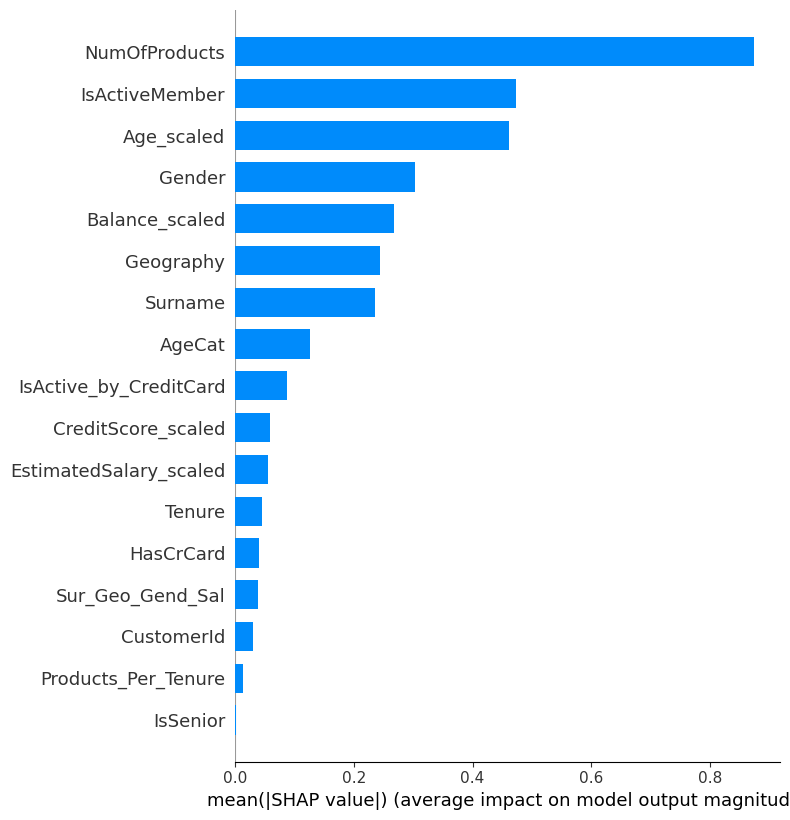

In [11]:
import shap
shap.initjs()
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(train_pool)
shap.summary_plot(shap_values, X_train, plot_type="bar")

## Prediction, Submission and Override
Credit : https://www.kaggle.com/competitions/playground-series-s4e1/discussion/469859

In [12]:
y_pred = test_preds.mean(axis=0)
df_orig=pd.read_csv("data\Churn_Modelling.csv")
join_cols=list(df_orig.columns.drop(['RowNumber','Exited']))
df_orig.rename(columns={'Exited':'Exited_Orig'},inplace=True)
df_orig['Exited_Orig']=df_orig['Exited_Orig'].map({0:1,1:0})
df_test_ov=df_test_ov.merge(df_orig,on=join_cols,how='left')[['id','Exited_Orig']].fillna(-1)
####
df_sub = df_test_ov[['id','Exited_Orig']]

if USE_DATA_LEAK=='Y':
    df_sub['Exited'] = np.where(df_sub.Exited_Orig==-1,y_pred,df_sub.Exited_Orig)
else:
    df_sub['Exited'] = y_pred
    
df_sub.drop('Exited_Orig',axis=1,inplace=True)
df_sub.head()

,id,Exited
0,165034,0.017063
1,165035,0.820040
2,165036,0.019925
3,165037,0.208702
4,165038,0.391495


In [13]:
df_sub.to_csv("submission.csv",index=False)

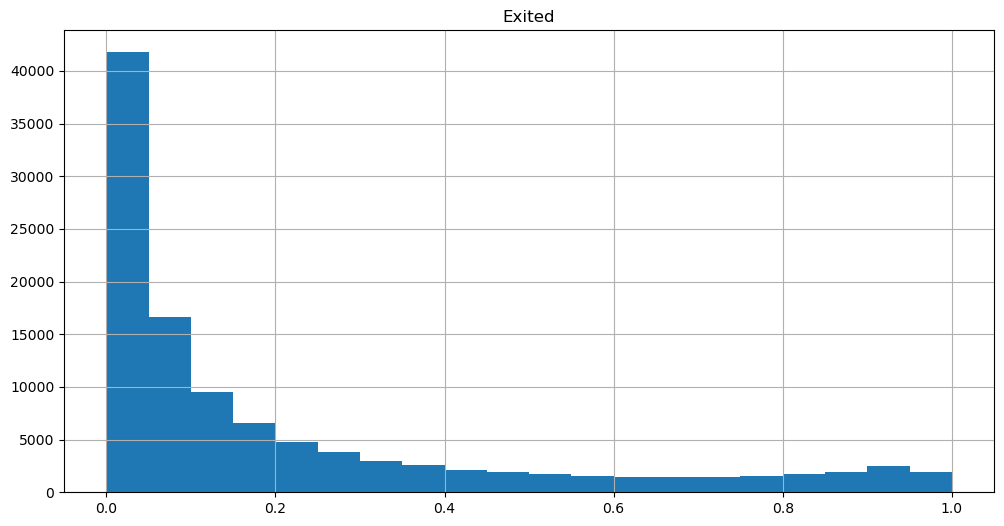

In [14]:
df_sub.hist(column='Exited', bins=20, range=[0,1],figsize=(12,6))
plt.show()